In [1]:
import pandas as pd
import re
import ast
from tikz import *  # Import pytikz functionality
cfg.demo_template = (
    '<div style="background-color:#e0e0e0;margin:0;padding:10px;">'
    '<img src="data:image/png;base64,{0}">'
    '</div>'
)
def render_single_partition(partition, sign=""):
    """
    Given a partition (a list of integers) and an optional sign (e.g. '+' or '-'),
    creates and returns a Picture object containing a Young diagram drawn with black borders.
    Each box is drawn as a unit square.
    """
    pic = Picture()
    env = pic.scope()  # Create a scope in the picture
    # Draw each box of the Young diagram.
    for i, row_length in enumerate(partition):
        for j in range(row_length):
            env.path(moveto((j, -i-1)), rectangle((j+1, -i)), opt="draw=black")
    if sign:
        env.node(sign, at=(-0.5, -0.5))
    return pic

def display_gap_results_factorizations(csv_file, title):
    """
    Reads a CSV file produced by ProcessQuantumQueryCharacterPartitions_Factorizations
    and displays the results. For each row, it prints the group degree and the factorization (a, b),
    and then for each partition in the 'partitions' field, it renders the partition as a TikZ picture
    using pytikz's demo() function.
    
    Parameters:
      csv_file (str): Path to the CSV file.
      title (str): A title prefix for the displayed results.
    """
    df = pd.read_csv(csv_file)
    
    for idx, row in df.iterrows():
        a = row["a"]
        b = row["b"]
        group_degree = row["groupDegree"]
        print(f"{title} - Group degree: {group_degree}, factorization: {a} * {b} = {group_degree}")
        
        try:
            # 'partitions' is expected to be a string representation of a list.
            partitions = ast.literal_eval(row["partitions"])
        except Exception as e:
            print(f"Error parsing partitions in row {idx}: {e}")
            continue
        
        # Render each partition separately.
        for part_entry in partitions:
            sign = ""
            partition = None
            if isinstance(part_entry, list):
                # Check if the entry is of the form [partition, sign]
                if len(part_entry) == 2 and isinstance(part_entry[1], str):
                    partition = part_entry[0]
                    sign = part_entry[1]
                else:
                    partition = part_entry
            else:
                continue
            
            pic = render_single_partition(partition, sign)
            pic.demo()  # Render and display the image


In [2]:
import matplotlib.pyplot as plt
from fractions import Fraction
# Update cfg.demo_template so that only the image is rendered.
cfg.demo_template = (
    '<div style="background-color:#e0e0e0;margin:0;padding:10px;">'
    '<img src="data:image/png;base64,{0}">'
    '</div>'
)

def render_single_partition(partition, sign=""):
    """
    Given a partition (a list of integers) and an optional sign (e.g. '+' or '-'),
    creates and returns a Picture object containing a Young diagram drawn with black borders.
    Each box is drawn as a unit square.
    """
    pic = Picture()
    env = pic.scope()  # Create a scope in the picture
    # Draw the boxes for the Young diagram.
    for i, row_length in enumerate(partition):
        for j in range(row_length):
            # For the box in row i, column j:
            # Lower left corner at (j, -i-1) and upper right at (j+1, -i).
            env.path(moveto((j, -i-1)), rectangle((j+1, -i)), opt="draw=black")
    # If a sign is provided, add a node with that sign near the diagram.
    if sign:
        env.node(sign, at=(-0.5, -0.5))
    return pic

def plot_gap_results_with_tikz(csv_file, title):
    """
    Reads a CSV file produced by GAP and:
      1. Plots both the total and bounded query complexities (y-axis) versus the group degree (x-axis)
         using Matplotlib with shades of red.
      2. For each CSV row that contains a 'partitionHistory' field, prints the group degree,
         and for each iteration in the partitionHistory prints the iteration number and then renders
         each partition separately using pytikz's demo() function.
    
    Parameters:
      csv_file (str): Path to the CSV file.
      title (str): Title for the Matplotlib plot.
    """
    # Read the CSV file using pandas.
    df = pd.read_csv(csv_file)
    
    # Determine x-axis values: if 'groupDegree' is present, use it; otherwise parse a number from 'group'.
    if "groupDegree" in df.columns:
        x = df["groupDegree"].values
    elif "group" in df.columns:
        x_vals = []
        for s in df["group"]:
            m = re.search(r'\d+', s)
            if m:
                x_vals.append(int(m.group()))
            else:
                x_vals.append(0)
        x = x_vals
    else:
        x = range(len(df))
    
    # Extract y-axis values.
    queries = df["queries"].values
    bounded_queries = df["boundedQueries"].values
    
    # Plot the query complexities using shades of red.
    plt.figure(figsize=(10, 6))
    plt.plot(x, queries, marker='o', linestyle='-', color='indianred', label='Total Queries')
    plt.plot(x, bounded_queries, marker='s', linestyle='--', color='firebrick', label='Bounded Queries')
    plt.xlabel("Group Degree")
    plt.ylabel("Query Complexity")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Now, for each row, render the partitions from partitionHistory separately.
    if "partitionHistory" in df.columns:
        for idx, row in df.iterrows():
            # Get group degree for this row.
            if "groupDegree" in df.columns:
                group_deg = row["groupDegree"]
            elif "group" in df.columns:
                m = re.search(r'\d+', row["group"])
                group_deg = int(m.group()) if m else "?"
            else:
                group_deg = "?"
            print(f"\nGroup degree: {group_deg}")
            
            part_history_str = row["partitionHistory"]
            try:
                part_history = ast.literal_eval(part_history_str)
            except Exception as e:
                print(f"Error parsing partitionHistory for row {idx}: {e}")
                continue
            if not part_history:
                continue
            # For each iteration in the partition history, print the iteration number.
            for iter_index, iteration in enumerate(part_history, start=1):
                print(f"  Iteration {iter_index}:")
                # For each partition entry in this iteration, render it separately.
                for entry in iteration:
                    sign = ""
                    partition = None
                    if isinstance(entry, list):
                        if len(entry) == 2 and isinstance(entry[0], list) and entry[1] in ['+', '-']:
                            partition = entry[0]
                            sign = entry[1]
                        else:
                            partition = entry
                    elif isinstance(entry, tuple):
                        partition, sign = entry
                    else:
                        continue
                    # Render this partition in a separate Picture.
                    pic = render_single_partition(partition, sign)
                    pic.demo()  # Render the image (using demo() to display only the image)
    else:
        print("No 'partitionHistory' column found in CSV.")

# Example usage:
# plot_gap_results_with_tikz("results.csv", "Quantum Query Complexity and Partition Renderings")


partitions - Group degree: 4, factorization: 2 * 2 = 4



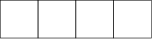


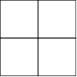

partitions - Group degree: 6, factorization: 2 * 3 = 6



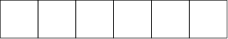


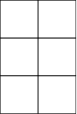


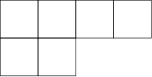

partitions - Group degree: 6, factorization: 3 * 2 = 6



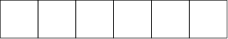


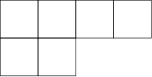

partitions - Group degree: 8, factorization: 2 * 4 = 8



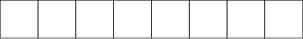


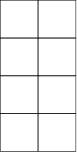


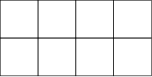


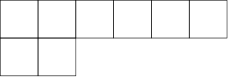


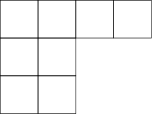

partitions - Group degree: 8, factorization: 4 * 2 = 8



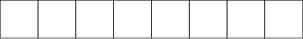


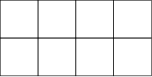


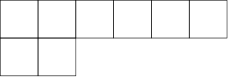

partitions - Group degree: 9, factorization: 3 * 3 = 9



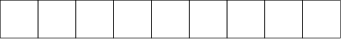


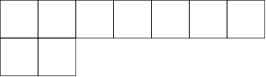


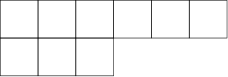


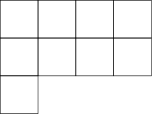


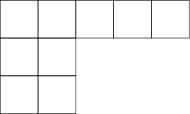

partitions - Group degree: 10, factorization: 2 * 5 = 10



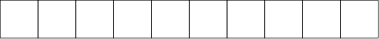


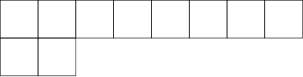


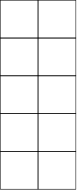


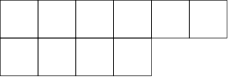


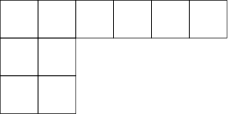


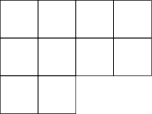


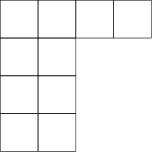

partitions - Group degree: 10, factorization: 5 * 2 = 10



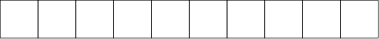


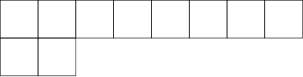


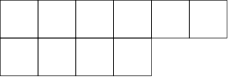

partitions - Group degree: 12, factorization: 2 * 6 = 12



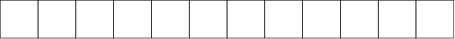


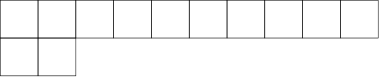


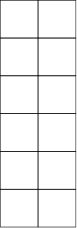


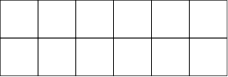


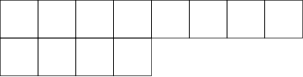


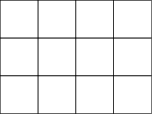


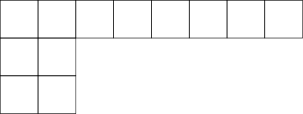


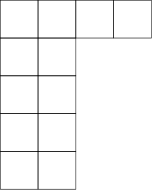


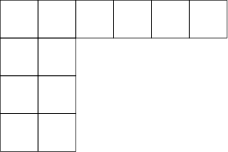


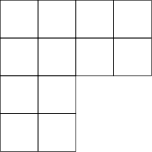


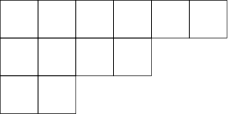

partitions - Group degree: 12, factorization: 6 * 2 = 12



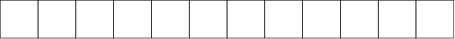


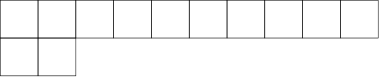


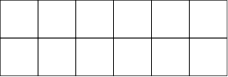


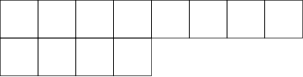

partitions - Group degree: 12, factorization: 3 * 4 = 12



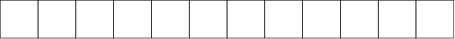


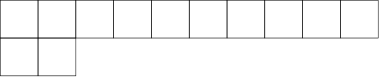


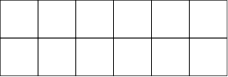


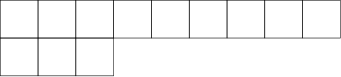


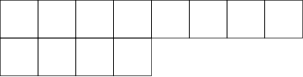


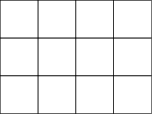


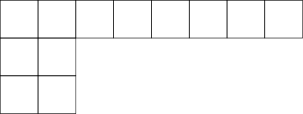


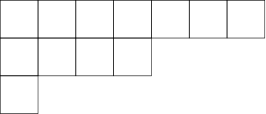


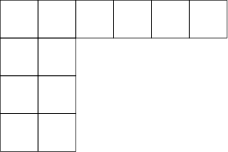


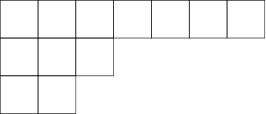


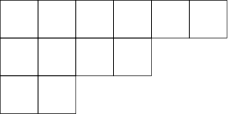


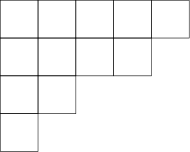

partitions - Group degree: 12, factorization: 4 * 3 = 12



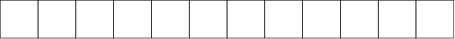


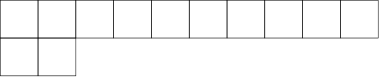


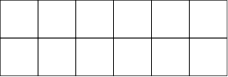


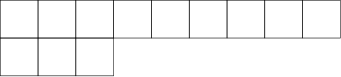


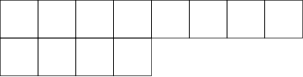


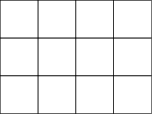


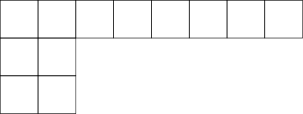


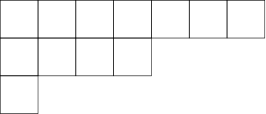


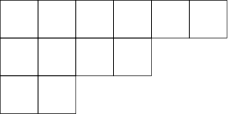

partitions - Group degree: 14, factorization: 7 * 2 = 14



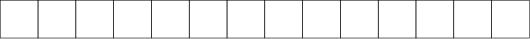


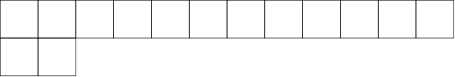


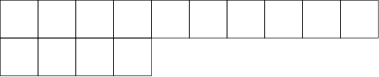


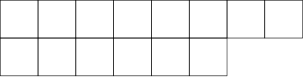

In [5]:
display_gap_results_factorizations("SnPartitionsFirstRep.csv", "partitions");

partitions - Group degree: 4, factorization: 2 * 2 = 4



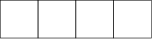


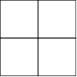

partitions - Group degree: 6, factorization: 2 * 3 = 6



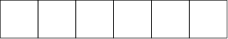


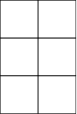


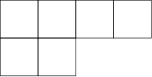

partitions - Group degree: 6, factorization: 3 * 2 = 6



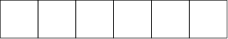


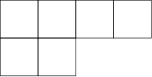

partitions - Group degree: 8, factorization: 2 * 4 = 8



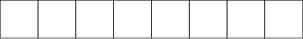


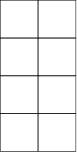


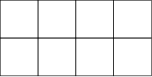


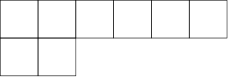


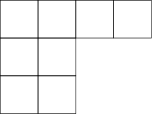

partitions - Group degree: 8, factorization: 4 * 2 = 8



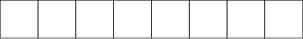


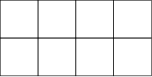


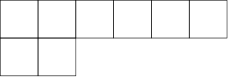

partitions - Group degree: 9, factorization: 3 * 3 = 9



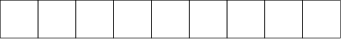


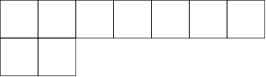


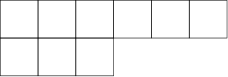


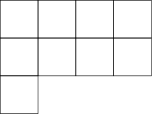


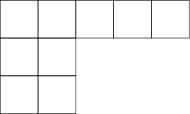

partitions - Group degree: 10, factorization: 2 * 5 = 10



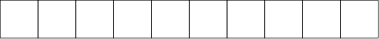


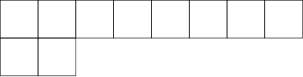


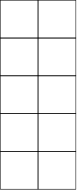


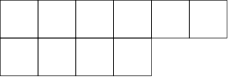


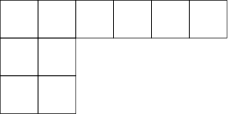


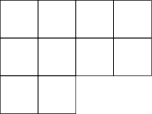


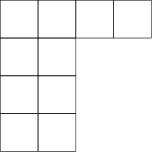

partitions - Group degree: 10, factorization: 5 * 2 = 10



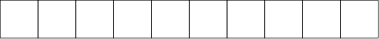


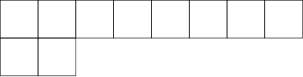


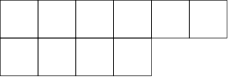

partitions - Group degree: 12, factorization: 2 * 6 = 12



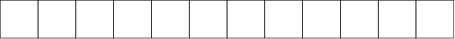


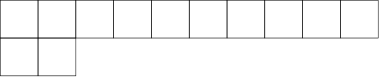


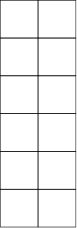


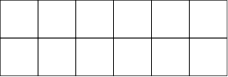


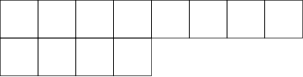


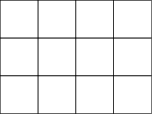


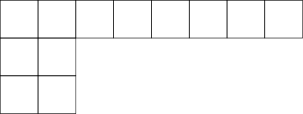


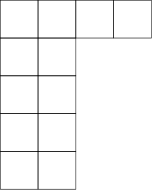


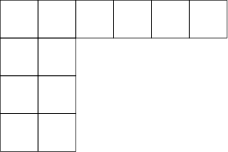


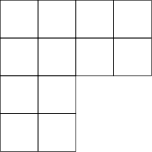


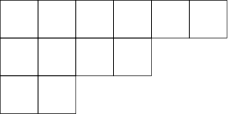

partitions - Group degree: 12, factorization: 6 * 2 = 12



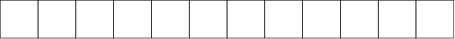


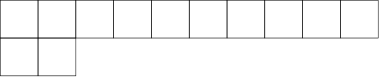


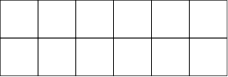


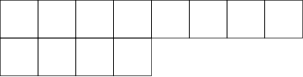

partitions - Group degree: 12, factorization: 3 * 4 = 12



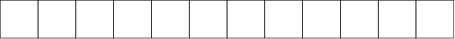


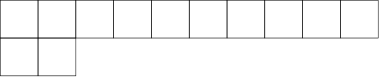


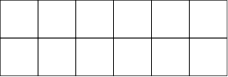


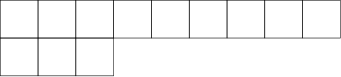


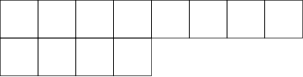


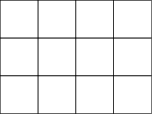


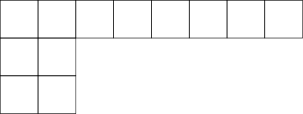


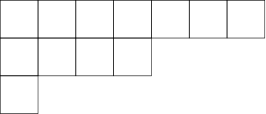


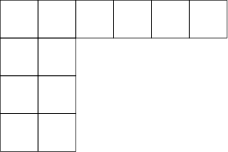


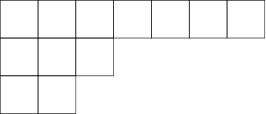


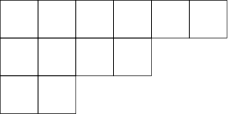


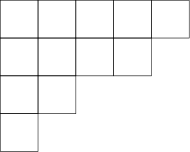

partitions - Group degree: 12, factorization: 4 * 3 = 12



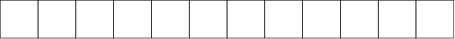


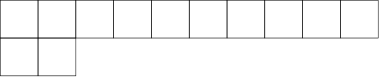


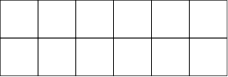


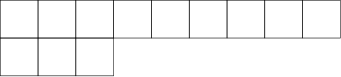


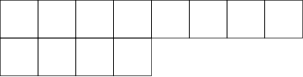


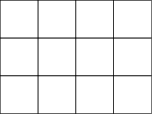


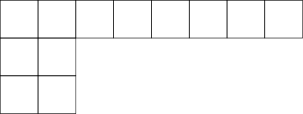


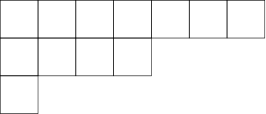


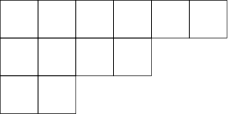

partitions - Group degree: 14, factorization: 2 * 7 = 14



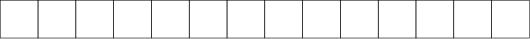


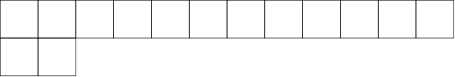


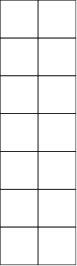


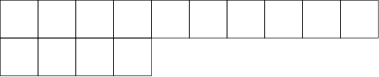


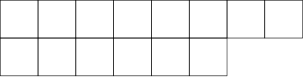


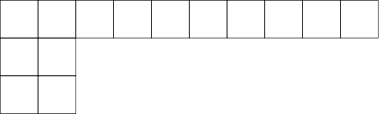


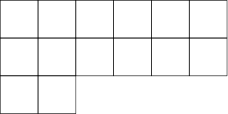


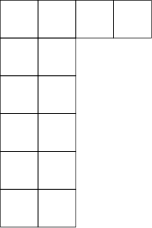


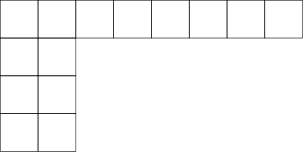


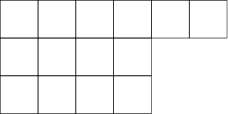


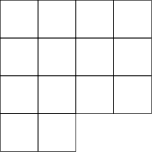


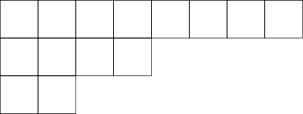


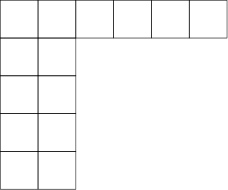


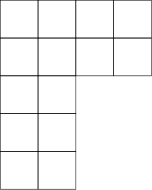


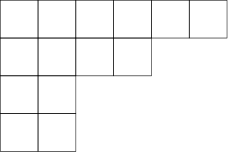

partitions - Group degree: 14, factorization: 7 * 2 = 14



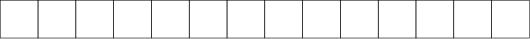


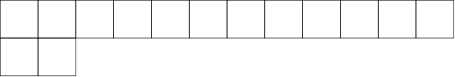


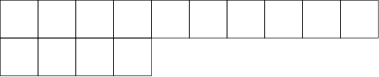


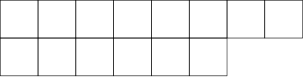

partitions - Group degree: 15, factorization: 3 * 5 = 15



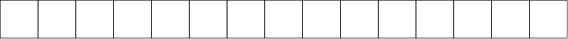


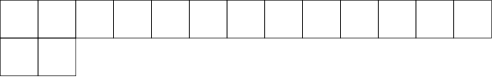


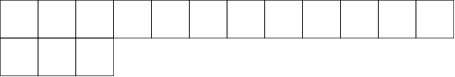


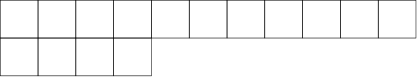


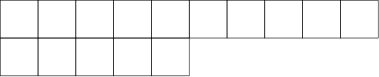


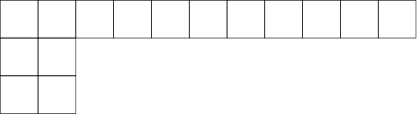


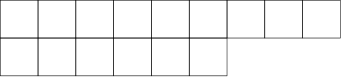


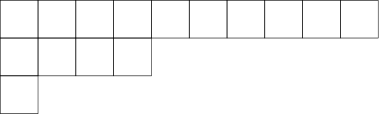


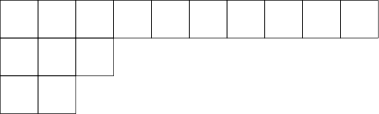


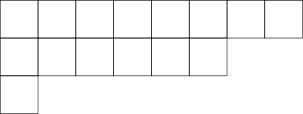


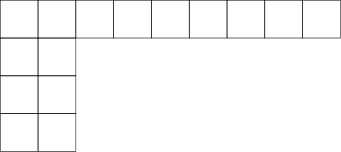


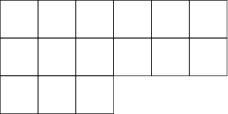


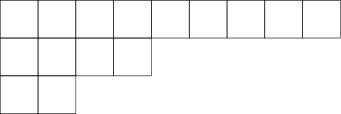


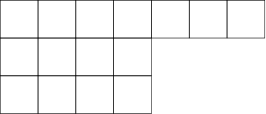


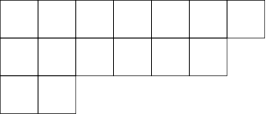


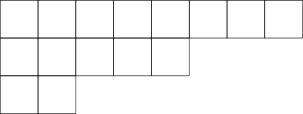


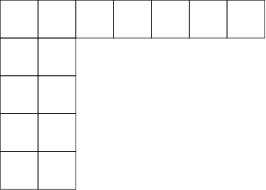


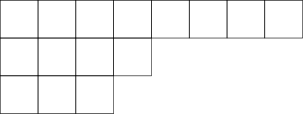


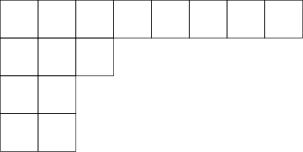


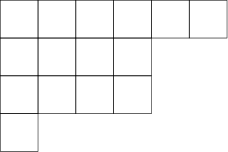


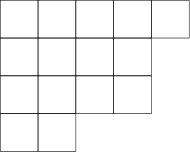


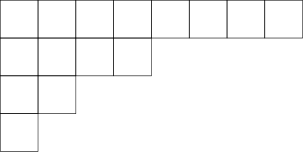


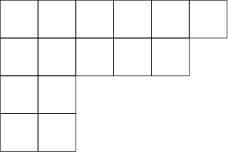


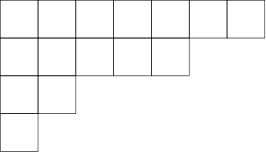


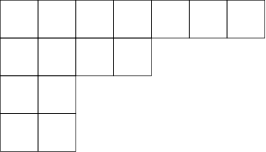


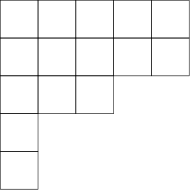


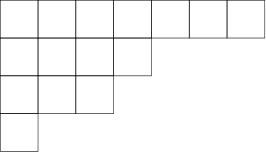


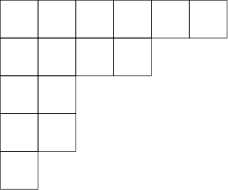

partitions - Group degree: 15, factorization: 5 * 3 = 15



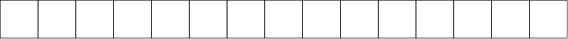


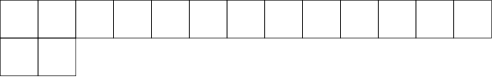


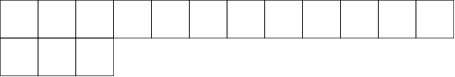


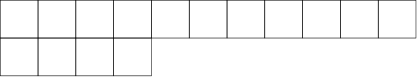


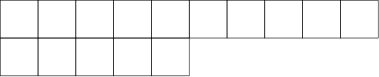


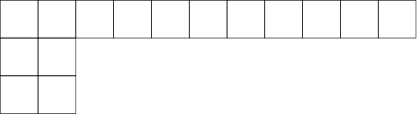


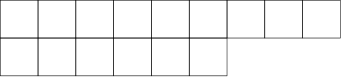


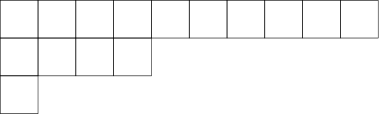


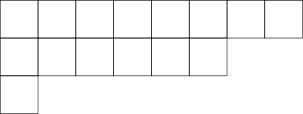


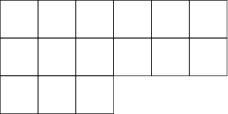


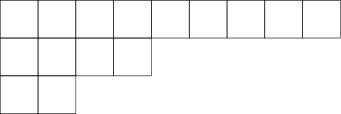


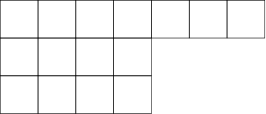


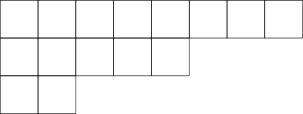

partitions - Group degree: 16, factorization: 8 * 2 = 16



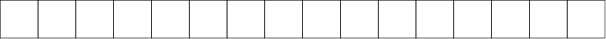


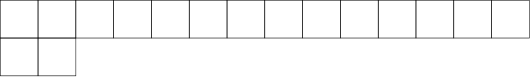


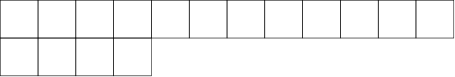


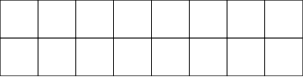


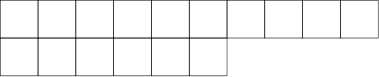

partitions - Group degree: 18, factorization: 9 * 2 = 18



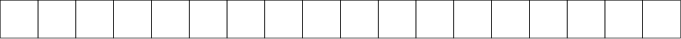


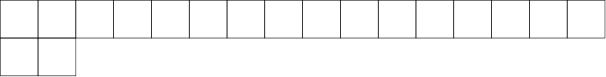


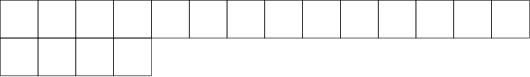


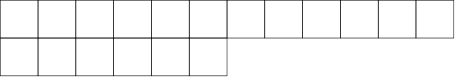


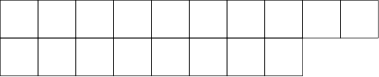

partitions - Group degree: 20, factorization: 10 * 2 = 20



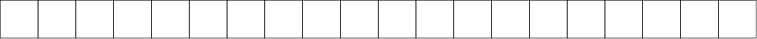


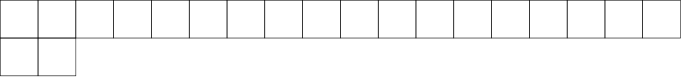


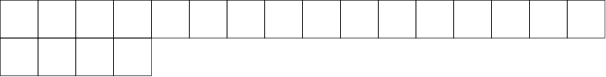


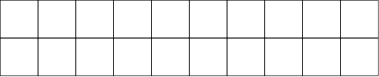


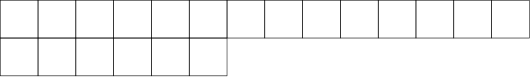


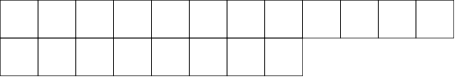

In [6]:
display_gap_results_factorizations("SnPartitionsFirst.csv", "partitions");

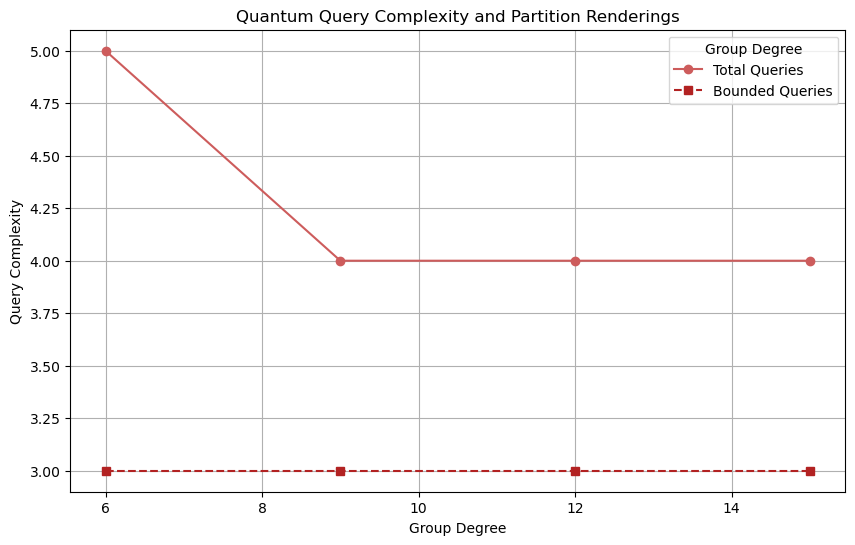


Group degree: 6
  Iteration 1: Max rows = 3



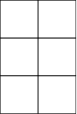

  Iteration 2: Max rows = 3



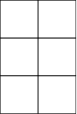

  Iteration 3: Max rows = 5



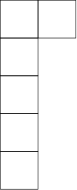

  Iteration 4: Max rows = 5



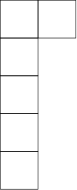

  Iteration 5: Max rows = 6



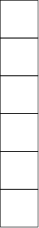


Group degree: 9
  Iteration 1: Max rows = 3



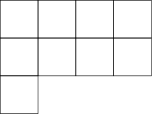


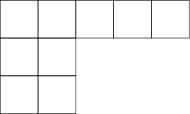

  Iteration 2: Max rows = 3



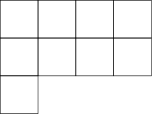


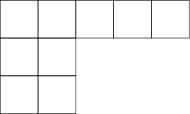

  Iteration 3: Max rows = 7



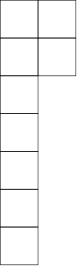

  Iteration 4: Max rows = 9



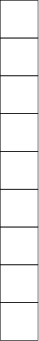


Group degree: 12
  Iteration 1: Max rows = 3



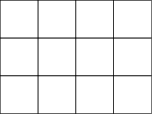


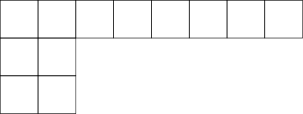


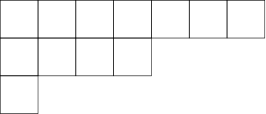


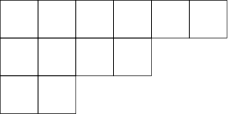

  Iteration 2: Max rows = 3



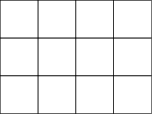


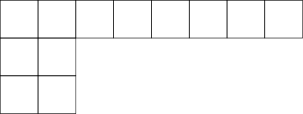


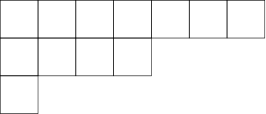


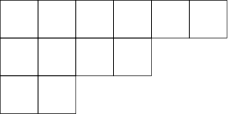

  Iteration 3: Max rows = 9



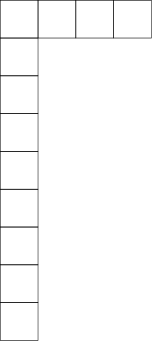

  Iteration 4: Max rows = 12



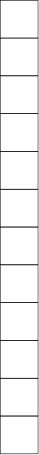


Group degree: 15
  Iteration 1: Max rows = 3



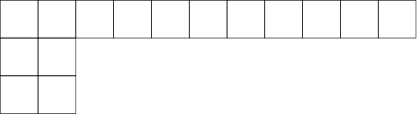


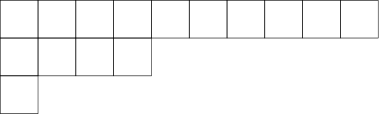


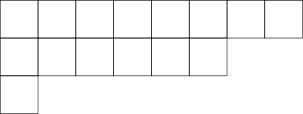


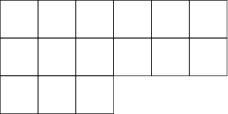


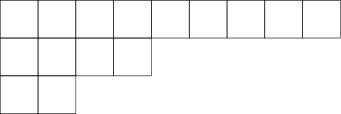


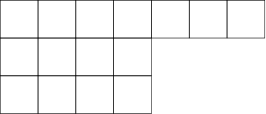


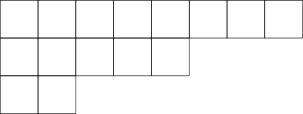

  Iteration 2: Max rows = 3



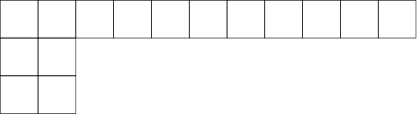


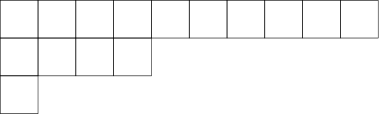


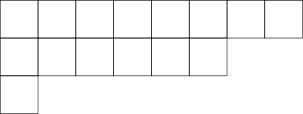


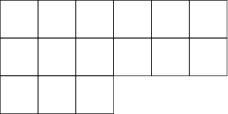


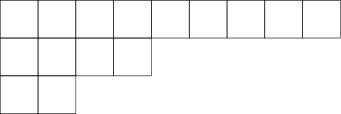


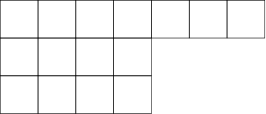


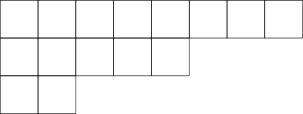

  Iteration 3: Max rows = 9



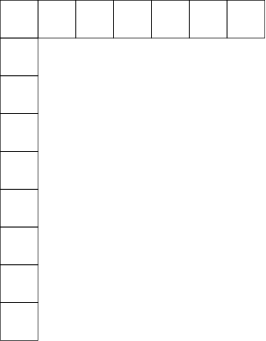


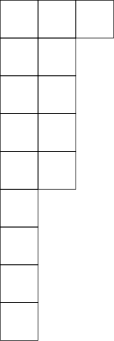


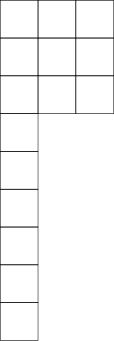


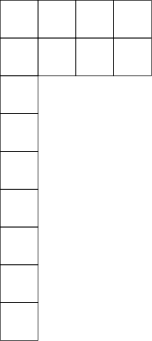


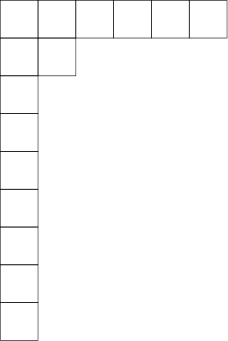


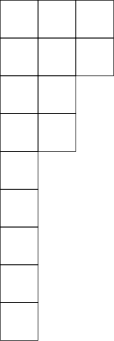


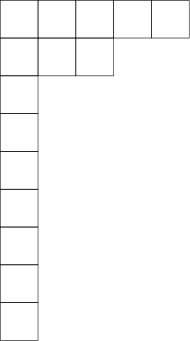


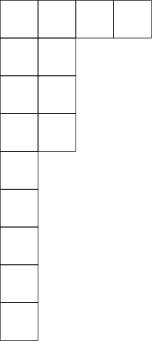


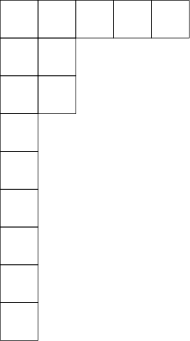


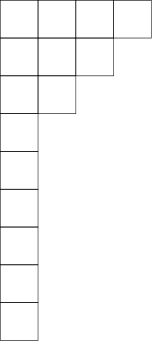

  Iteration 4: Max rows = 15



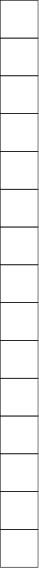

In [8]:
plot_gap_results_with_tikz_max_rows("SnPartitions3.csv", "Quantum Query Complexity and Partition Renderings")

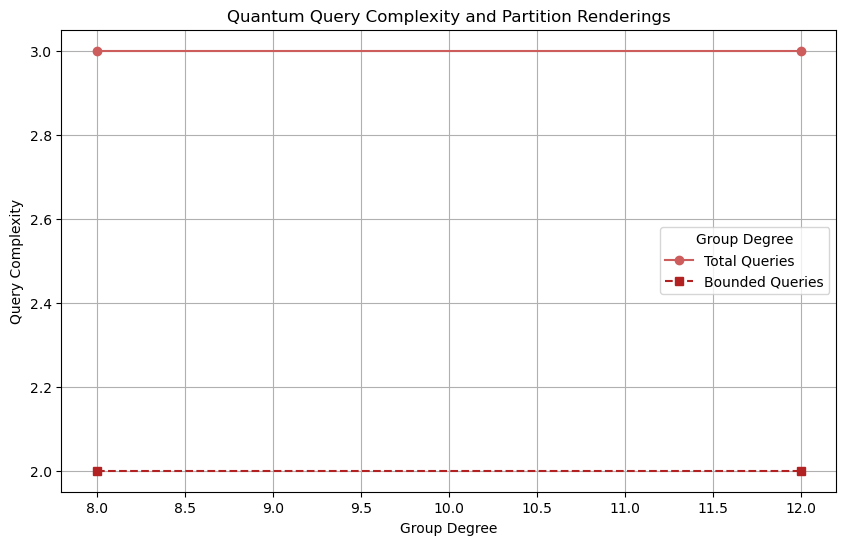


Group degree: 8
  Iteration 1: Max rows = 4



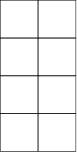

  Iteration 2: Max rows = 8



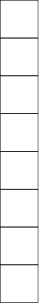

  Iteration 3: Max rows = 8



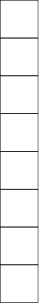


Group degree: 12
  Iteration 1: Max rows = 4



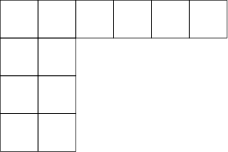


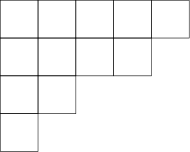

  Iteration 2: Max rows = 10



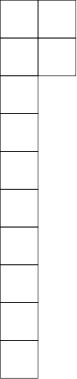


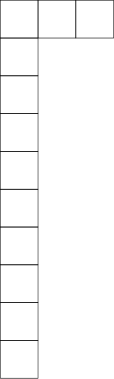

  Iteration 3: Max rows = 12



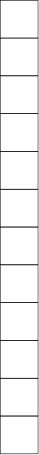

In [9]:
plot_gap_results_with_tikz_max_rows("SnPartitions4.csv", "Quantum Query Complexity and Partition Renderings")

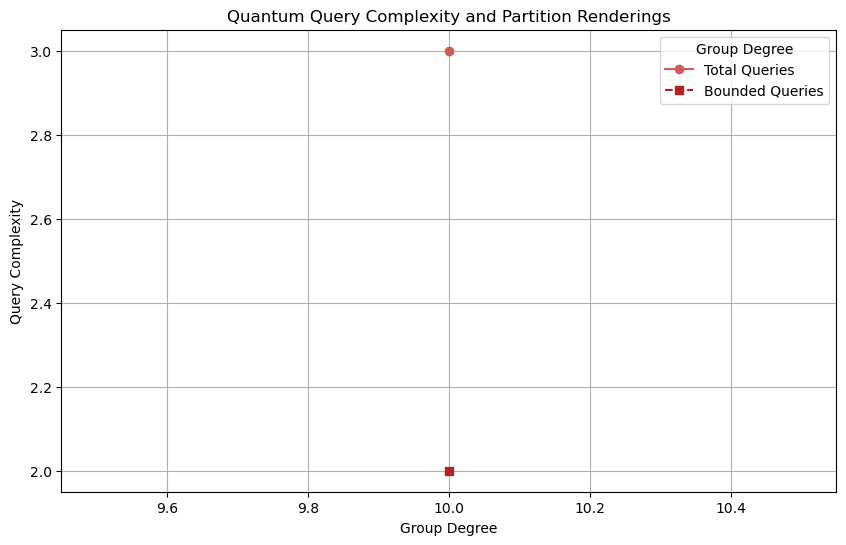


Group degree: 10
  Iteration 1: Max rows = 5



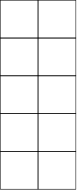

  Iteration 2: Max rows = 9



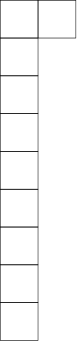

  Iteration 3: Max rows = 10



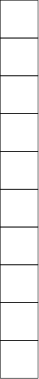

In [10]:
plot_gap_results_with_tikz_max_rows("SnPartitions5.csv", "Quantum Query Complexity and Partition Renderings")

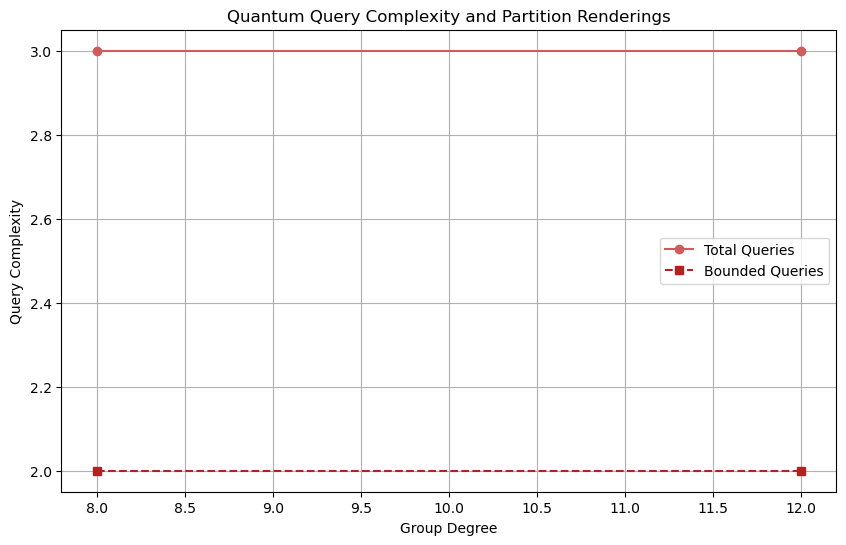


Group degree: 8
  Iteration 1:



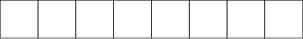


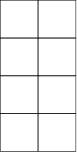


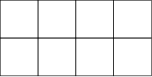


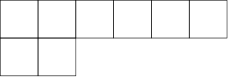


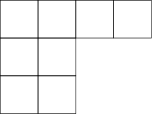

  Iteration 2:



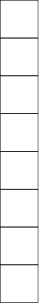


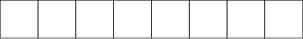


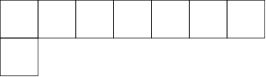


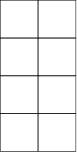


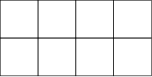


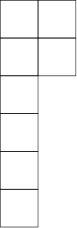


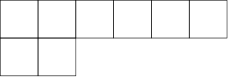


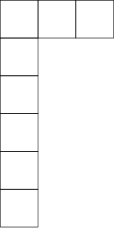


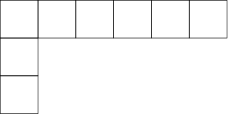


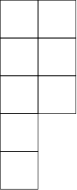


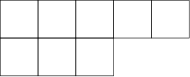


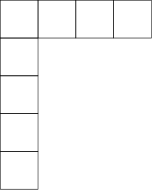


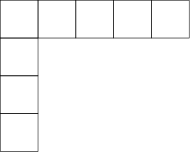


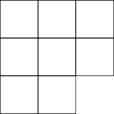


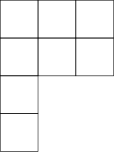


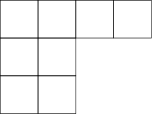


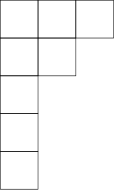


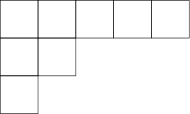


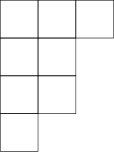


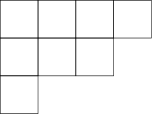


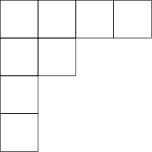

  Iteration 3:



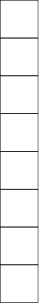


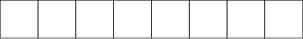


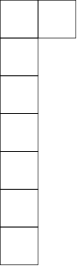


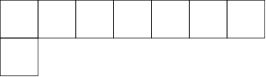


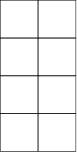


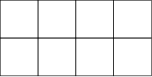


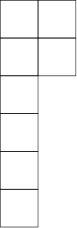


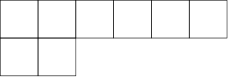


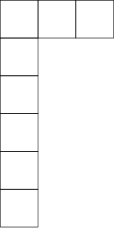


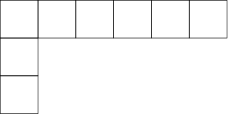


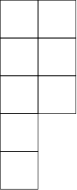


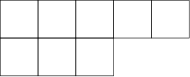


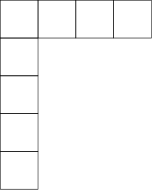


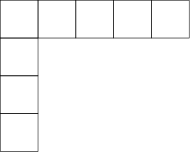


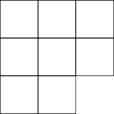


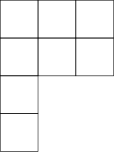


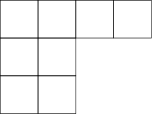


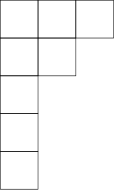


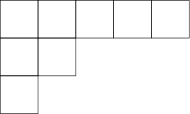


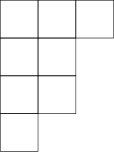


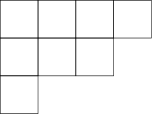


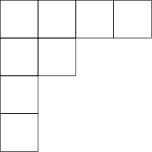


Group degree: 12
  Iteration 1:



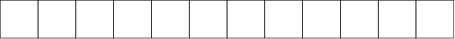


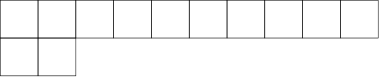


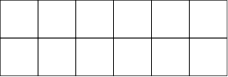


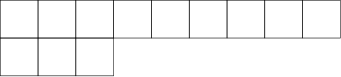


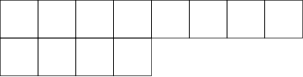


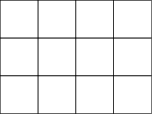


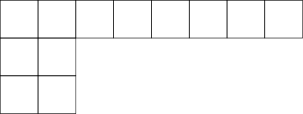


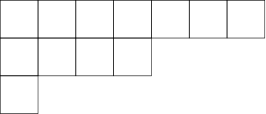


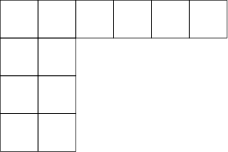


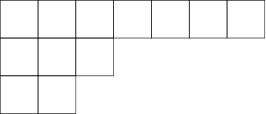


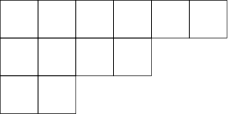


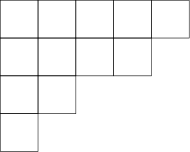

  Iteration 2:



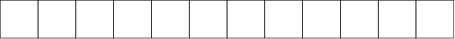


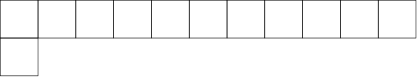


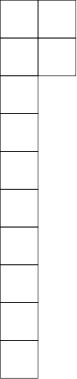


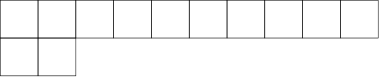


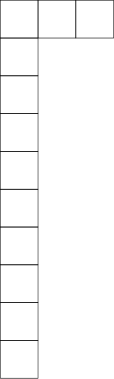


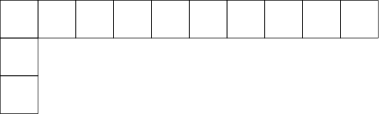


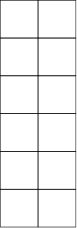


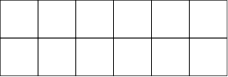


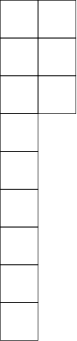


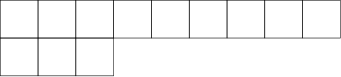


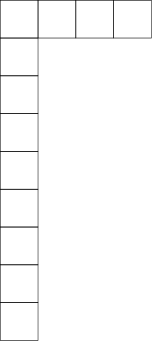


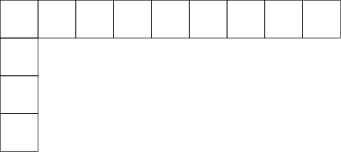


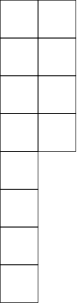


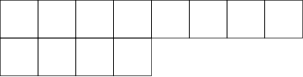


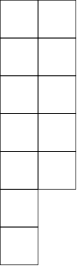


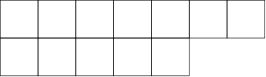


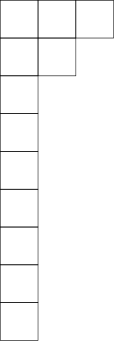


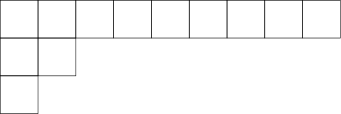


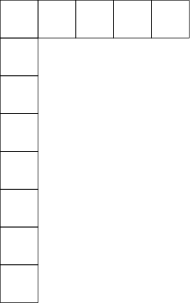


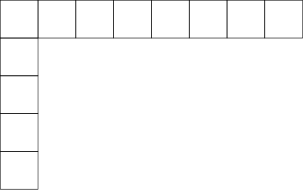


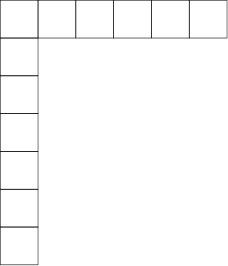


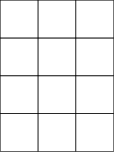


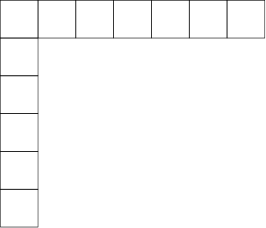


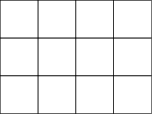


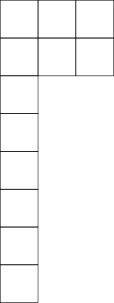


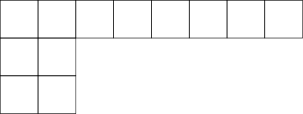


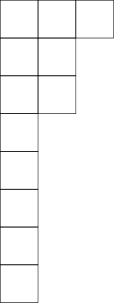


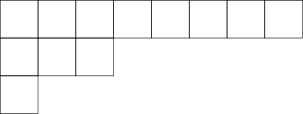


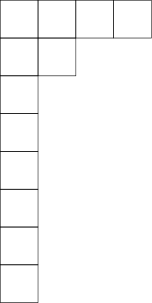


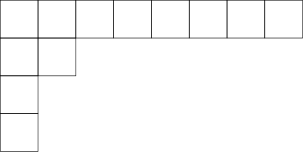


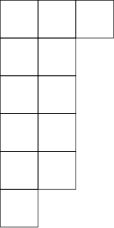


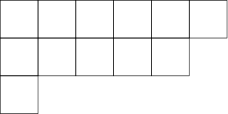


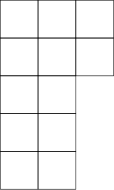


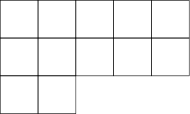


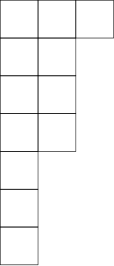


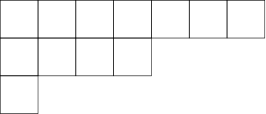


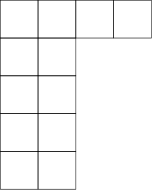


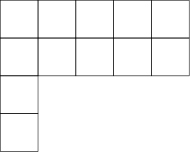


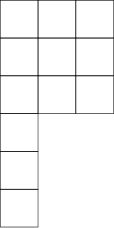


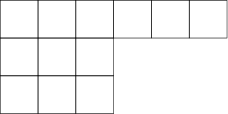


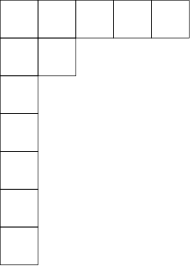


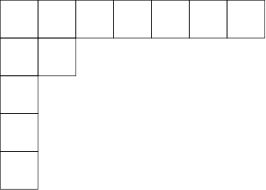


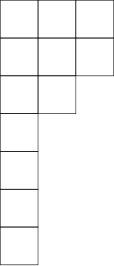


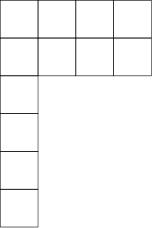


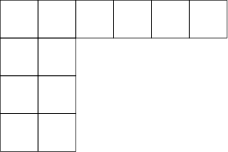


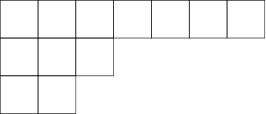


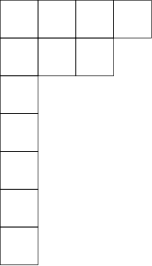


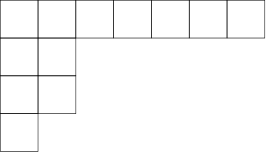


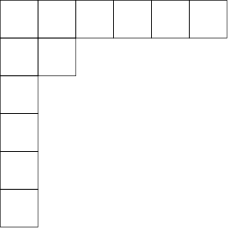


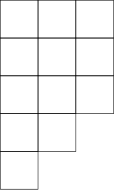


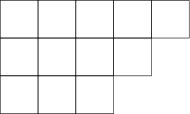


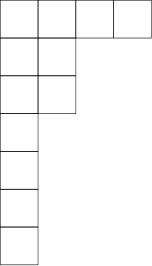


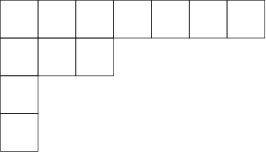


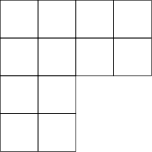


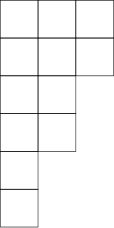


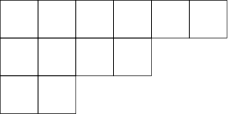


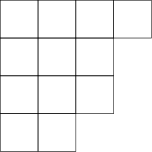


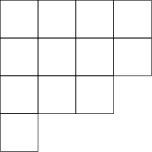


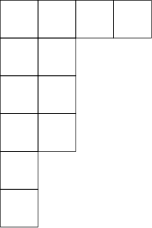


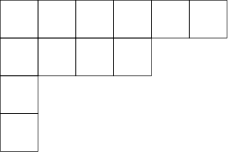


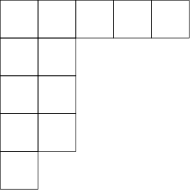


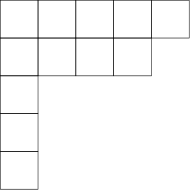


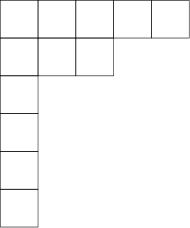


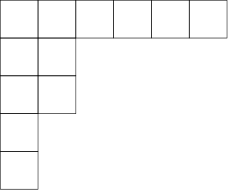


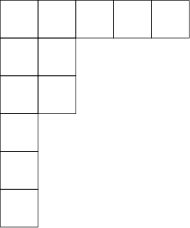


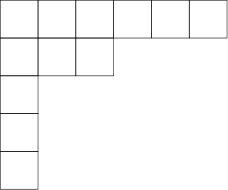


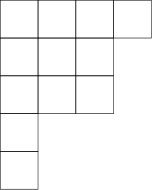


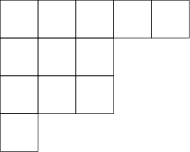


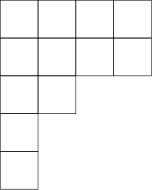


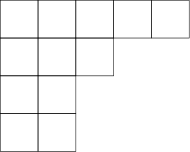


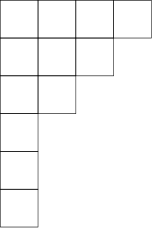


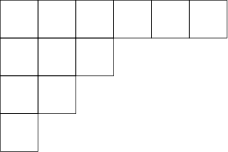


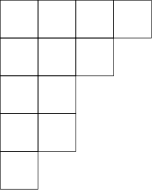


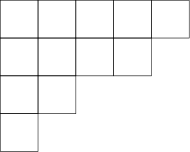


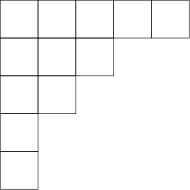

  Iteration 3:



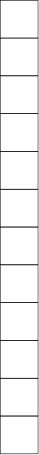


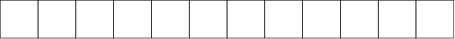


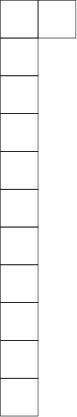


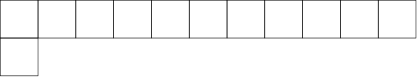


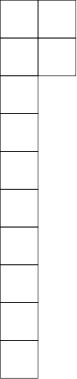


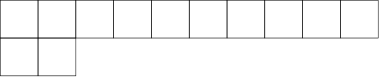


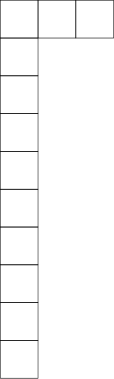


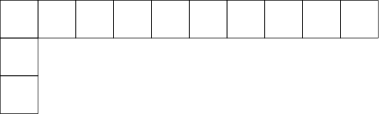


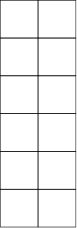


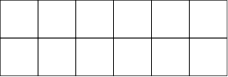


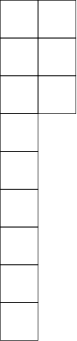


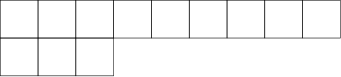


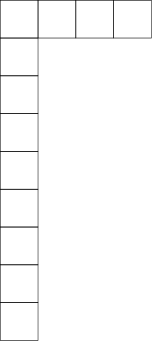


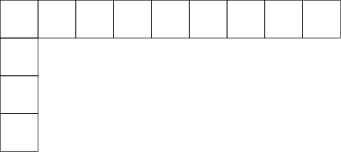


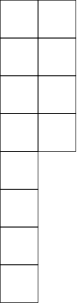


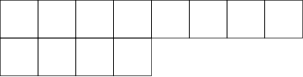


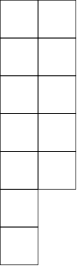


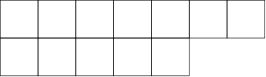


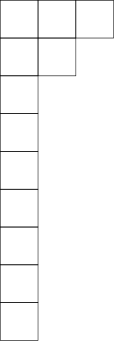


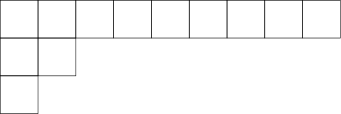


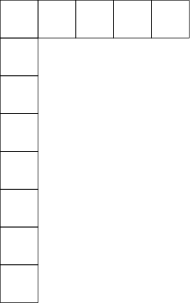


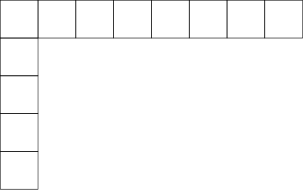


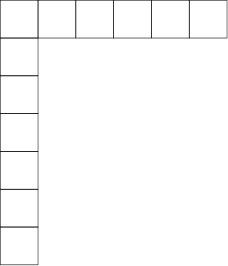


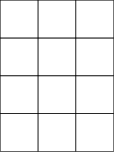


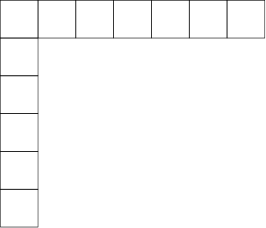


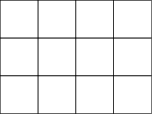


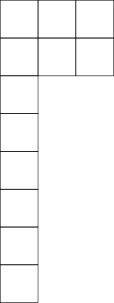


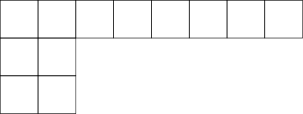


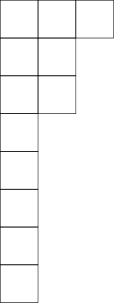


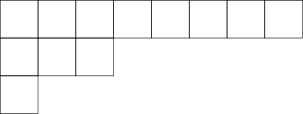


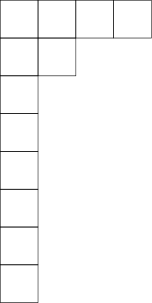


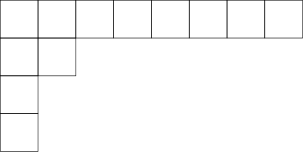


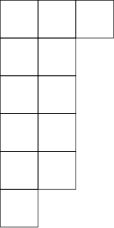


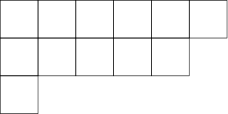


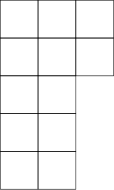


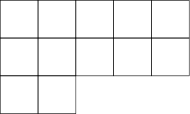


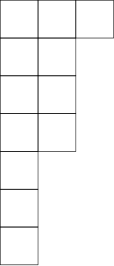


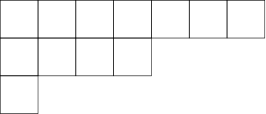


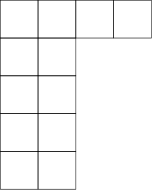


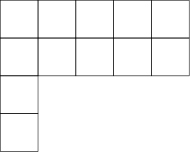


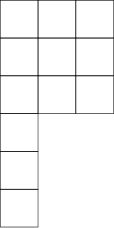


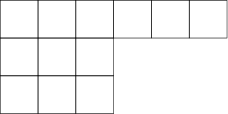


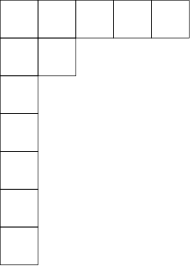


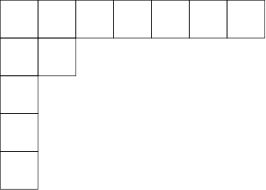


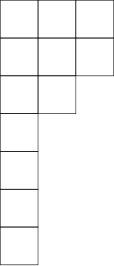


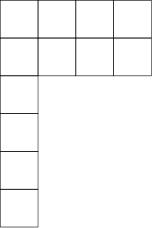


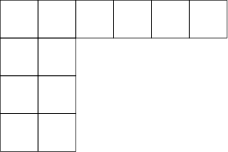


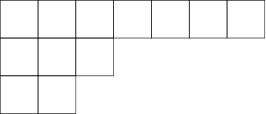


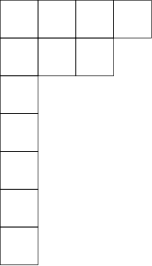


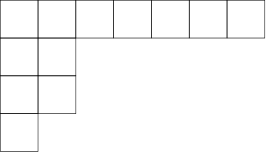


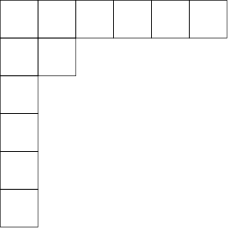


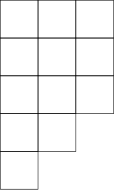


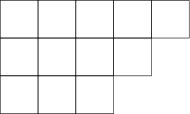


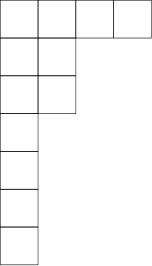


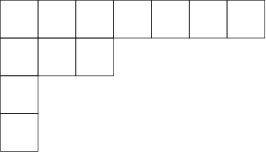


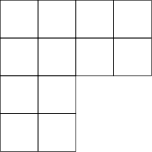


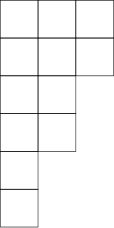


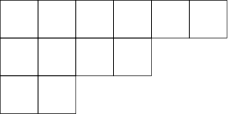


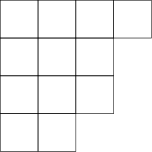


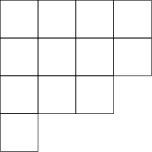


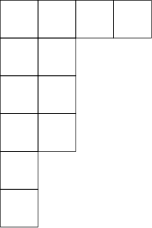


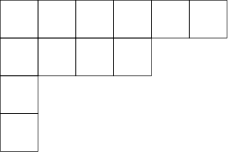


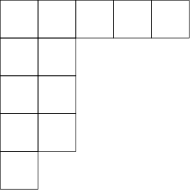


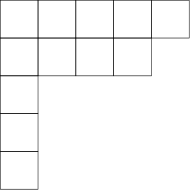


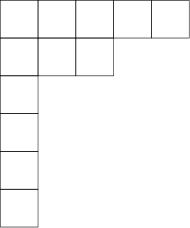


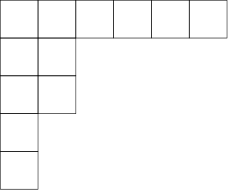


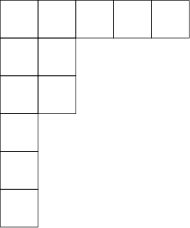


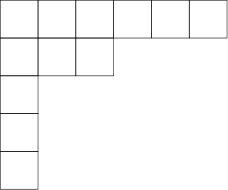


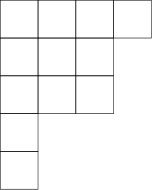


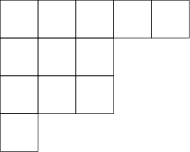


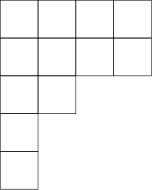


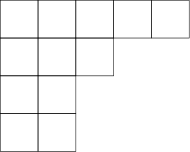


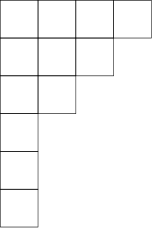


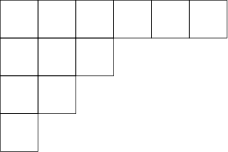


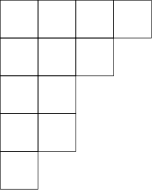


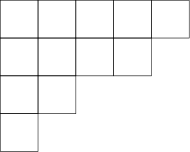


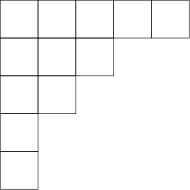

In [3]:
plot_gap_results_with_tikz("SnPartitions4.csv", "Quantum Query Complexity and Partition Renderings")

In [70]:
import pandas as pd
import re
import ast
from tikz import Picture, Raw, cfg, moveto, rectangle

# Update the configuration to display only the rendered image.
cfg.demo_template = (
    '<div style="background-color:#e0e0e0;margin:0;padding:10px;">'
    '<img src="data:image/png;base64,{0}">'
    '</div>'
)

def render_single_partition(partition, sign=""):
    """
    Given a partition (a list of integers) and an optional sign (e.g. '+' or '-'),
    creates and returns a Picture object containing a Young diagram drawn with black borders.
    Each box is drawn as a unit square.
    """
    pic = Picture()
    env = pic.scope()  # Create a scope in the picture
    for i, row_length in enumerate(partition):
        for j in range(row_length):
            env.path(moveto((j, -i-1)), rectangle((j+1, -i)), opt="draw=black")
    if sign:
        env.node(sign, at=(-0.5, -0.5))
    return pic

def render_tensor_decompositions_individual(csv_file, title, group_deg, start, stop):
    """
    Reads a CSV file produced by DecomposeCharacterTensorPairs which contains at least
    the columns "char1_partition", "char2_partition", and "tensor_decomposition". For each row,
    the function renders each partition as follows:
    
      - The partition corresponding to the first tensor multiplicand is rendered, and a label
        "Tensor multiplicand 1:" is printed.
      - The partition corresponding to the second tensor multiplicand is rendered, and a label
        "Tensor multiplicand 2:" is printed.
      - Each partition appearing in the tensor decomposition is rendered separately, with a label
        "Constituent:" printed before it.
    
    Parameters:
      csv_file (str): Path to the CSV file.
      title (str): A title printed before processing begins.
    """
    df = pd.read_csv(csv_file)
    
    print(title)
    for idx, row in df.iterrows():
        try:
            char1 = ast.literal_eval(row["char1_partition"])
            char2 = ast.literal_eval(row["char2 partition"])
            tensor_decomp = ast.literal_eval(row["tensor decomposition"])
        except Exception as e:
            print(f"Error parsing row {idx}: {e}")
            continue

        # Check if either multiplicand is trivial.
        # The trivial partition for S_n is assumed to be [n].
        if (char1 == [group_deg] or char2 == [group_deg]):
            continue
        depth = len(char1) if isinstance(char1, list) else 0
        if depth < start or depth > stop:
            continue
        # Render the two tensor multiplicands.
        print("Tensor multiplicand 1:")
        pic1 = render_single_partition(char1)
        pic1.demo()
        
        print("Tensor multiplicand 2:")
        pic2 = render_single_partition(char2)
        pic2.demo()
        
        # Render each irreducible constituent from the tensor decomposition.
        print("Tensor constituent(s):")
        for tensor in tensor_decomp:
            sign = ""
            if isinstance(tensor, list):
                if len(tensor) == 2 and isinstance(tensor[0], list):
                    partition = tensor[0]
                    sign = tensor[1]
                else:
                    partition = tensor
            elif isinstance(tensor, tuple):
                partition, sign = tensor
            else:
                continue
            pic3 = render_single_partition(partition, sign)
            pic3.demo()


Tensor Pairs
Tensor multiplicand 1:



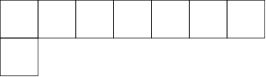

Tensor multiplicand 2:



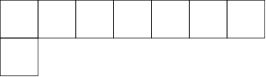

Tensor constituent(s):



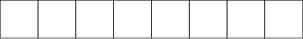


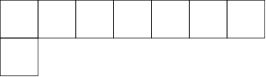


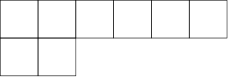


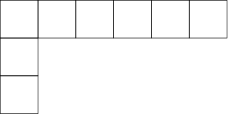

Tensor multiplicand 1:



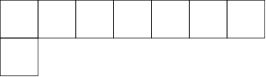

Tensor multiplicand 2:



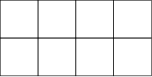

Tensor constituent(s):



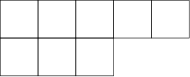


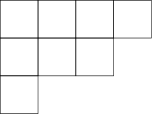

Tensor multiplicand 1:



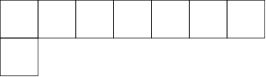

Tensor multiplicand 2:



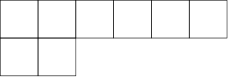

Tensor constituent(s):



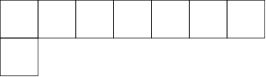


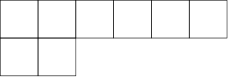


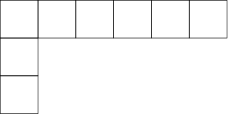


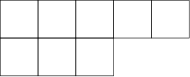


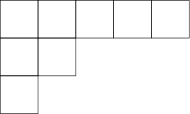

Tensor multiplicand 1:



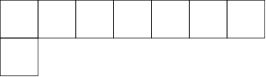

Tensor multiplicand 2:



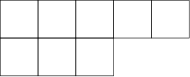

Tensor constituent(s):



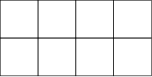


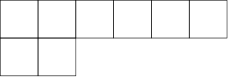


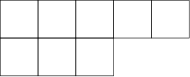


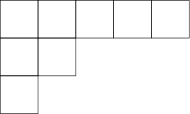


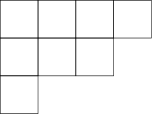

Tensor multiplicand 1:



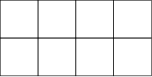

Tensor multiplicand 2:



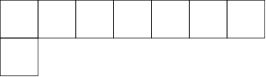

Tensor constituent(s):



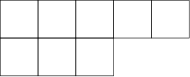


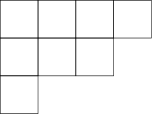

Tensor multiplicand 1:



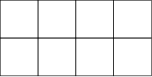

Tensor multiplicand 2:



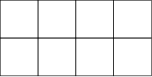

Tensor constituent(s):



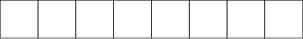


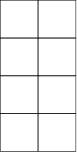


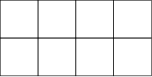


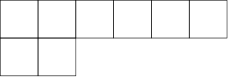


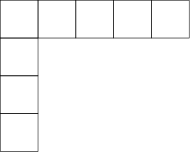


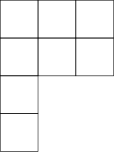


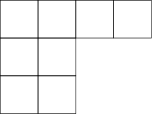

Tensor multiplicand 1:



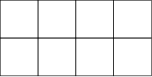

Tensor multiplicand 2:



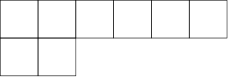

Tensor constituent(s):



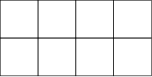


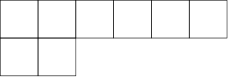


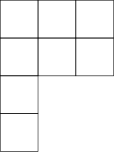


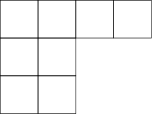


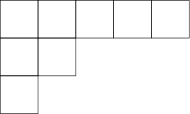


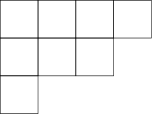

Tensor multiplicand 1:



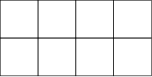

Tensor multiplicand 2:



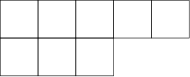

Tensor constituent(s):



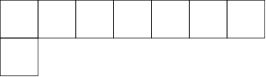


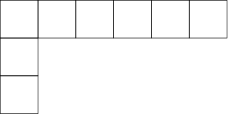


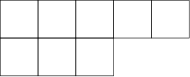


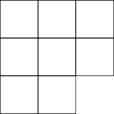


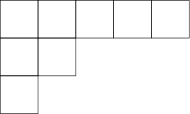


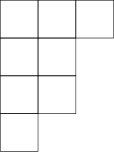


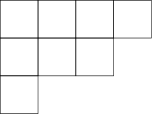


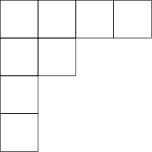

Tensor multiplicand 1:



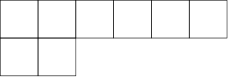

Tensor multiplicand 2:



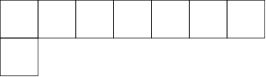

Tensor constituent(s):



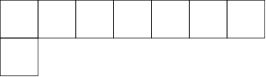


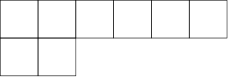


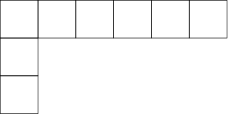


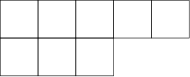


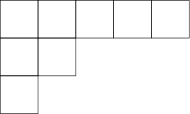

Tensor multiplicand 1:



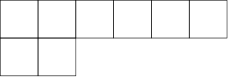

Tensor multiplicand 2:



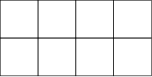

Tensor constituent(s):



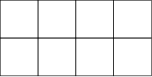


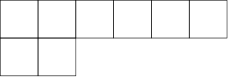


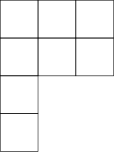


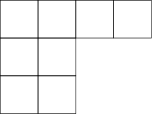


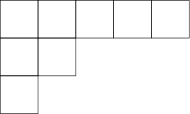


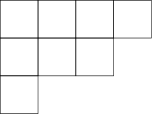

Tensor multiplicand 1:



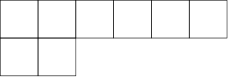

Tensor multiplicand 2:



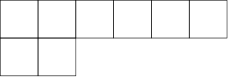

Tensor constituent(s):



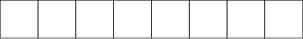


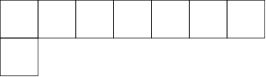


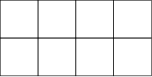


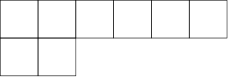


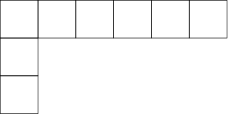


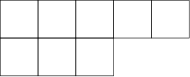


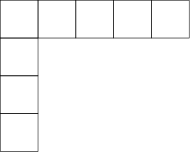


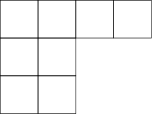


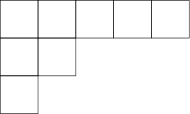


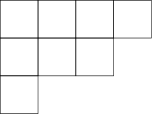

Tensor multiplicand 1:



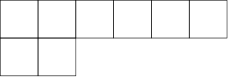

Tensor multiplicand 2:



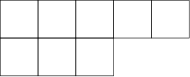

Tensor constituent(s):



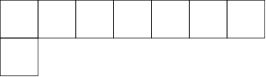


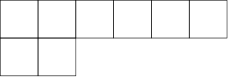


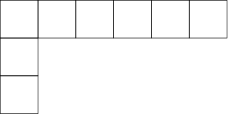


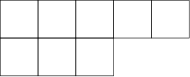


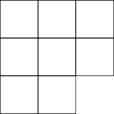


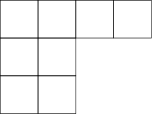


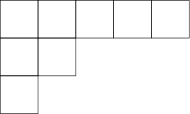


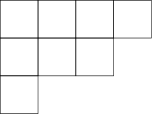


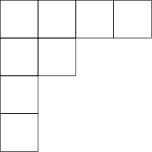

Tensor multiplicand 1:



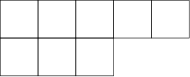

Tensor multiplicand 2:



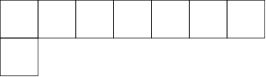

Tensor constituent(s):



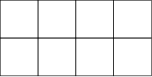


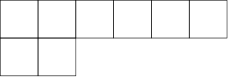


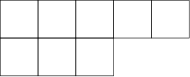


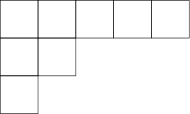


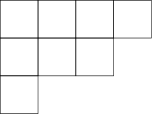

Tensor multiplicand 1:



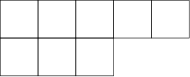

Tensor multiplicand 2:



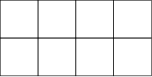

Tensor constituent(s):



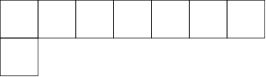


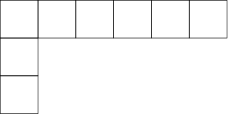


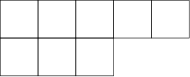


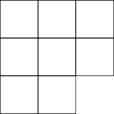


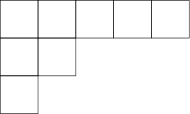


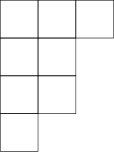


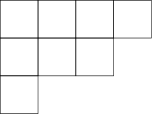


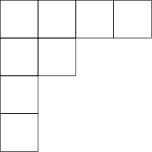

Tensor multiplicand 1:



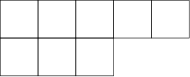

Tensor multiplicand 2:



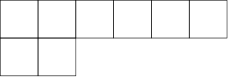

Tensor constituent(s):



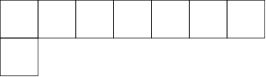


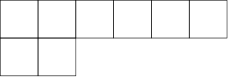


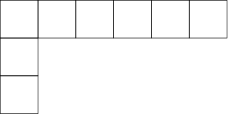


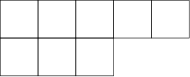


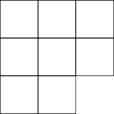


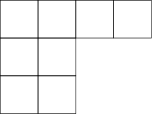


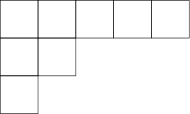


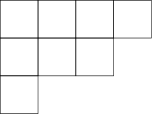


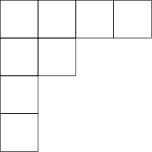

Tensor multiplicand 1:



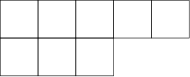

Tensor multiplicand 2:



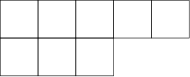

Tensor constituent(s):



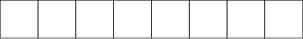


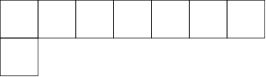


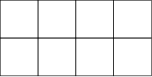


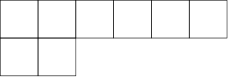


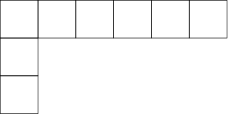


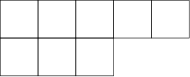


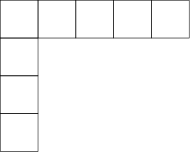


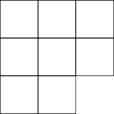


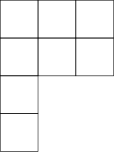


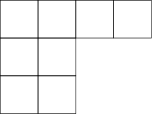


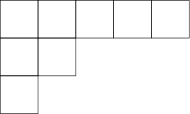


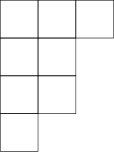


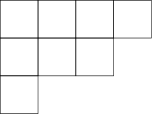


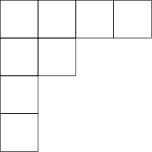

In [61]:
render_tensor_decompositions_individual("SnSubsets4TensorPairs.csv", "Tensor Pairs", 8)

Tensor Pairs
Tensor multiplicand 1:



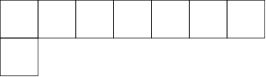

Tensor multiplicand 2:



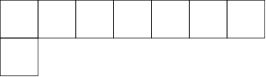

Tensor constituent(s):



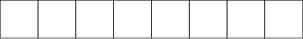


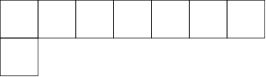


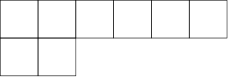


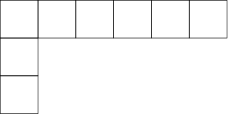

Tensor multiplicand 1:



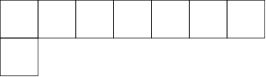

Tensor multiplicand 2:



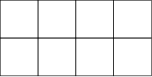

Tensor constituent(s):



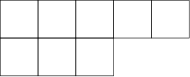


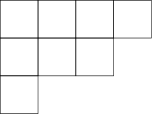

Tensor multiplicand 1:



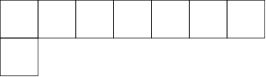

Tensor multiplicand 2:



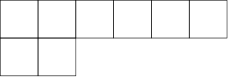

Tensor constituent(s):



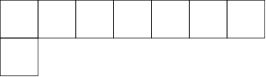


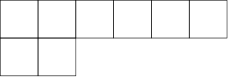


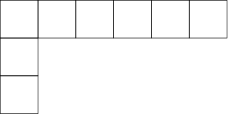


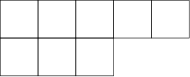


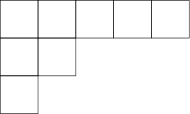

Tensor multiplicand 1:



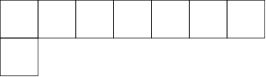

Tensor multiplicand 2:



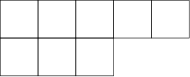

Tensor constituent(s):



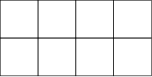


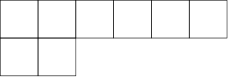


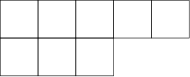


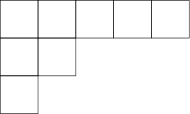


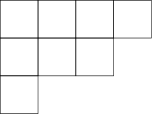

Tensor multiplicand 1:



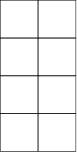

Tensor multiplicand 2:



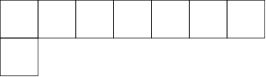

Tensor constituent(s):



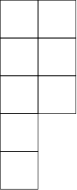


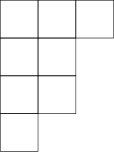

Tensor multiplicand 1:



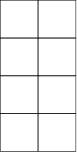

Tensor multiplicand 2:



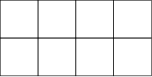

Tensor constituent(s):



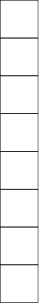


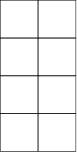


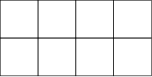


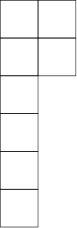


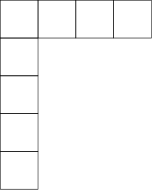


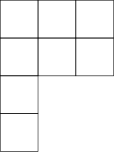


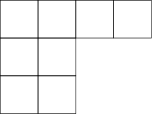

Tensor multiplicand 1:



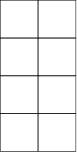

Tensor multiplicand 2:



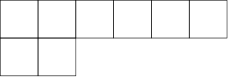

Tensor constituent(s):



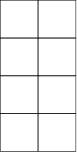


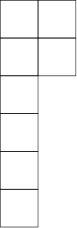


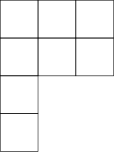


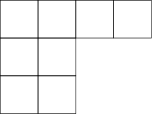


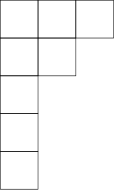


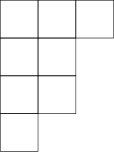

Tensor multiplicand 1:



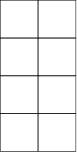

Tensor multiplicand 2:



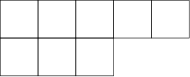

Tensor constituent(s):



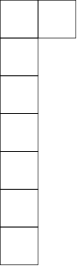


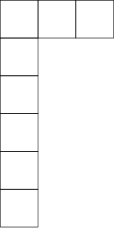


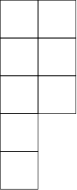


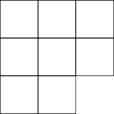


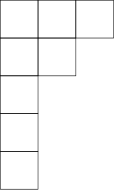


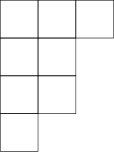


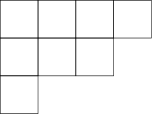


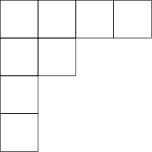

Tensor multiplicand 1:



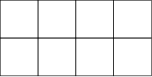

Tensor multiplicand 2:



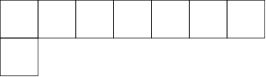

Tensor constituent(s):



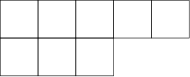


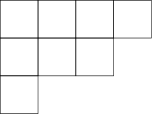

Tensor multiplicand 1:



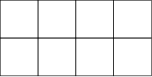

Tensor multiplicand 2:



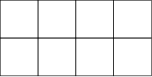

Tensor constituent(s):



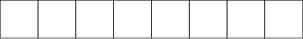


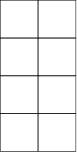


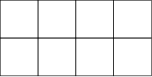


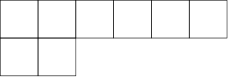


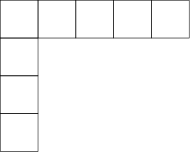


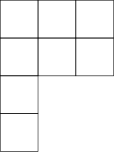


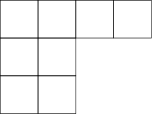

Tensor multiplicand 1:



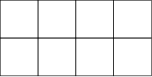

Tensor multiplicand 2:



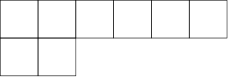

Tensor constituent(s):



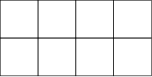


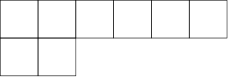


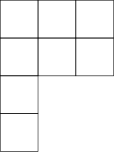


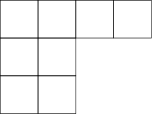


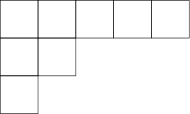


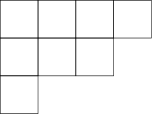

Tensor multiplicand 1:



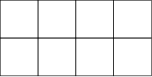

Tensor multiplicand 2:



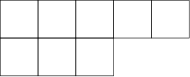

Tensor constituent(s):



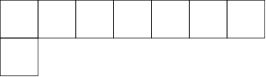


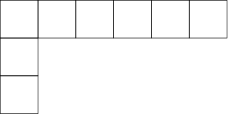


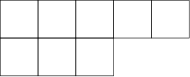


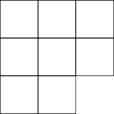


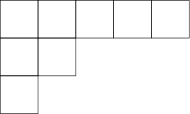


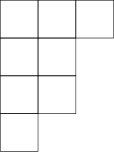


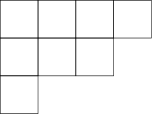


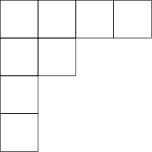

Tensor multiplicand 1:



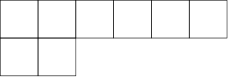

Tensor multiplicand 2:



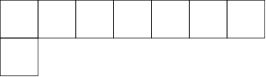

Tensor constituent(s):



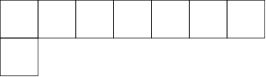


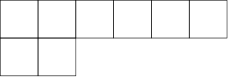


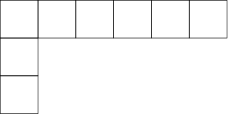


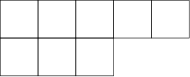


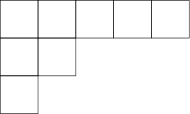

Tensor multiplicand 1:



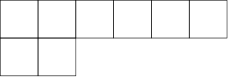

Tensor multiplicand 2:



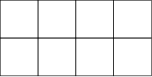

Tensor constituent(s):



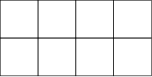


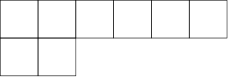


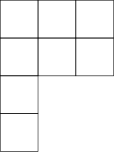


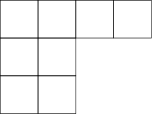


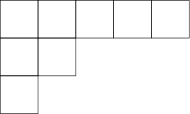


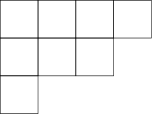

Tensor multiplicand 1:



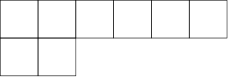

Tensor multiplicand 2:



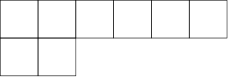

Tensor constituent(s):



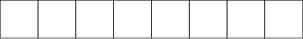


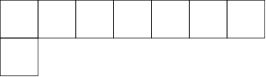


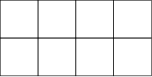


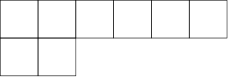


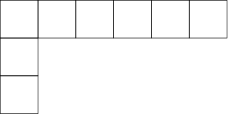


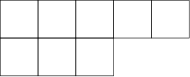


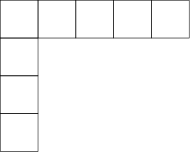


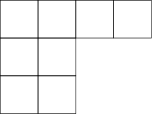


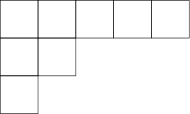


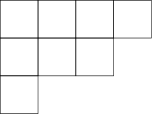

Tensor multiplicand 1:



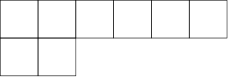

Tensor multiplicand 2:



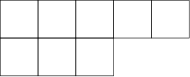

Tensor constituent(s):



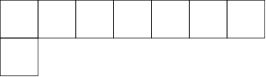


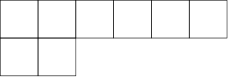


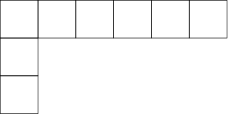


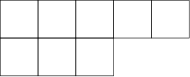


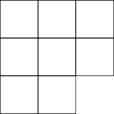


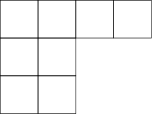


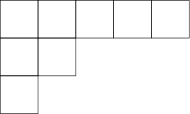


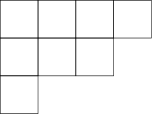


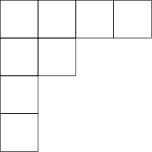

Tensor multiplicand 1:



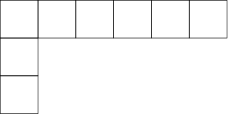

Tensor multiplicand 2:



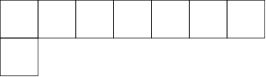

Tensor constituent(s):



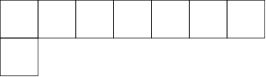


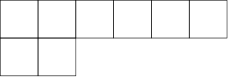


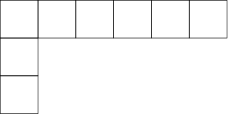


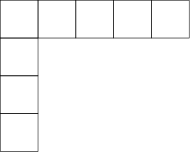


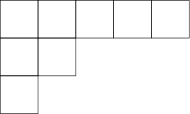

Tensor multiplicand 1:



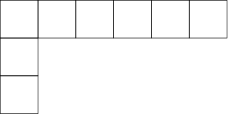

Tensor multiplicand 2:



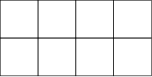

Tensor constituent(s):



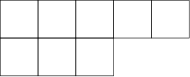


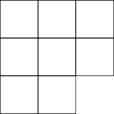


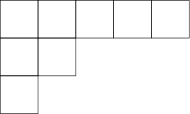


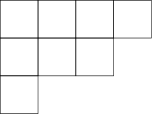


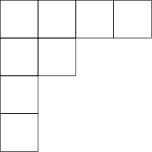

Tensor multiplicand 1:



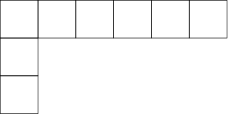

Tensor multiplicand 2:



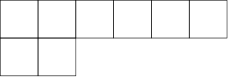

Tensor constituent(s):



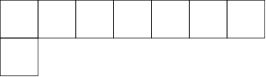


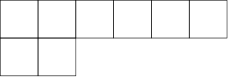


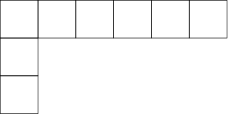


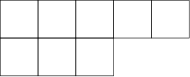


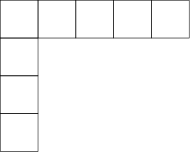


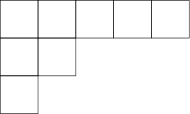


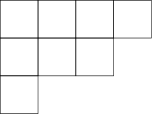


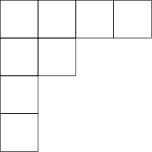

Tensor multiplicand 1:



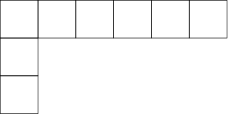

Tensor multiplicand 2:



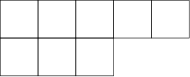

Tensor constituent(s):



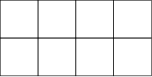


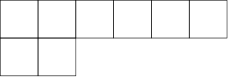


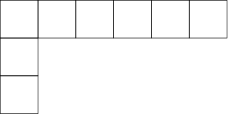


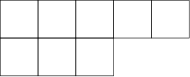


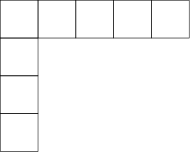


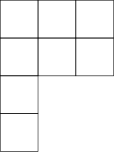


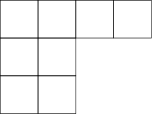


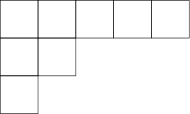


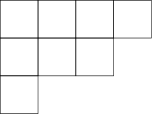


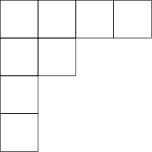

Tensor multiplicand 1:



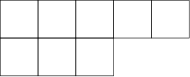

Tensor multiplicand 2:



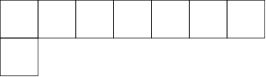

Tensor constituent(s):



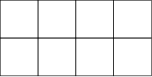


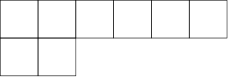


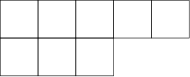


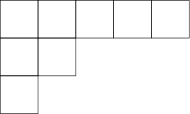


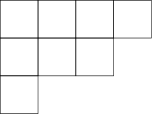

Tensor multiplicand 1:



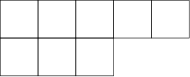

Tensor multiplicand 2:



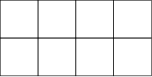

Tensor constituent(s):



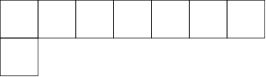


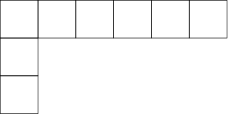


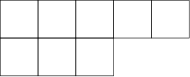


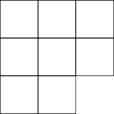


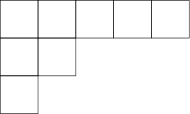


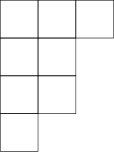


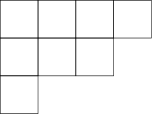


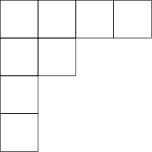

Tensor multiplicand 1:



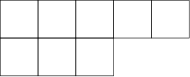

Tensor multiplicand 2:



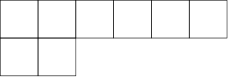

Tensor constituent(s):



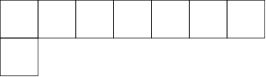


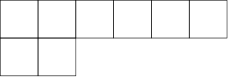


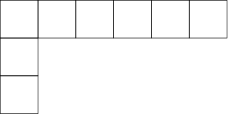


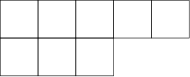


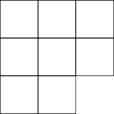


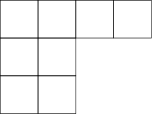


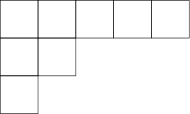


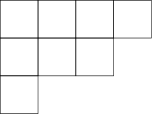


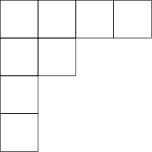

Tensor multiplicand 1:



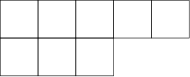

Tensor multiplicand 2:



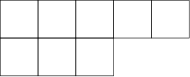

Tensor constituent(s):



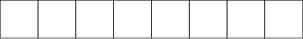


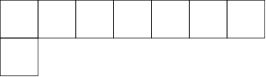


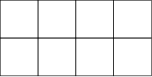


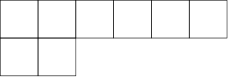


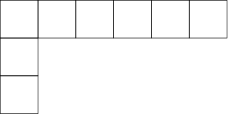


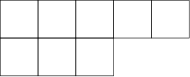


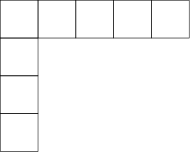


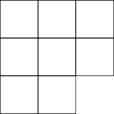


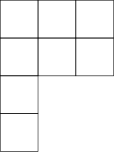


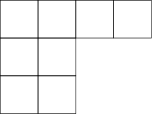


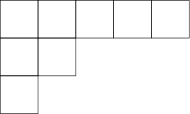


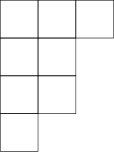


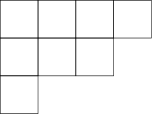


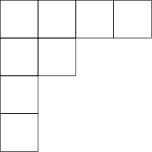

Tensor multiplicand 1:



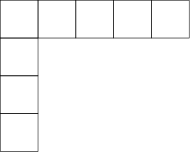

Tensor multiplicand 2:



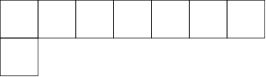

Tensor constituent(s):



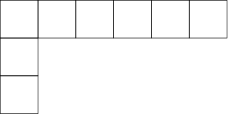


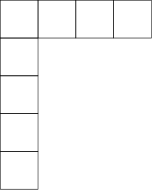


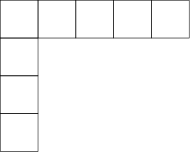


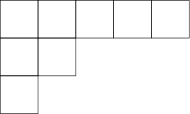


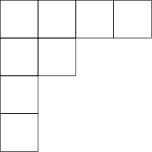

Tensor multiplicand 1:



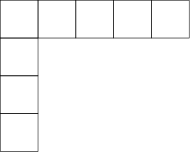

Tensor multiplicand 2:



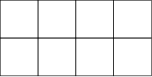

Tensor constituent(s):



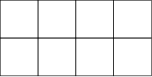


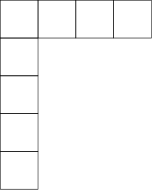


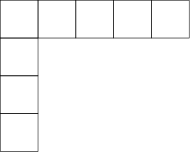


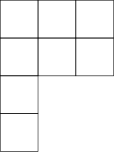


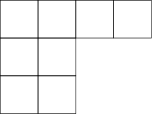


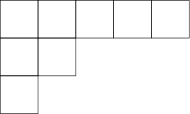


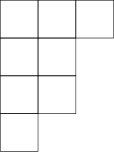


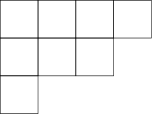


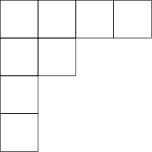

Tensor multiplicand 1:



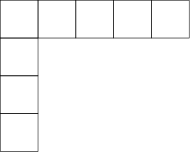

Tensor multiplicand 2:



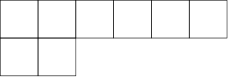

Tensor constituent(s):



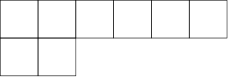


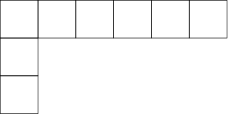


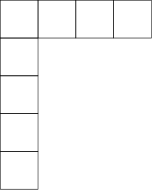


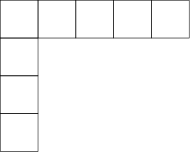


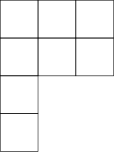


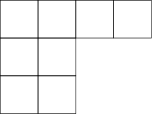


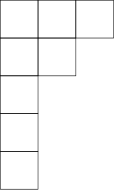


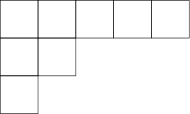


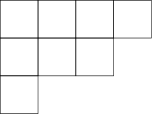


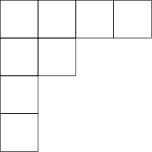

Tensor multiplicand 1:



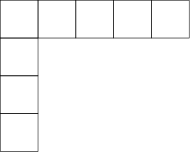

Tensor multiplicand 2:



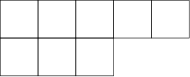

Tensor constituent(s):



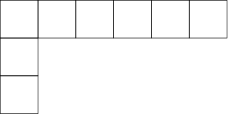


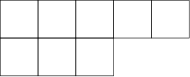


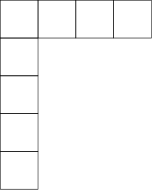


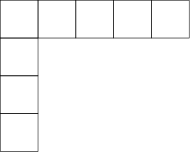


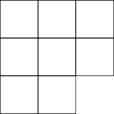


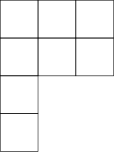


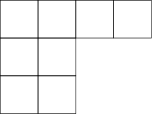


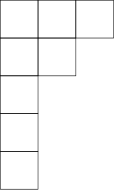


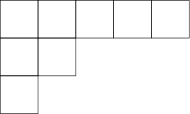


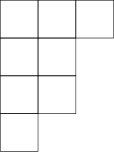


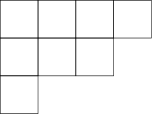


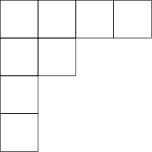

Tensor multiplicand 1:



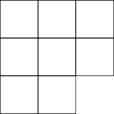

Tensor multiplicand 2:



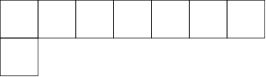

Tensor constituent(s):



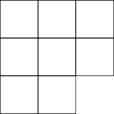


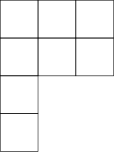


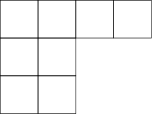


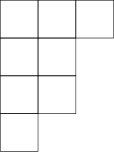


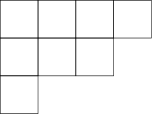

Tensor multiplicand 1:



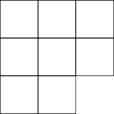

Tensor multiplicand 2:



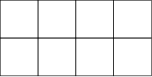

Tensor constituent(s):



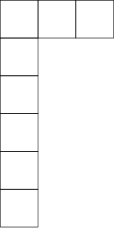


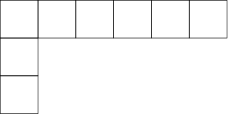


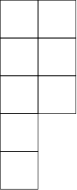


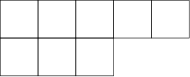


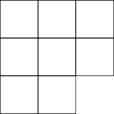


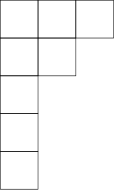


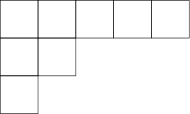


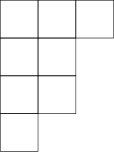


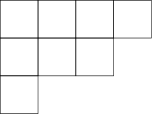


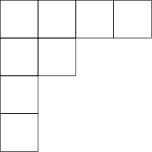

Tensor multiplicand 1:



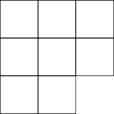

Tensor multiplicand 2:



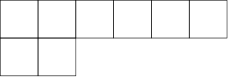

Tensor constituent(s):



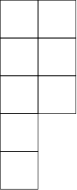


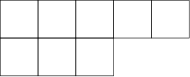


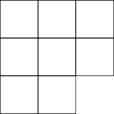


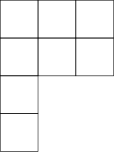


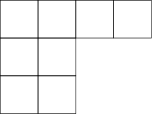


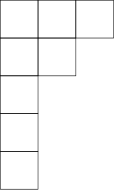


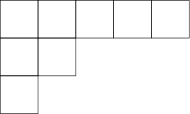


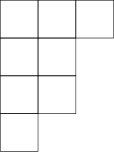


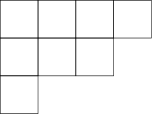


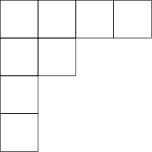

Tensor multiplicand 1:



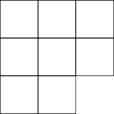

Tensor multiplicand 2:



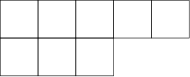

Tensor constituent(s):



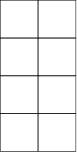


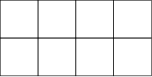


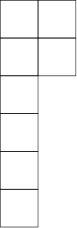


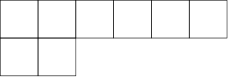


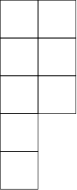


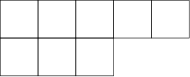


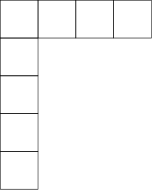


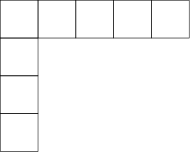


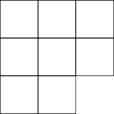


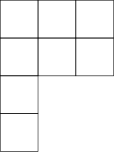


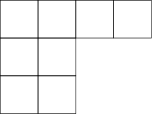


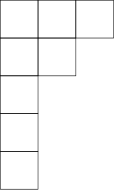


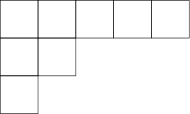


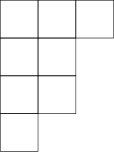


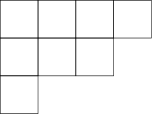


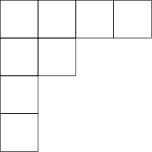

Tensor multiplicand 1:



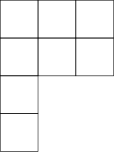

Tensor multiplicand 2:



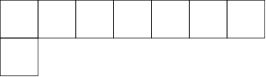

Tensor constituent(s):



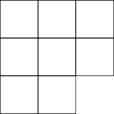


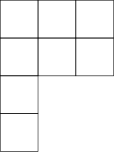


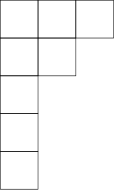


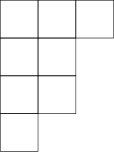


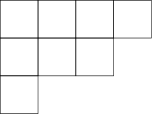


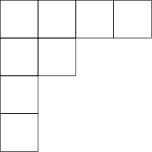

Tensor multiplicand 1:



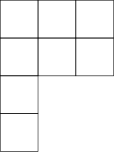

Tensor multiplicand 2:



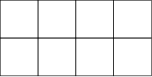

Tensor constituent(s):



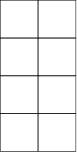


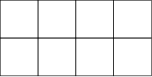


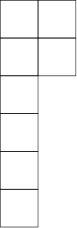


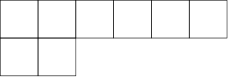


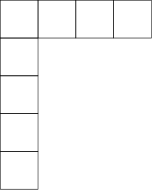


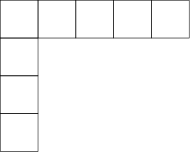


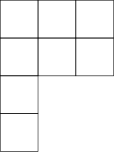


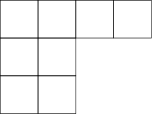


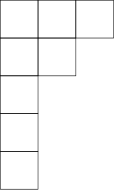


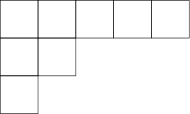


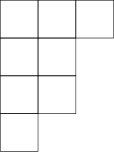


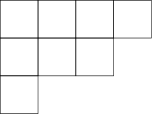


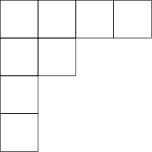

Tensor multiplicand 1:



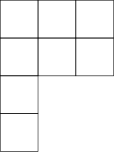

Tensor multiplicand 2:



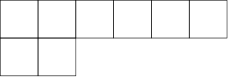

Tensor constituent(s):



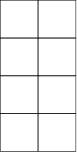


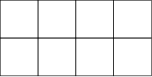


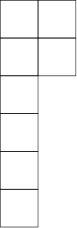


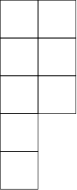


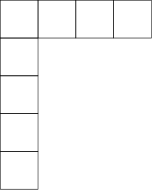


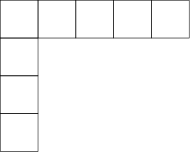


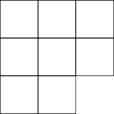


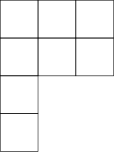


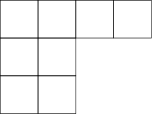


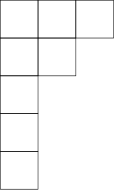


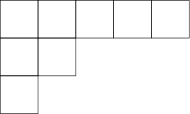


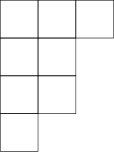


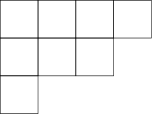


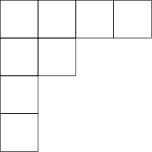

Tensor multiplicand 1:



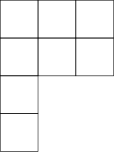

Tensor multiplicand 2:



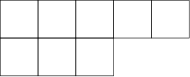

Tensor constituent(s):



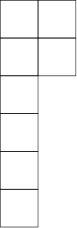


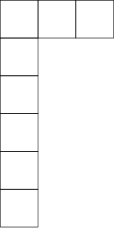


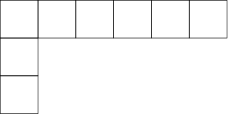


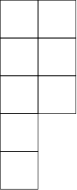


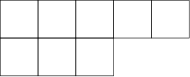


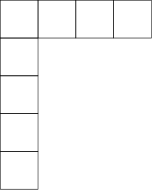


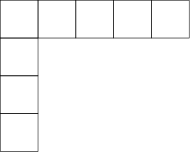


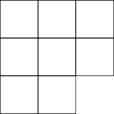


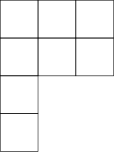


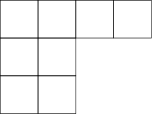


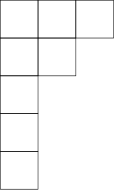


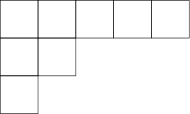


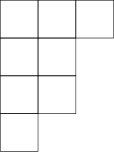


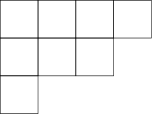


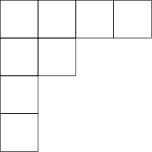

Tensor multiplicand 1:



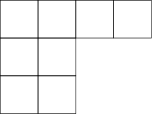

Tensor multiplicand 2:



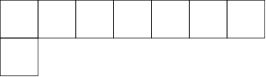

Tensor constituent(s):



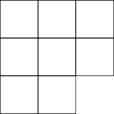


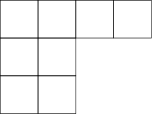


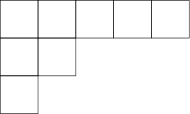


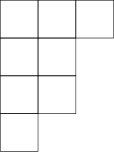


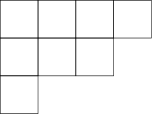


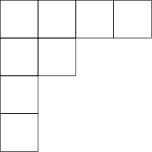

Tensor multiplicand 1:



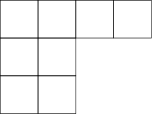

Tensor multiplicand 2:



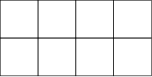

Tensor constituent(s):



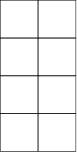


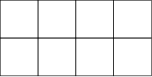


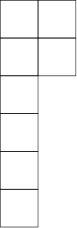


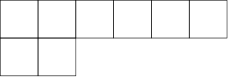


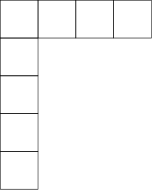


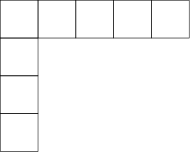


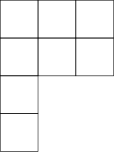


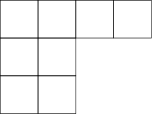


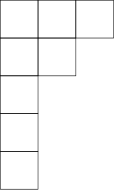


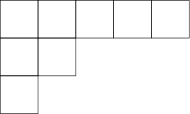


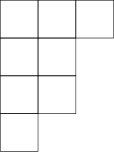


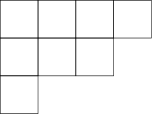


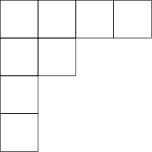

Tensor multiplicand 1:



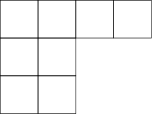

Tensor multiplicand 2:



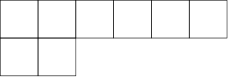

Tensor constituent(s):



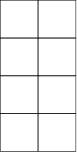


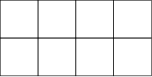


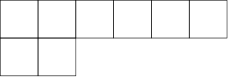


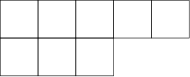


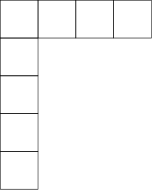


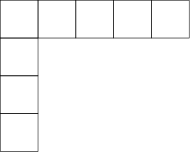


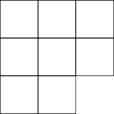


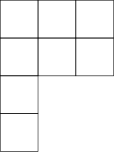


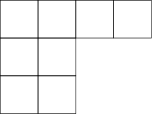


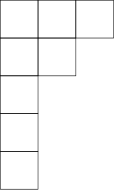


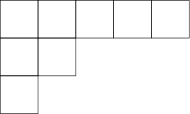


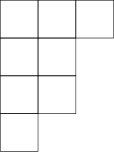


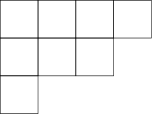


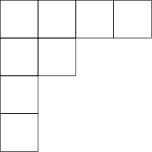

Tensor multiplicand 1:



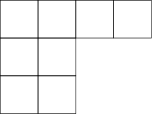

Tensor multiplicand 2:



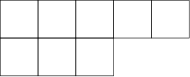

Tensor constituent(s):



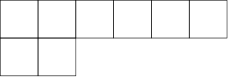


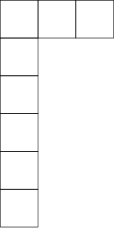


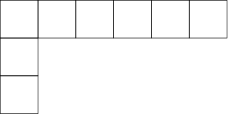


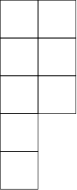


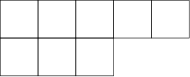


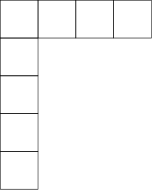


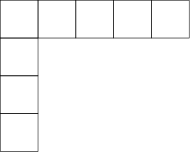


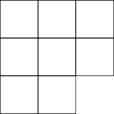


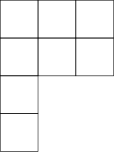


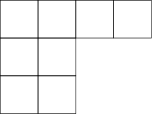


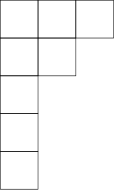


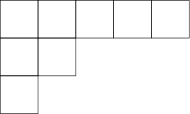


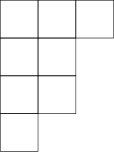


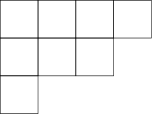


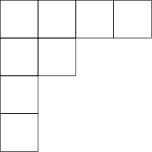

Tensor multiplicand 1:



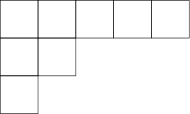

Tensor multiplicand 2:



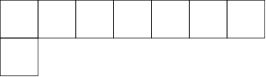

Tensor constituent(s):



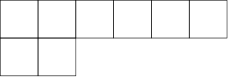


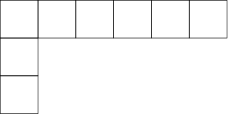


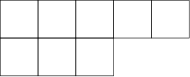


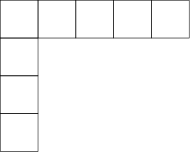


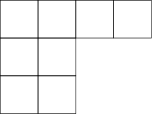


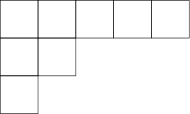


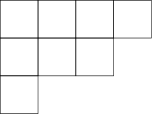


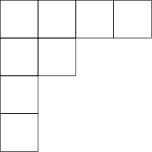

Tensor multiplicand 1:



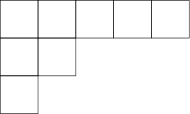

Tensor multiplicand 2:



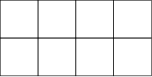

Tensor constituent(s):



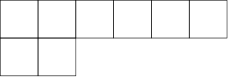


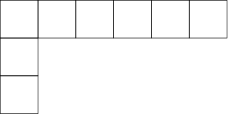


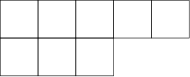


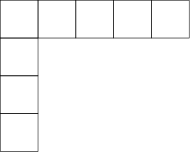


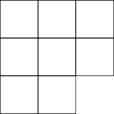


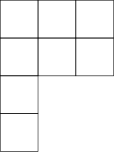


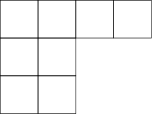


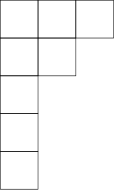


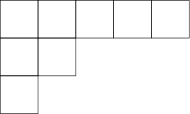


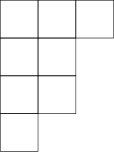


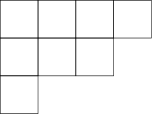


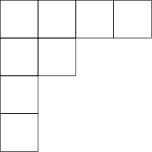

Tensor multiplicand 1:



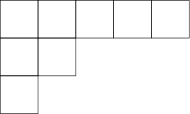

Tensor multiplicand 2:



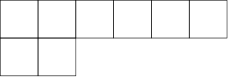

Tensor constituent(s):



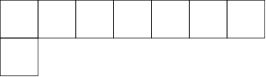


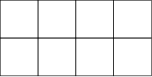


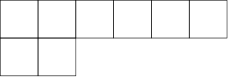


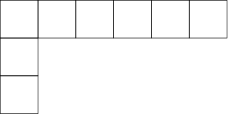


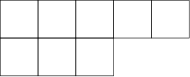


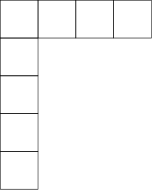


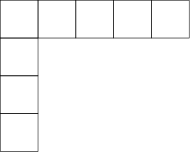


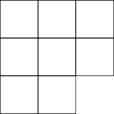


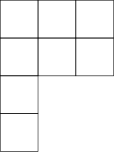


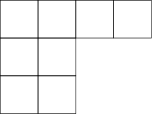


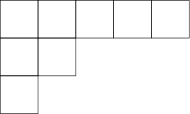


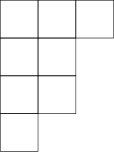


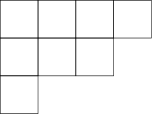


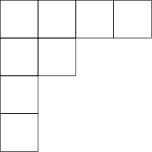

Tensor multiplicand 1:



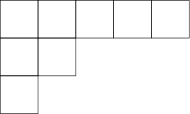

Tensor multiplicand 2:



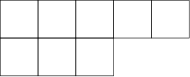

Tensor constituent(s):



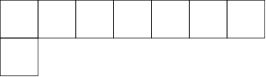


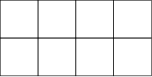


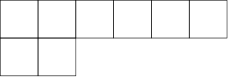


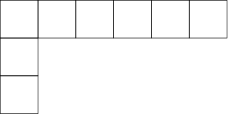


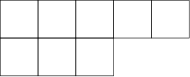


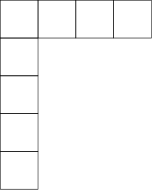


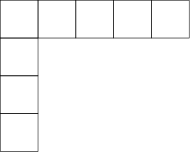


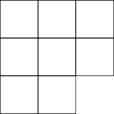


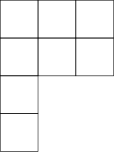


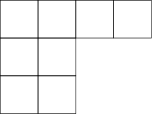


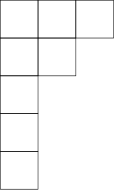


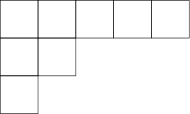


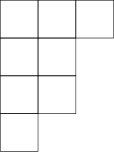


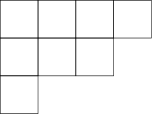


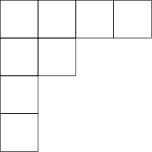

Tensor multiplicand 1:



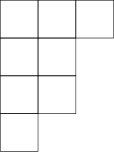

Tensor multiplicand 2:



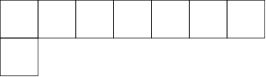

Tensor constituent(s):



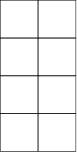


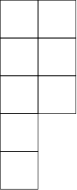


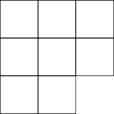


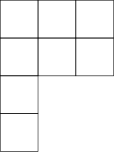


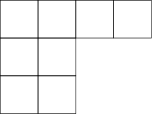


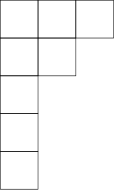


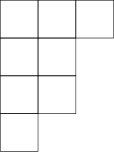


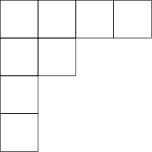

Tensor multiplicand 1:



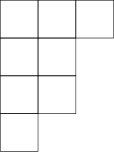

Tensor multiplicand 2:



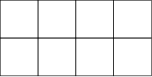

Tensor constituent(s):



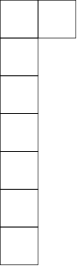


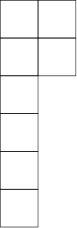


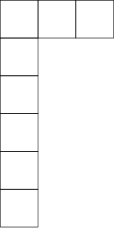


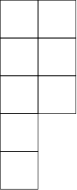


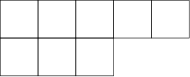


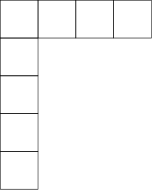


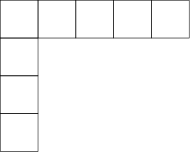


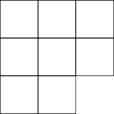


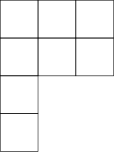


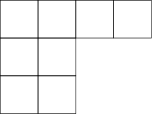


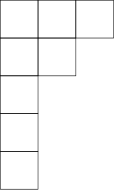


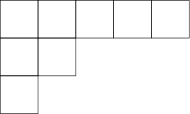


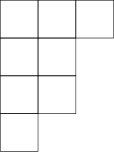


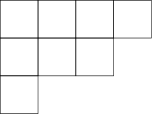


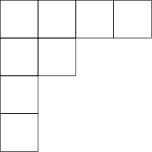

Tensor multiplicand 1:



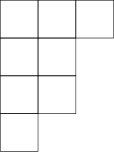

Tensor multiplicand 2:



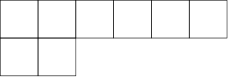

Tensor constituent(s):



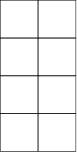


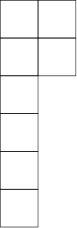


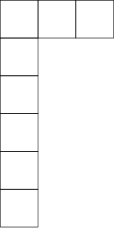


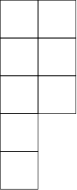


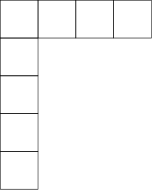


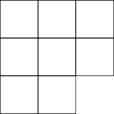


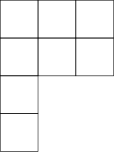


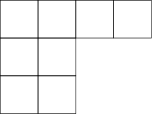


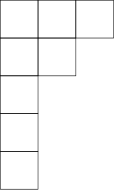


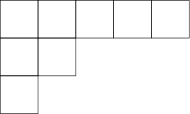


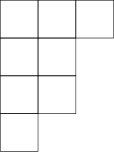


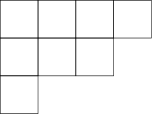


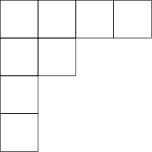

Tensor multiplicand 1:



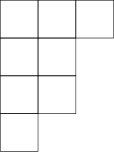

Tensor multiplicand 2:



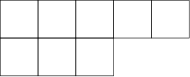

Tensor constituent(s):



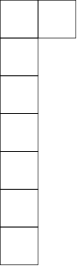


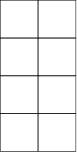


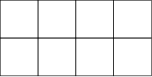


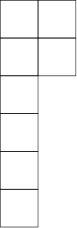


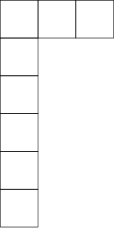


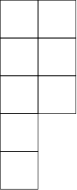


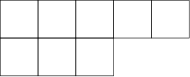


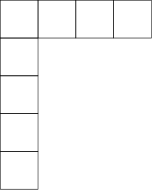


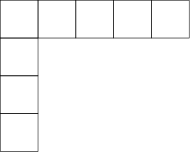


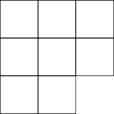


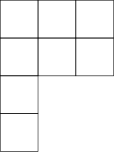


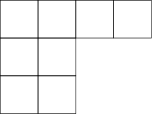


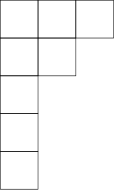


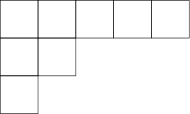


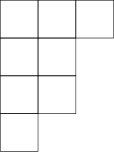


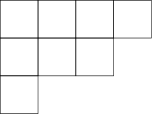


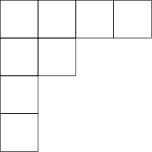

Tensor multiplicand 1:



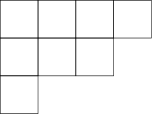

Tensor multiplicand 2:



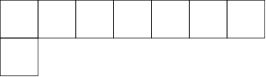

Tensor constituent(s):



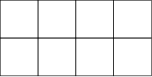


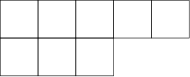


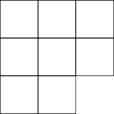


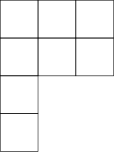


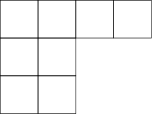


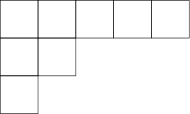


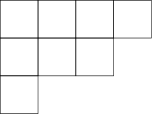


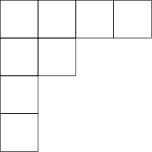

Tensor multiplicand 1:



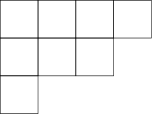

Tensor multiplicand 2:



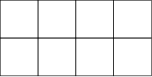

Tensor constituent(s):



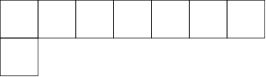


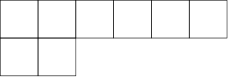


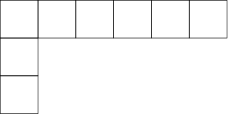


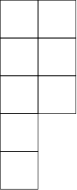


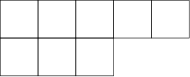


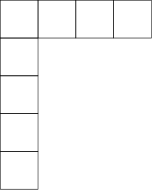


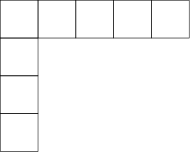


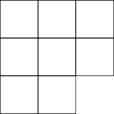


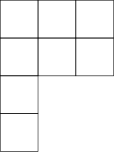


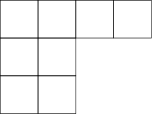


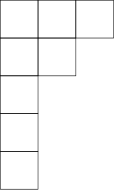


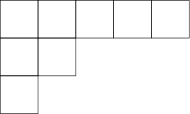


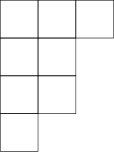


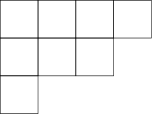


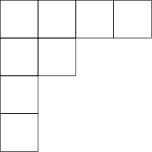

Tensor multiplicand 1:



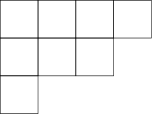

Tensor multiplicand 2:



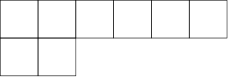

Tensor constituent(s):



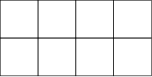


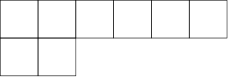


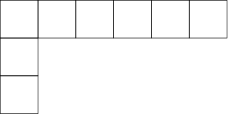


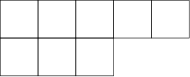


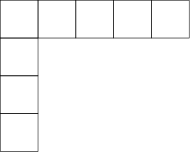


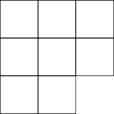


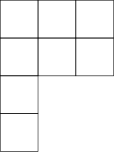


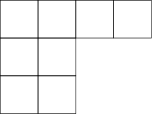


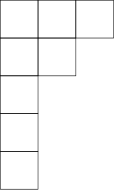


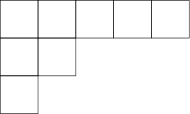


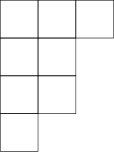


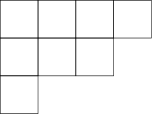


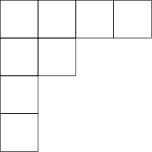

Tensor multiplicand 1:



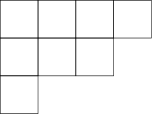

Tensor multiplicand 2:



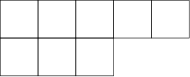

Tensor constituent(s):



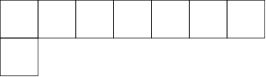


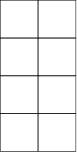


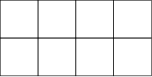


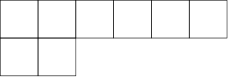


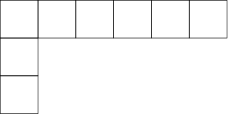


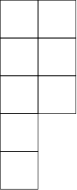


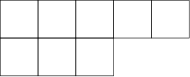


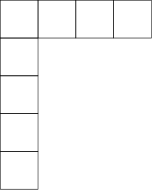


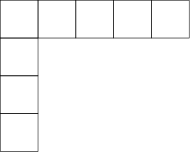


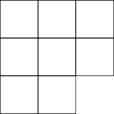


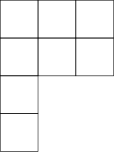


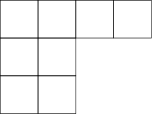


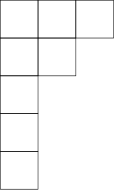


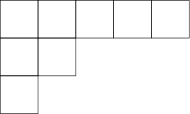


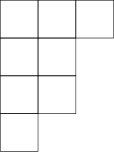


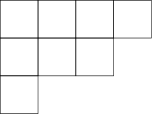


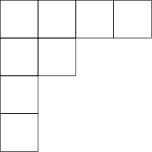

Tensor multiplicand 1:



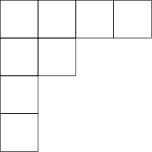

Tensor multiplicand 2:



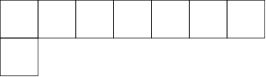

Tensor constituent(s):



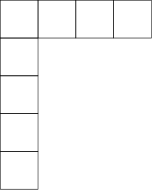


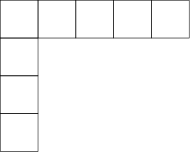


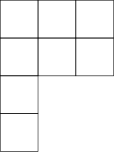


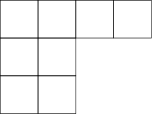


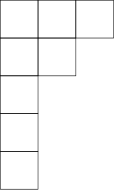


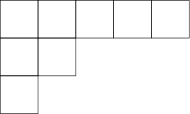


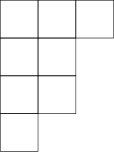


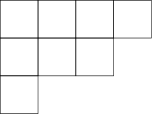


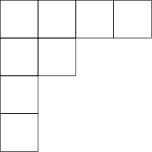

Tensor multiplicand 1:



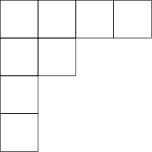

Tensor multiplicand 2:



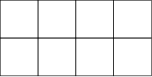

Tensor constituent(s):



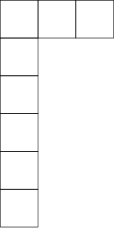


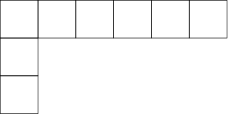


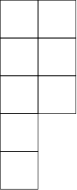


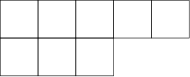


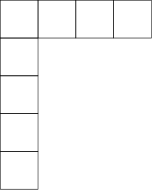


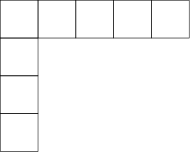


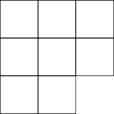


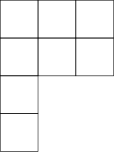


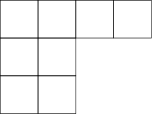


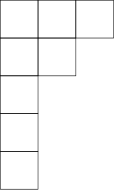


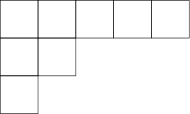


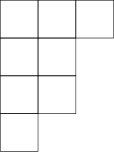


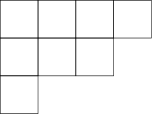


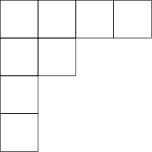

Tensor multiplicand 1:



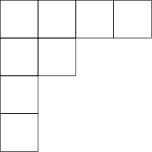

Tensor multiplicand 2:



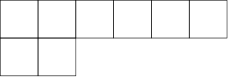

Tensor constituent(s):



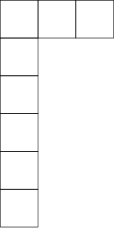


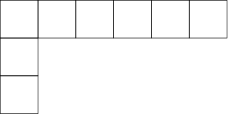


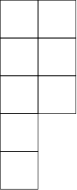


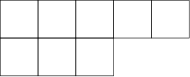


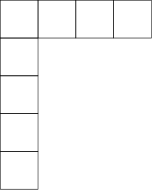


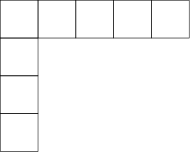


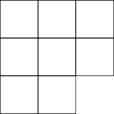


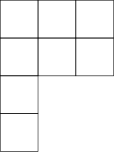


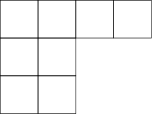


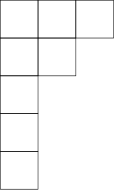


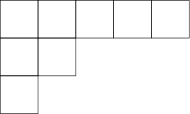


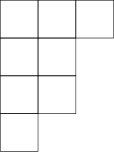


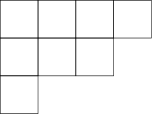


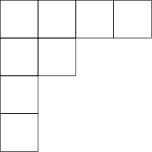

Tensor multiplicand 1:



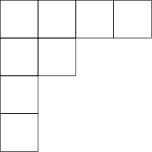

Tensor multiplicand 2:



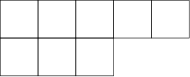

Tensor constituent(s):



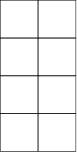


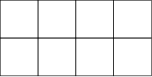


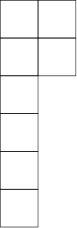


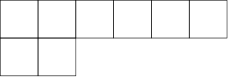


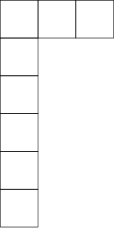


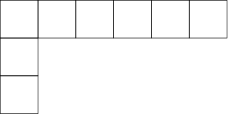


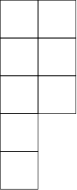


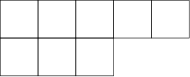


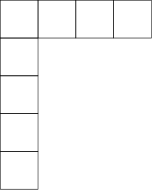


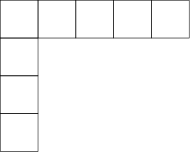


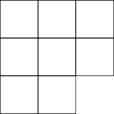


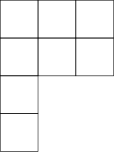


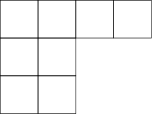


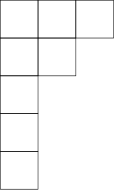


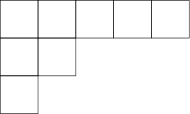


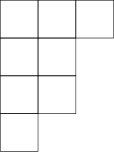


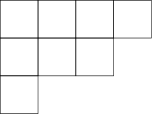


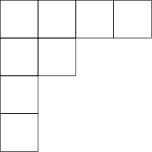

In [62]:
render_tensor_decompositions_individual("SnSubsets4TensorPairs2.csv", "Tensor Pairs", 8)

Tensor Pairs
Tensor multiplicand 1:



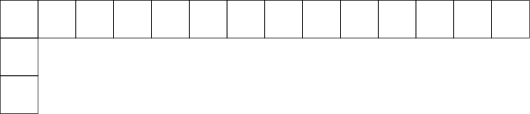

Tensor multiplicand 2:



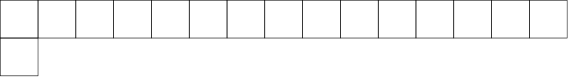

Tensor constituent(s):



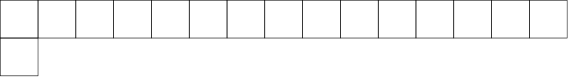


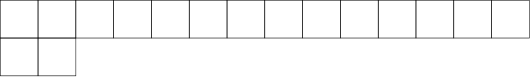


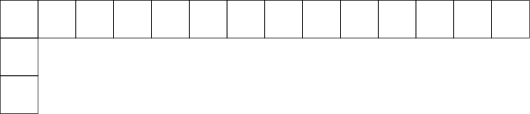


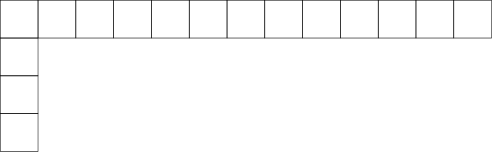


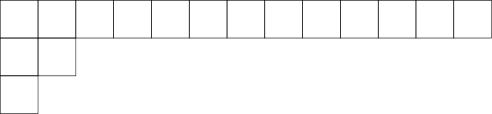

Tensor multiplicand 1:



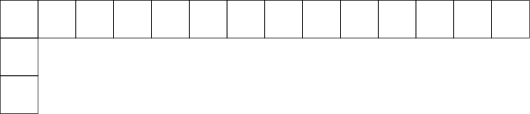

Tensor multiplicand 2:



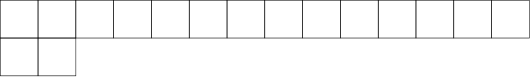

Tensor constituent(s):



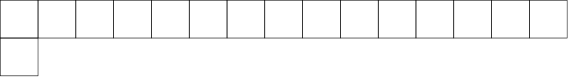


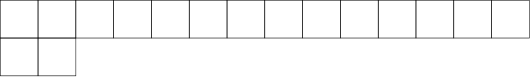


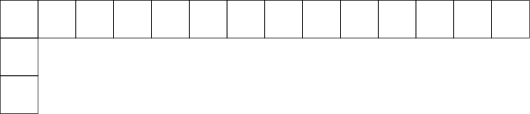


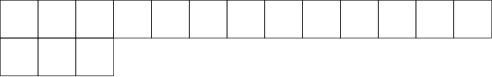


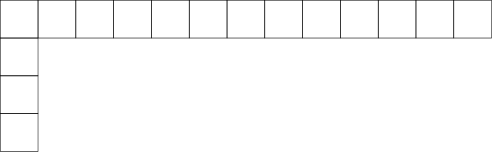


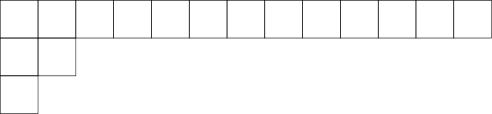


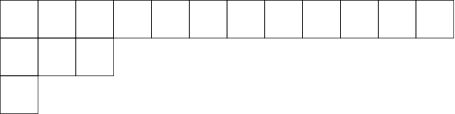


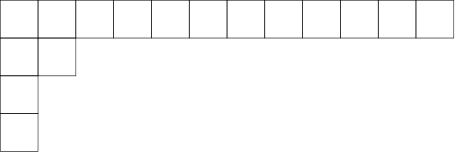

Tensor multiplicand 1:



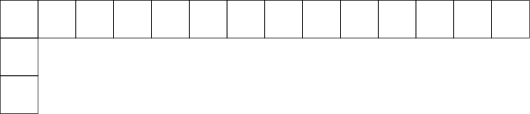

Tensor multiplicand 2:



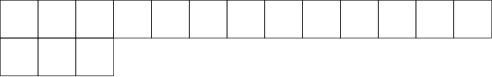

Tensor constituent(s):



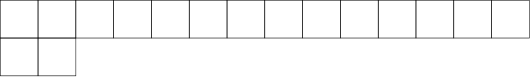


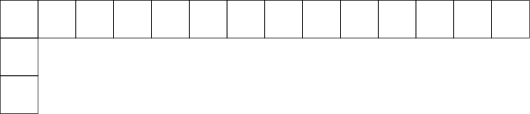


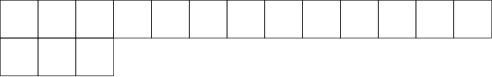


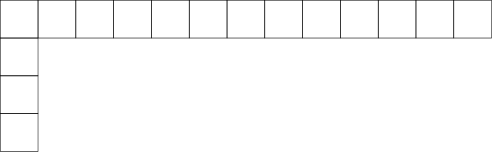


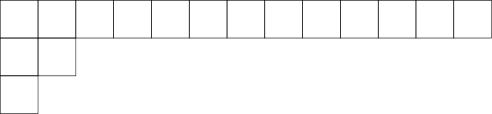


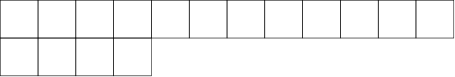


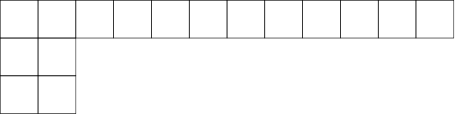


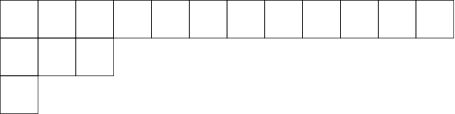


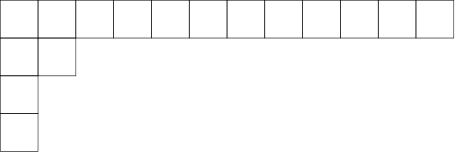


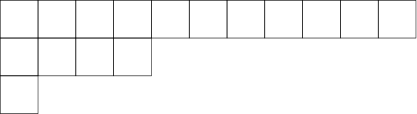


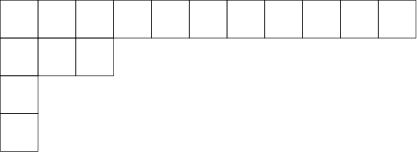

Tensor multiplicand 1:



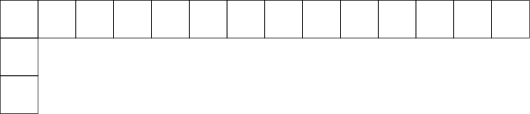

Tensor multiplicand 2:



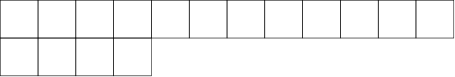

Tensor constituent(s):



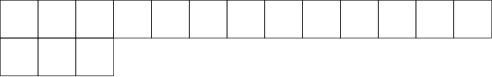


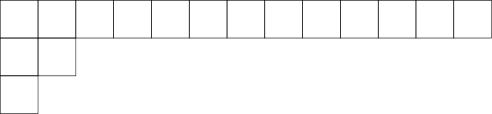


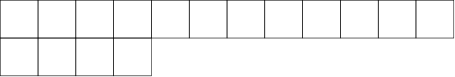


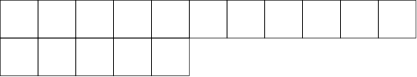


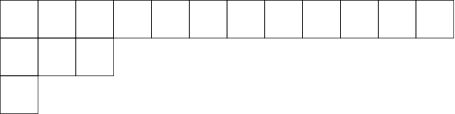


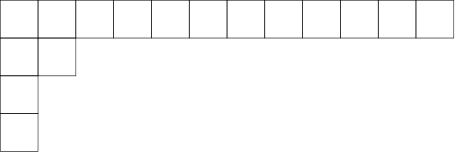


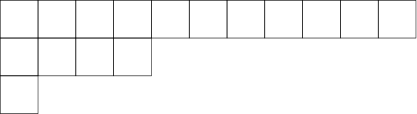


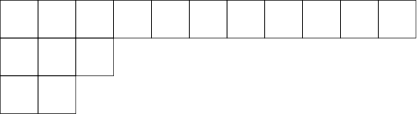


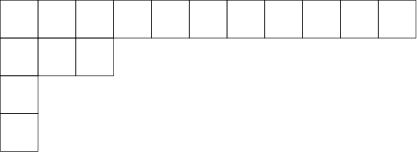


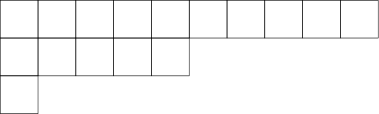


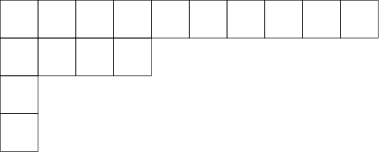

Tensor multiplicand 1:



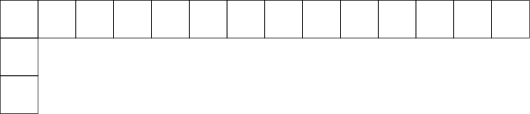

Tensor multiplicand 2:



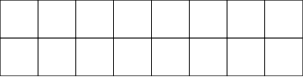

Tensor constituent(s):



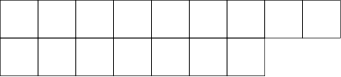


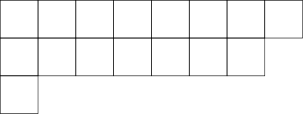


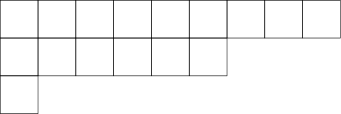


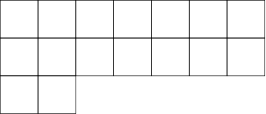


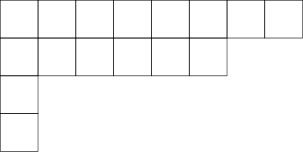

Tensor multiplicand 1:



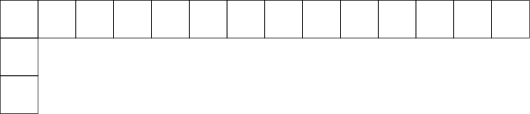

Tensor multiplicand 2:



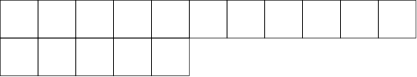

Tensor constituent(s):



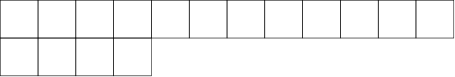


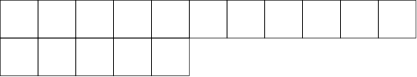


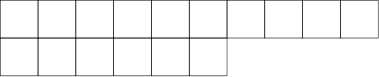


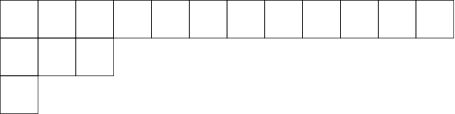


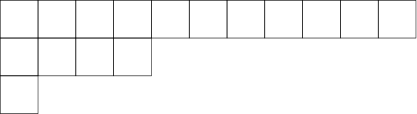


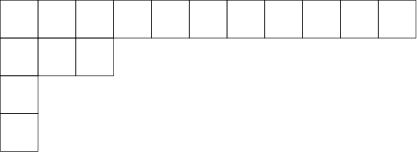


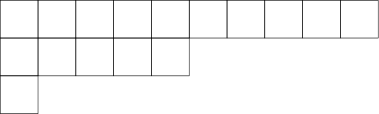


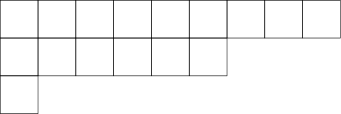


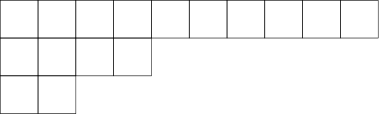


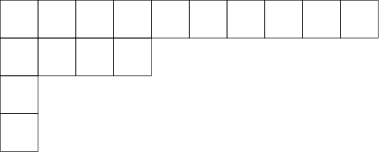


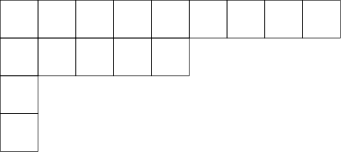

Tensor multiplicand 1:



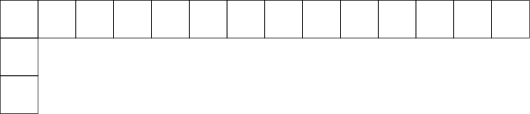

Tensor multiplicand 2:



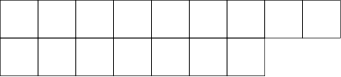

Tensor constituent(s):



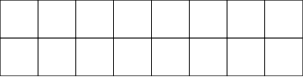


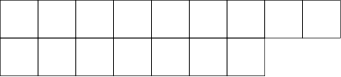


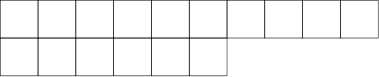


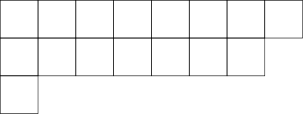


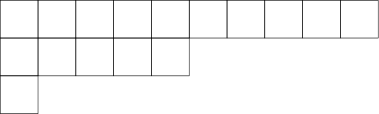


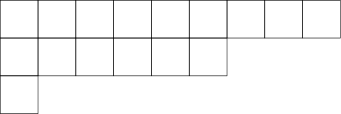


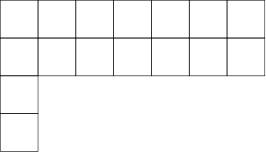


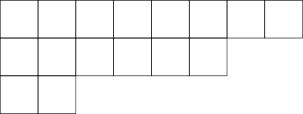


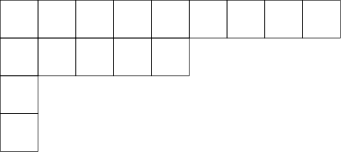


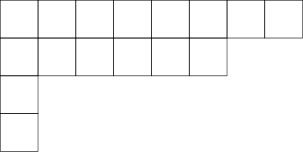

Tensor multiplicand 1:



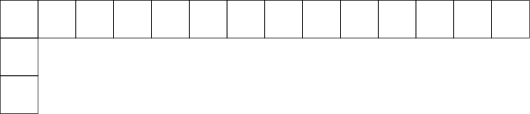

Tensor multiplicand 2:



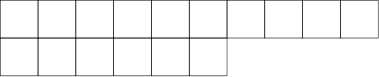

Tensor constituent(s):



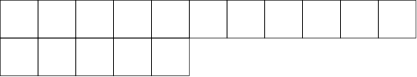


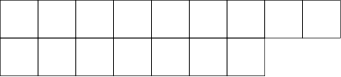


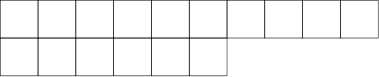


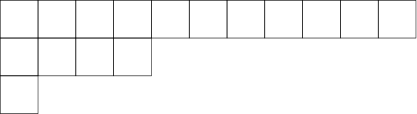


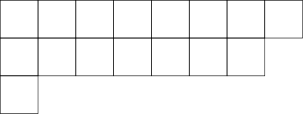


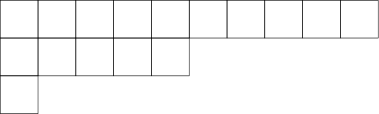


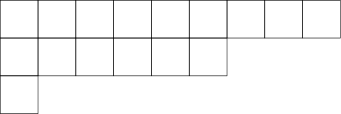


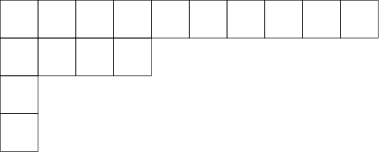


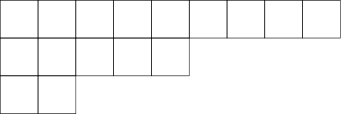


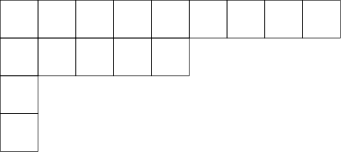


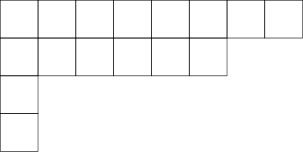

Tensor multiplicand 1:



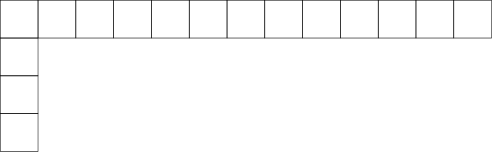

Tensor multiplicand 2:



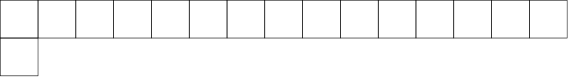

Tensor constituent(s):



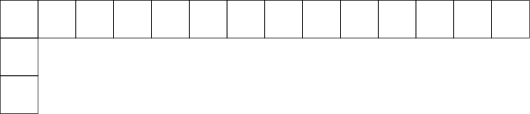


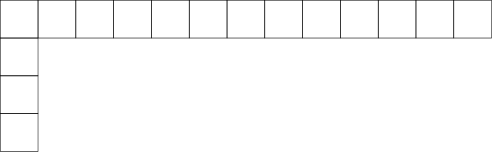


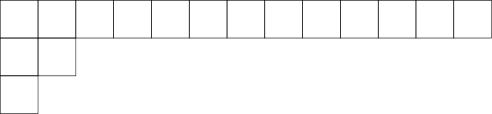


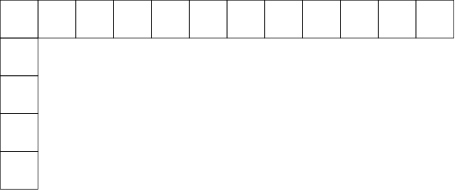


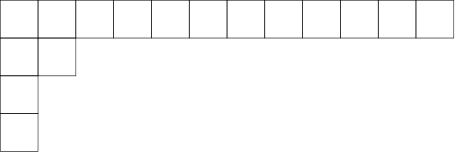

Tensor multiplicand 1:



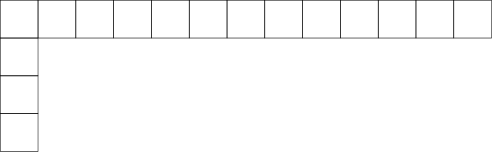

Tensor multiplicand 2:



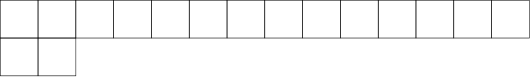

Tensor constituent(s):



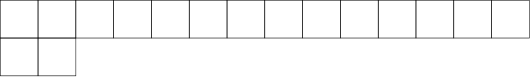


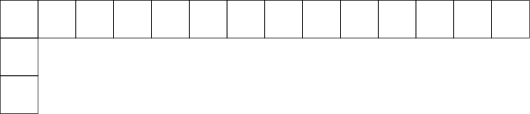


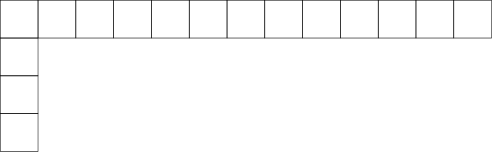


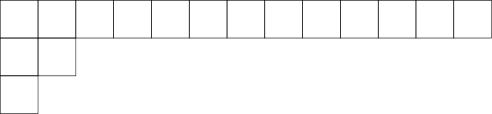


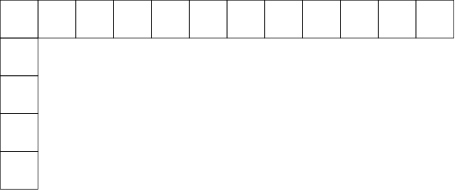


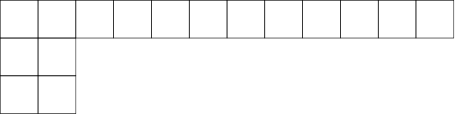


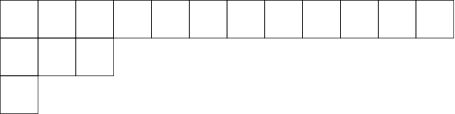


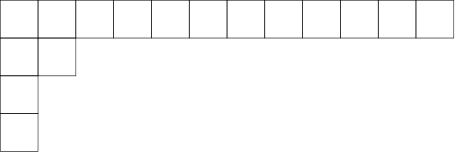


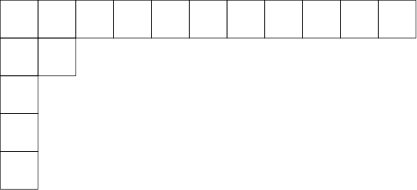


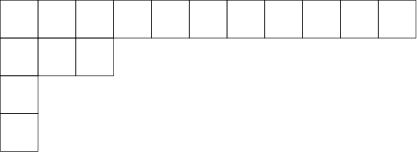

Tensor multiplicand 1:



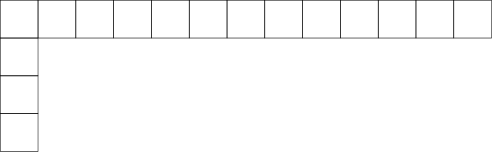

Tensor multiplicand 2:



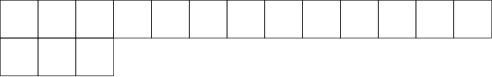

Tensor constituent(s):



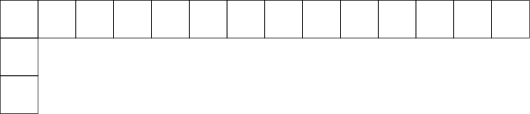


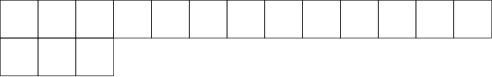


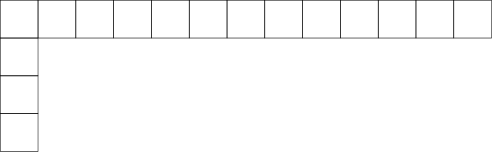


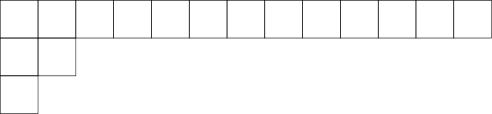


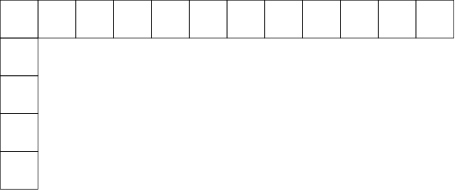


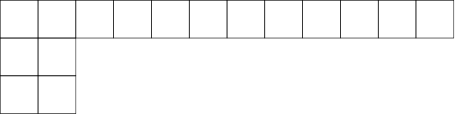


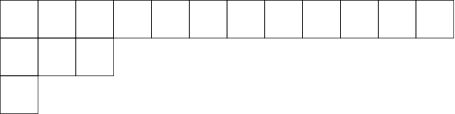


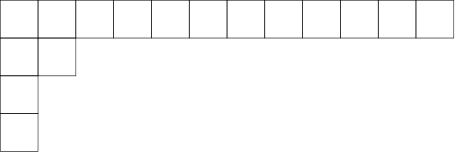


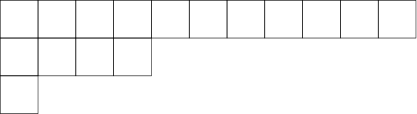


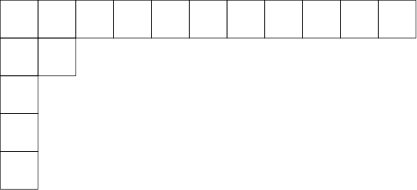


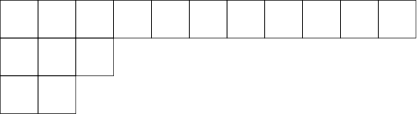


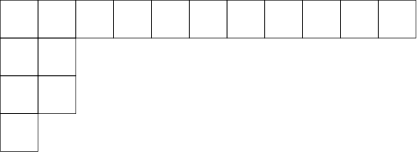


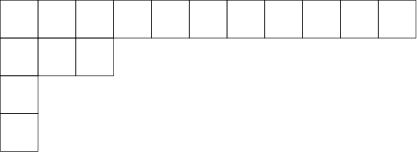


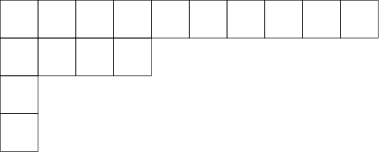


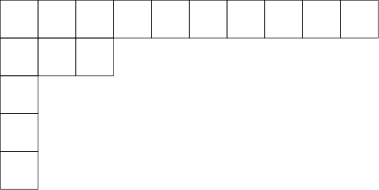

Tensor multiplicand 1:



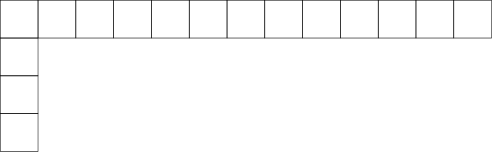

Tensor multiplicand 2:



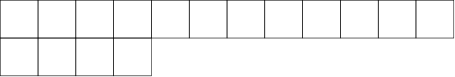

Tensor constituent(s):



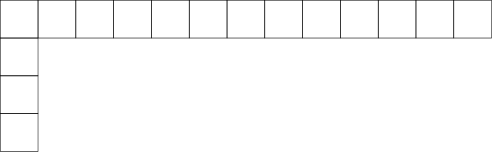


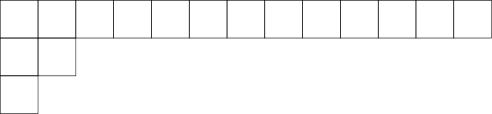


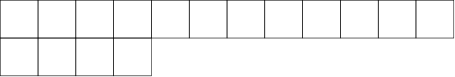


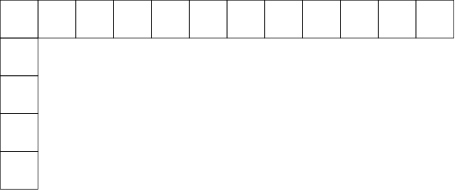


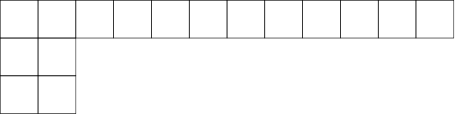


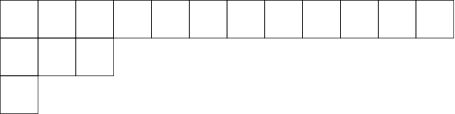


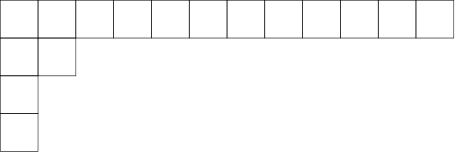


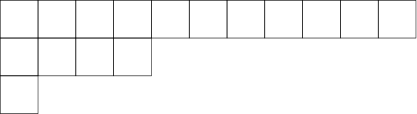


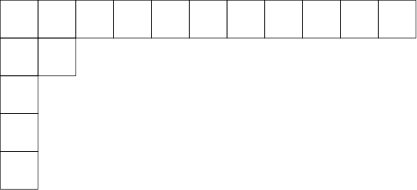


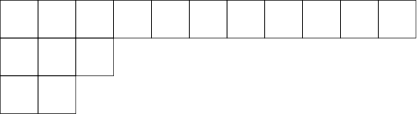


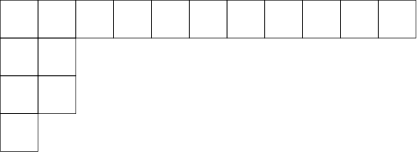


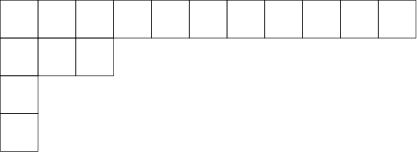


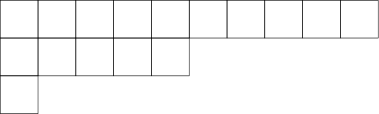


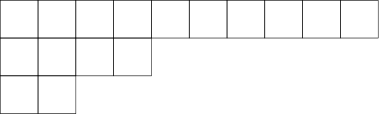


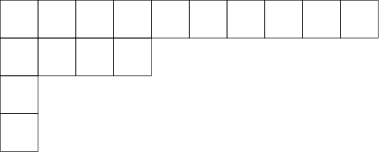


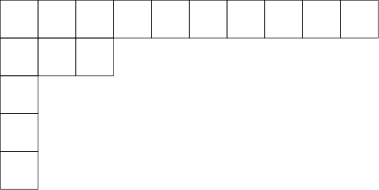


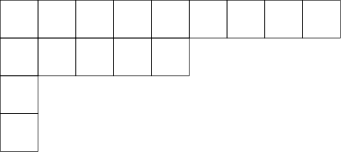


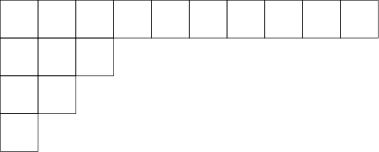


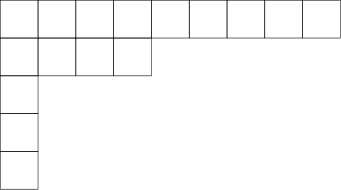

Tensor multiplicand 1:



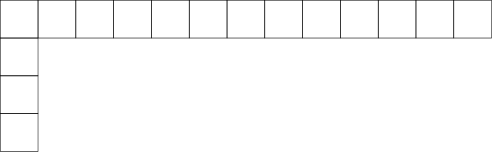

Tensor multiplicand 2:



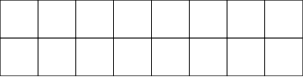

Tensor constituent(s):



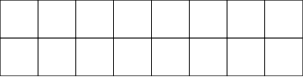


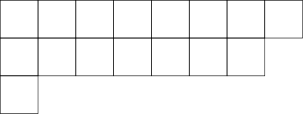


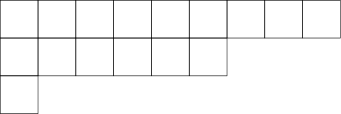


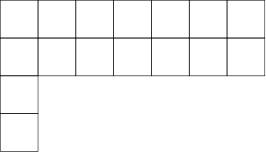


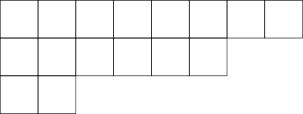


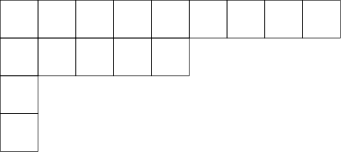


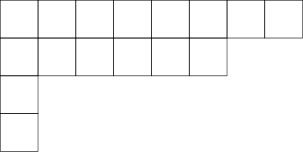


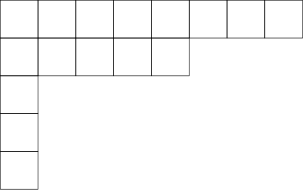


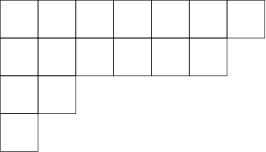

Tensor multiplicand 1:



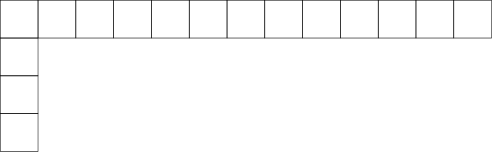

Tensor multiplicand 2:



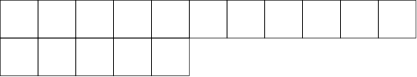

Tensor constituent(s):



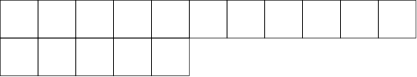


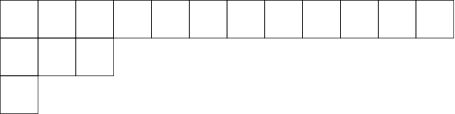


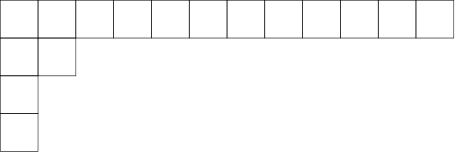


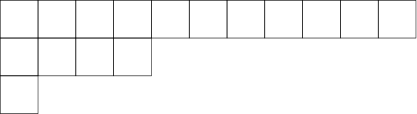


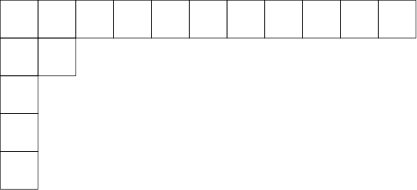


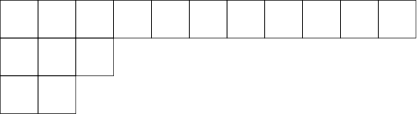


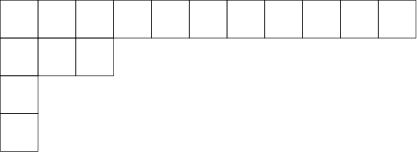


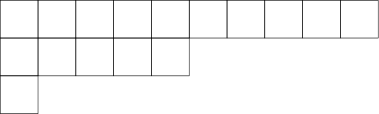


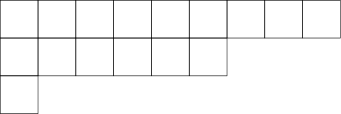


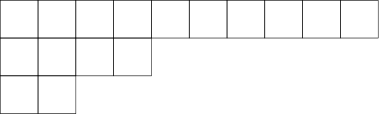


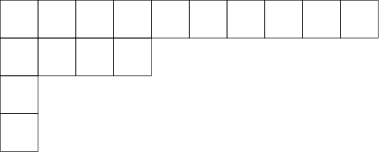


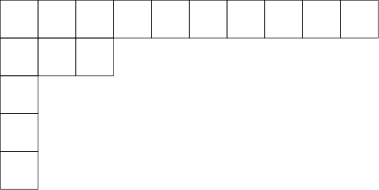


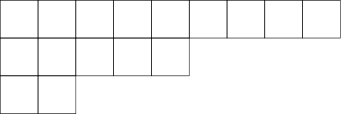


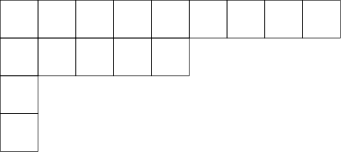


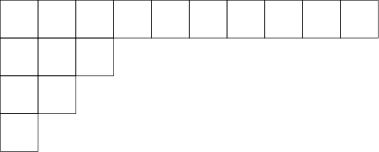


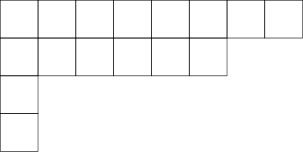


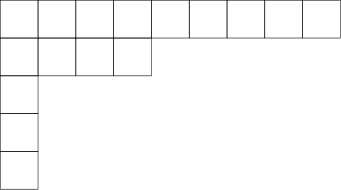


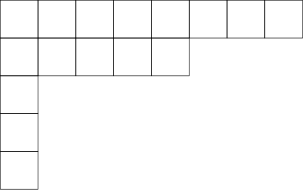


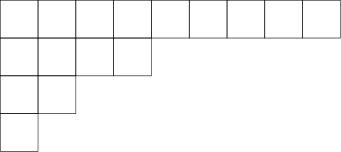

Tensor multiplicand 1:



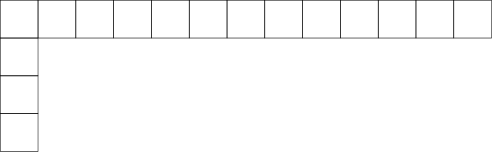

Tensor multiplicand 2:



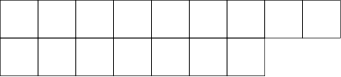

Tensor constituent(s):



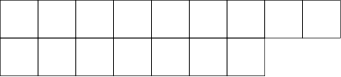


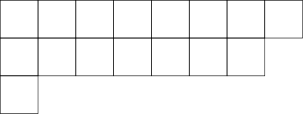


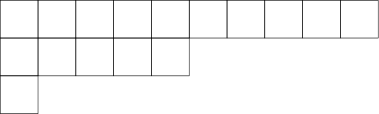


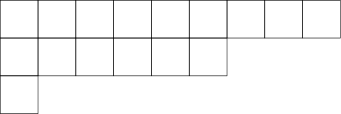


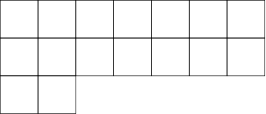


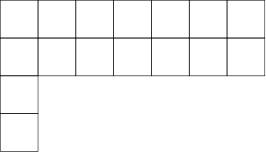


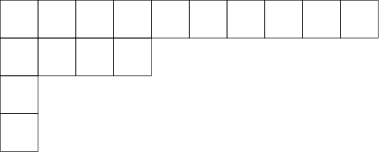


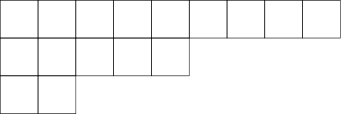


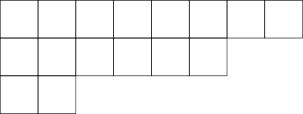


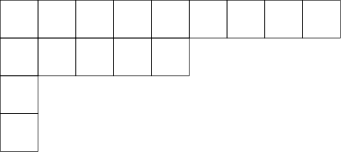


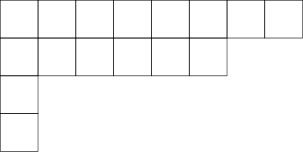


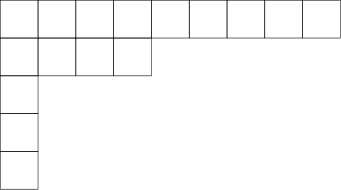


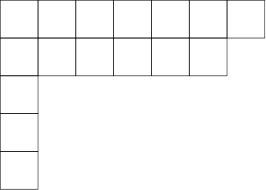


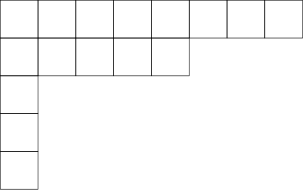


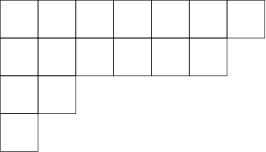


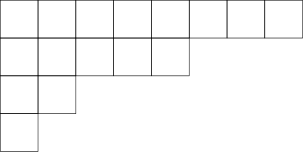

Tensor multiplicand 1:



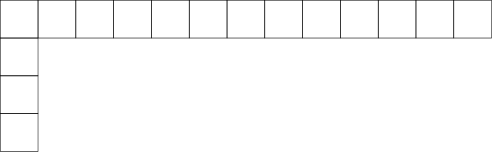

Tensor multiplicand 2:



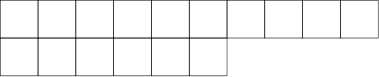

Tensor constituent(s):



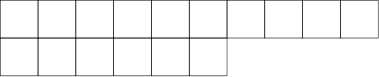


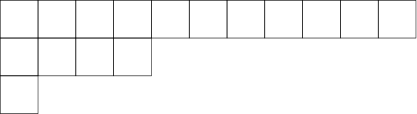


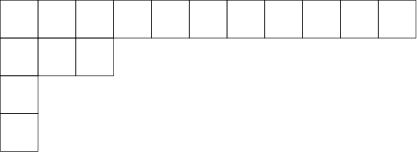


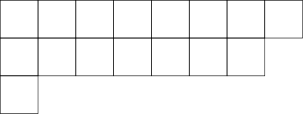


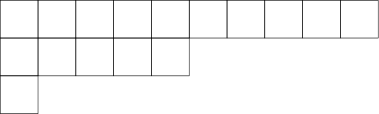


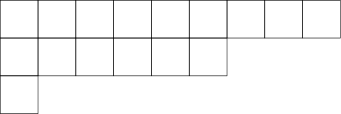


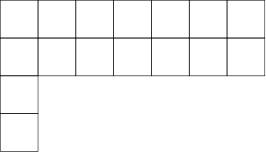


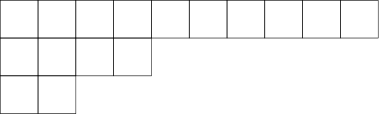


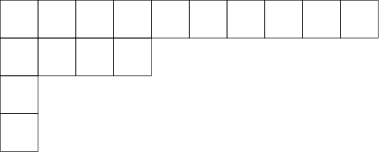


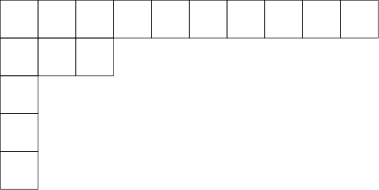


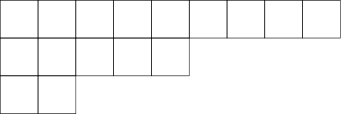


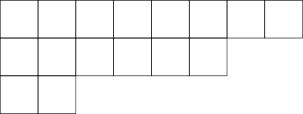


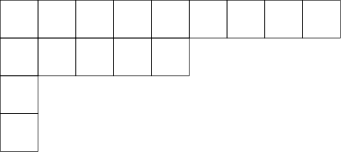


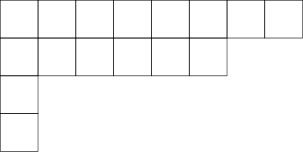


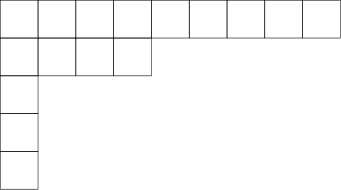


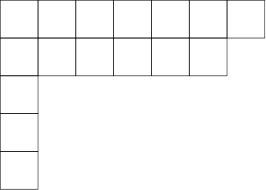


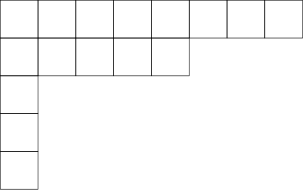


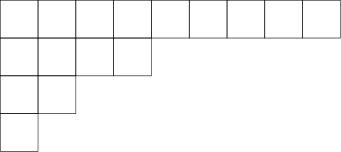


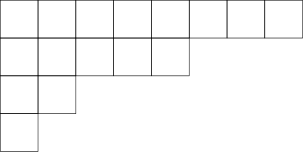

Tensor multiplicand 1:



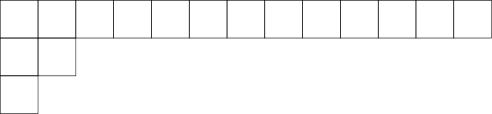

Tensor multiplicand 2:



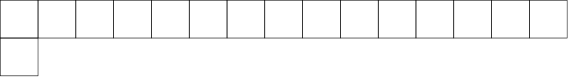

Tensor constituent(s):



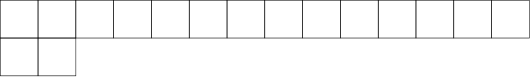


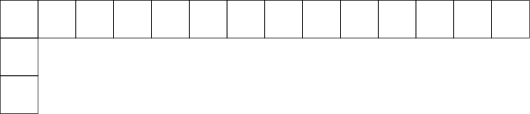


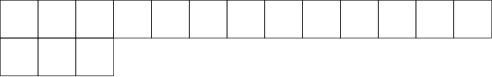


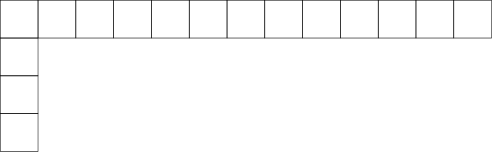


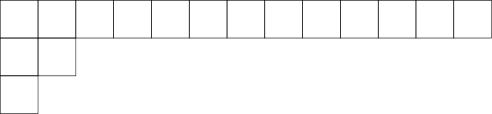


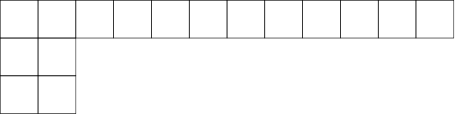


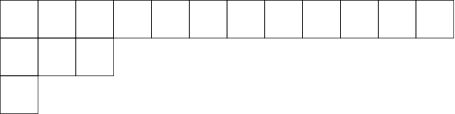


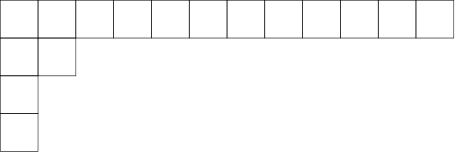

Tensor multiplicand 1:



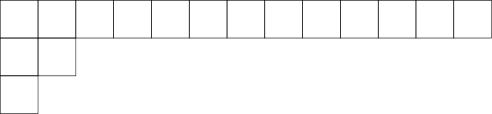

Tensor multiplicand 2:



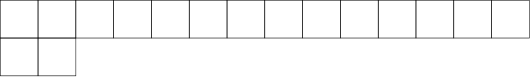

Tensor constituent(s):



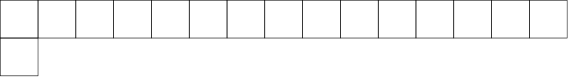


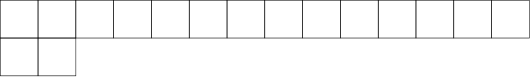


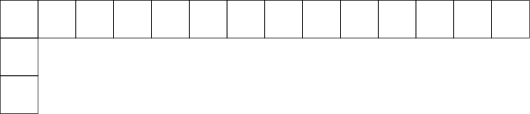


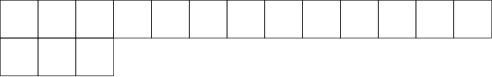


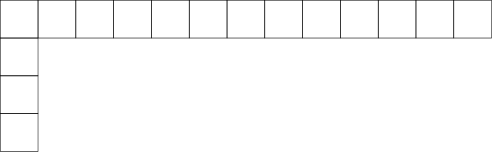


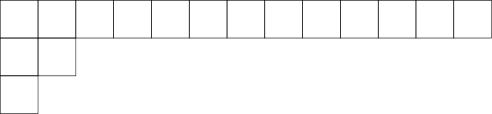


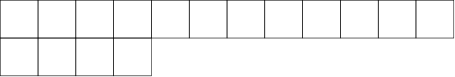


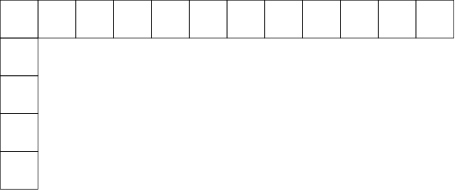


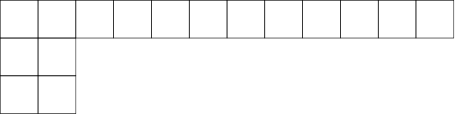


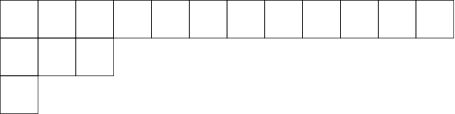


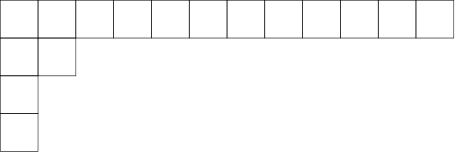


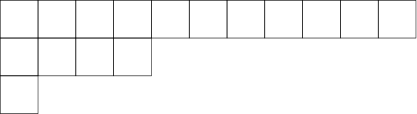


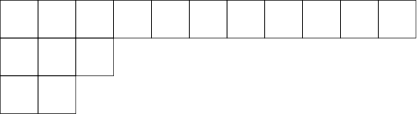


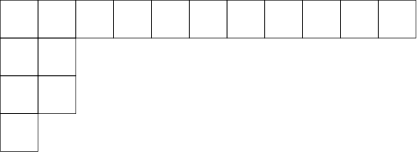


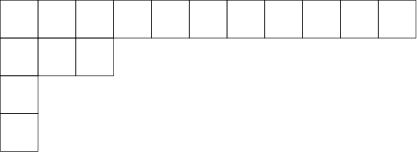

Tensor multiplicand 1:



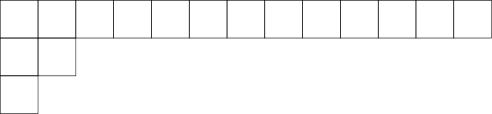

Tensor multiplicand 2:



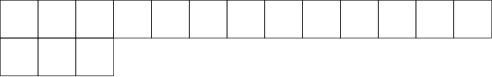

Tensor constituent(s):



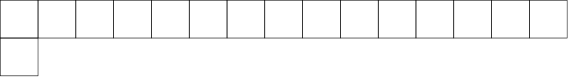


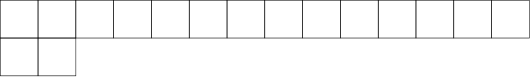


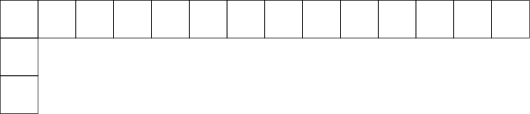


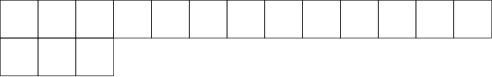


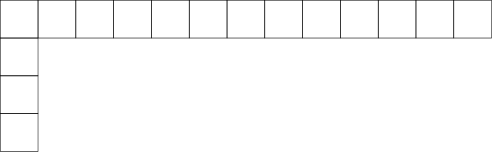


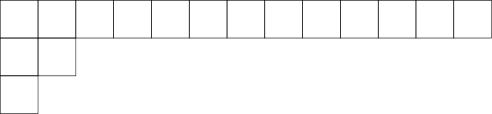


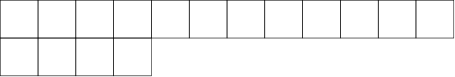


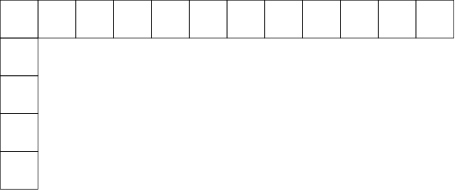


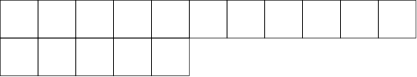


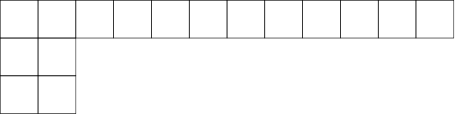


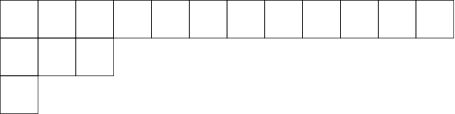


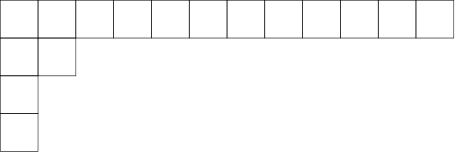


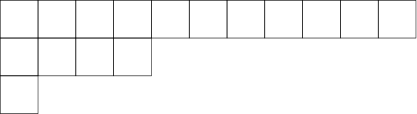


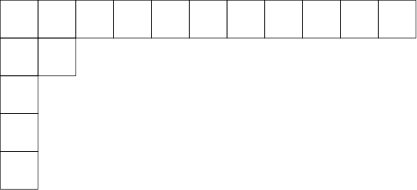


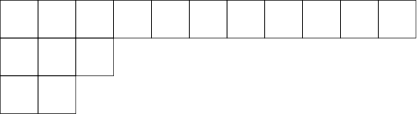


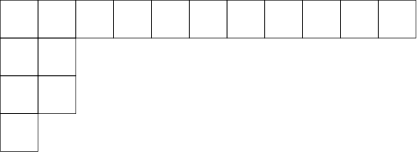


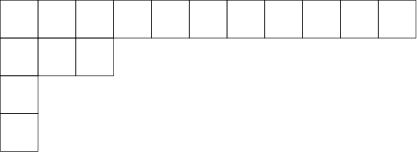


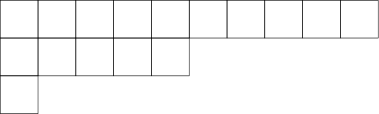


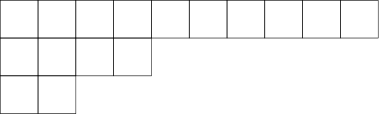


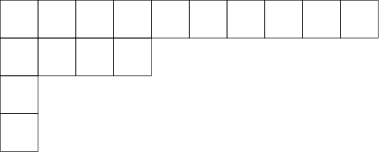


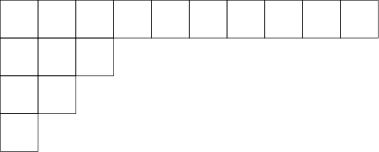

Tensor multiplicand 1:



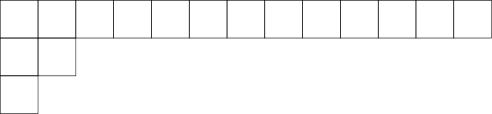

Tensor multiplicand 2:



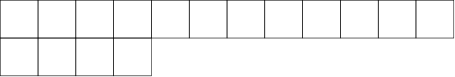

Tensor constituent(s):



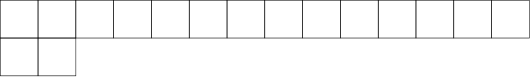


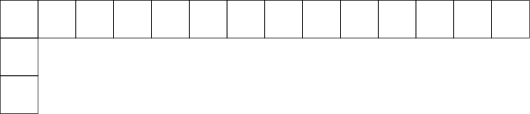


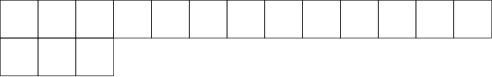


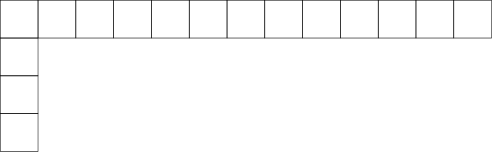


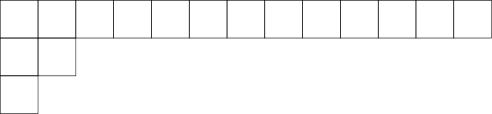


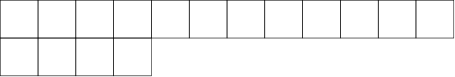


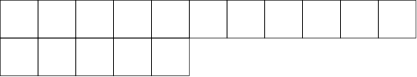


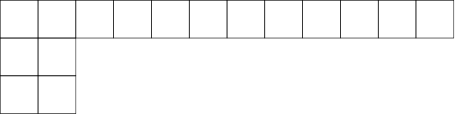


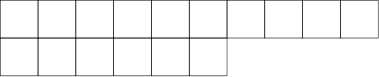


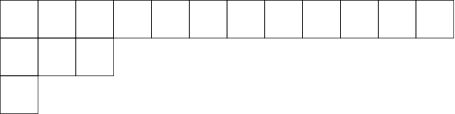


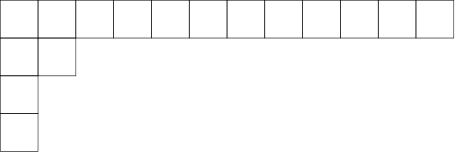


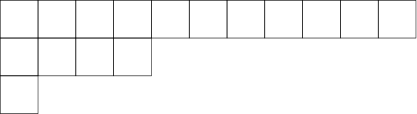


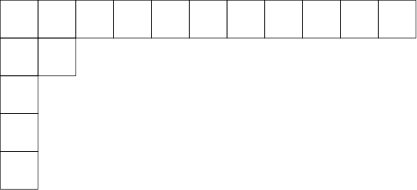


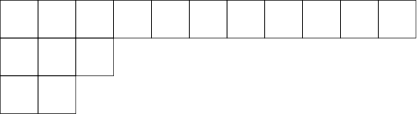


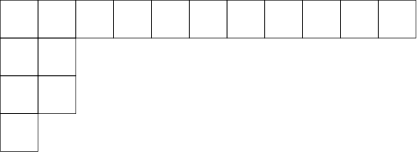


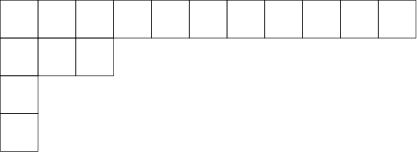


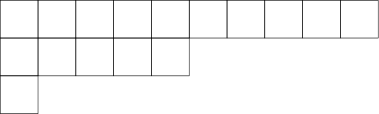


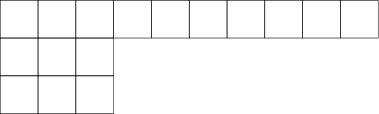


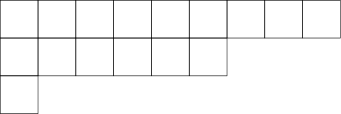


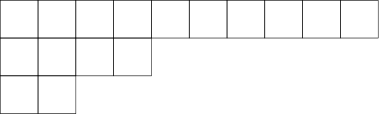


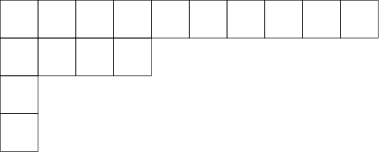


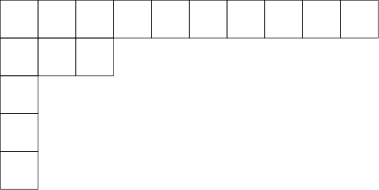


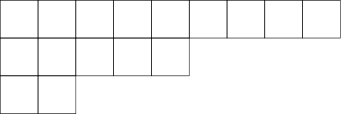


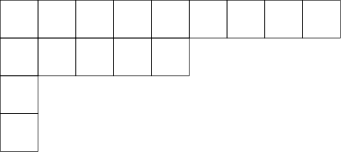


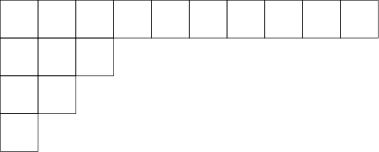


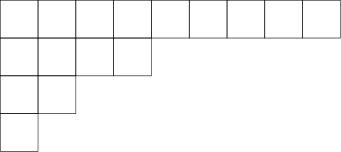

Tensor multiplicand 1:



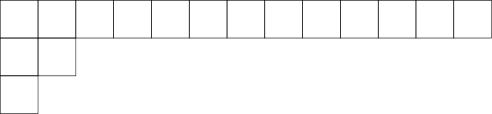

Tensor multiplicand 2:



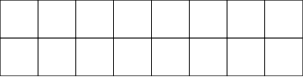

Tensor constituent(s):



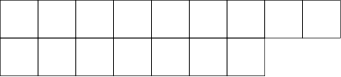


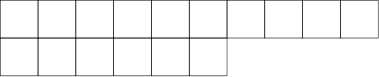


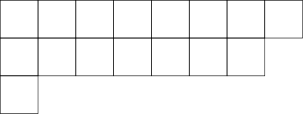


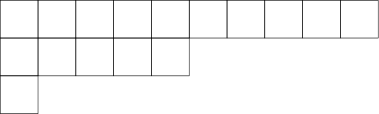


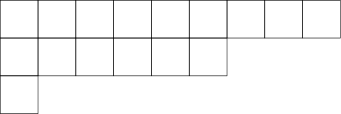


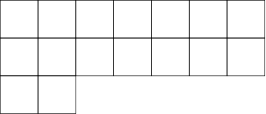


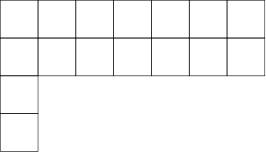


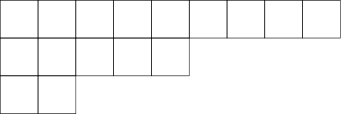


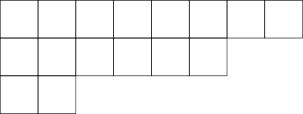


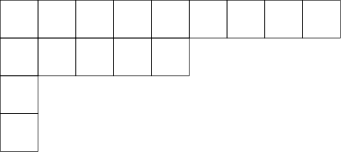


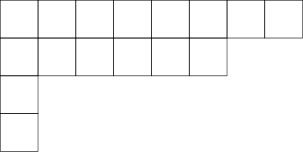


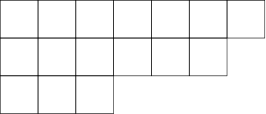


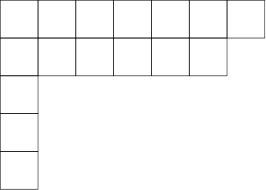


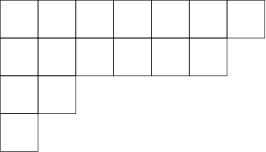


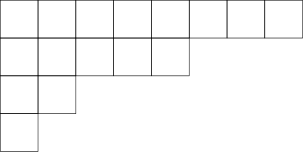

Tensor multiplicand 1:



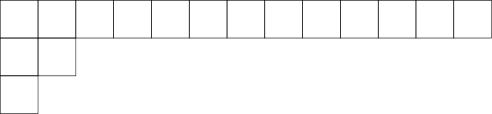

Tensor multiplicand 2:



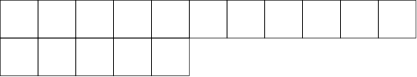

Tensor constituent(s):



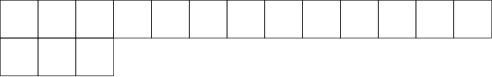


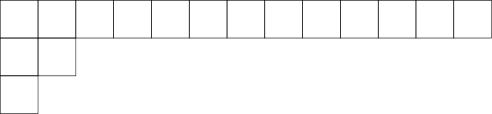


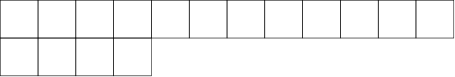


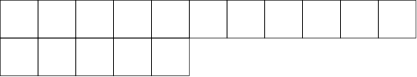


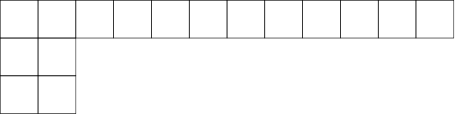


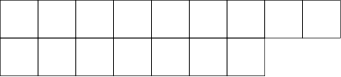


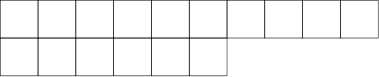


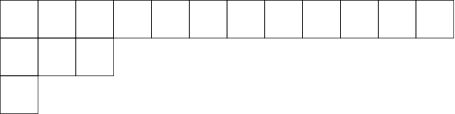


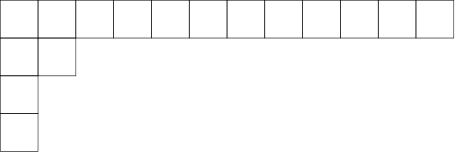


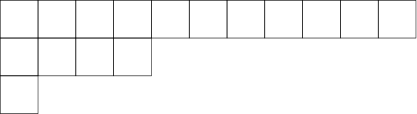


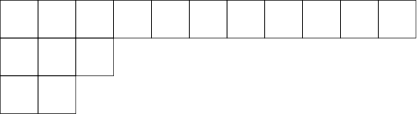


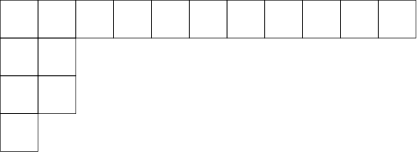


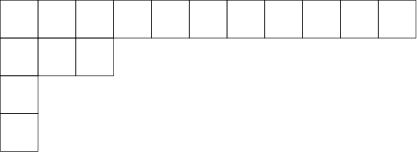


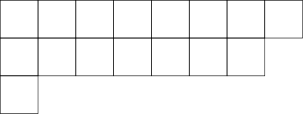


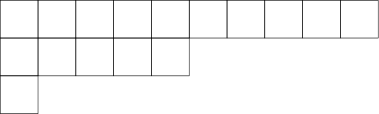


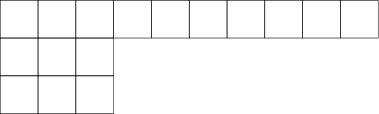


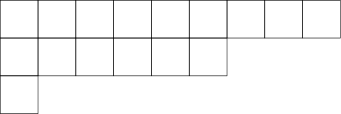


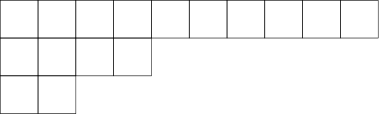


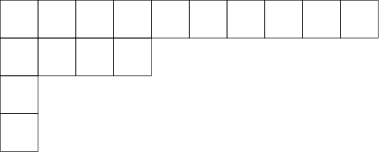


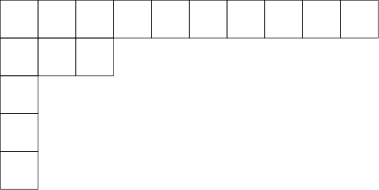


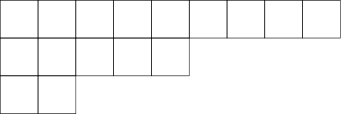


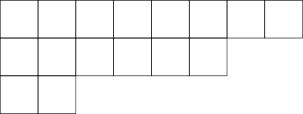


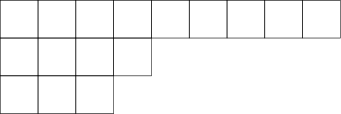


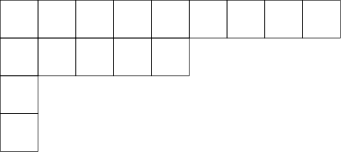


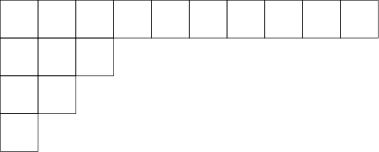


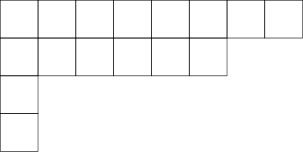


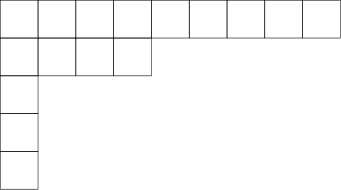


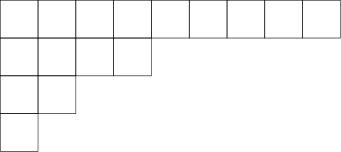


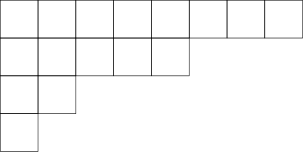

Tensor multiplicand 1:



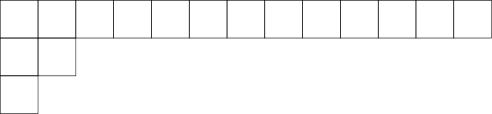

Tensor multiplicand 2:



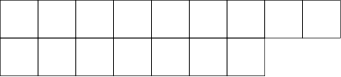

Tensor constituent(s):



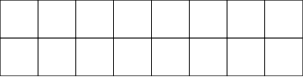


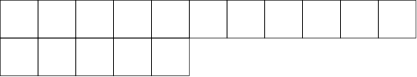


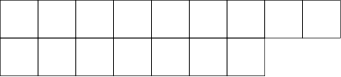


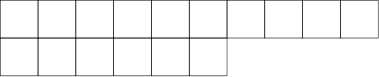


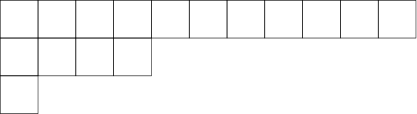


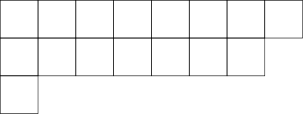


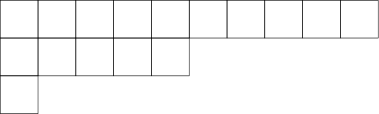


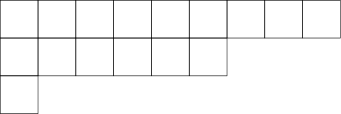


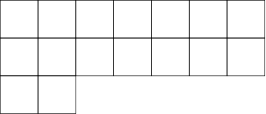


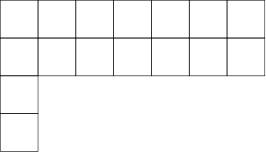


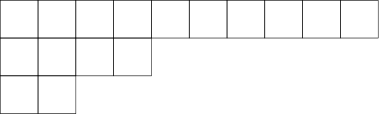


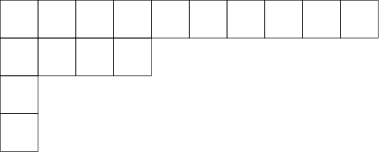


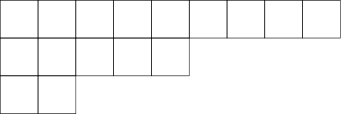


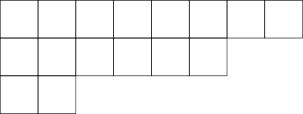


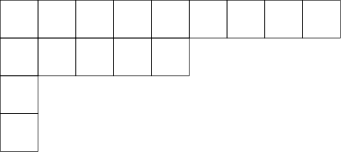


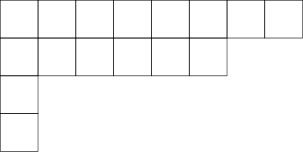


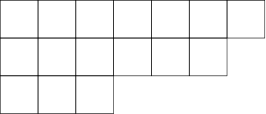


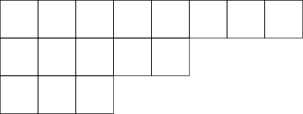


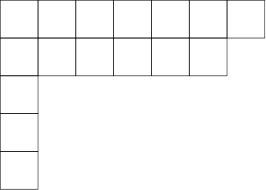


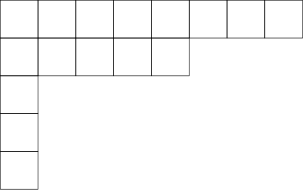


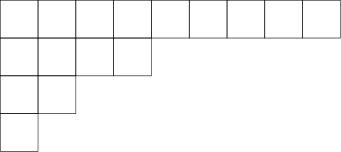


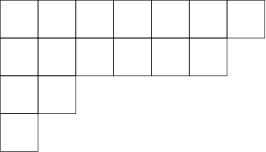


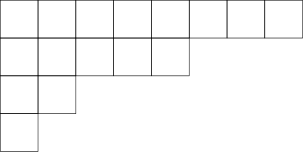

Tensor multiplicand 1:



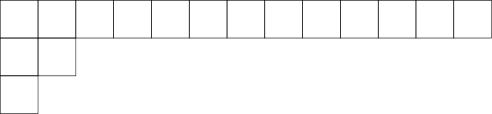

Tensor multiplicand 2:



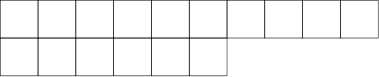

Tensor constituent(s):



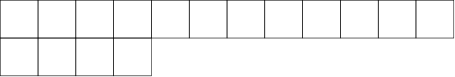


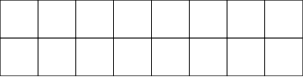


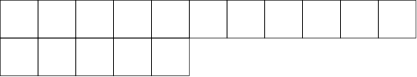


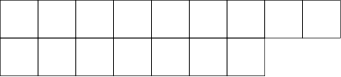


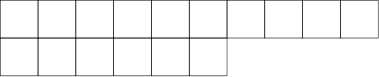


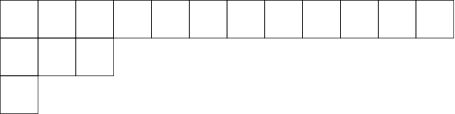


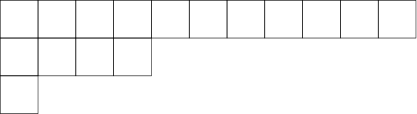


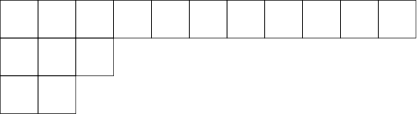


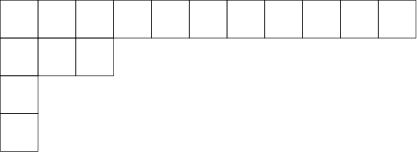


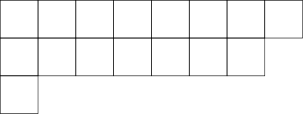


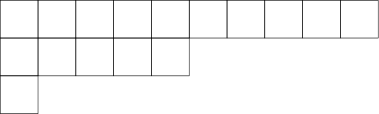


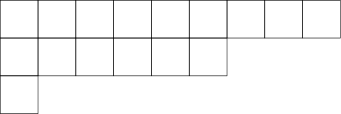


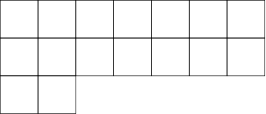


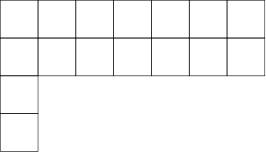


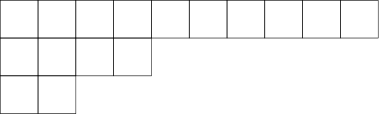


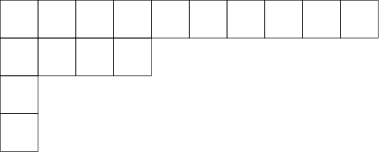


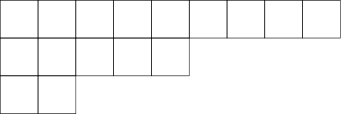


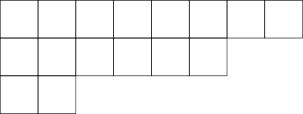


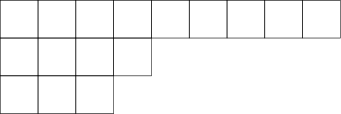


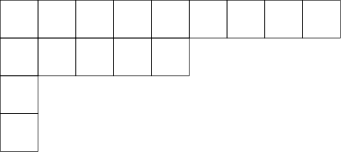


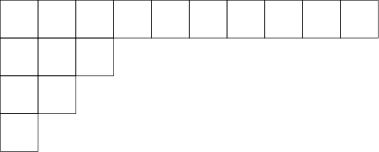


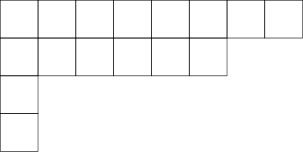


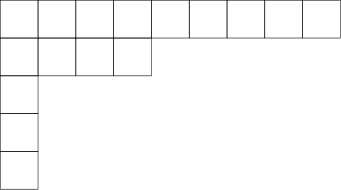


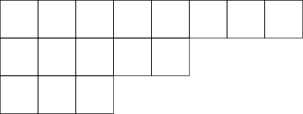


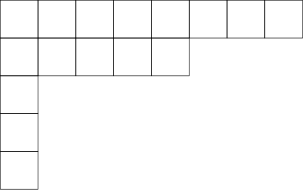


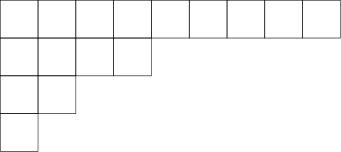


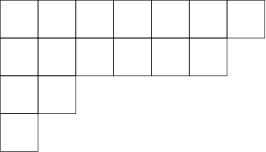


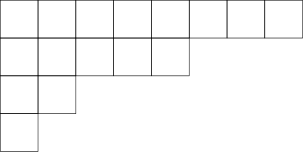

Tensor multiplicand 1:



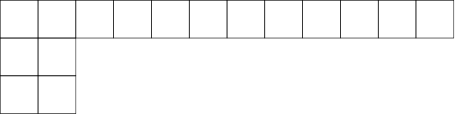

Tensor multiplicand 2:



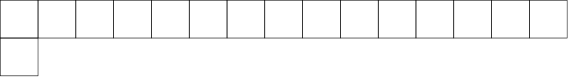

Tensor constituent(s):



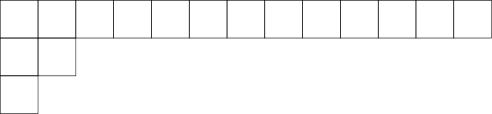


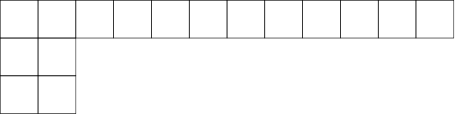


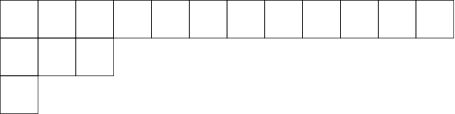


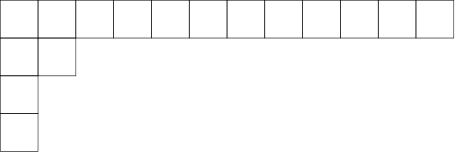


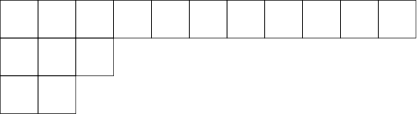


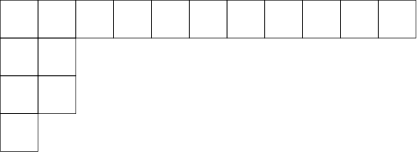

Tensor multiplicand 1:



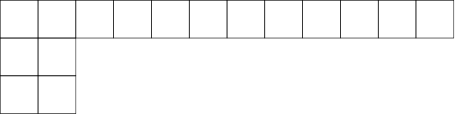

Tensor multiplicand 2:



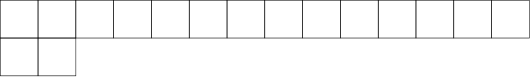

Tensor constituent(s):



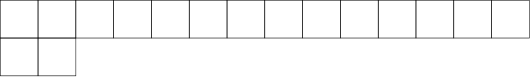


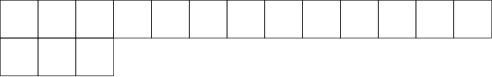


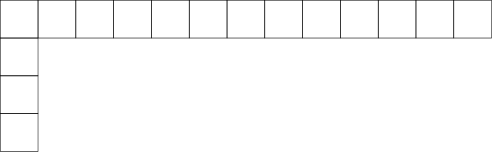


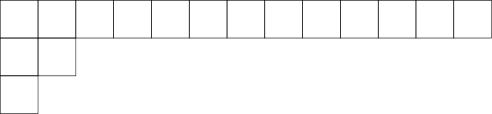


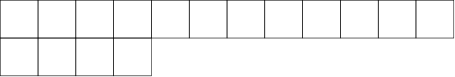


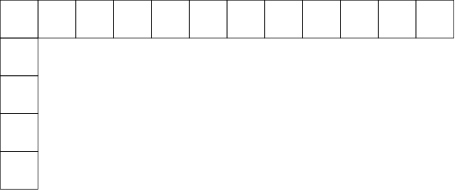


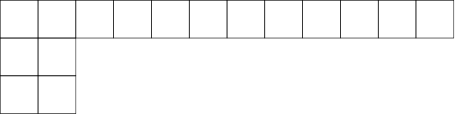


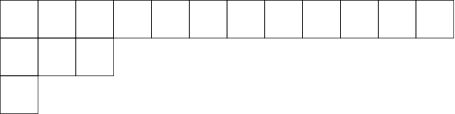


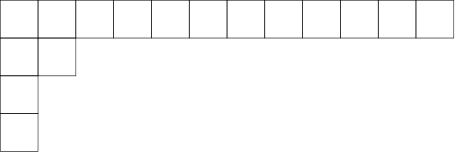


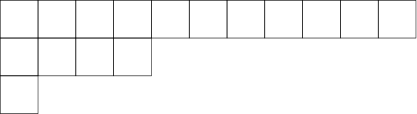


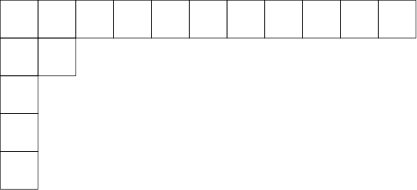


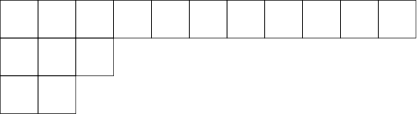


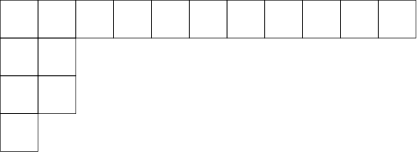


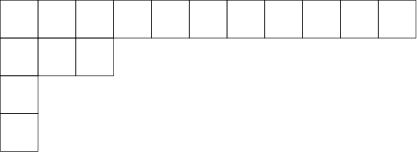


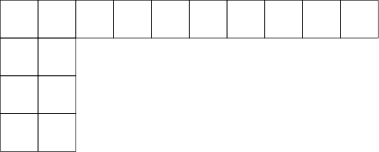


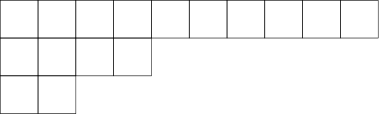


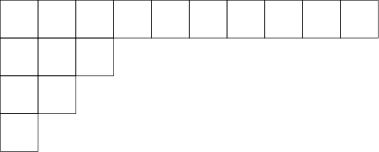

Tensor multiplicand 1:



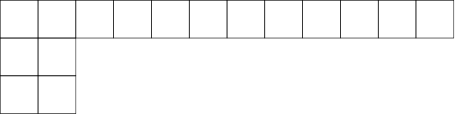

Tensor multiplicand 2:



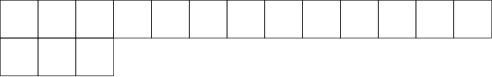

Tensor constituent(s):



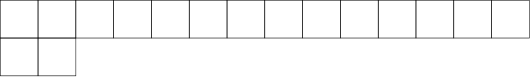


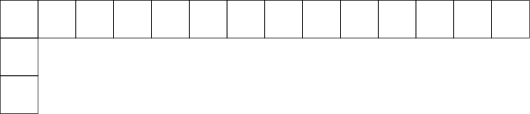


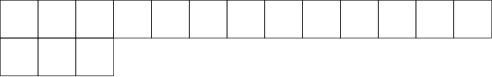


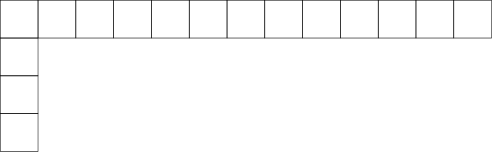


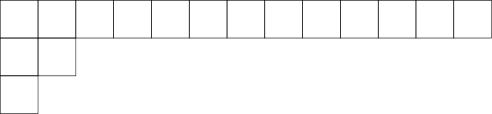


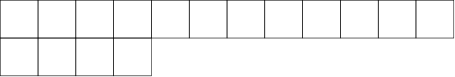


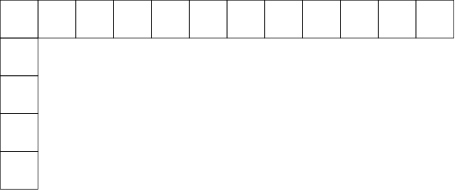


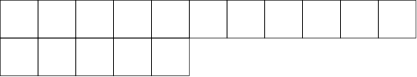


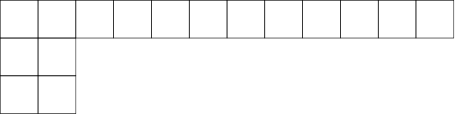


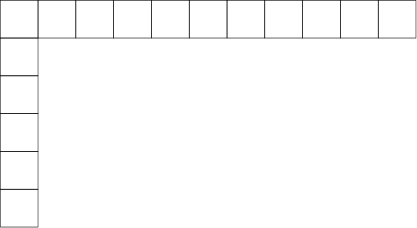


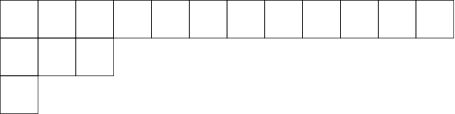


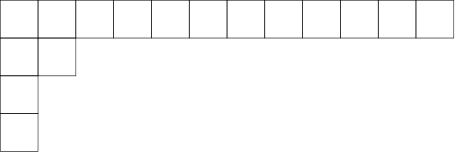


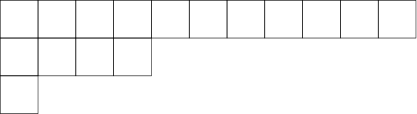


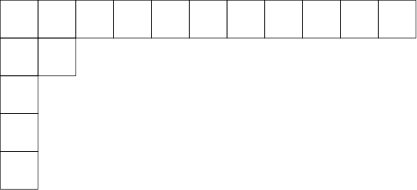


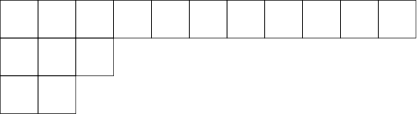


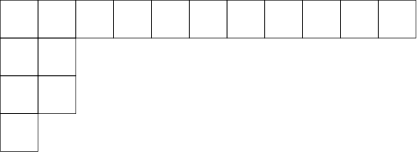


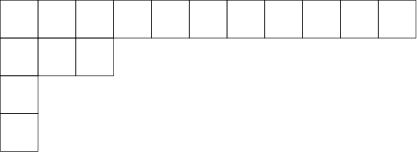


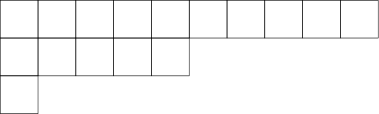


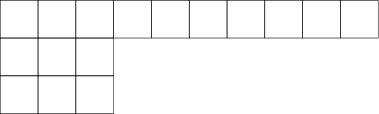


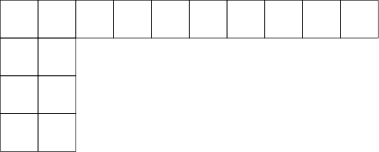


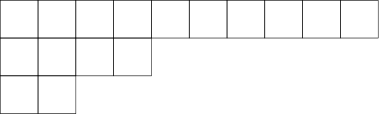


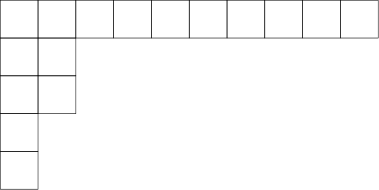


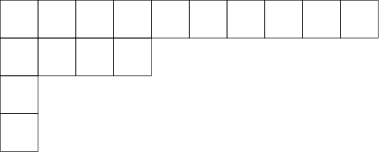


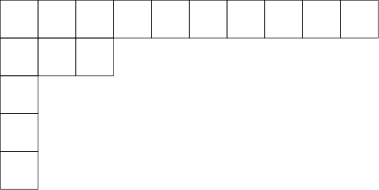


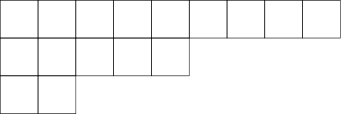


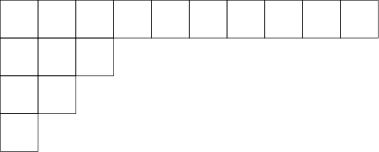


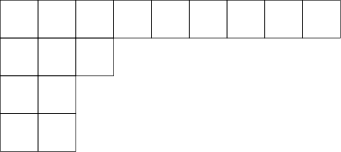


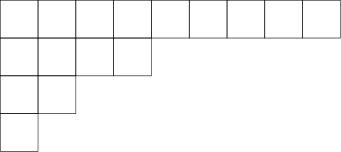

Tensor multiplicand 1:



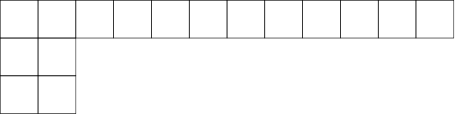

Tensor multiplicand 2:



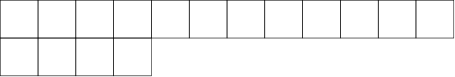

Tensor constituent(s):



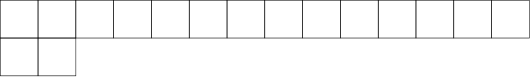


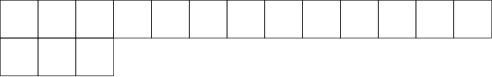


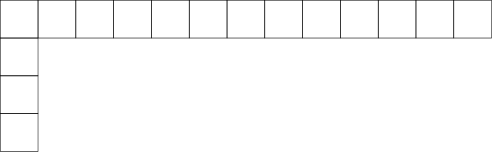


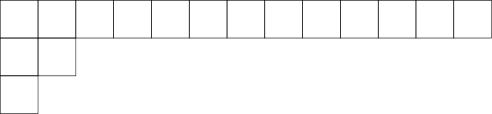


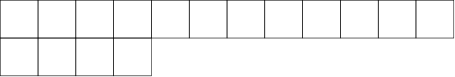


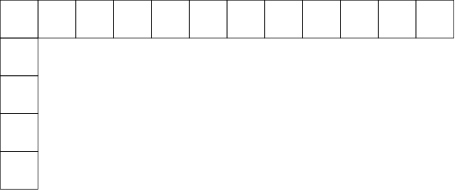


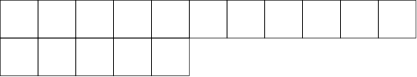


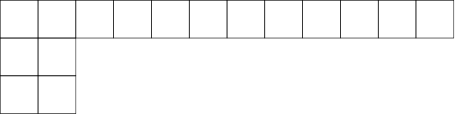


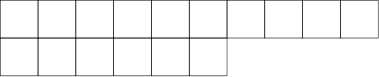


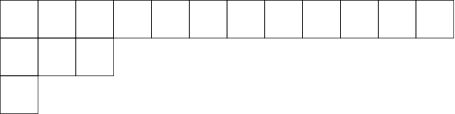


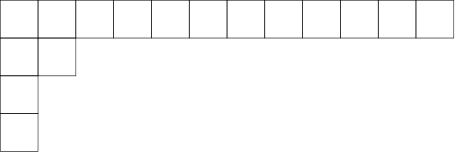


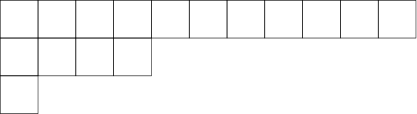


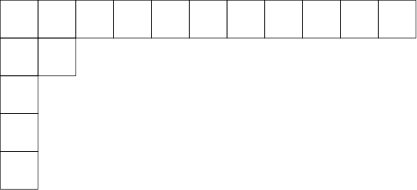


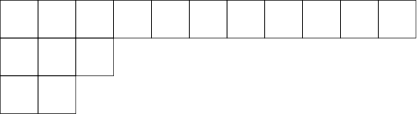


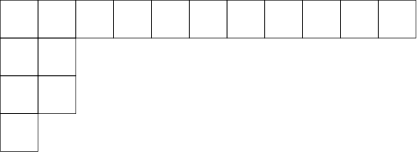


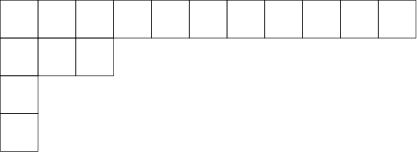


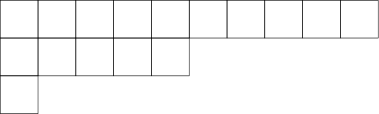


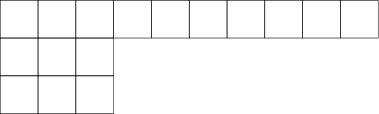


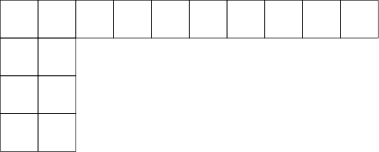


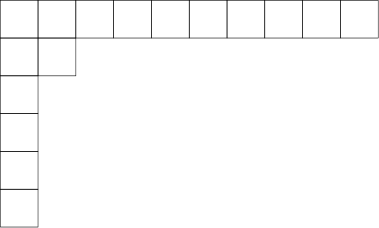


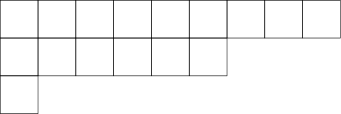


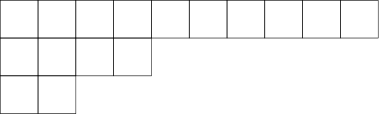


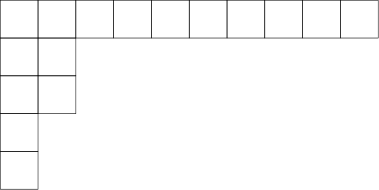


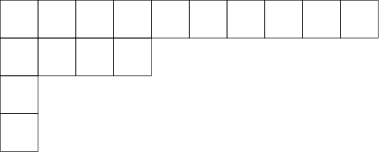


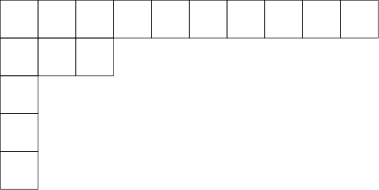


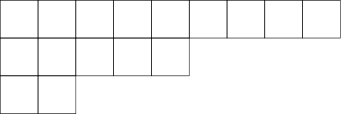


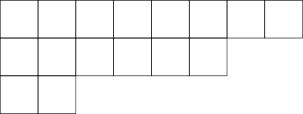


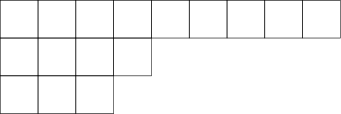


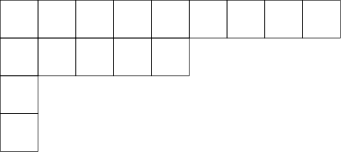


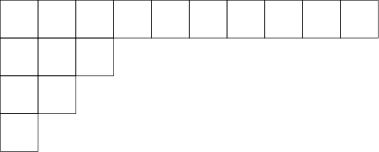


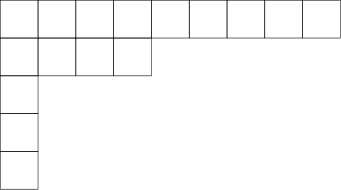


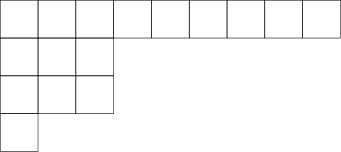


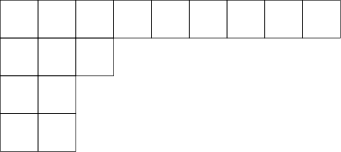


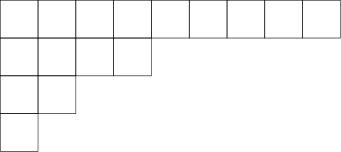


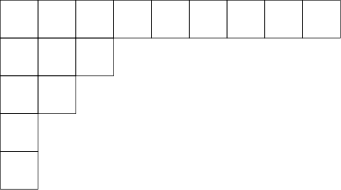


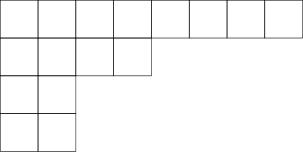


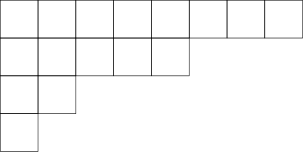

Tensor multiplicand 1:



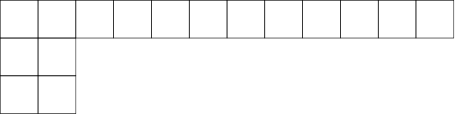

Tensor multiplicand 2:



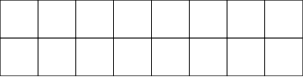

Tensor constituent(s):



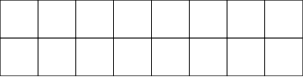


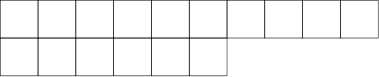


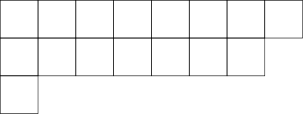


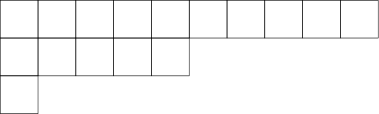


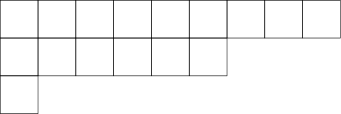


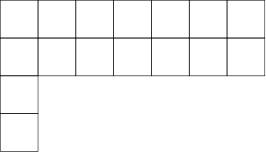


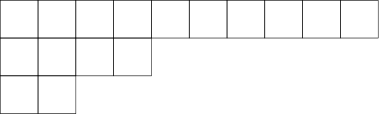


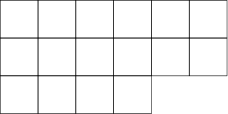


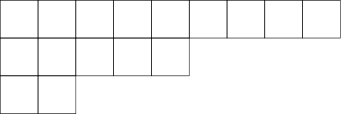


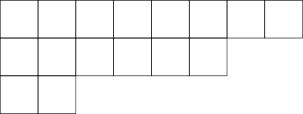


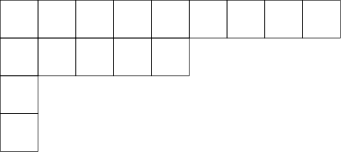


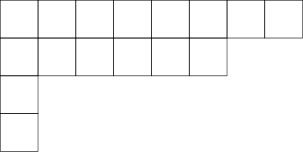


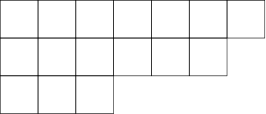


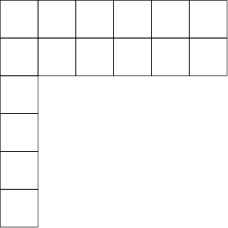


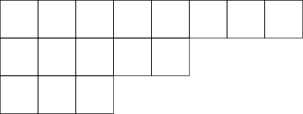


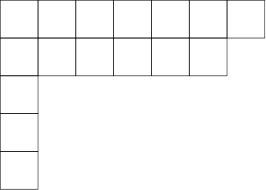


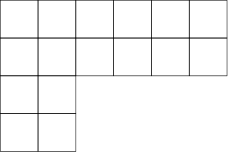


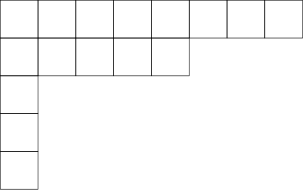


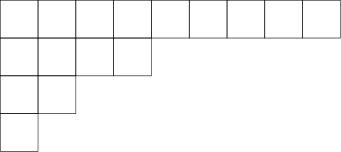


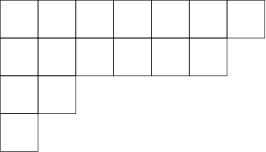


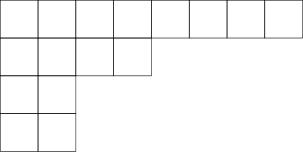


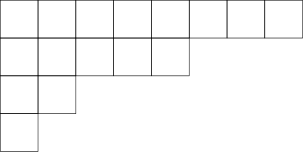


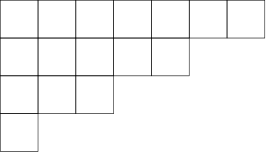


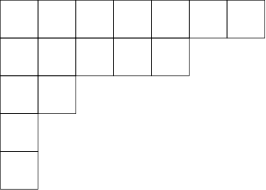

Tensor multiplicand 1:



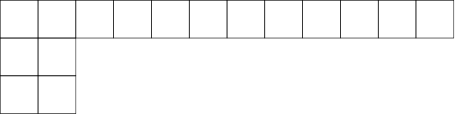

Tensor multiplicand 2:



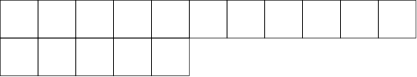

Tensor constituent(s):



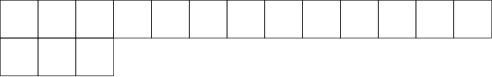


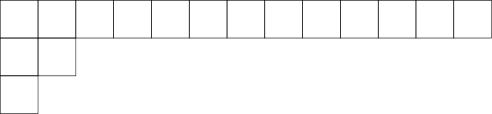


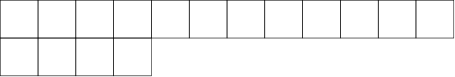


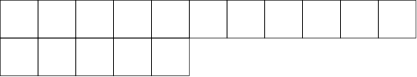


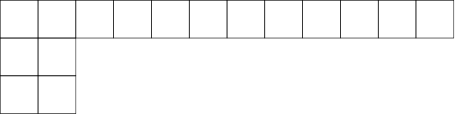


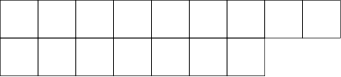


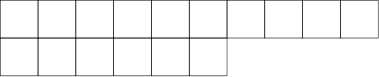


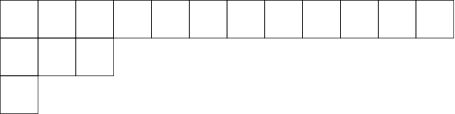


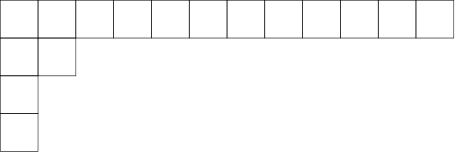


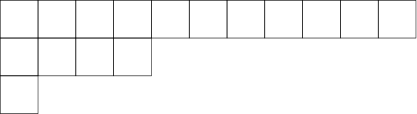


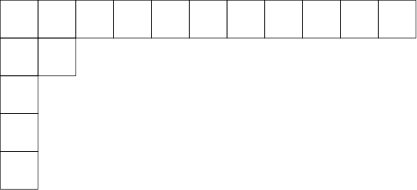


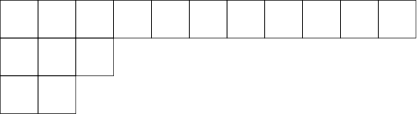


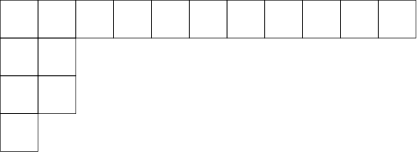


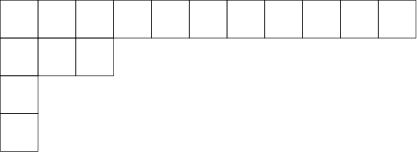


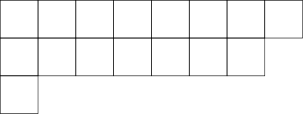


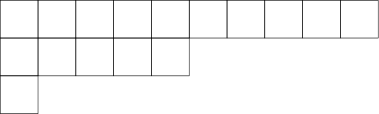


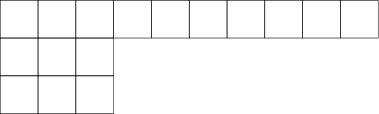


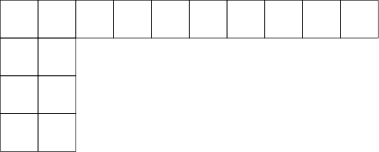


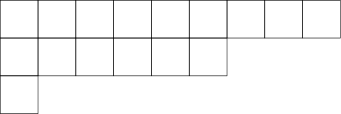


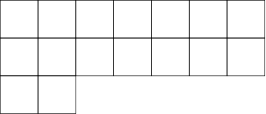


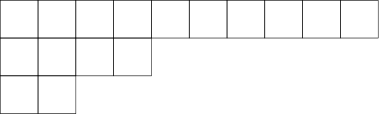


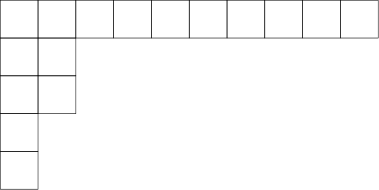


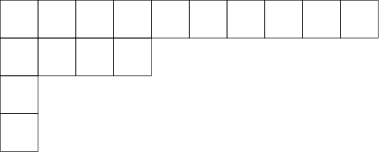


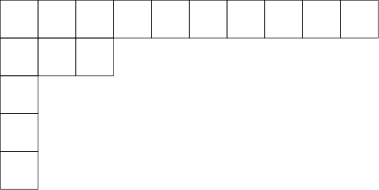


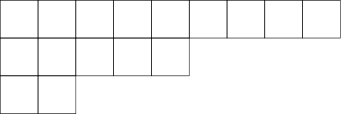


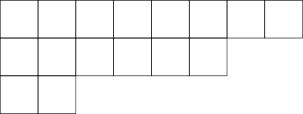


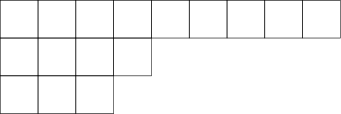


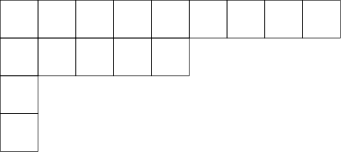


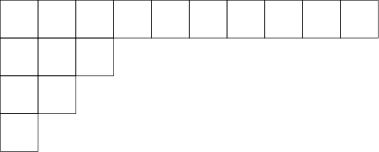


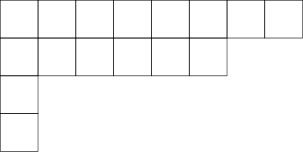


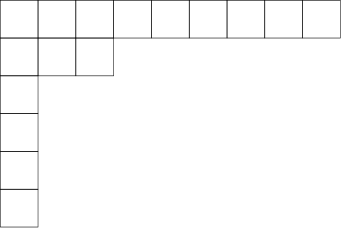


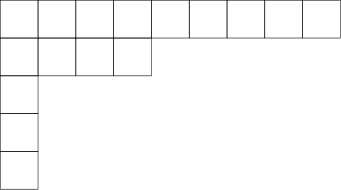


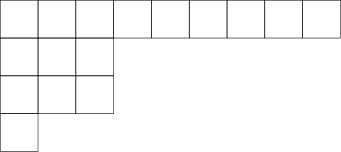


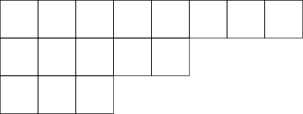


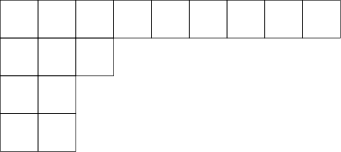


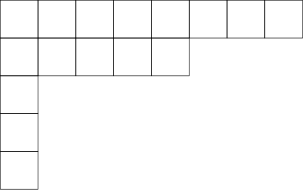


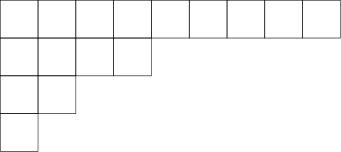


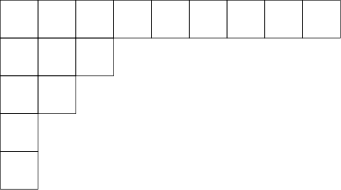


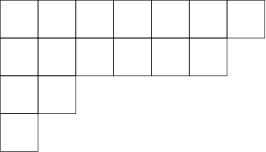


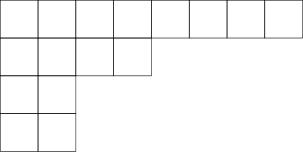


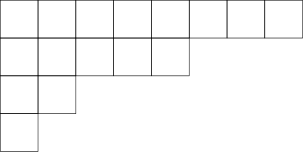


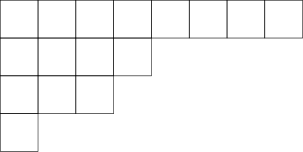


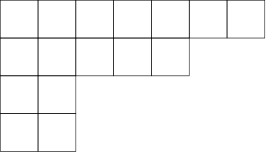


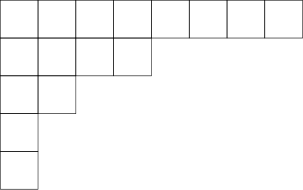

Tensor multiplicand 1:



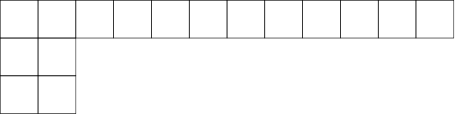

Tensor multiplicand 2:



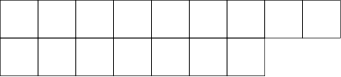

Tensor constituent(s):



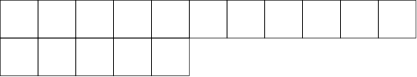


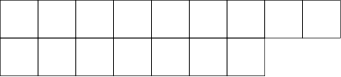


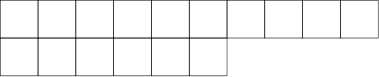


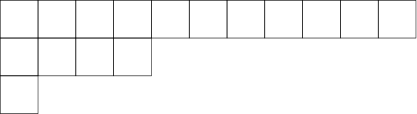


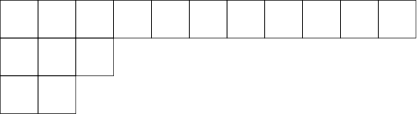


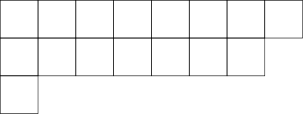


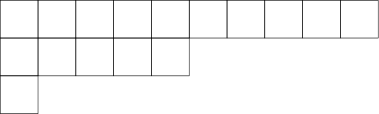


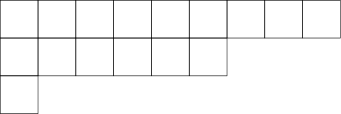


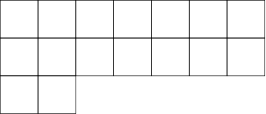


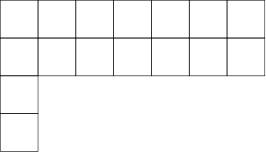


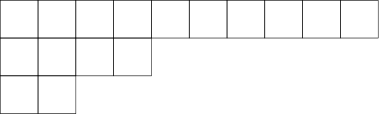


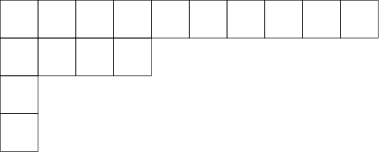


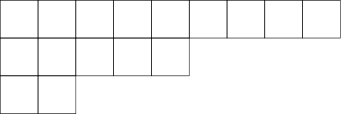


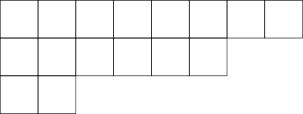


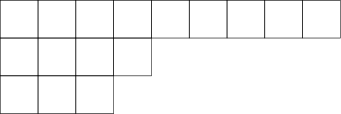


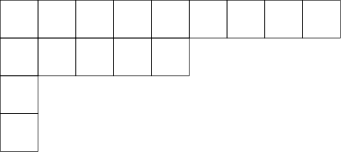


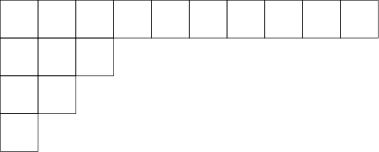


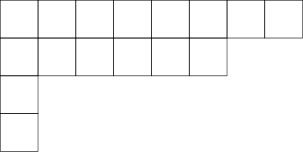


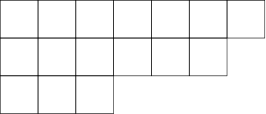


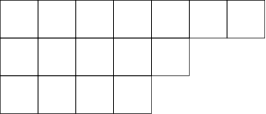


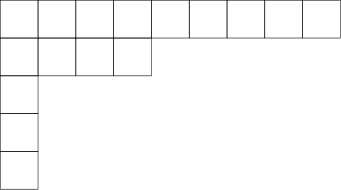


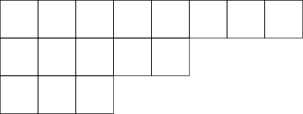


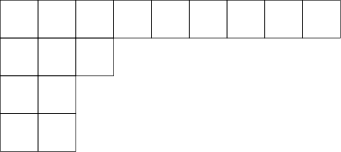


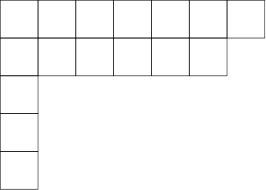


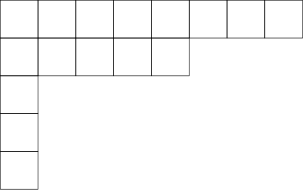


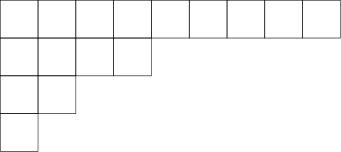


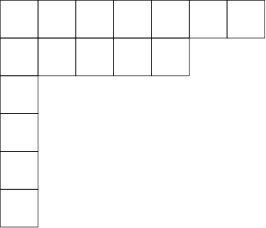


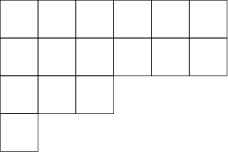


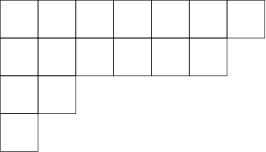


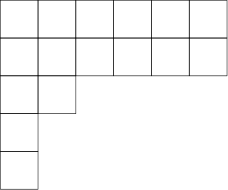


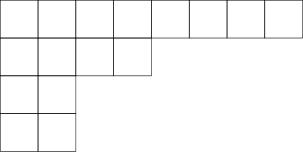


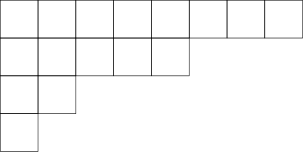


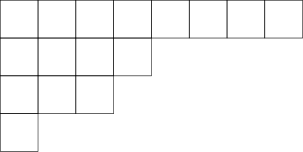


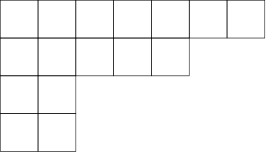


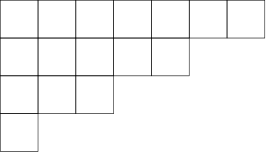


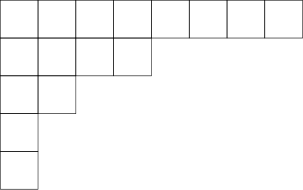


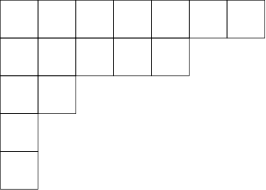

Tensor multiplicand 1:



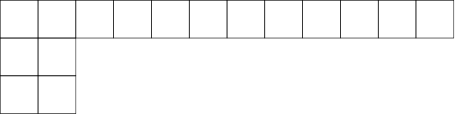

Tensor multiplicand 2:



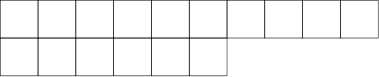

Tensor constituent(s):



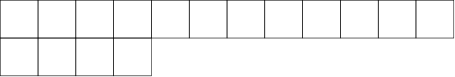


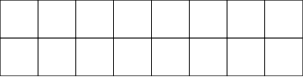


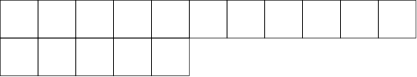


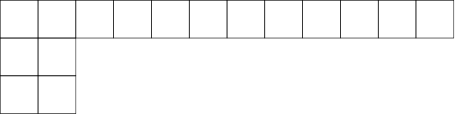


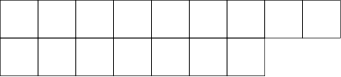


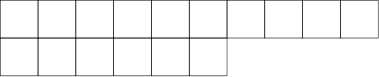


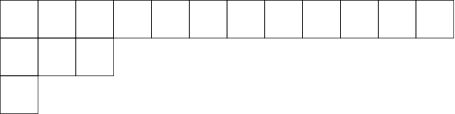


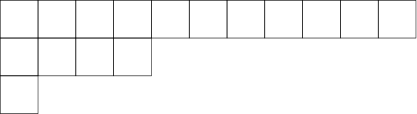


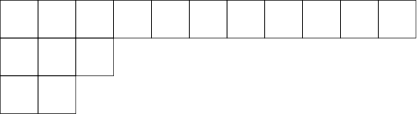


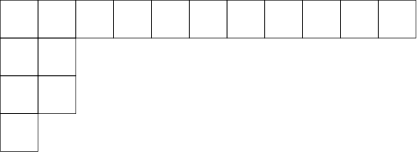


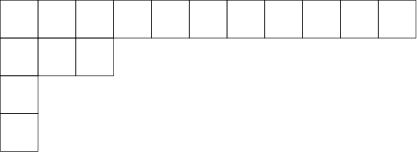


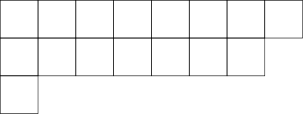


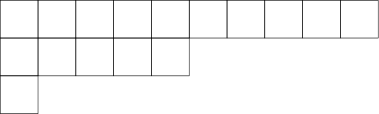


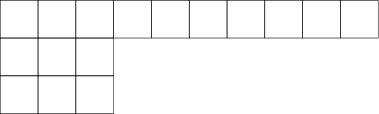


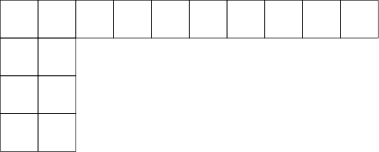


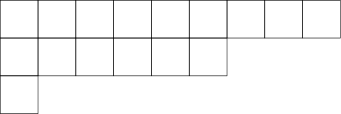


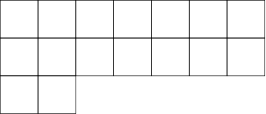


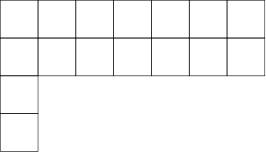


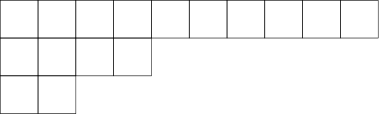


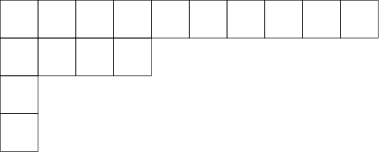


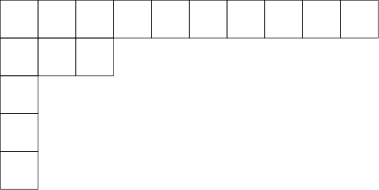


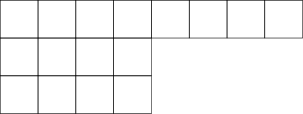


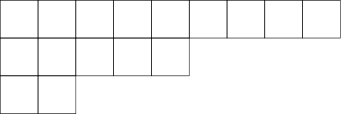


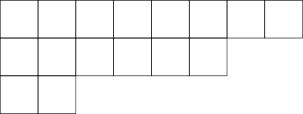


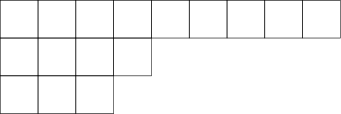


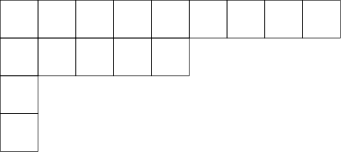


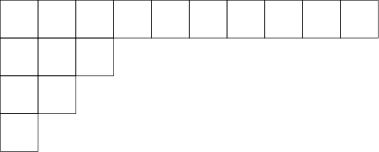


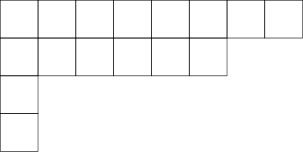


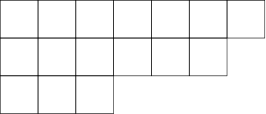


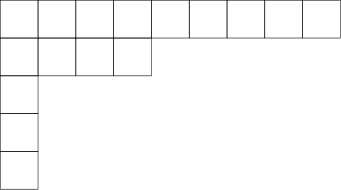


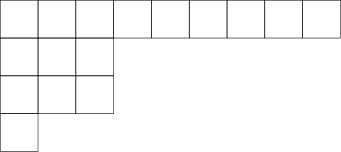


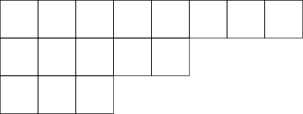


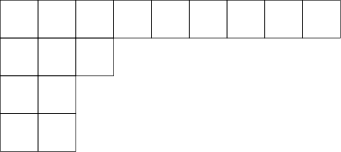


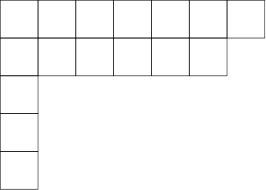


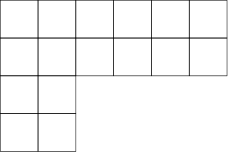


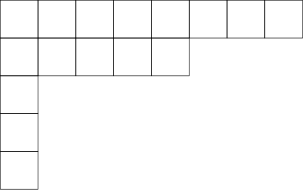


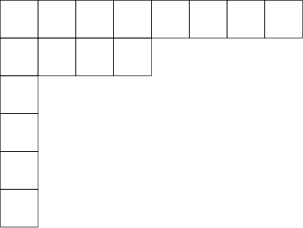


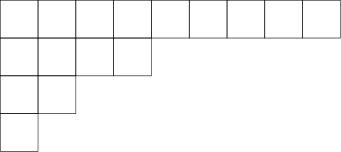


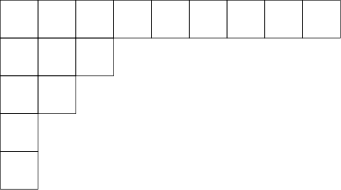


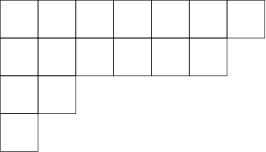


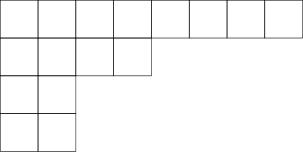


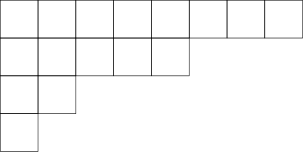


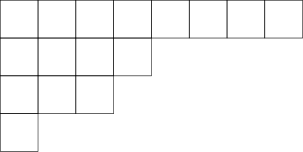


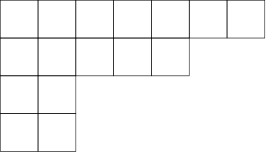


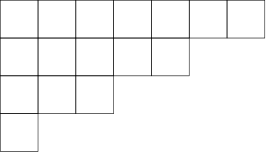


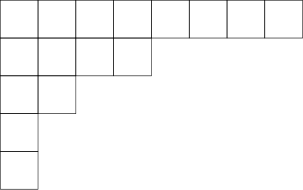


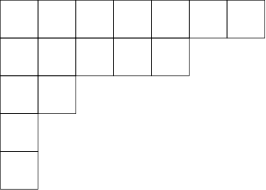

Tensor multiplicand 1:



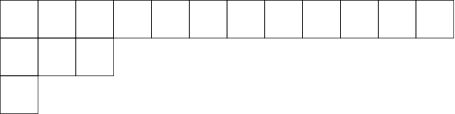

Tensor multiplicand 2:



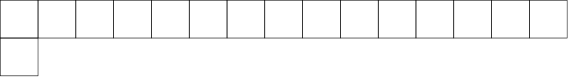

Tensor constituent(s):



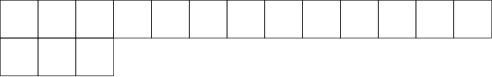


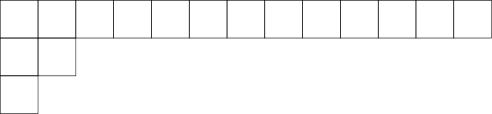


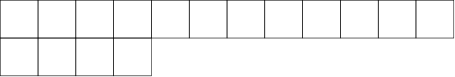


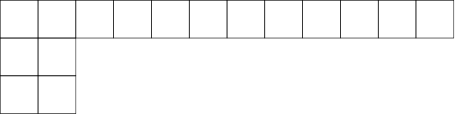


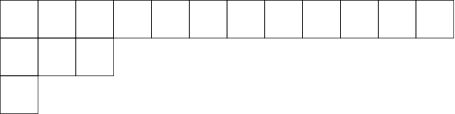


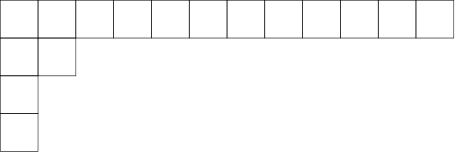


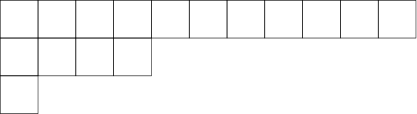


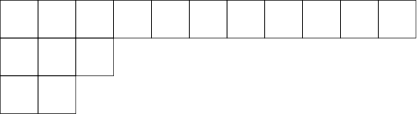


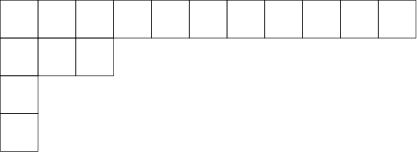

Tensor multiplicand 1:



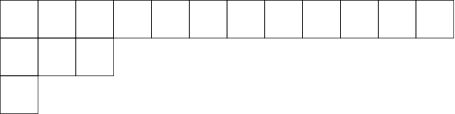

Tensor multiplicand 2:



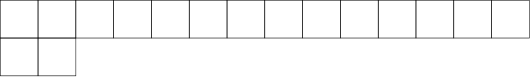

Tensor constituent(s):



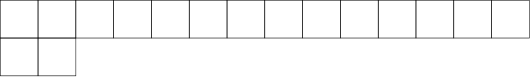


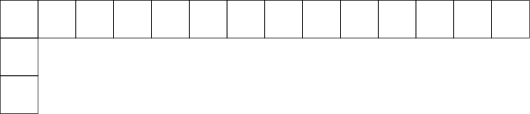


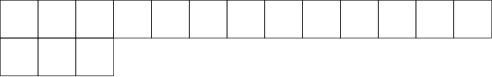


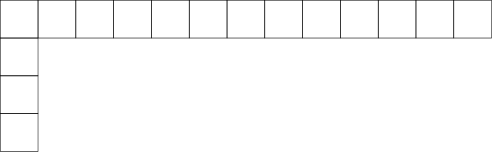


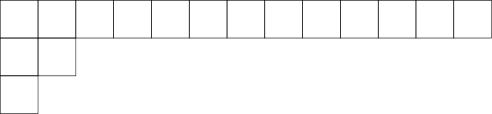


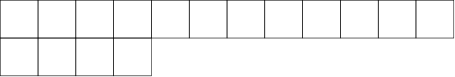


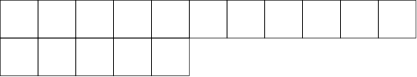


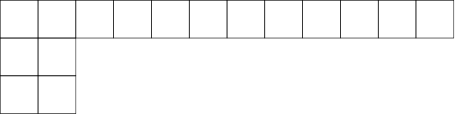


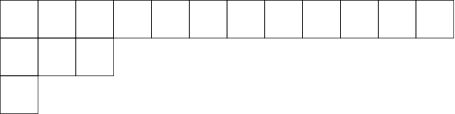


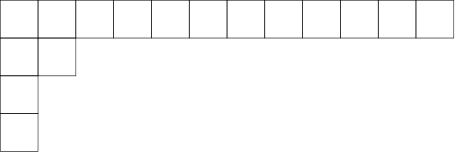


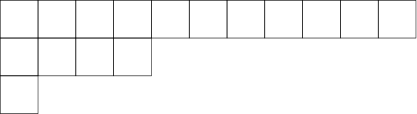


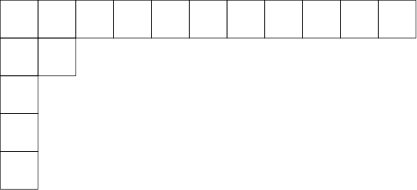


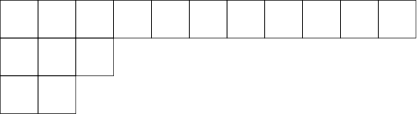


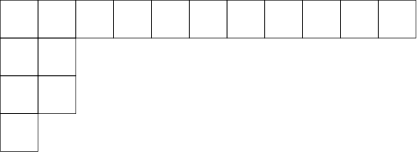


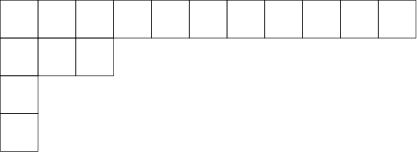


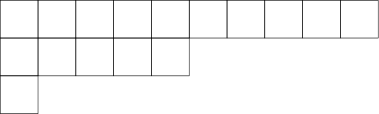


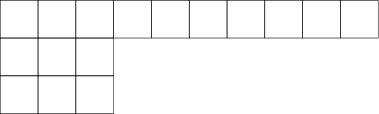


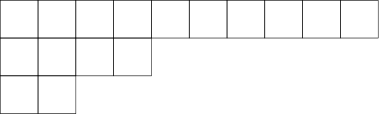


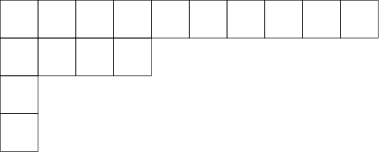


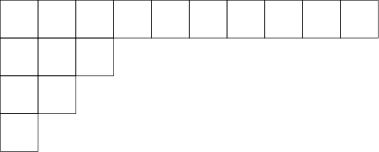

Tensor multiplicand 1:



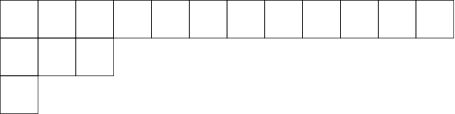

Tensor multiplicand 2:



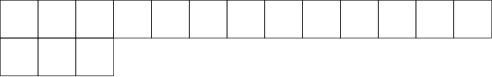

Tensor constituent(s):



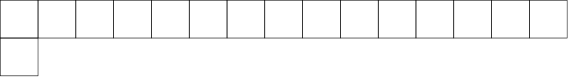


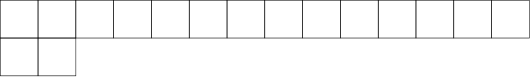


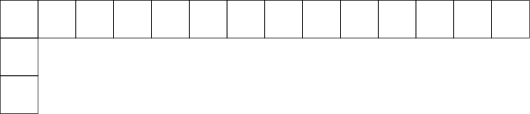


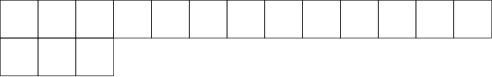


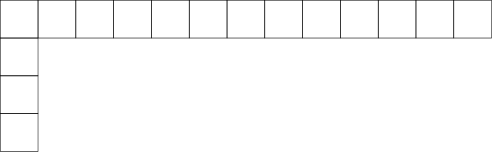


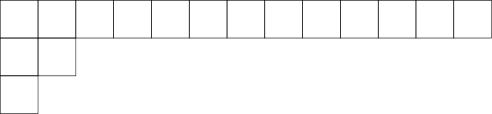


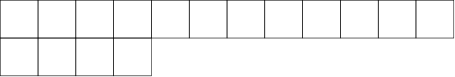


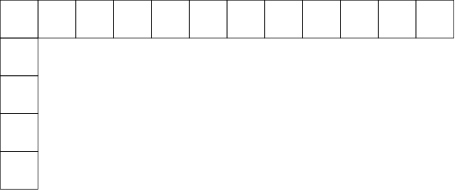


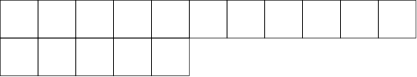


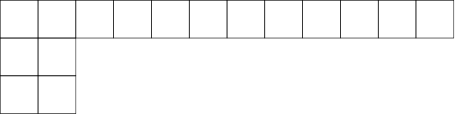


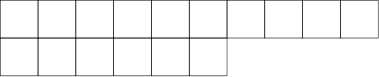


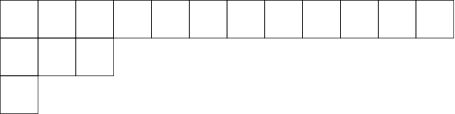


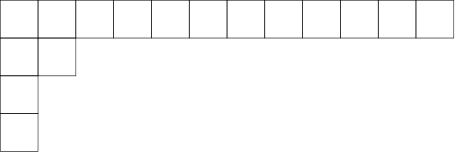


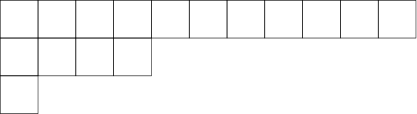


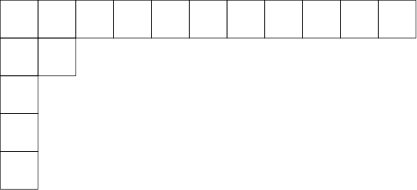


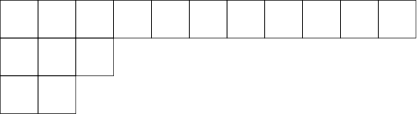


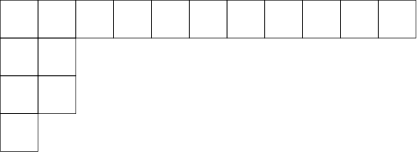


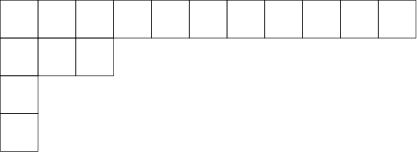


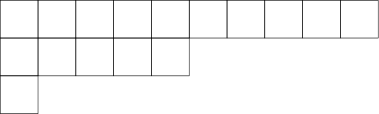


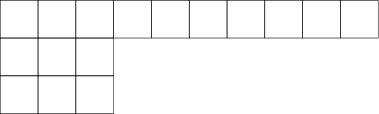


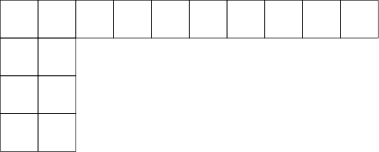


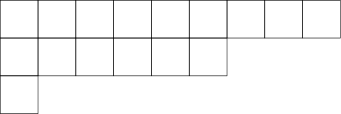


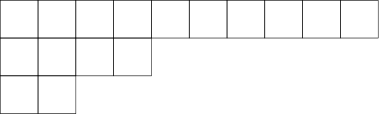


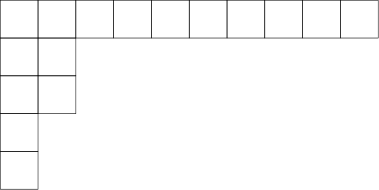


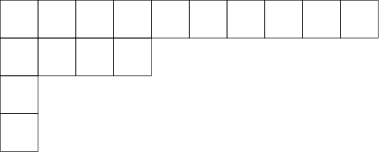


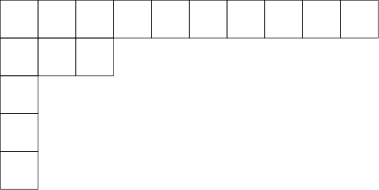


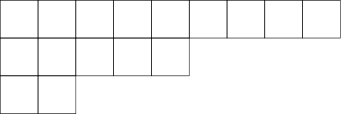


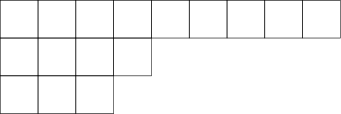


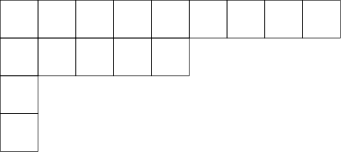


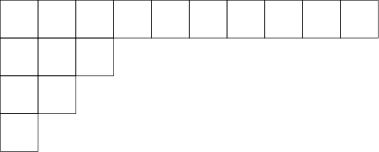


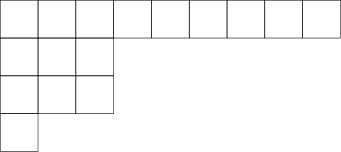


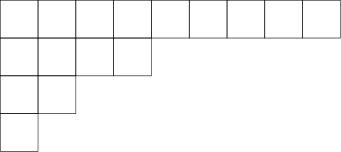

Tensor multiplicand 1:



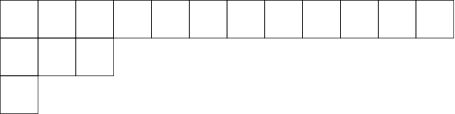

Tensor multiplicand 2:



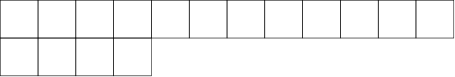

Tensor constituent(s):



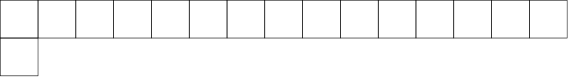


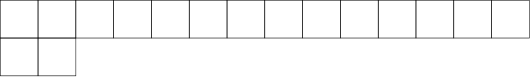


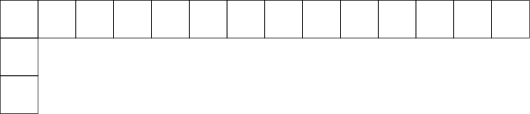


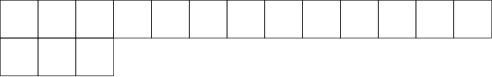


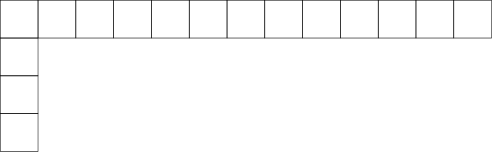


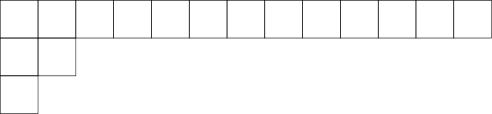


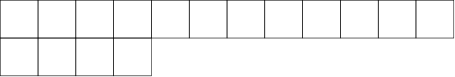


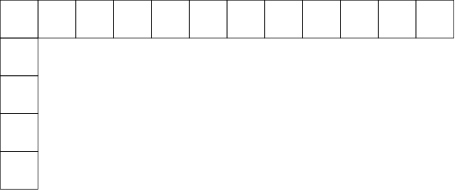


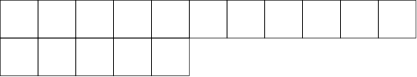


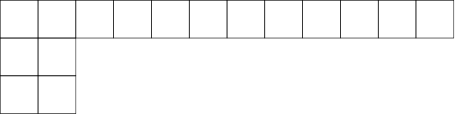


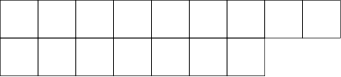


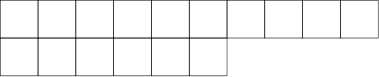


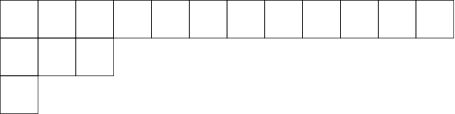


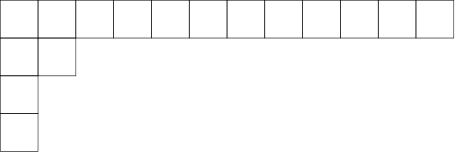


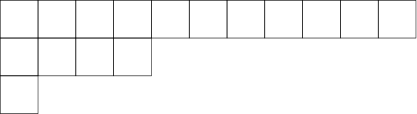


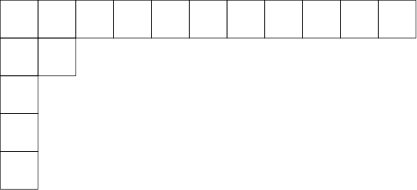


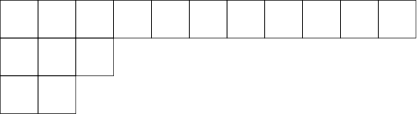


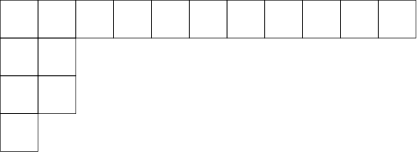


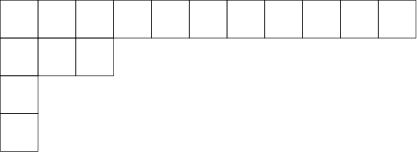


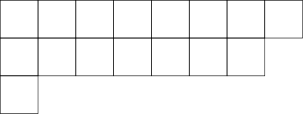


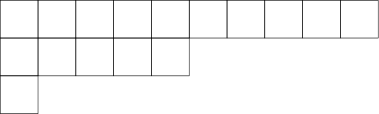


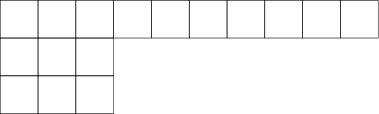


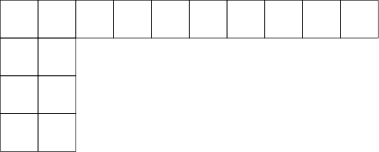


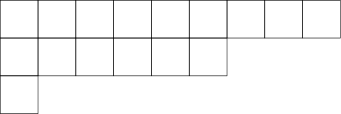


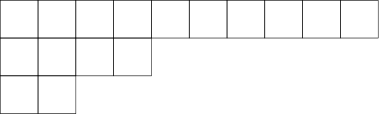


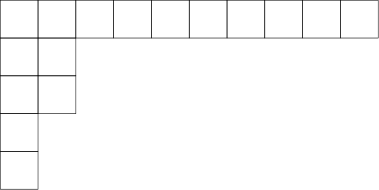


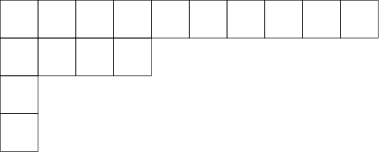


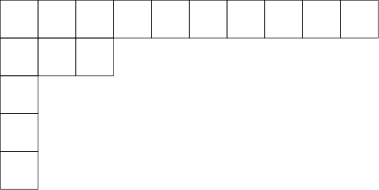


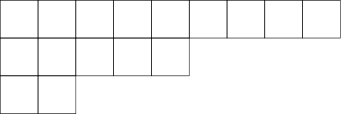


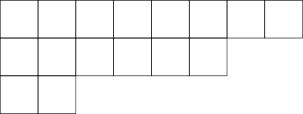


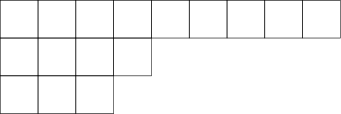


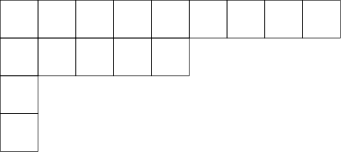


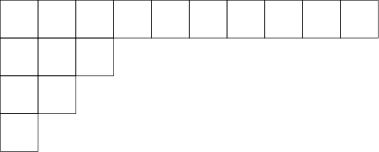


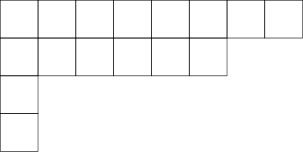


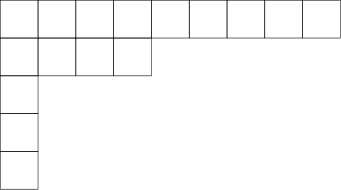


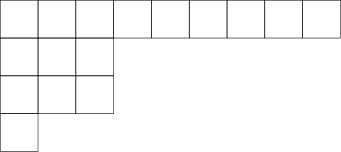


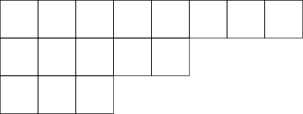


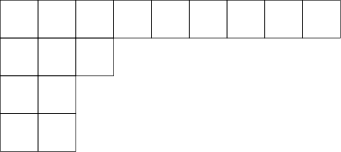


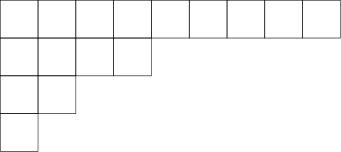


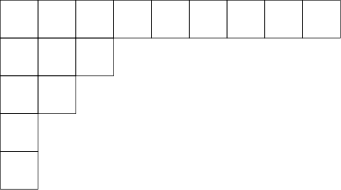


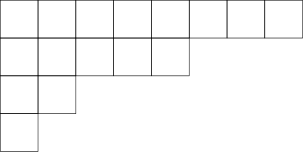


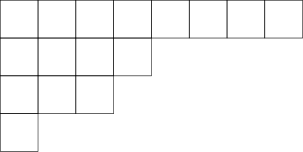

Tensor multiplicand 1:



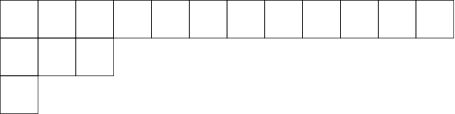

Tensor multiplicand 2:



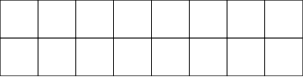

Tensor constituent(s):



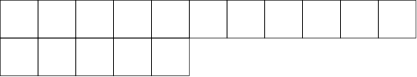


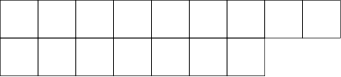


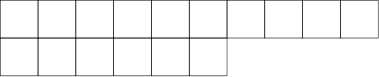


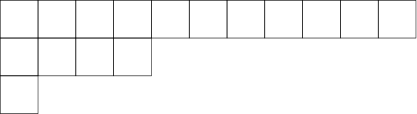


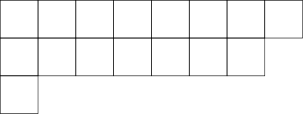


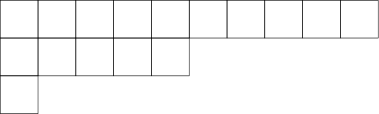


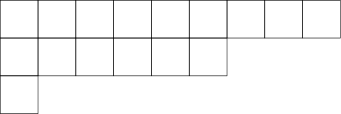


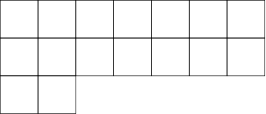


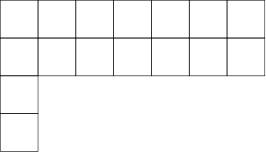


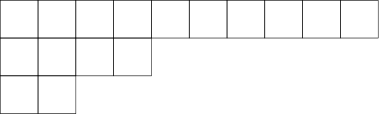


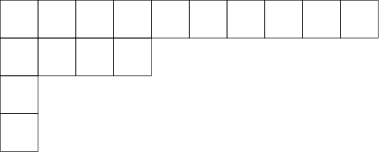


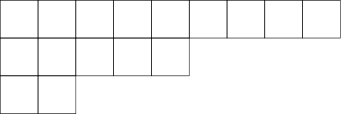


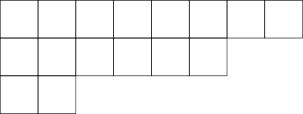


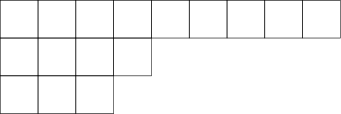


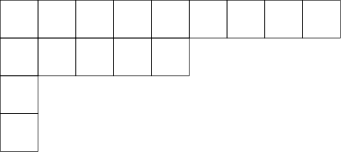


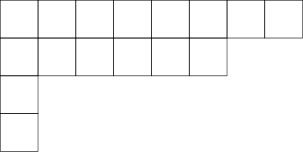


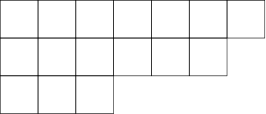


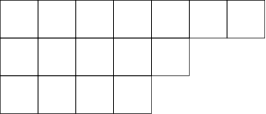


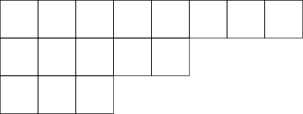


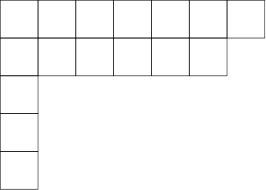


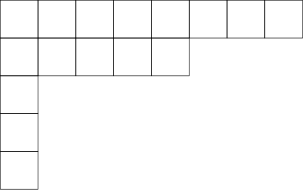


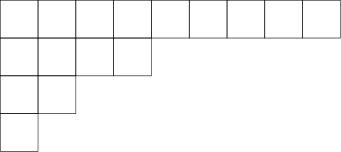


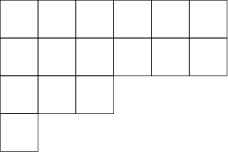


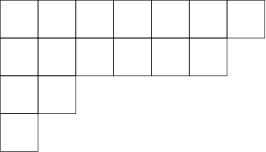


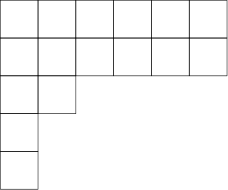


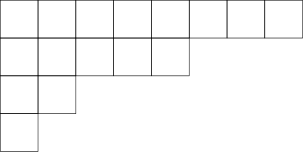


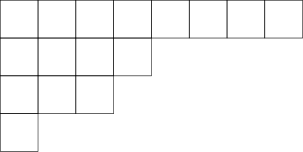


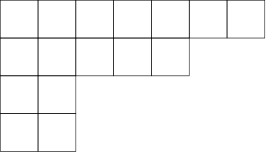


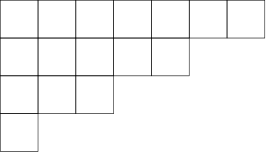


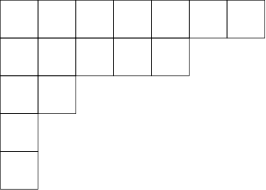

Tensor multiplicand 1:



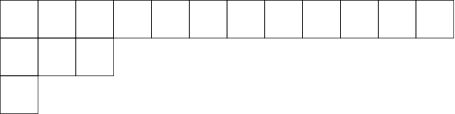

Tensor multiplicand 2:



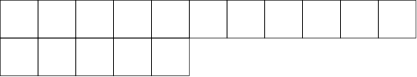

Tensor constituent(s):



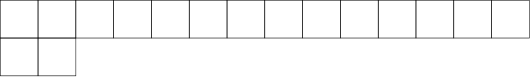


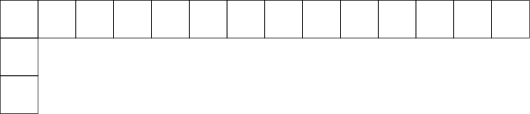


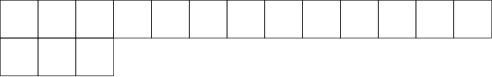


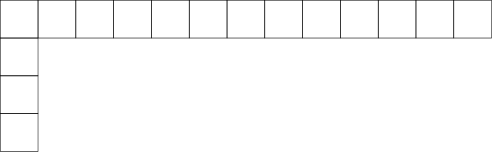


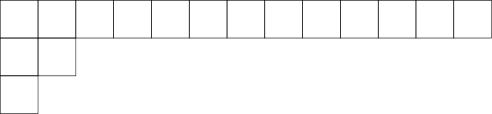


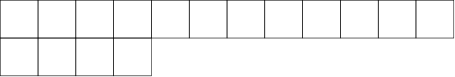


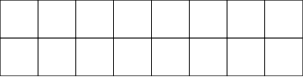


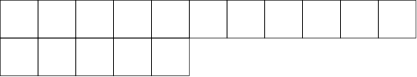


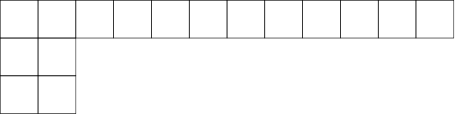


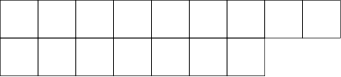


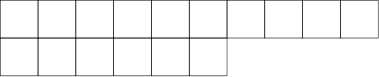


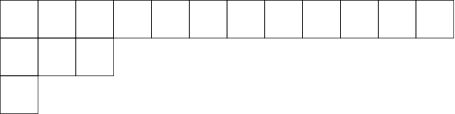


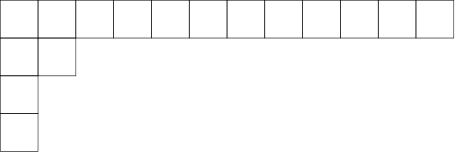


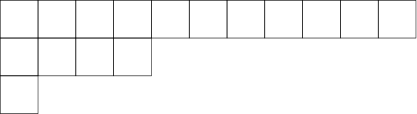


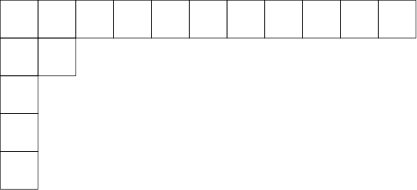


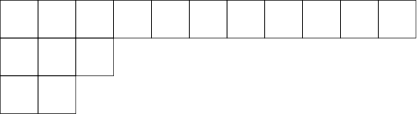


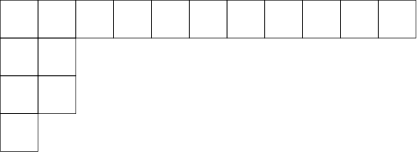


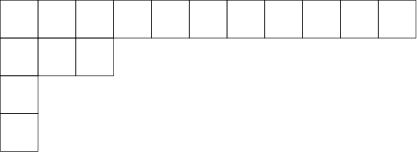


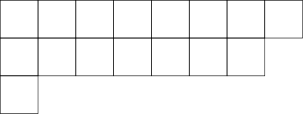


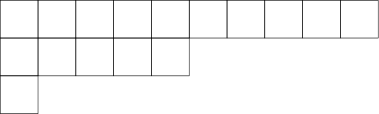


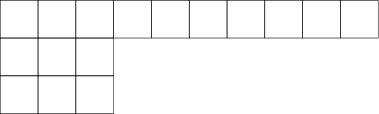


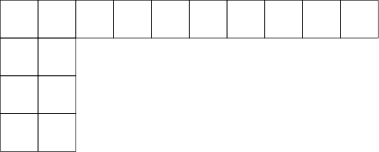


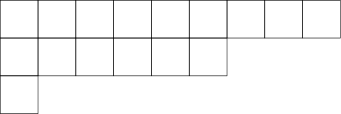


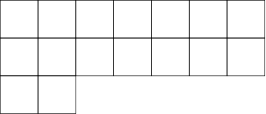


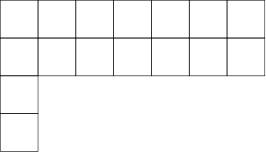


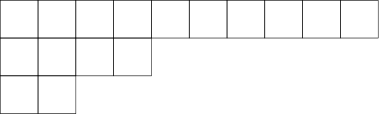


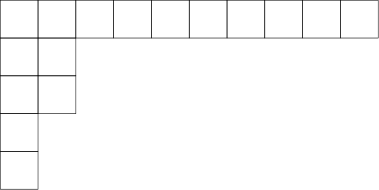


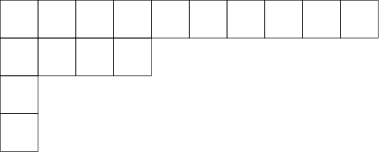


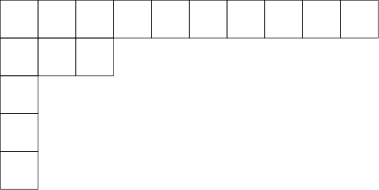


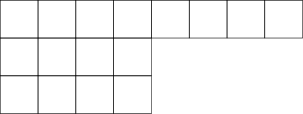


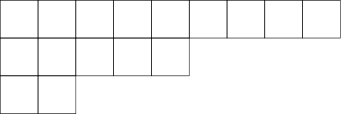


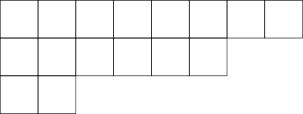


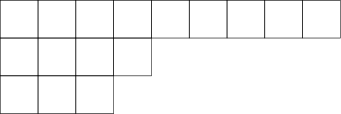


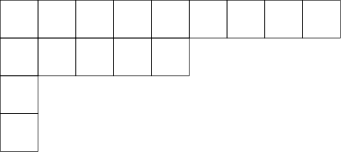


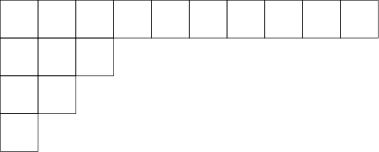


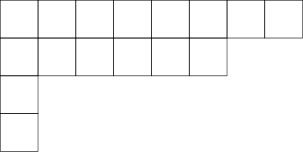


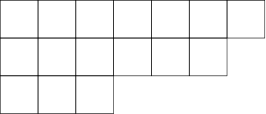


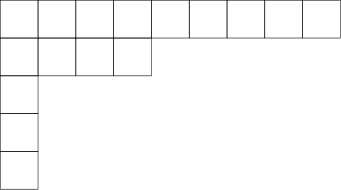


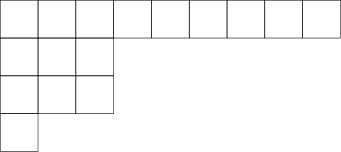


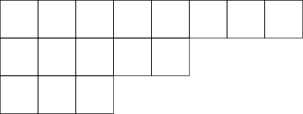


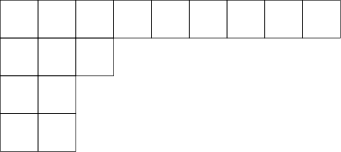


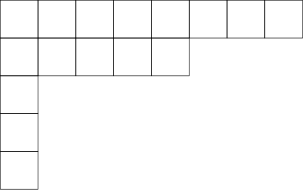


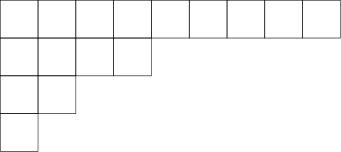


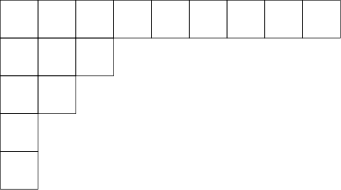


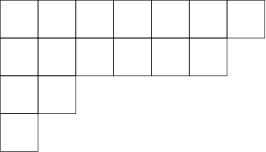


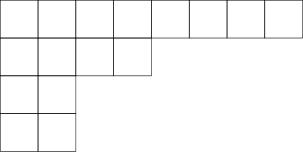


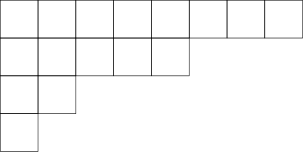


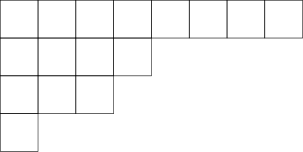


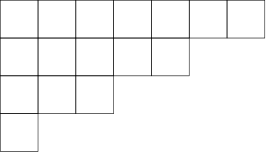


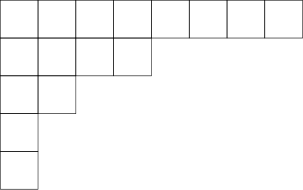

Tensor multiplicand 1:



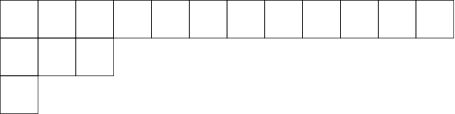

Tensor multiplicand 2:



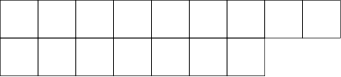

Tensor constituent(s):



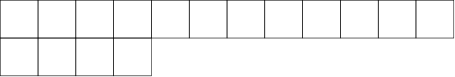


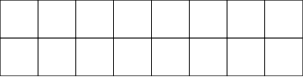


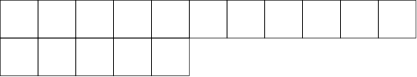


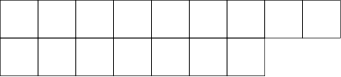


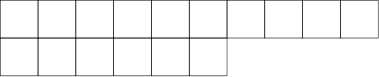


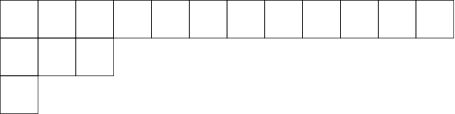


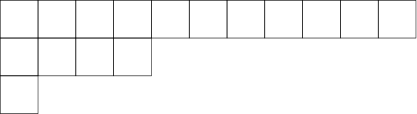


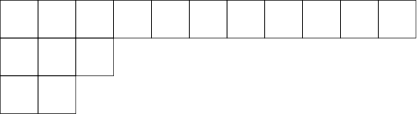


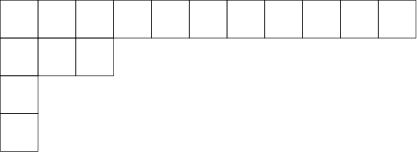


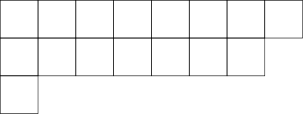


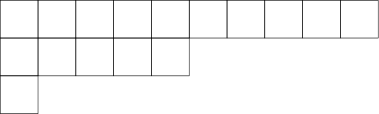


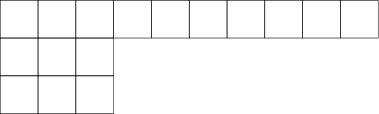


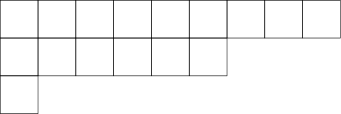


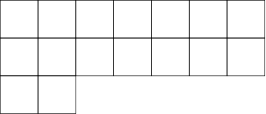


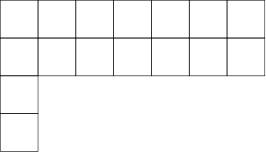


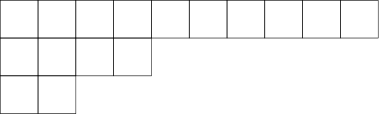


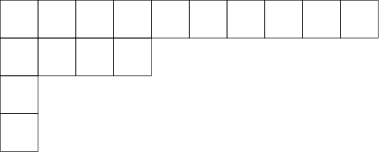


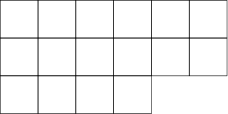


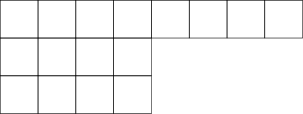


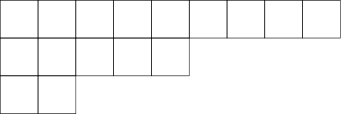


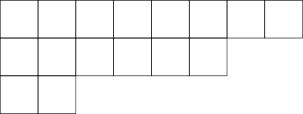


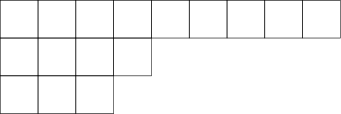


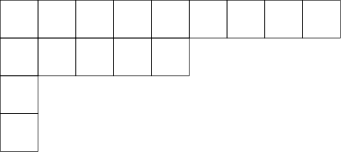


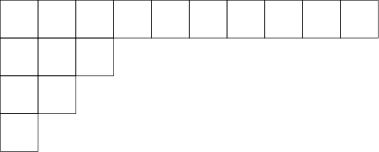


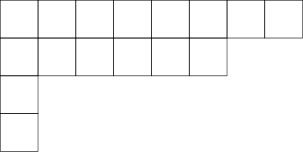


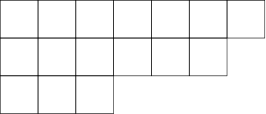


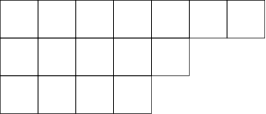


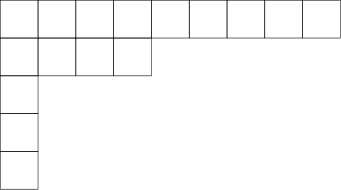


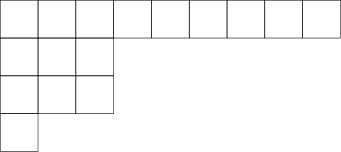


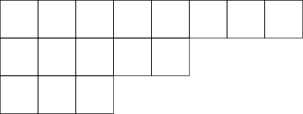


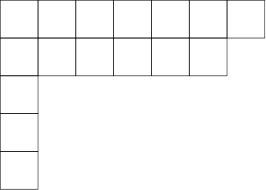


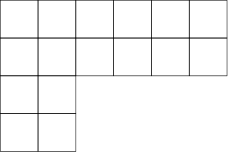


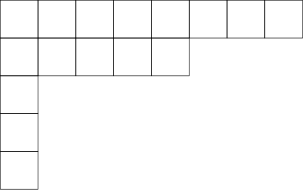


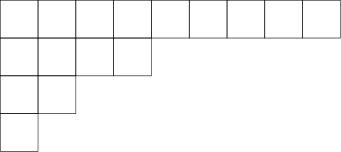


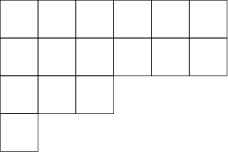


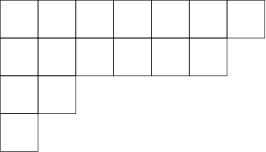


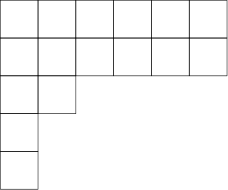


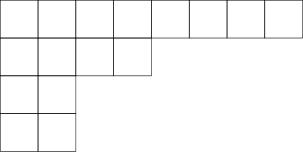


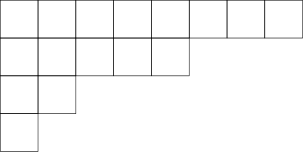


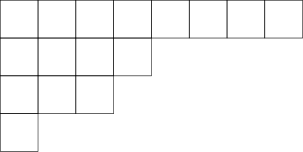


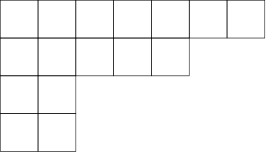


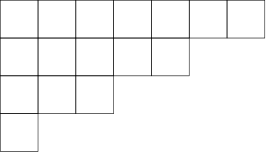


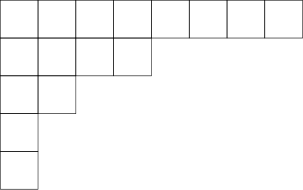


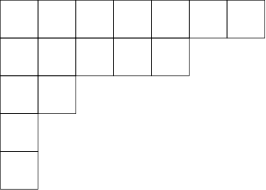

Tensor multiplicand 1:



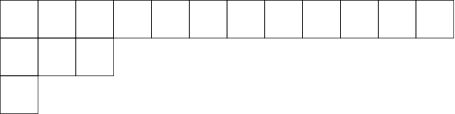

Tensor multiplicand 2:



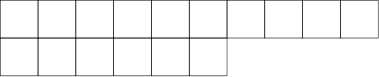

Tensor constituent(s):



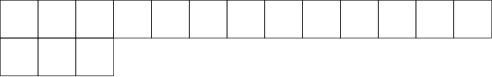


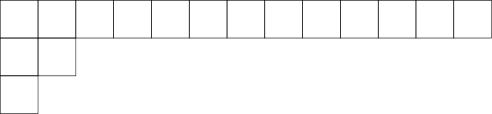


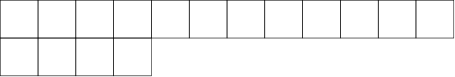


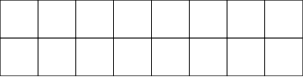


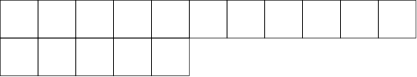


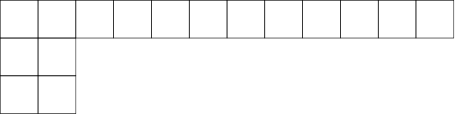


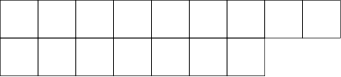


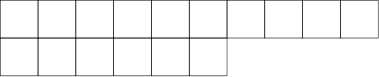


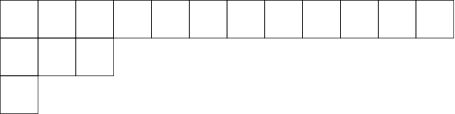


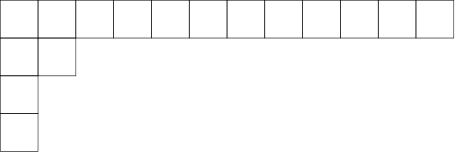


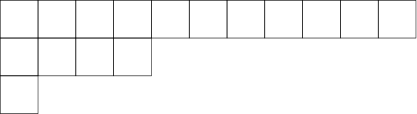


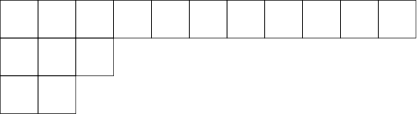


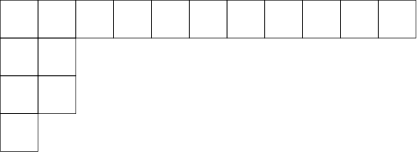


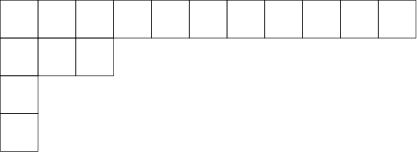


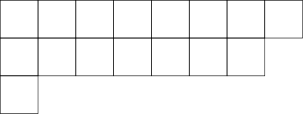


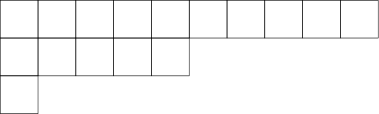


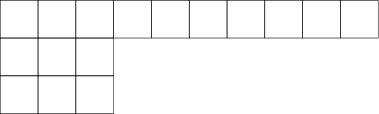


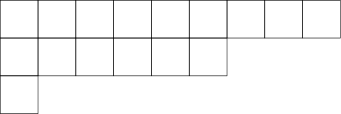


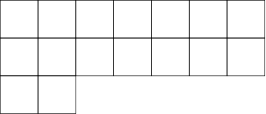


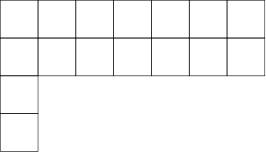


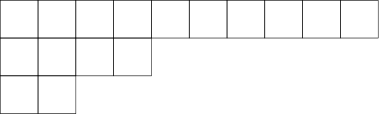


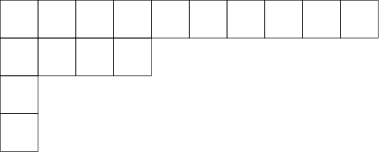


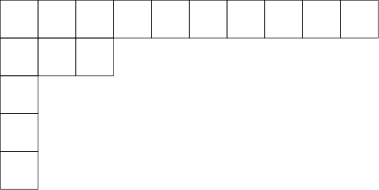


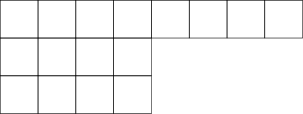


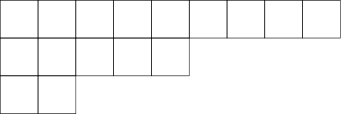


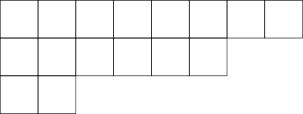


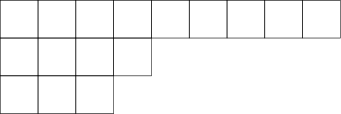


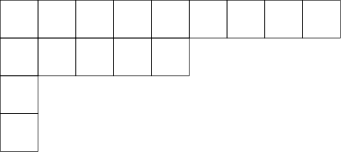


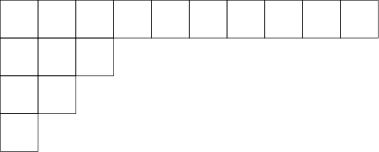


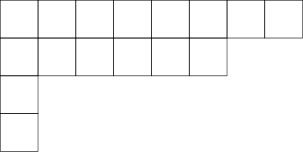


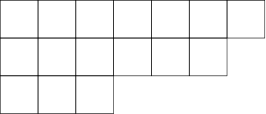


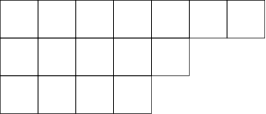


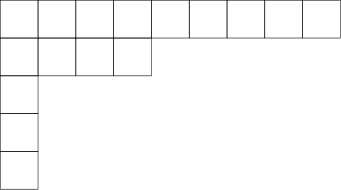


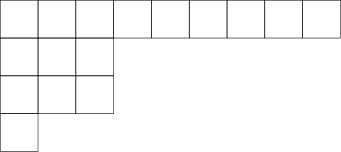


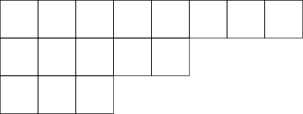


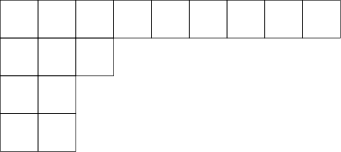


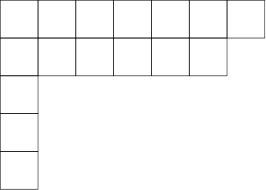


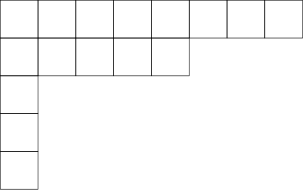


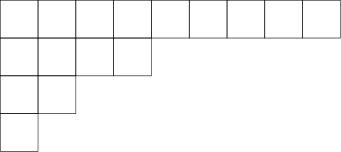


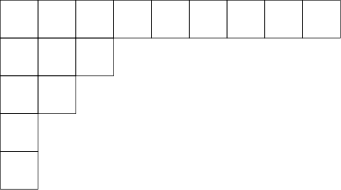


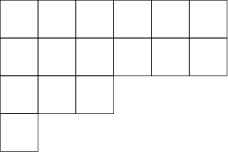


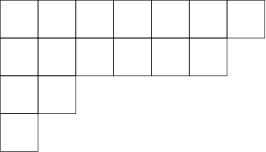


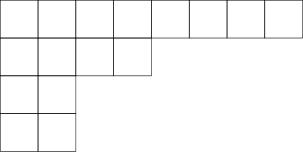


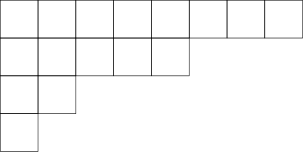


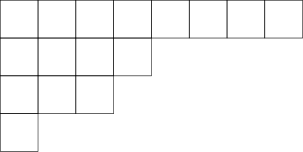


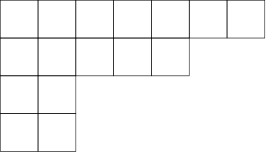


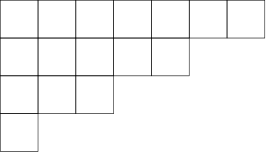


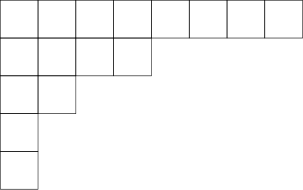


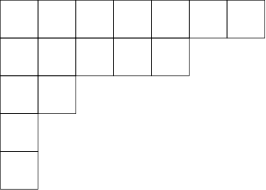

Tensor multiplicand 1:



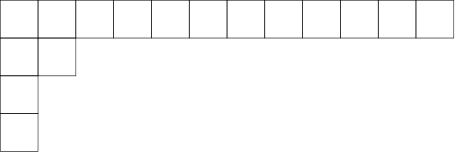

Tensor multiplicand 2:



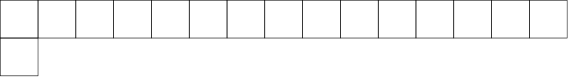

Tensor constituent(s):



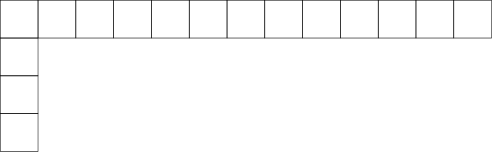


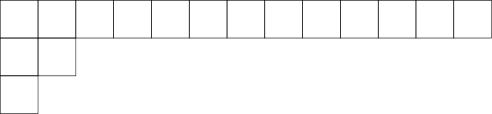


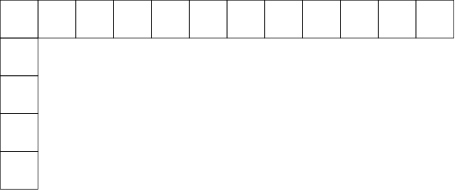


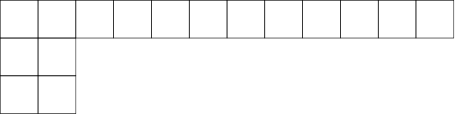


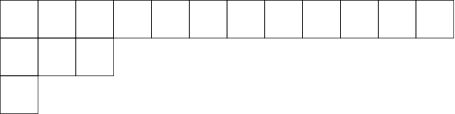


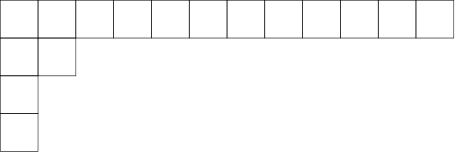


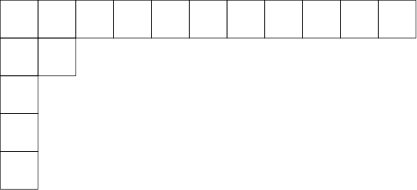


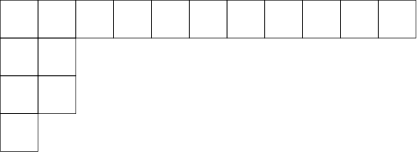


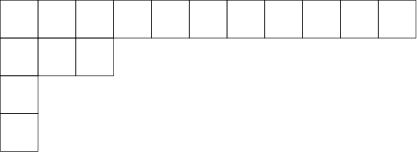

Tensor multiplicand 1:



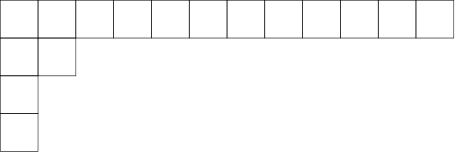

Tensor multiplicand 2:



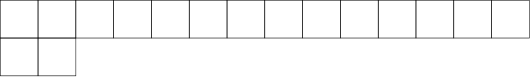

Tensor constituent(s):



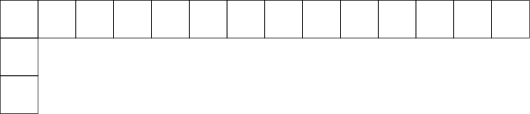


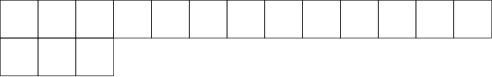


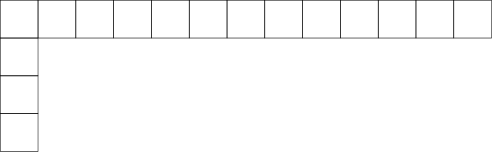


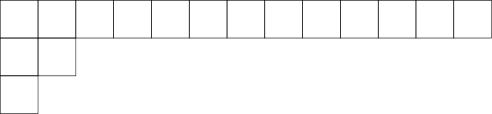


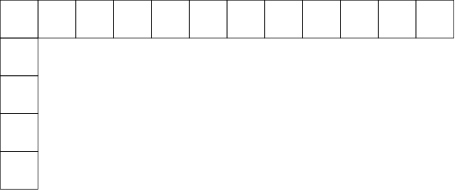


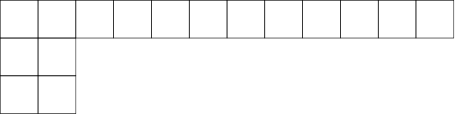


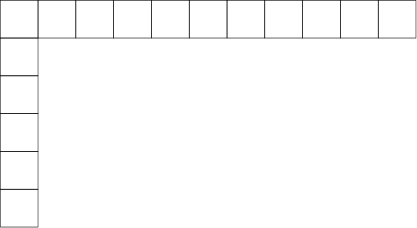


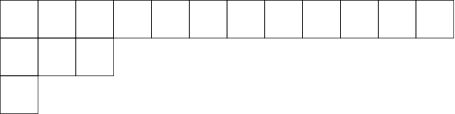


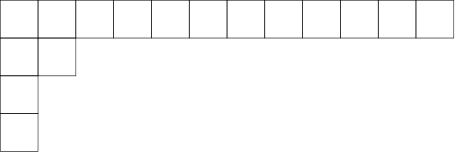


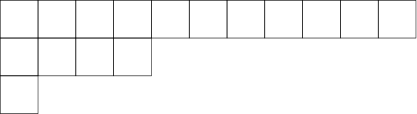


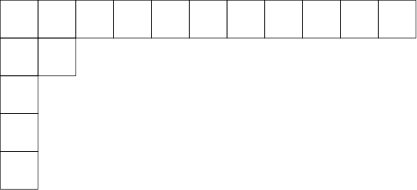


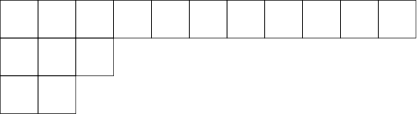


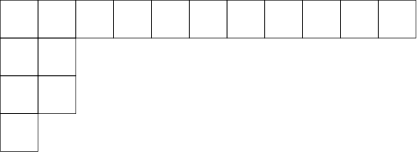


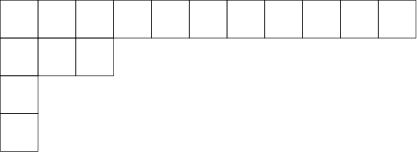


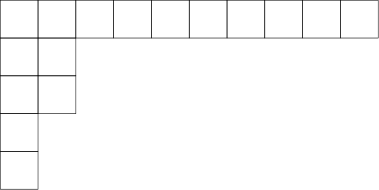


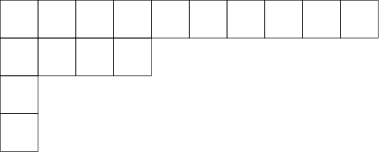


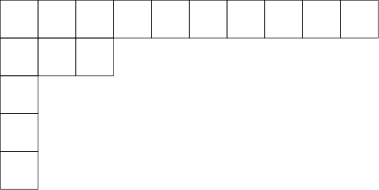


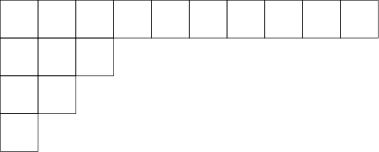

Tensor multiplicand 1:



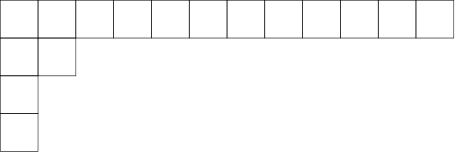

Tensor multiplicand 2:



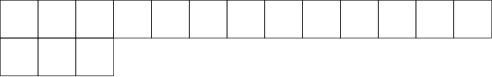

Tensor constituent(s):



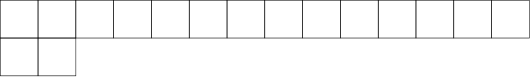


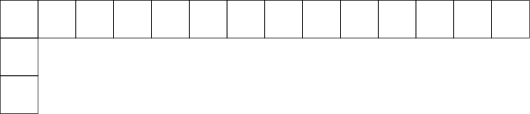


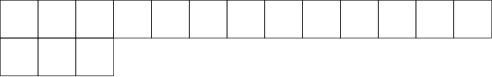


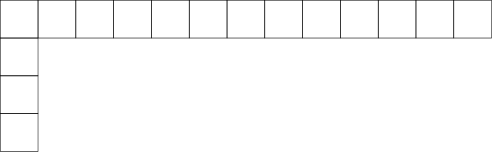


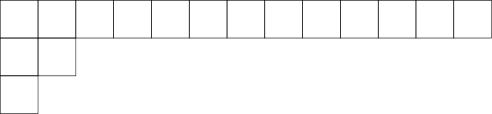


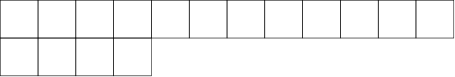


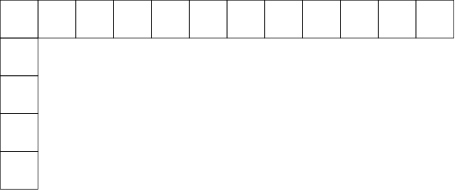


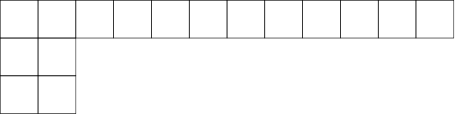


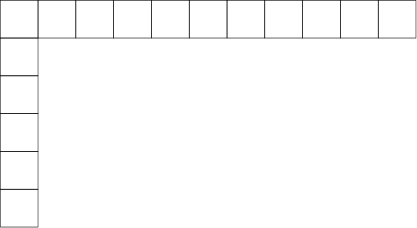


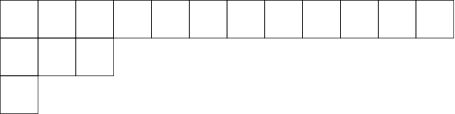


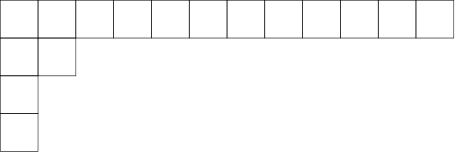


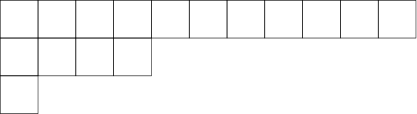


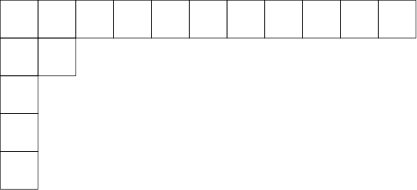


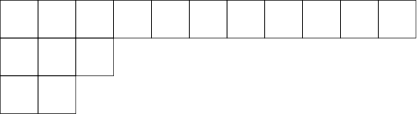


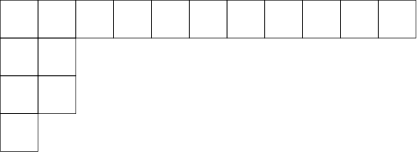


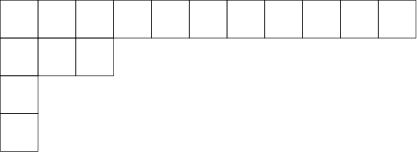


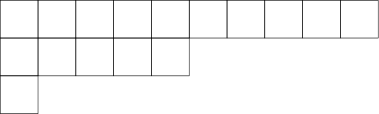


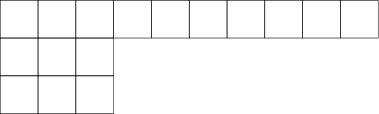


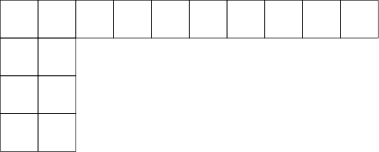


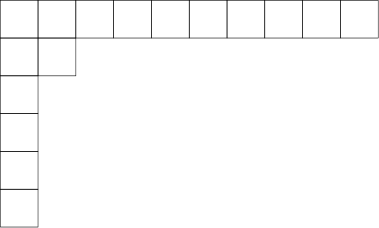


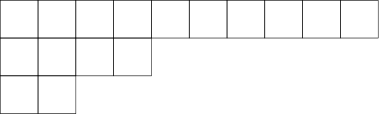


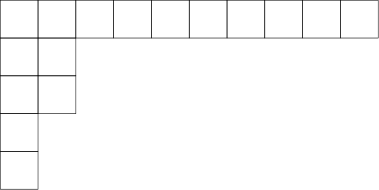


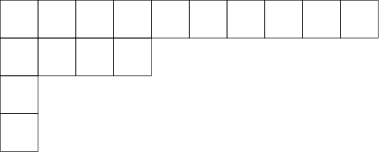


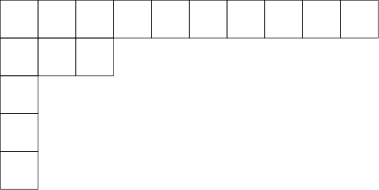


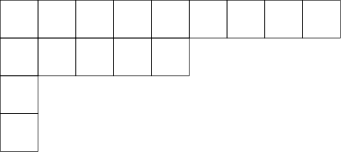


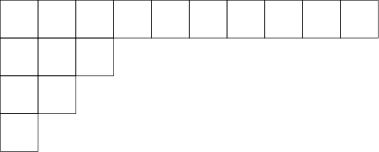


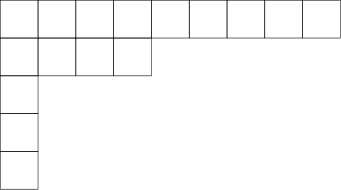


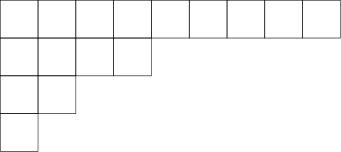


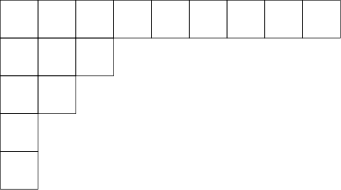

Tensor multiplicand 1:



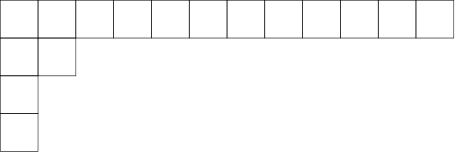

Tensor multiplicand 2:



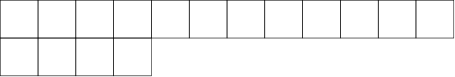

Tensor constituent(s):



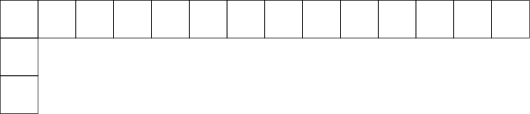


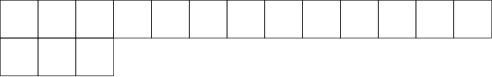


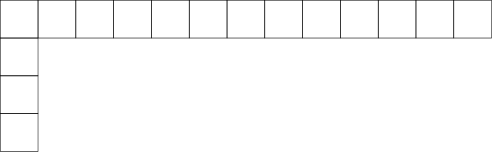


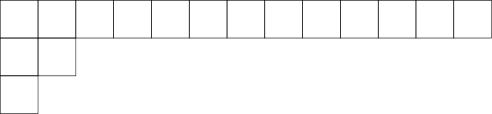


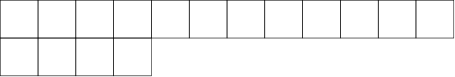


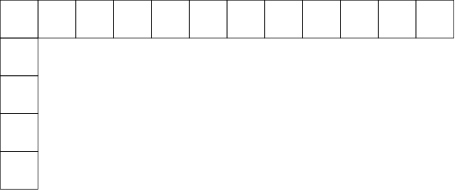


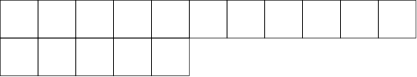


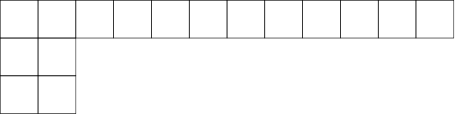


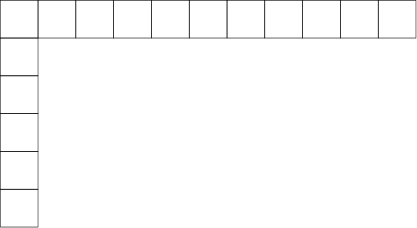


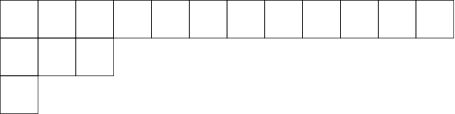


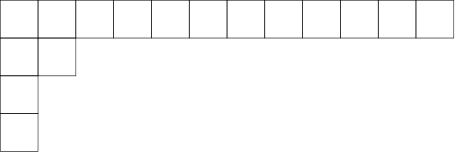


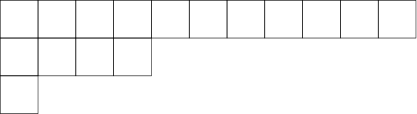


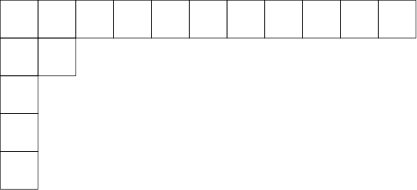


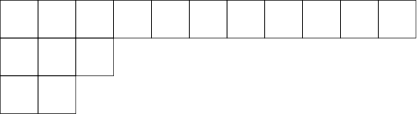


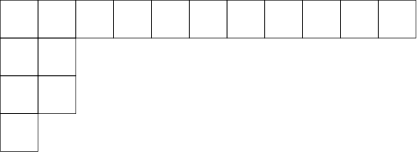


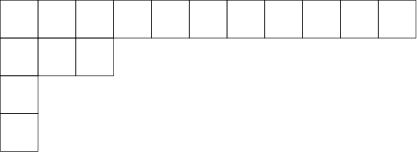


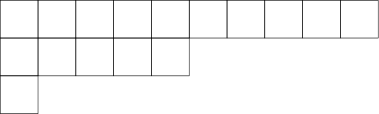


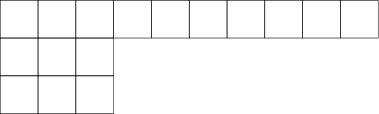


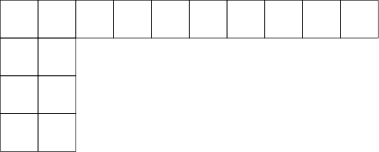


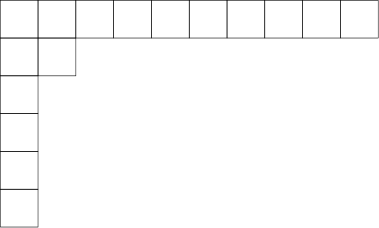


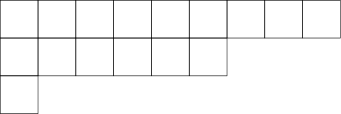


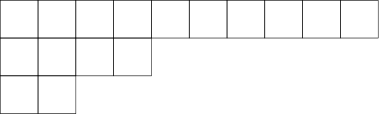


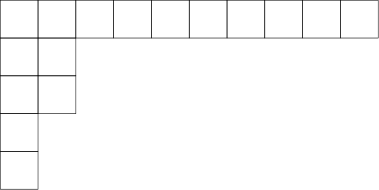


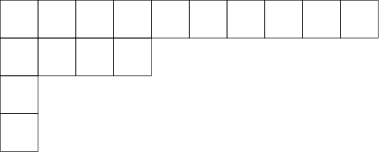


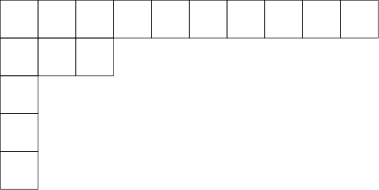


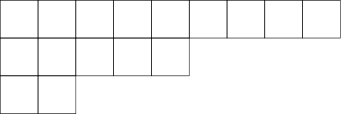


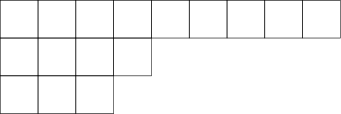


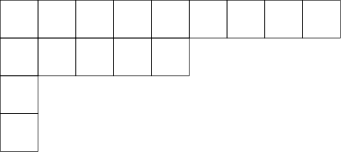


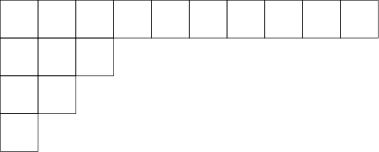


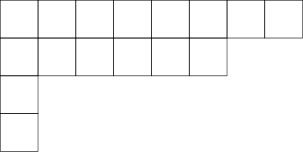


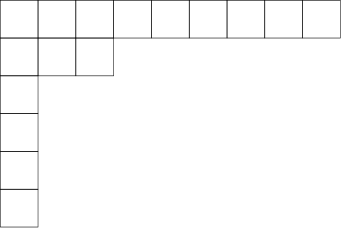


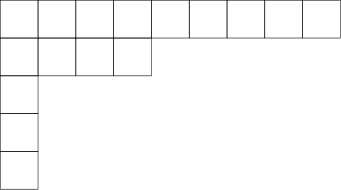


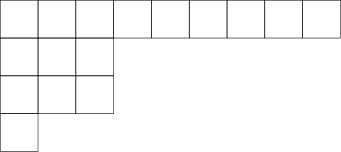


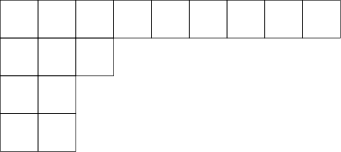


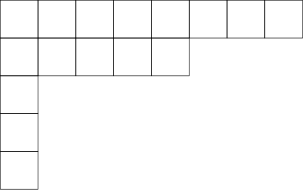


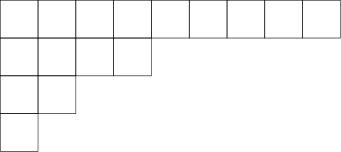


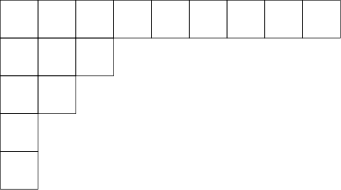


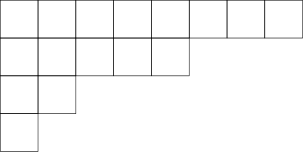


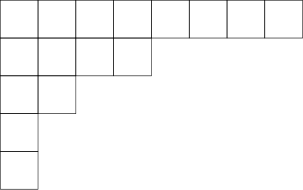

Tensor multiplicand 1:



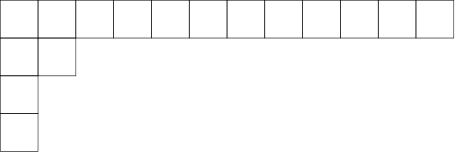

Tensor multiplicand 2:



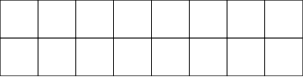

Tensor constituent(s):



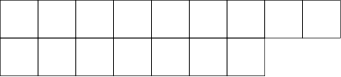


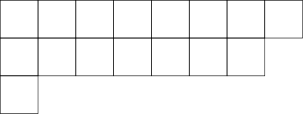


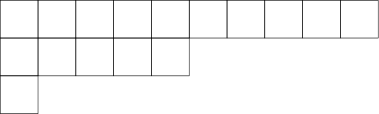


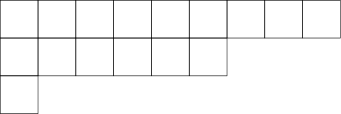


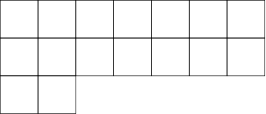


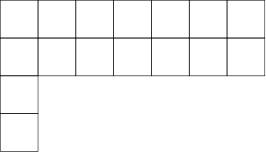


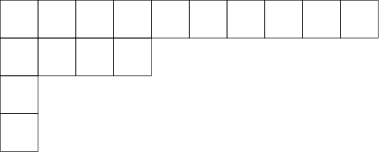


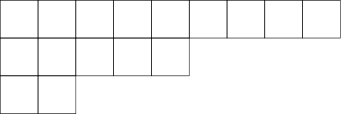


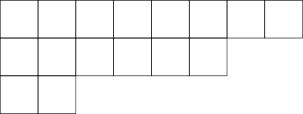


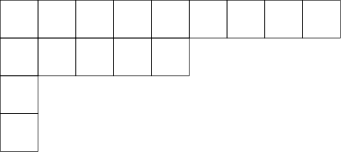


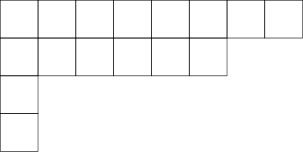


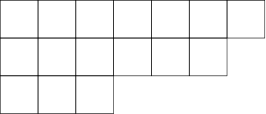


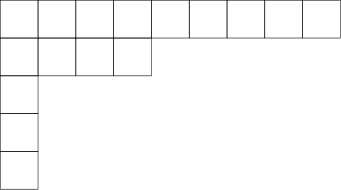


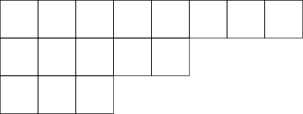


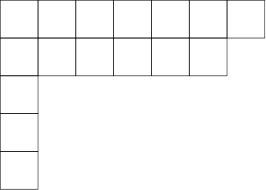


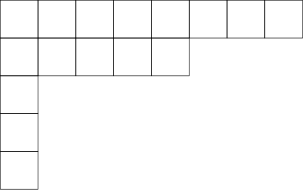


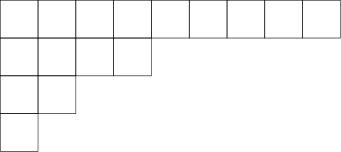


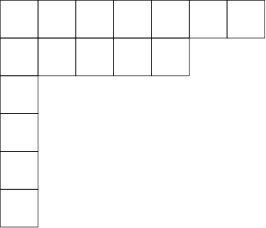


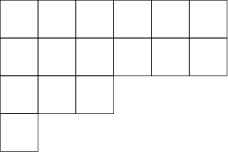


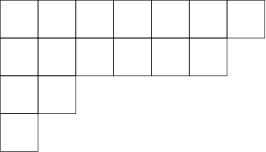


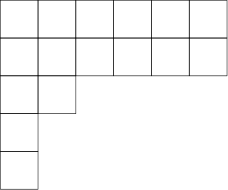


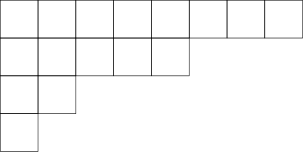


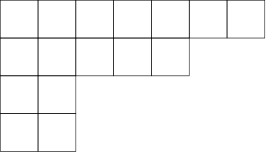


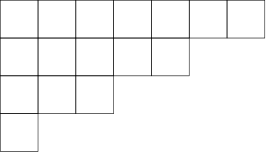


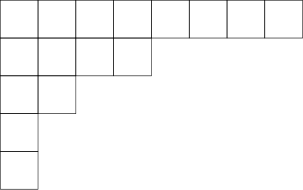


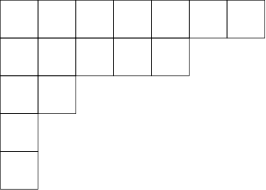

Tensor multiplicand 1:



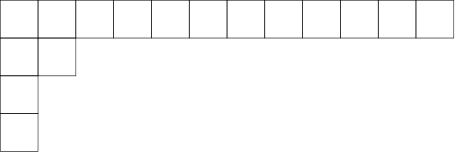

Tensor multiplicand 2:



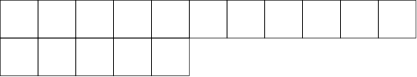

Tensor constituent(s):



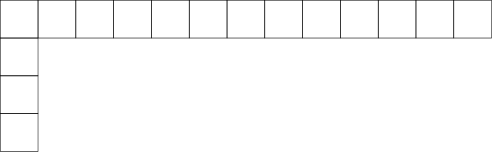


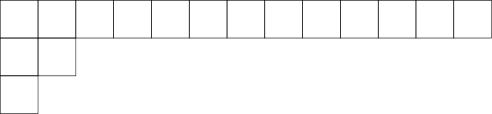


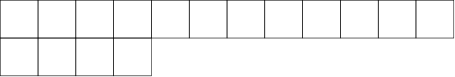


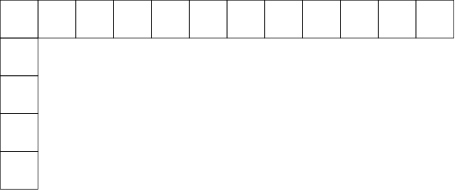


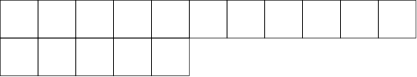


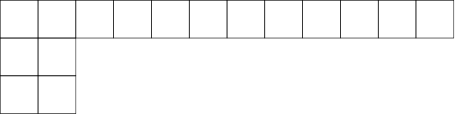


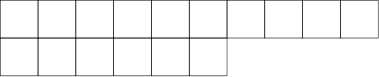


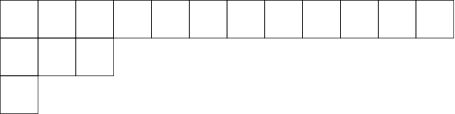


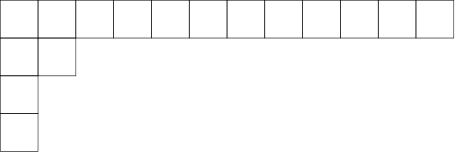


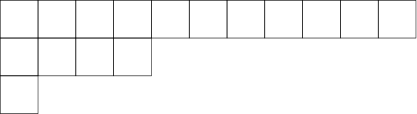


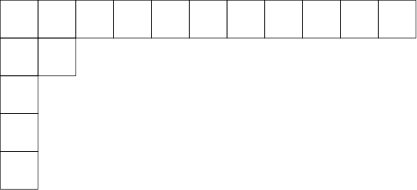


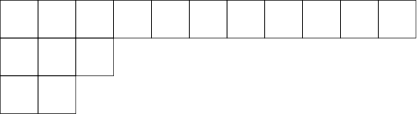


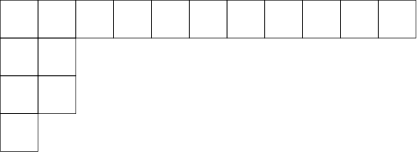


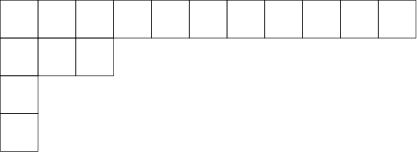


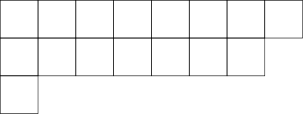


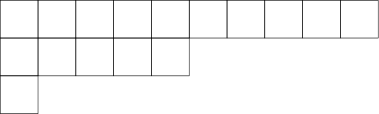


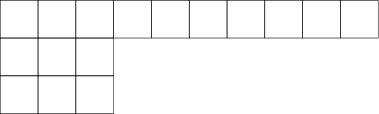


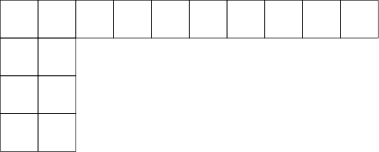


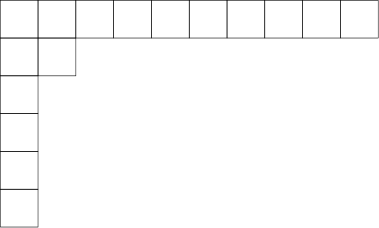


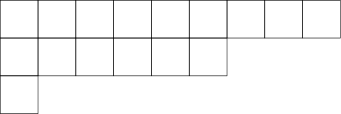


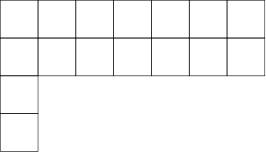


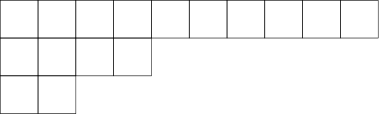


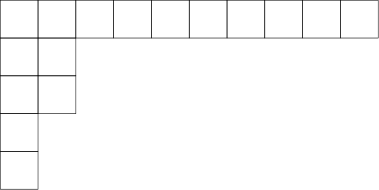


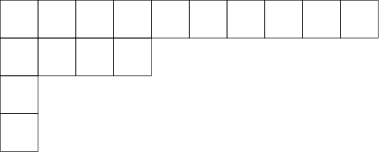


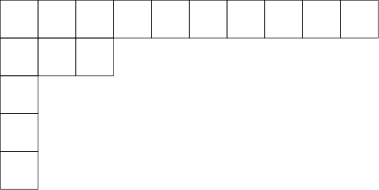


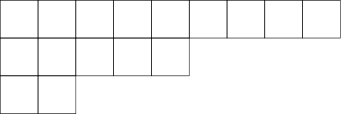


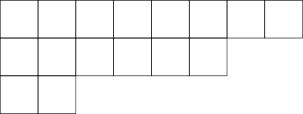


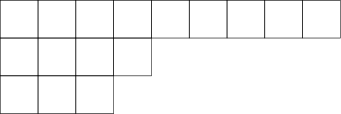


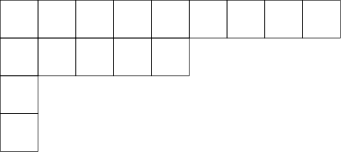


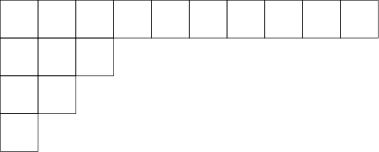


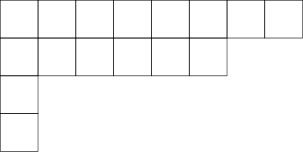


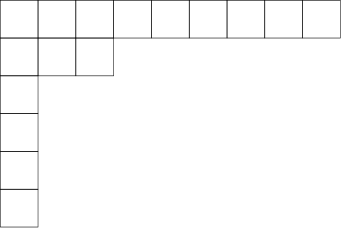


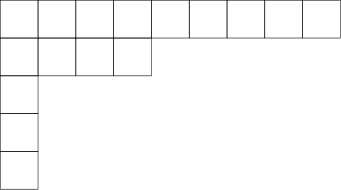


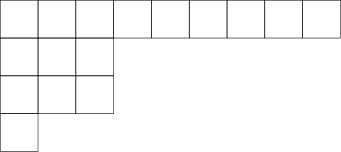


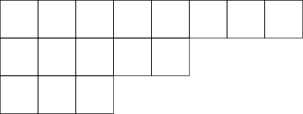


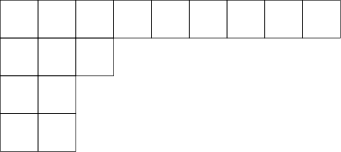


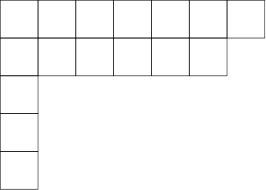


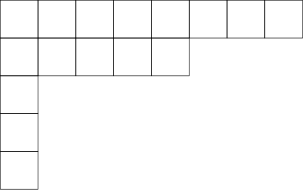


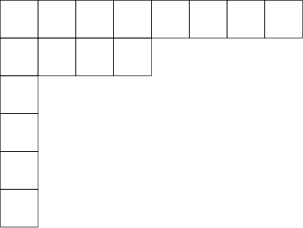


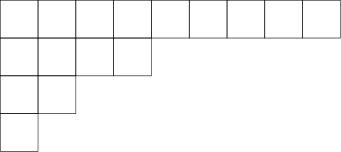


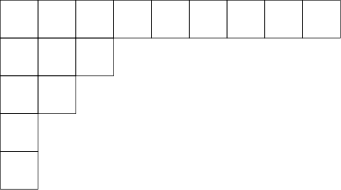


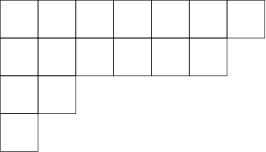


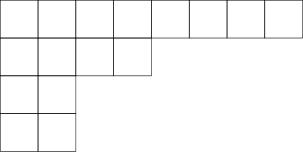


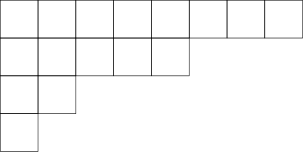


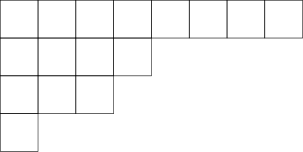


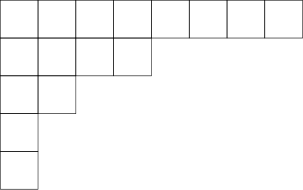


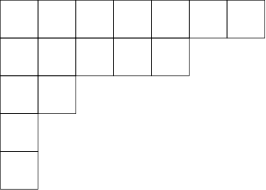

Tensor multiplicand 1:



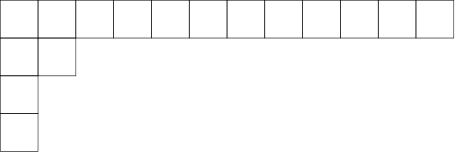

Tensor multiplicand 2:



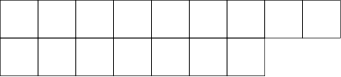

Tensor constituent(s):



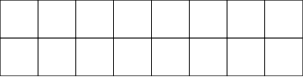


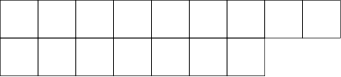


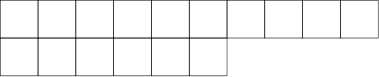


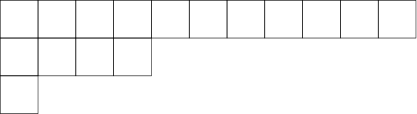


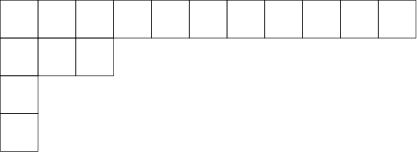


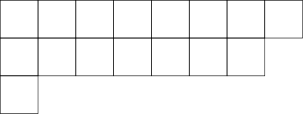


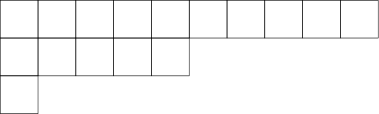


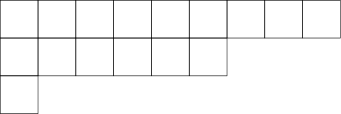


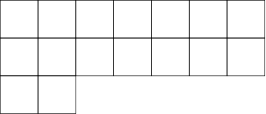


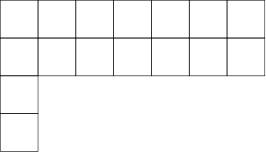


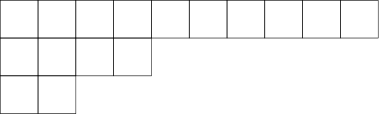


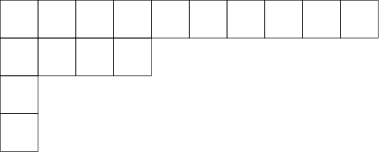


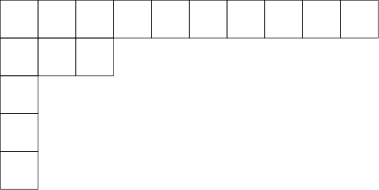


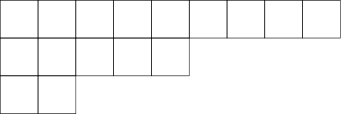


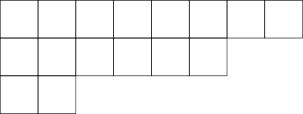


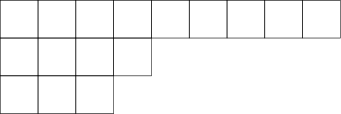


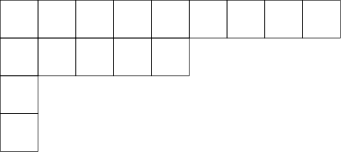


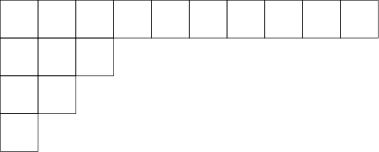


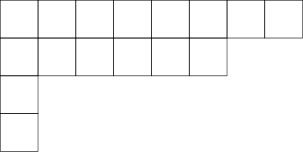


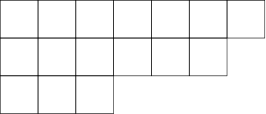


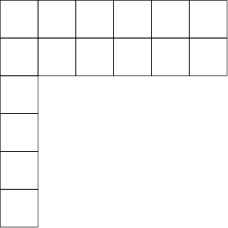


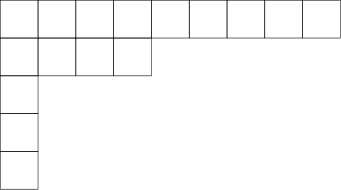


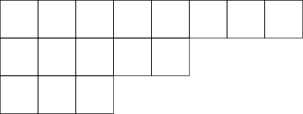


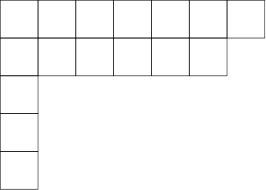


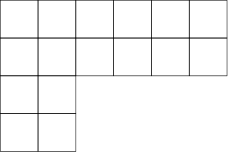


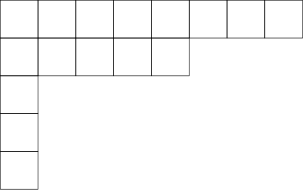


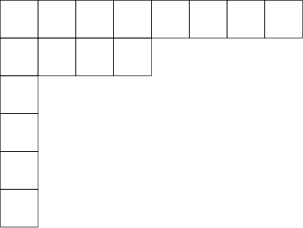


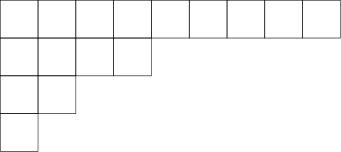


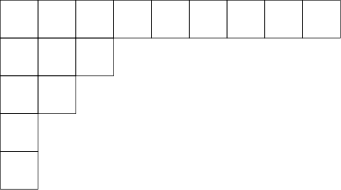


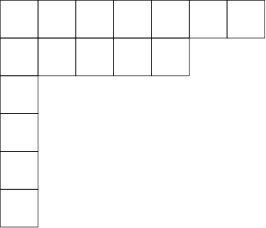


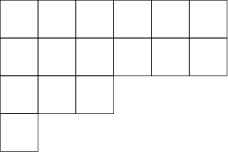


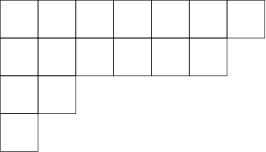


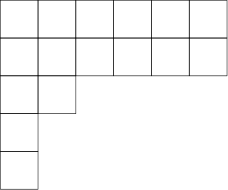


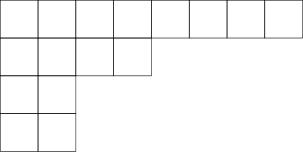


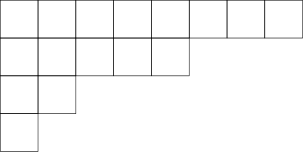


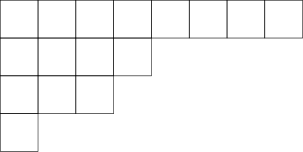


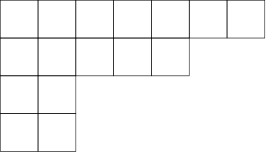


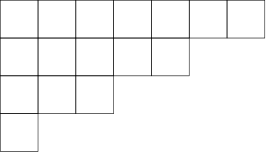


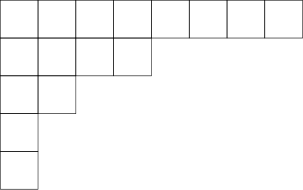


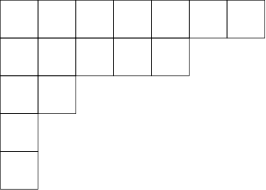

Tensor multiplicand 1:



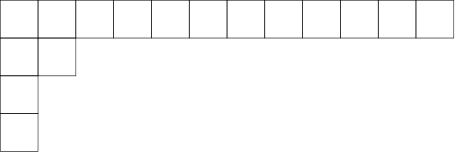

Tensor multiplicand 2:



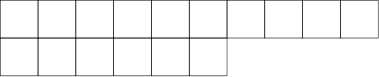

Tensor constituent(s):



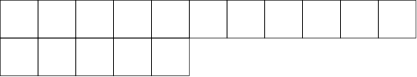


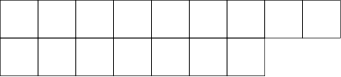


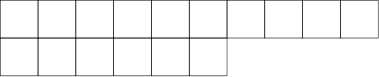


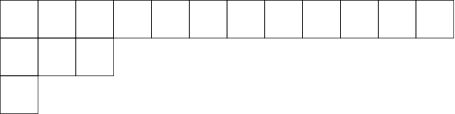


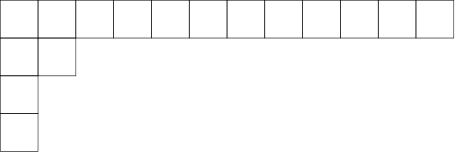


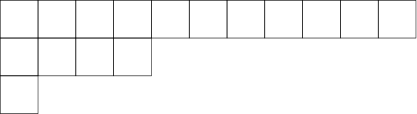


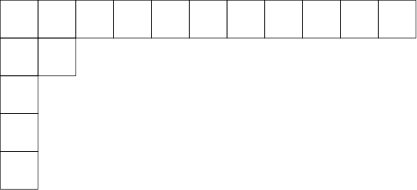


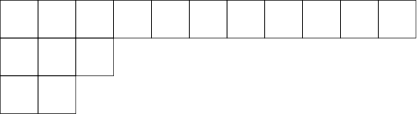


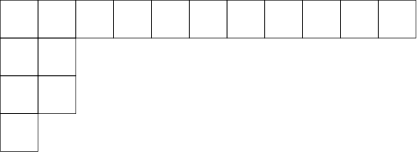


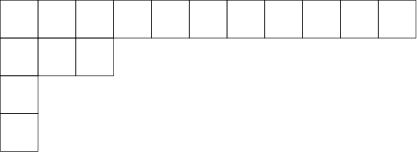


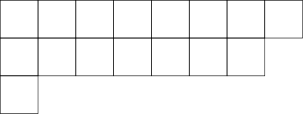


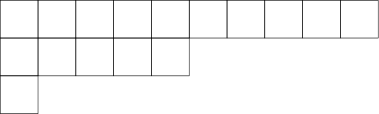


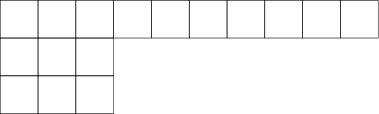


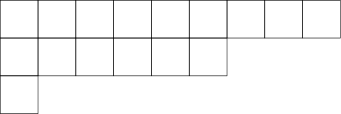


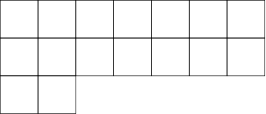


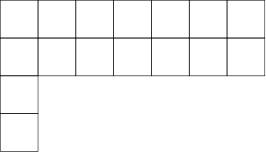


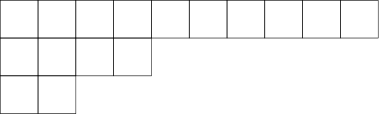


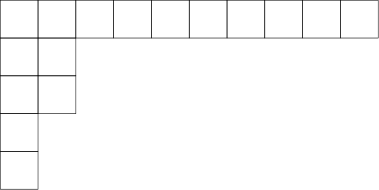


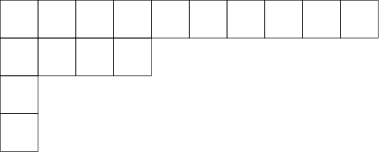


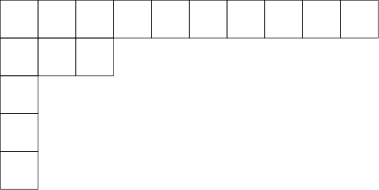


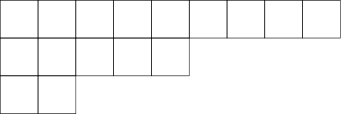


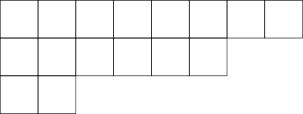


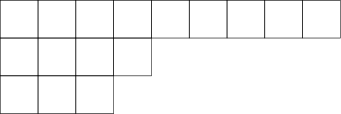


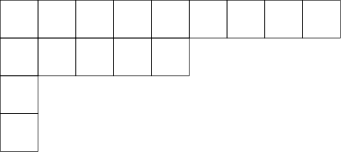


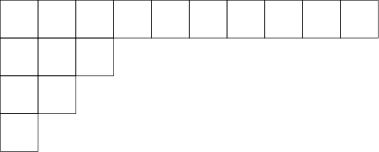


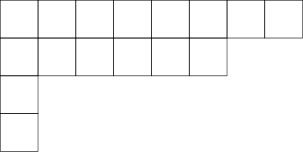


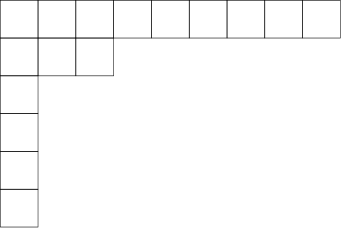


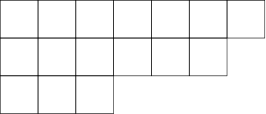


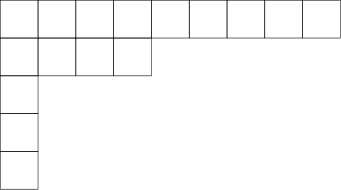


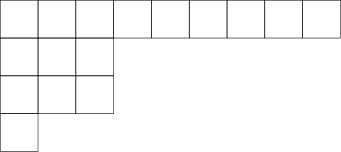


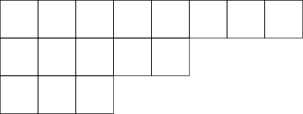


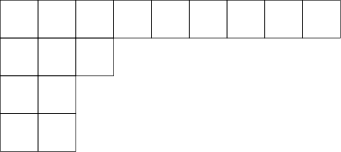


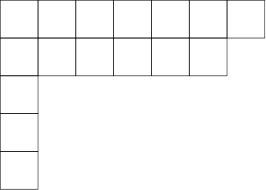


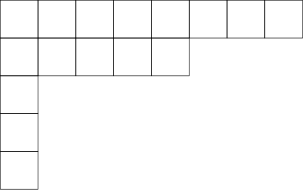


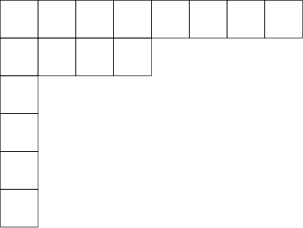


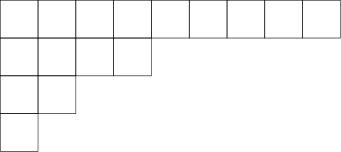


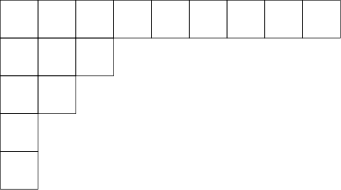


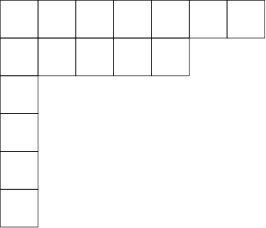


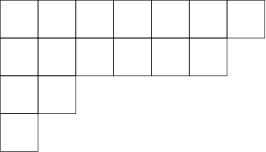


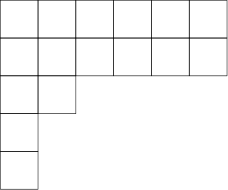


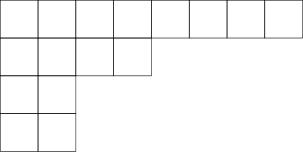


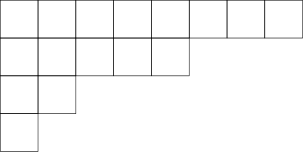


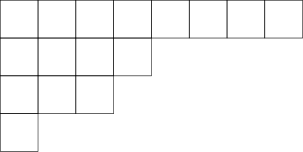


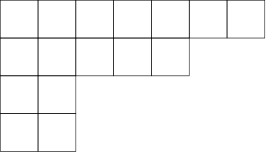


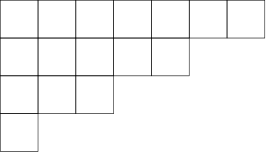


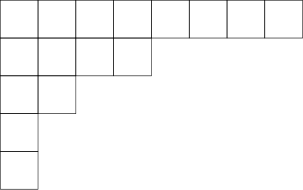


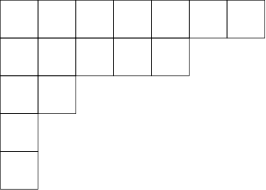

Tensor multiplicand 1:



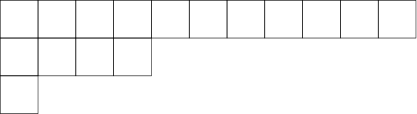

Tensor multiplicand 2:



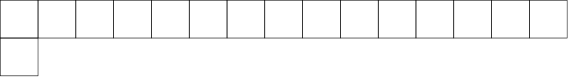

Tensor constituent(s):



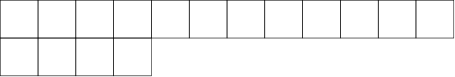


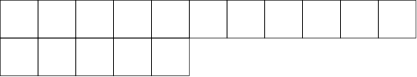


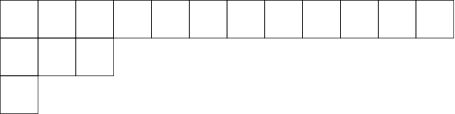


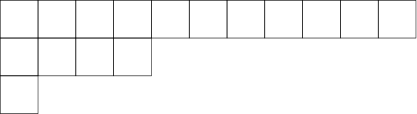


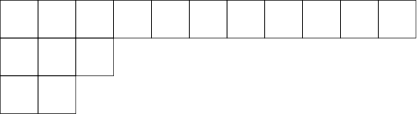


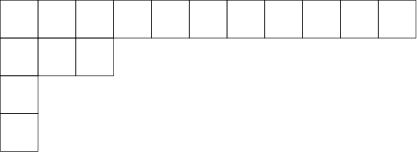


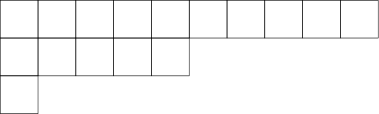


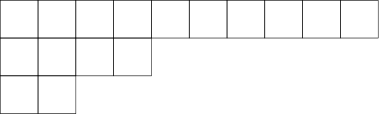


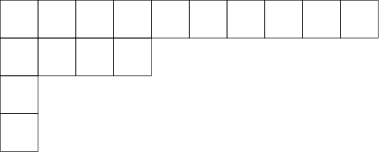

Tensor multiplicand 1:



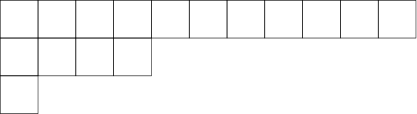

Tensor multiplicand 2:



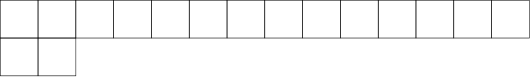

Tensor constituent(s):



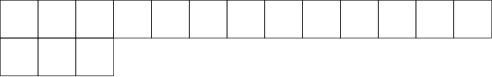


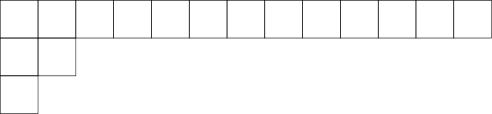


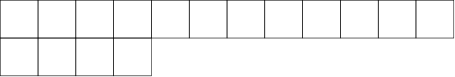


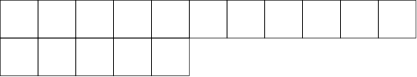


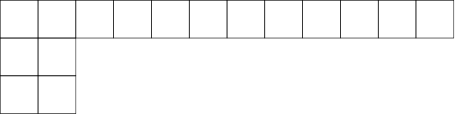


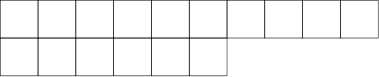


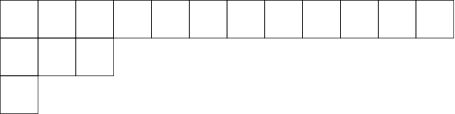


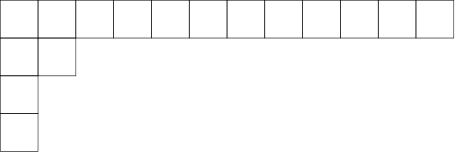


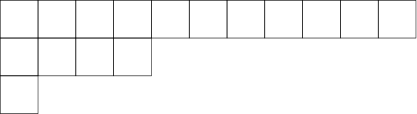


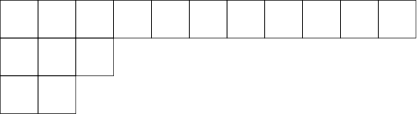


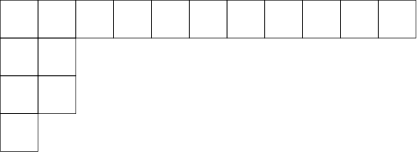


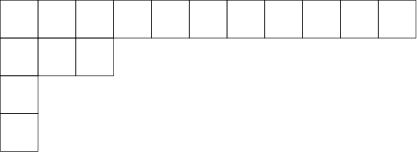


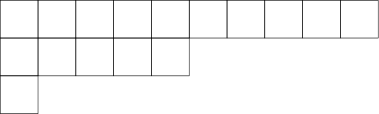


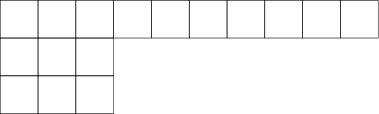


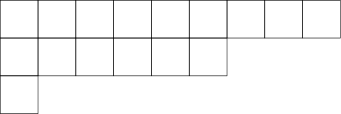


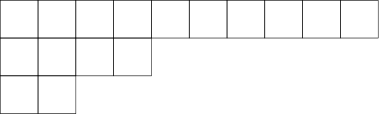


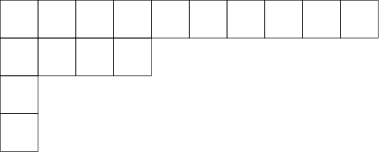


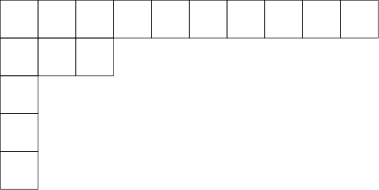


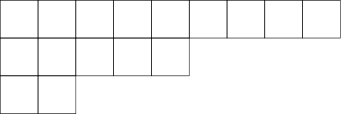


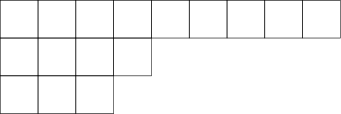


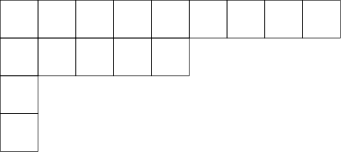


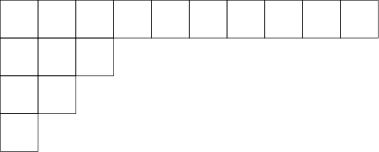


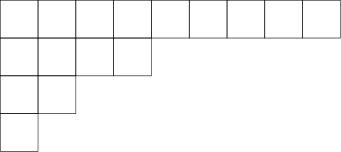

Tensor multiplicand 1:



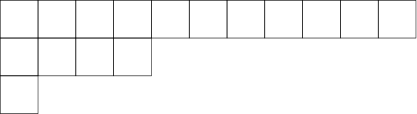

Tensor multiplicand 2:



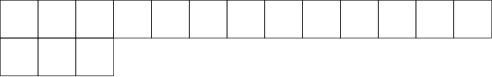

Tensor constituent(s):



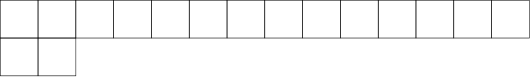


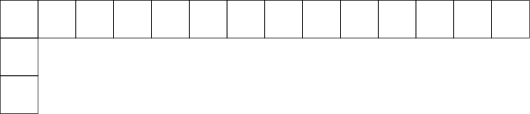


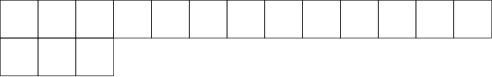


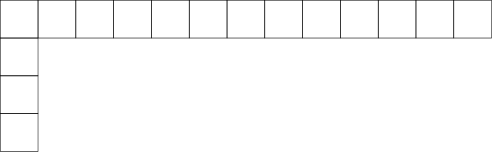


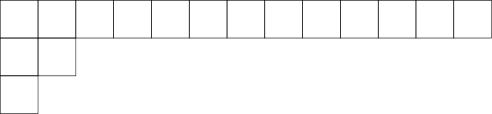


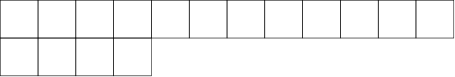


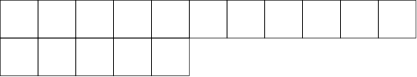


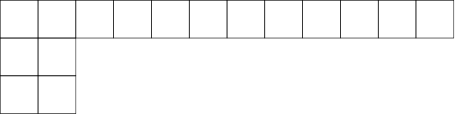


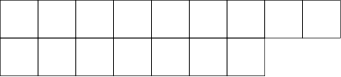


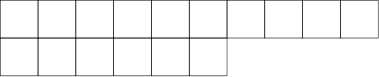


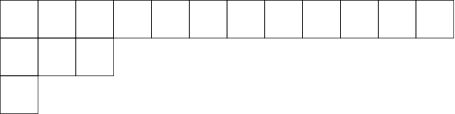


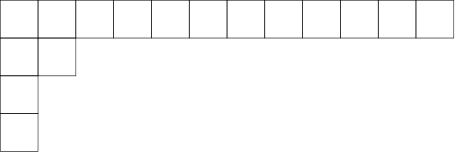


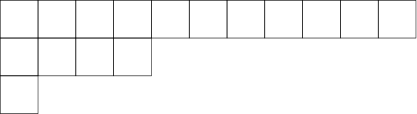


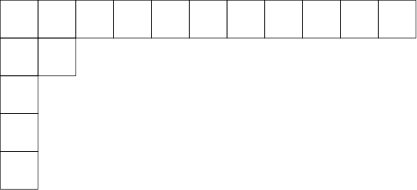


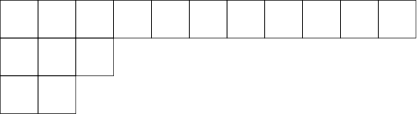


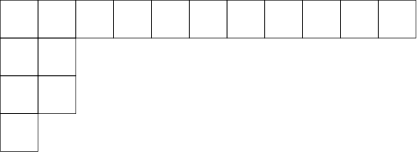


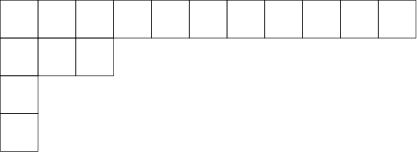


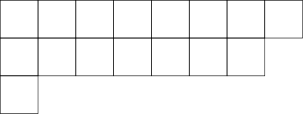


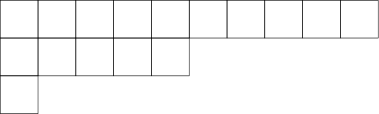


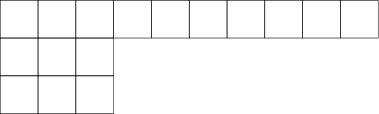


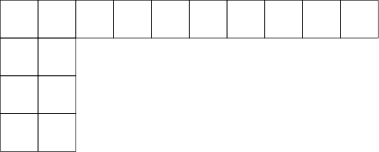


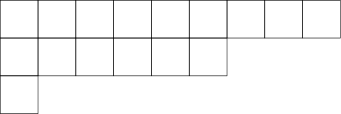


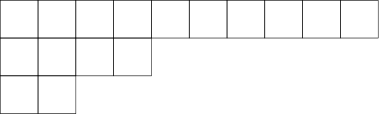


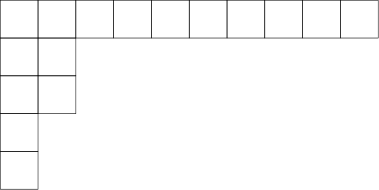


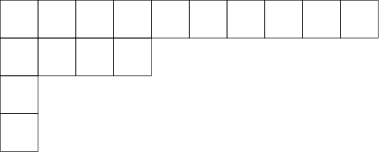


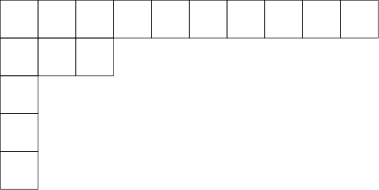


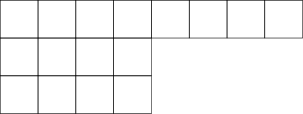


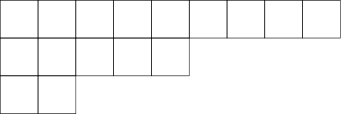


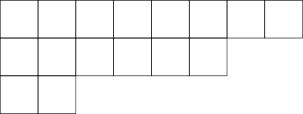


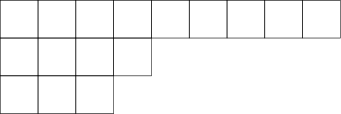


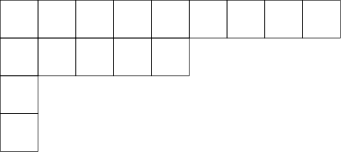


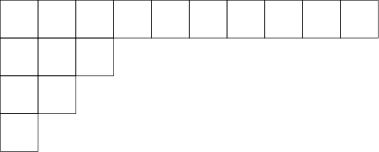


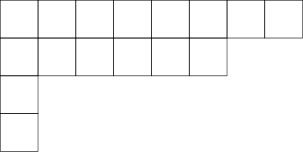


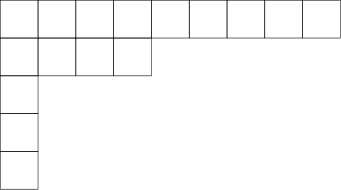


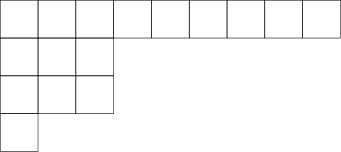


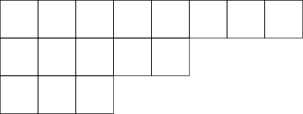


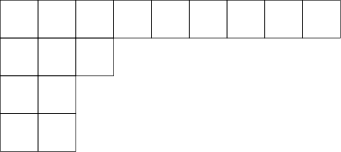


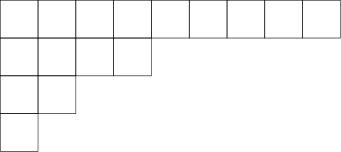


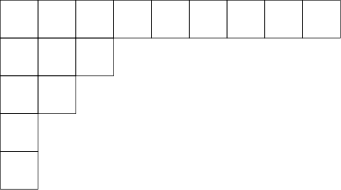


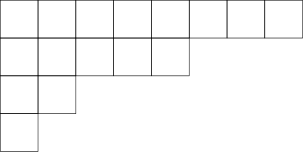


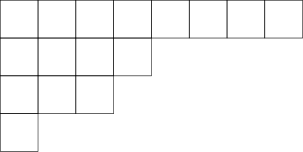

Tensor multiplicand 1:



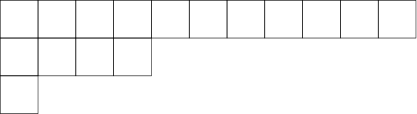

Tensor multiplicand 2:



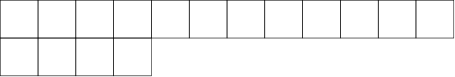

Tensor constituent(s):



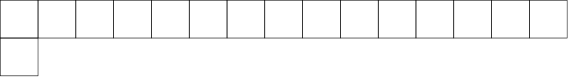


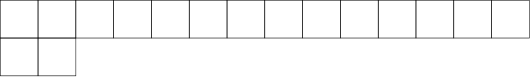


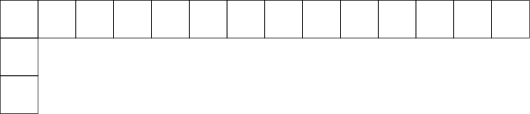


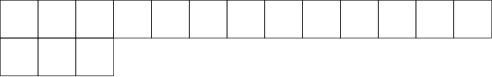


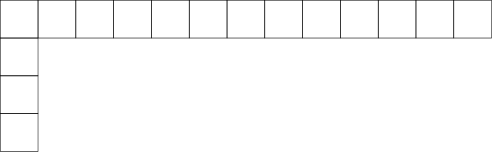


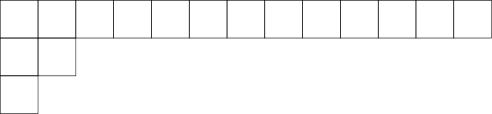


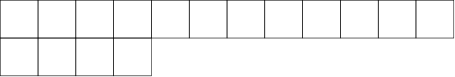


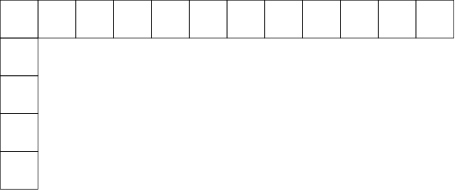


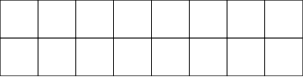


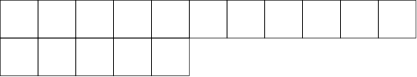


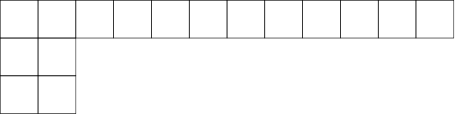


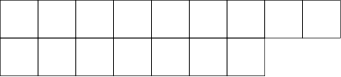


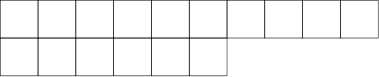


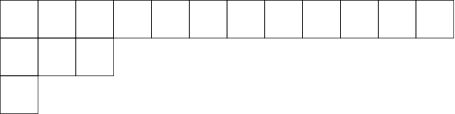


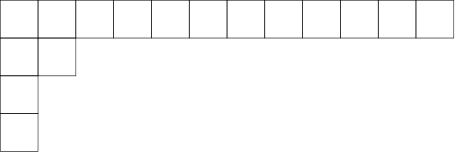


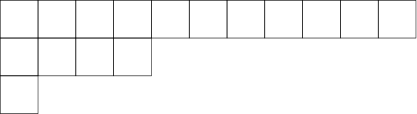


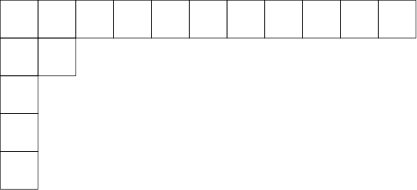


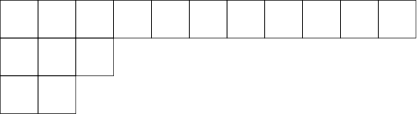


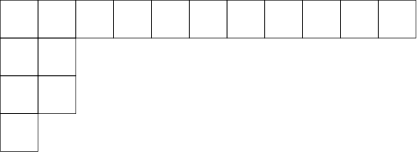


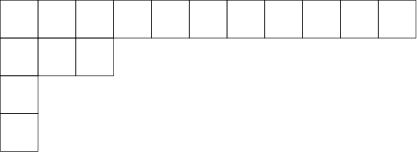


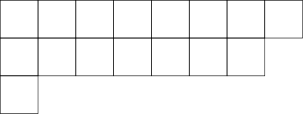


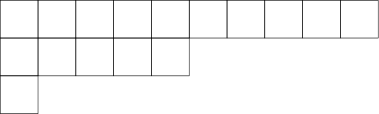


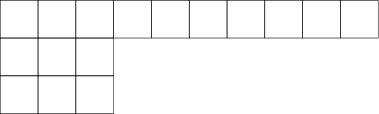


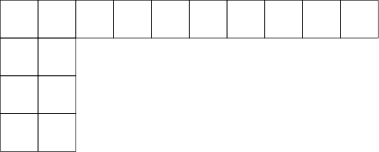


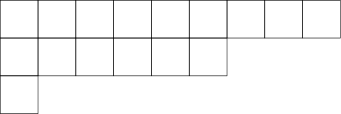


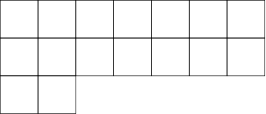


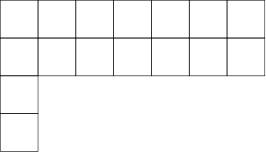


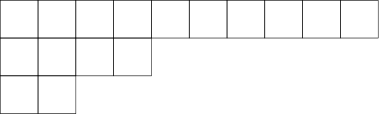


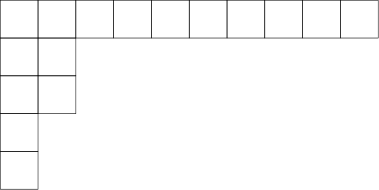


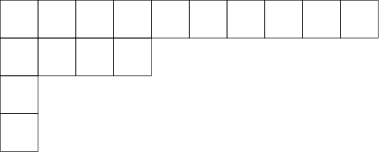


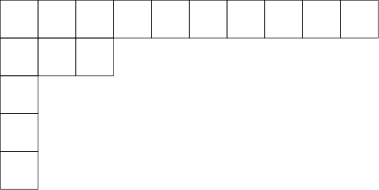


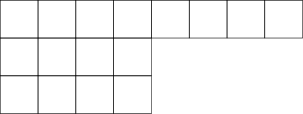


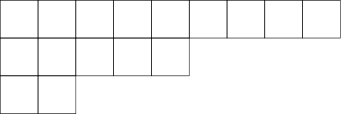


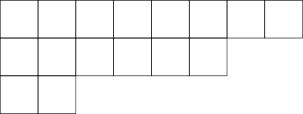


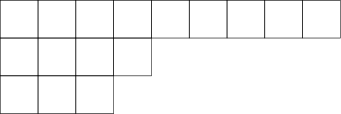


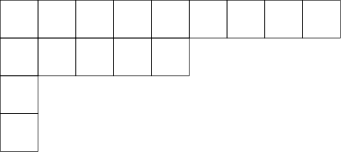


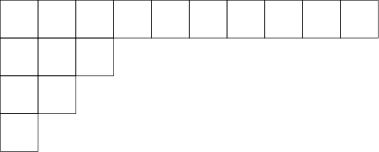


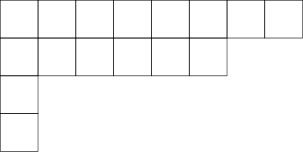


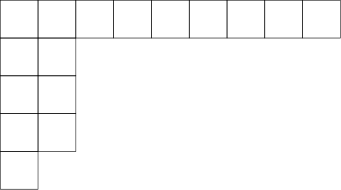


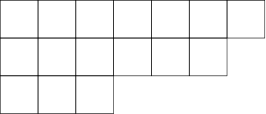


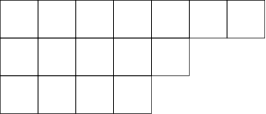


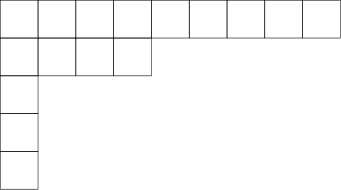


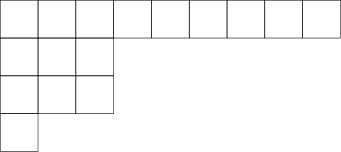


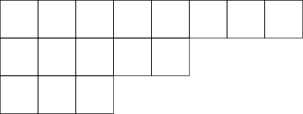


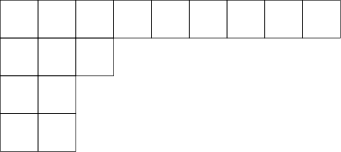


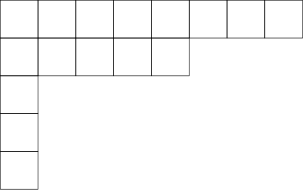


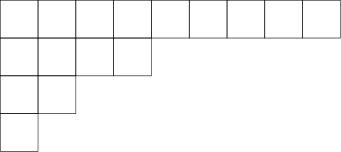


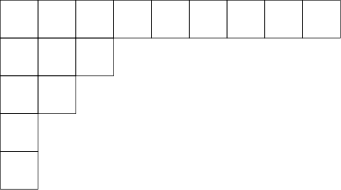


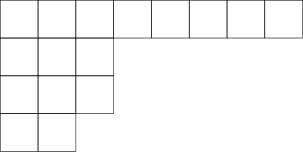


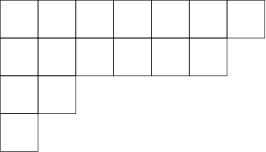


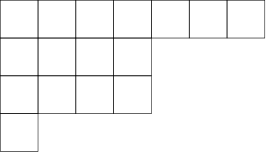


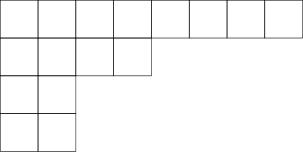


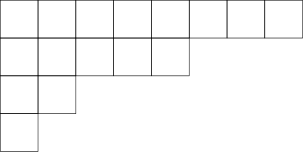


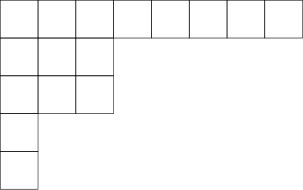


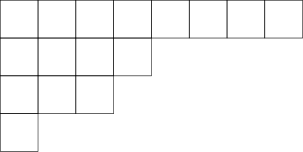


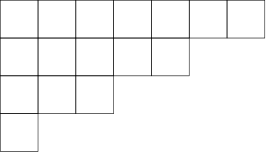


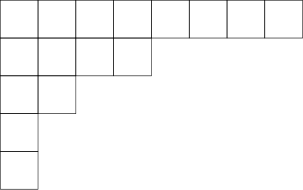

Tensor multiplicand 1:



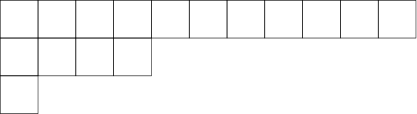

Tensor multiplicand 2:



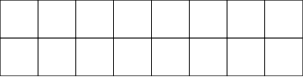

Tensor constituent(s):



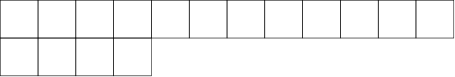


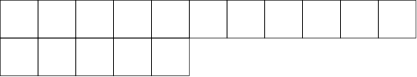


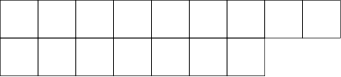


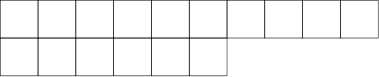


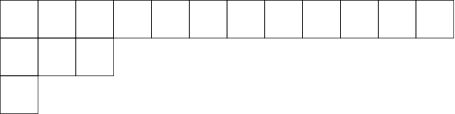


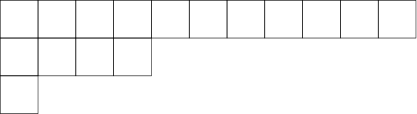


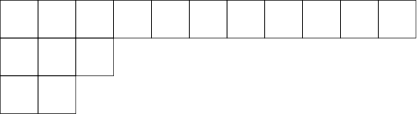


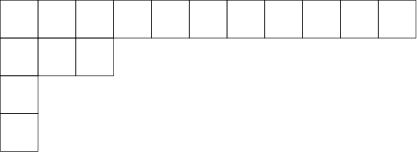


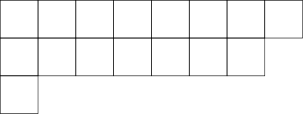


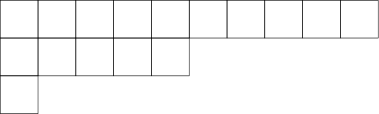


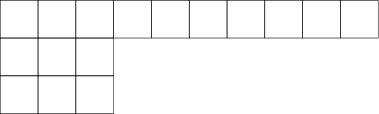


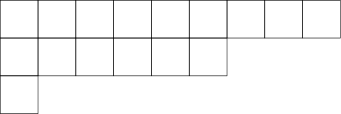


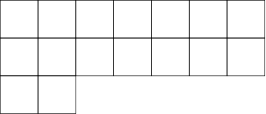


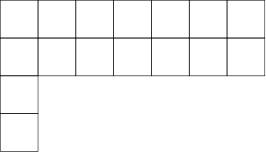


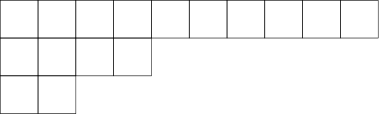


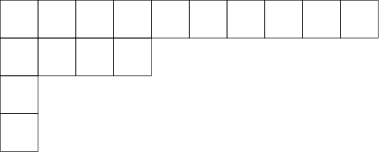


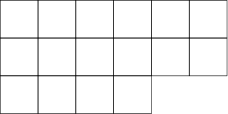


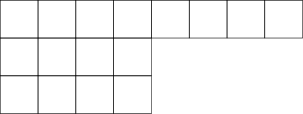


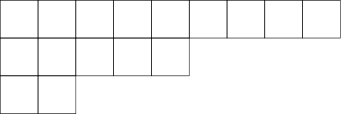


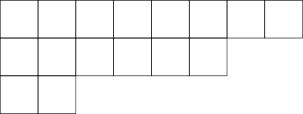


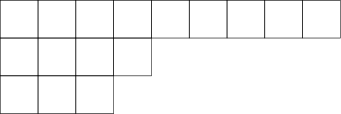


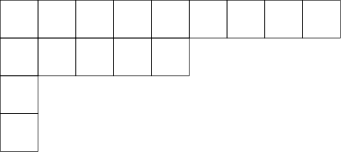


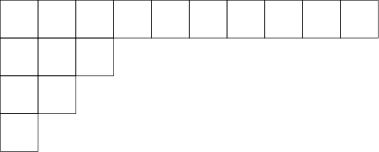


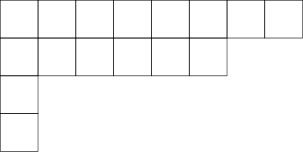


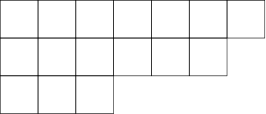


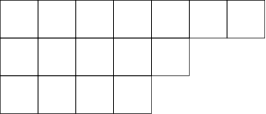


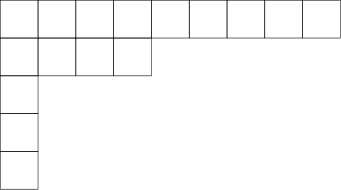


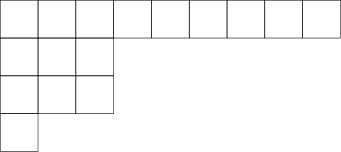


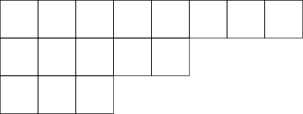


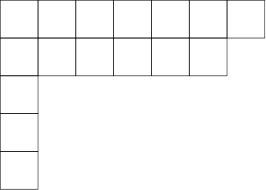


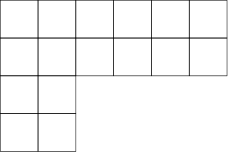


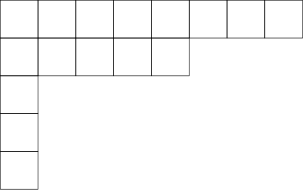


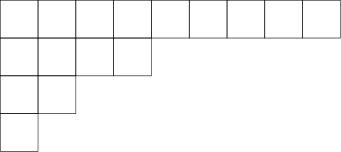


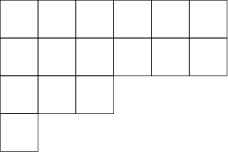


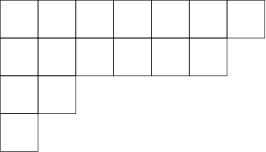


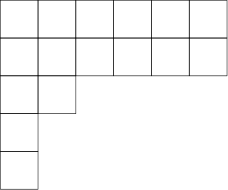


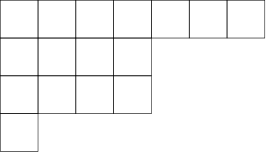


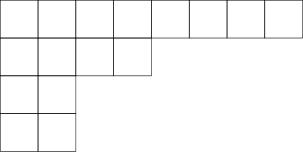


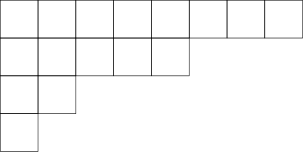


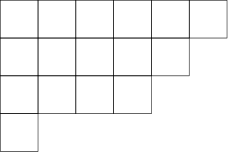


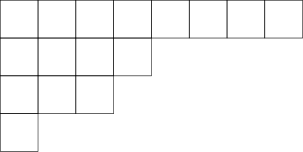


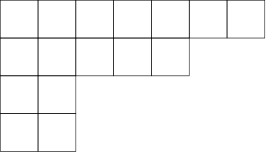


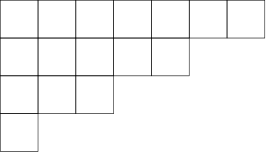


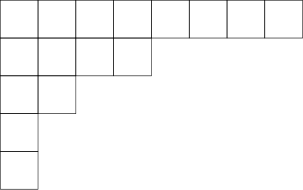


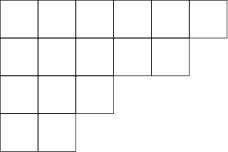


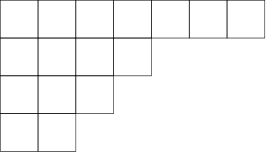


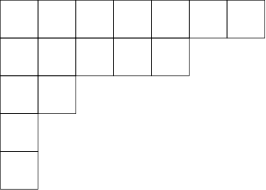


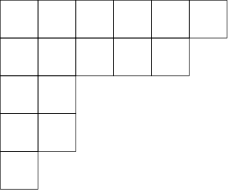


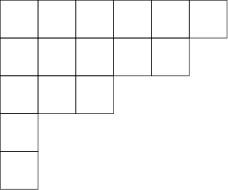


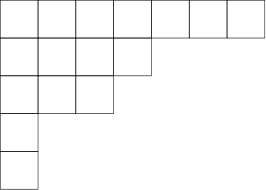

Tensor multiplicand 1:



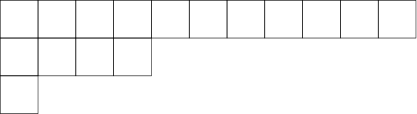

Tensor multiplicand 2:



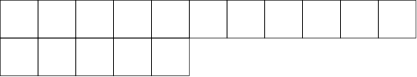

Tensor constituent(s):



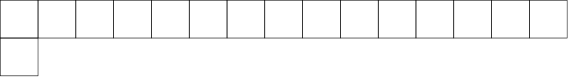


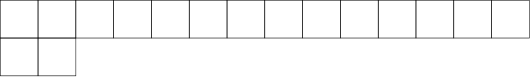


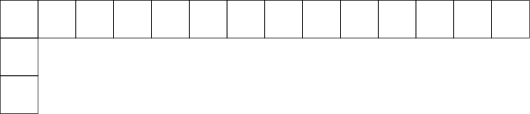


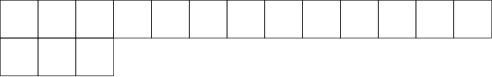


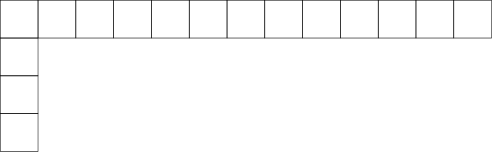


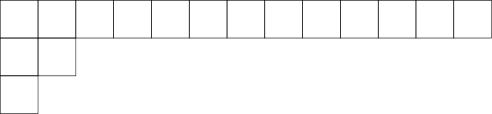


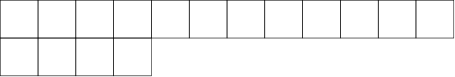


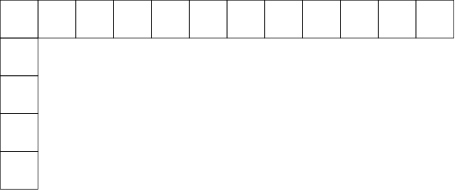


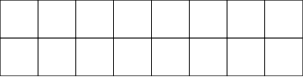


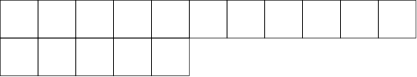


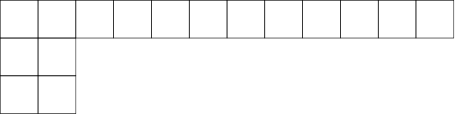


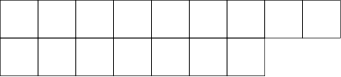


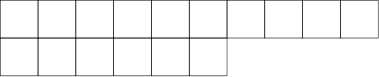


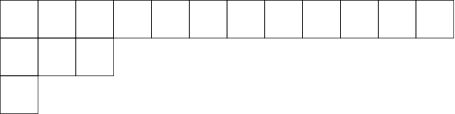


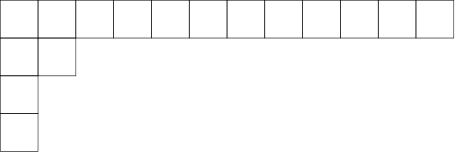


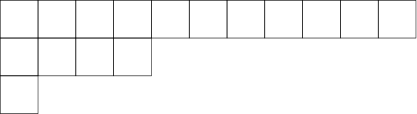


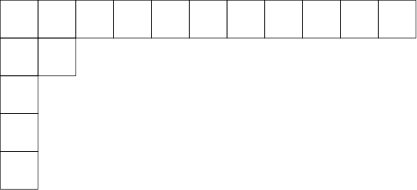


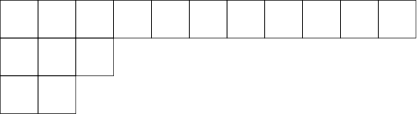


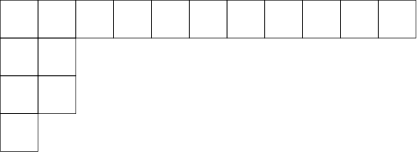


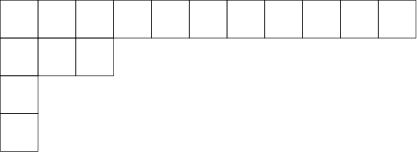


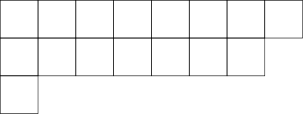


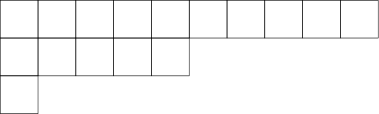


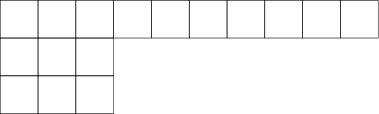


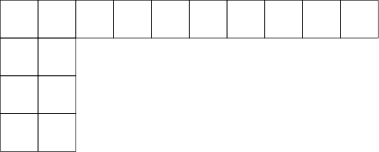


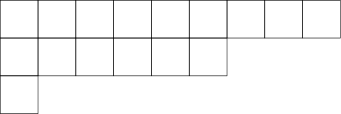


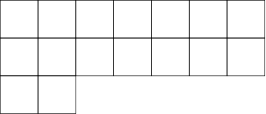


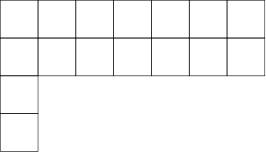


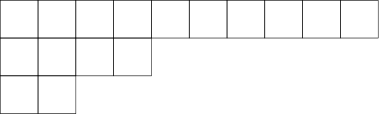


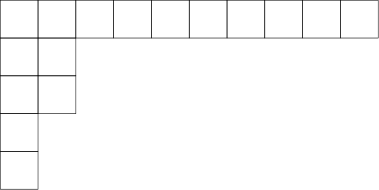


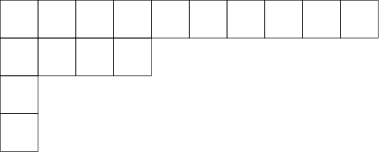


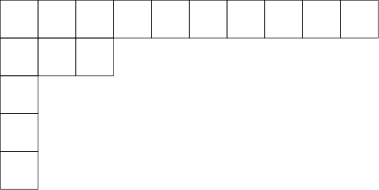


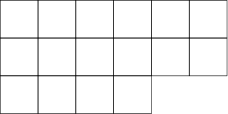


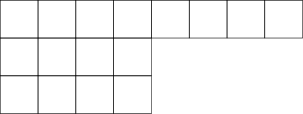


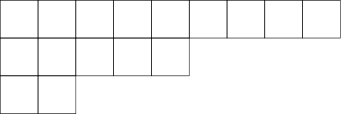


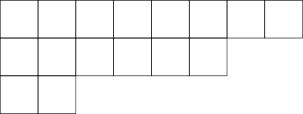


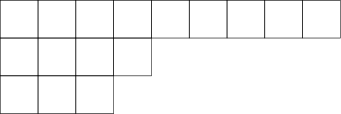


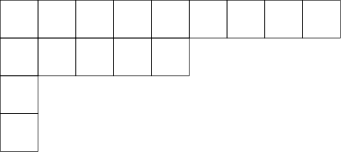


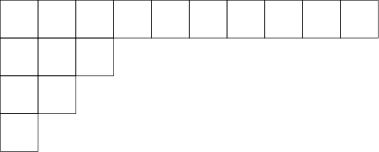


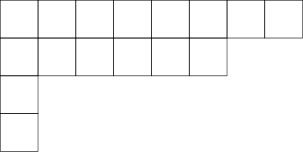


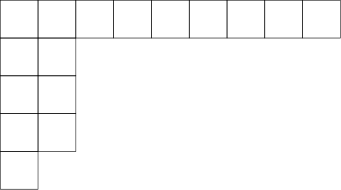


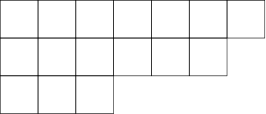


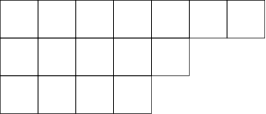


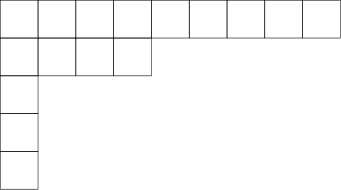


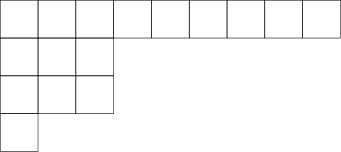


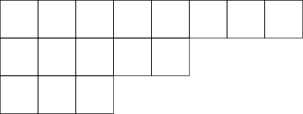


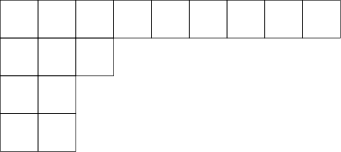


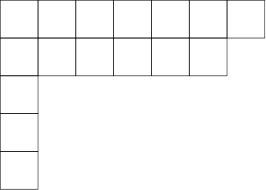


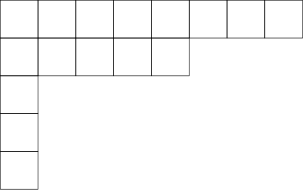


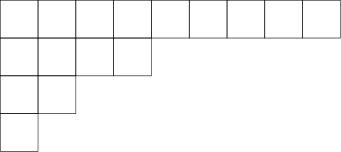


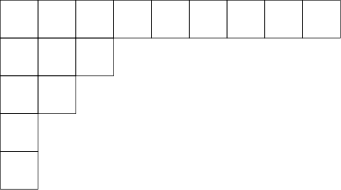


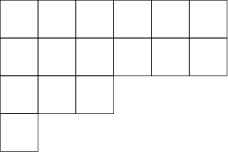


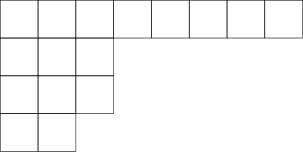


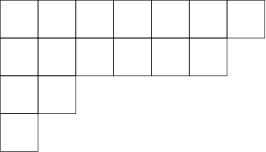


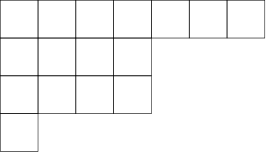


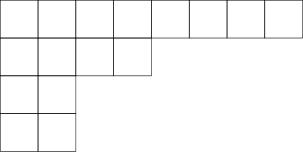


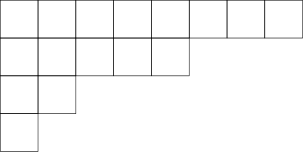


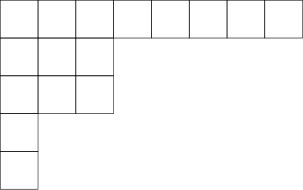


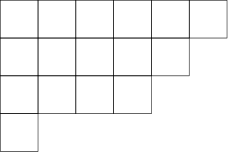


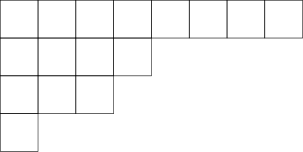


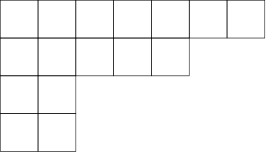


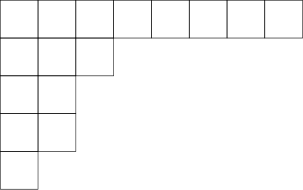


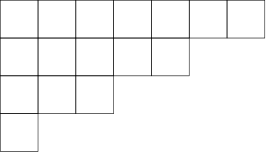


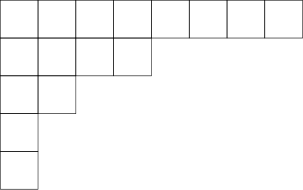


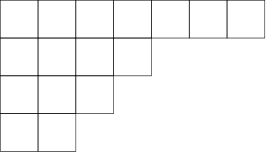


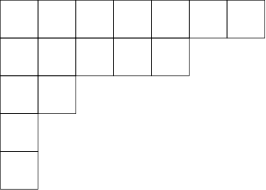


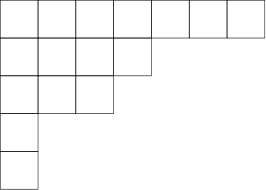

Tensor multiplicand 1:



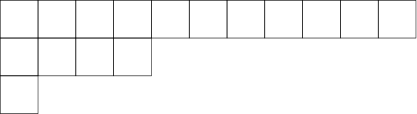

Tensor multiplicand 2:



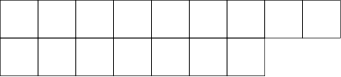

Tensor constituent(s):



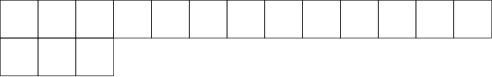


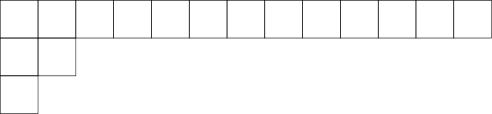


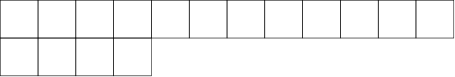


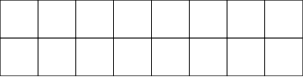


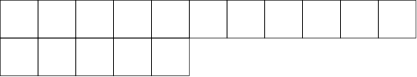


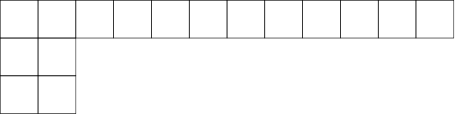


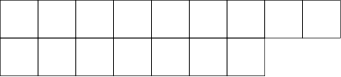


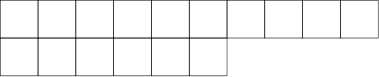


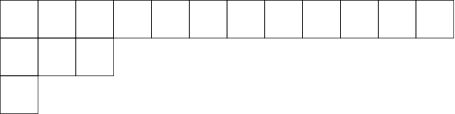


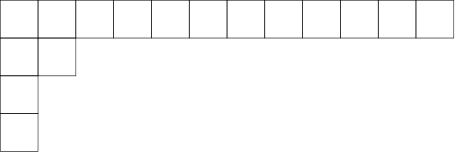


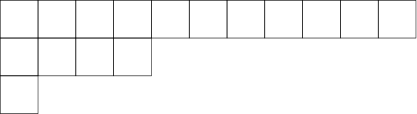


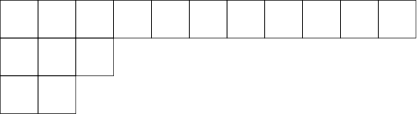


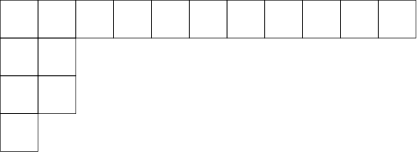


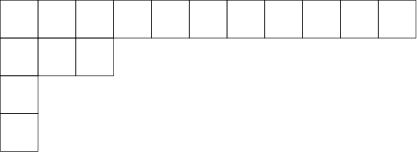


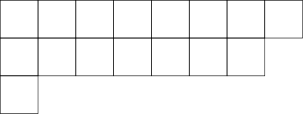


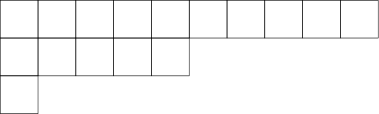


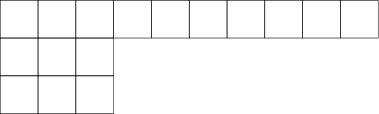


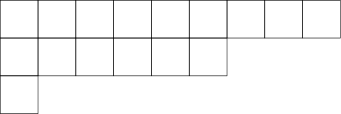


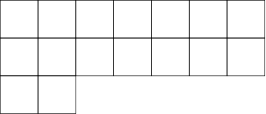


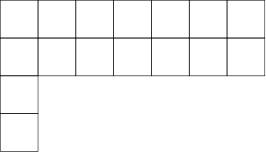


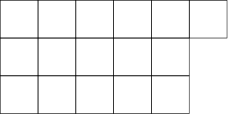


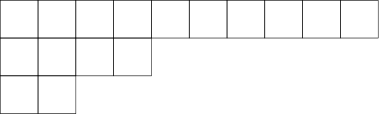


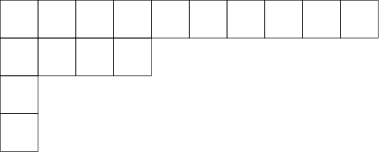


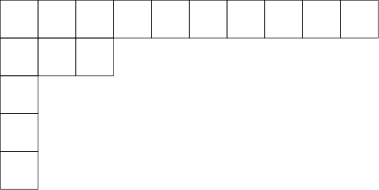


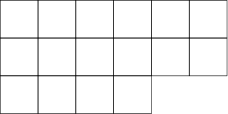


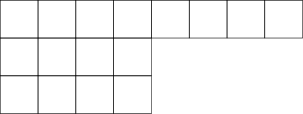


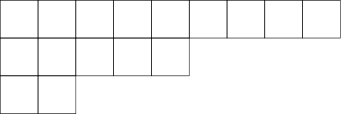


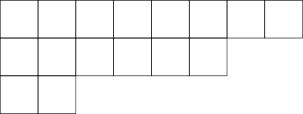


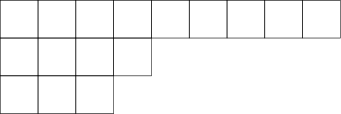


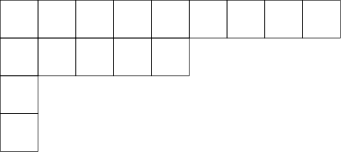


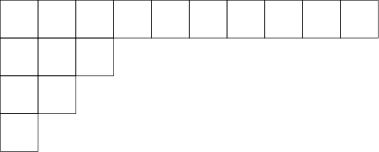


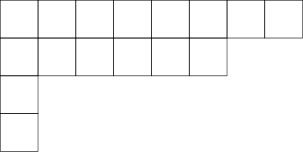


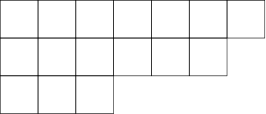


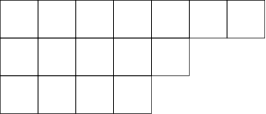


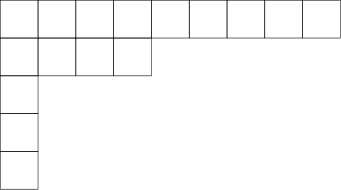


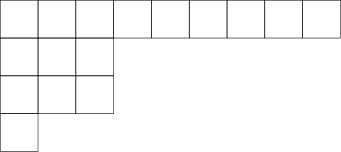


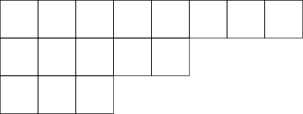


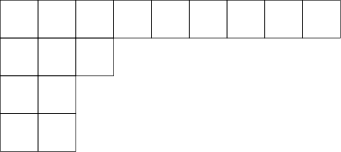


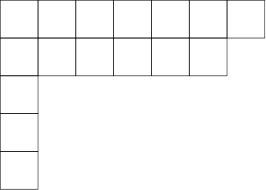


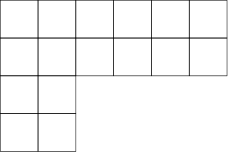


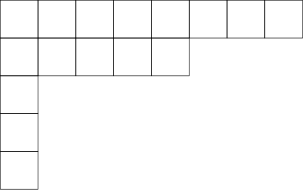


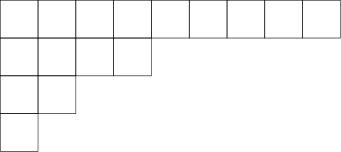


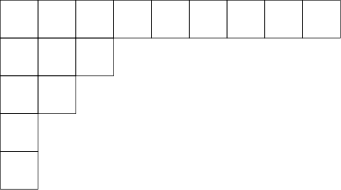


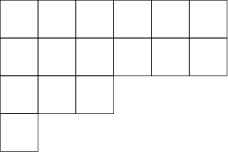


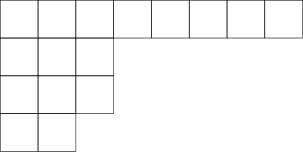


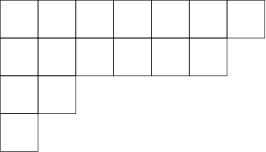


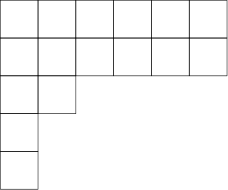


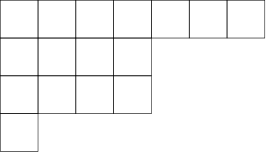


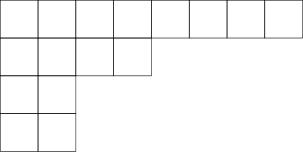


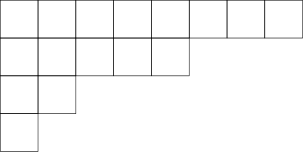


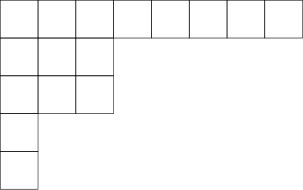


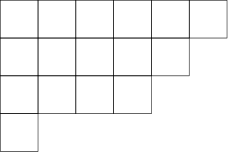


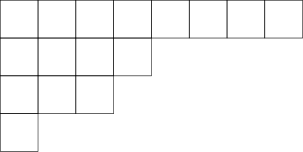


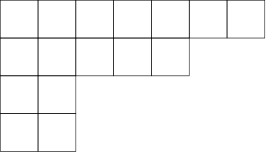


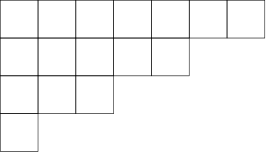


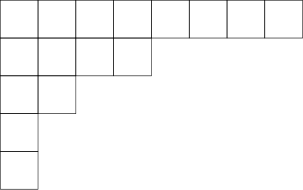


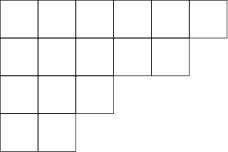


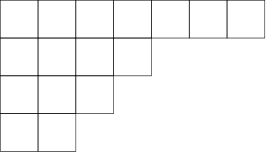


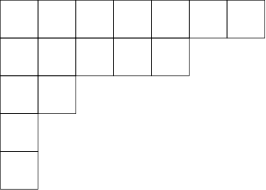


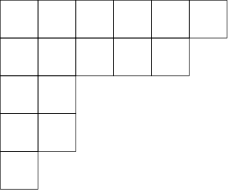


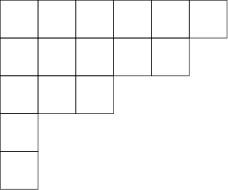


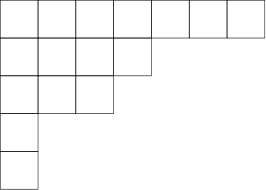


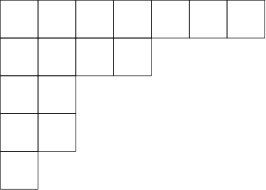

Tensor multiplicand 1:



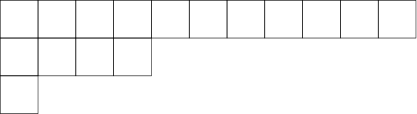

Tensor multiplicand 2:



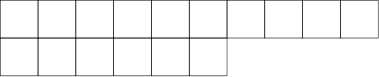

Tensor constituent(s):



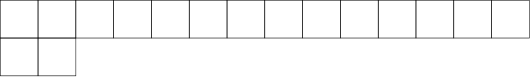


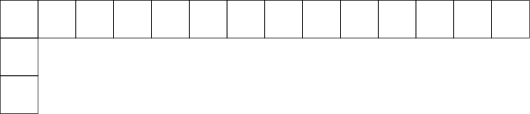


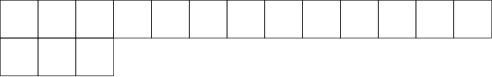


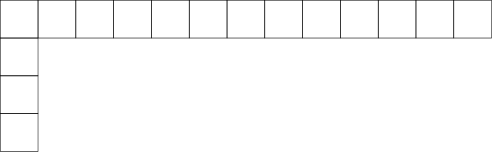


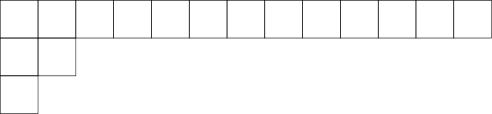


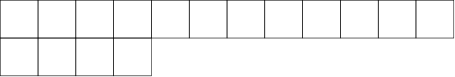


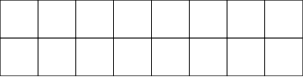


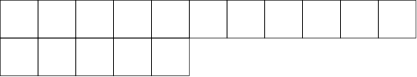


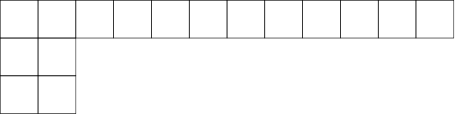


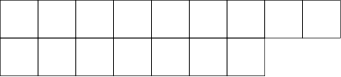


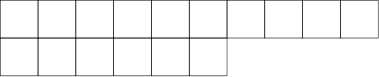


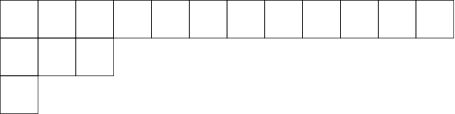


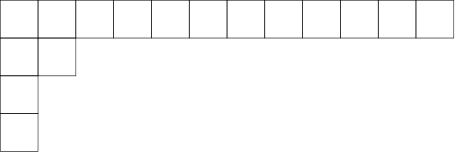


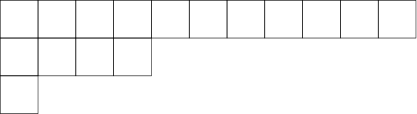


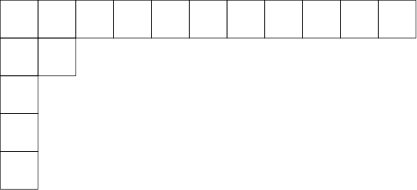


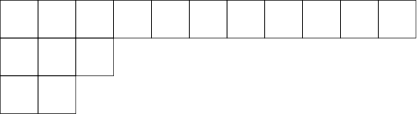


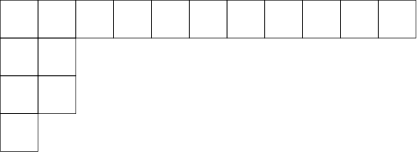


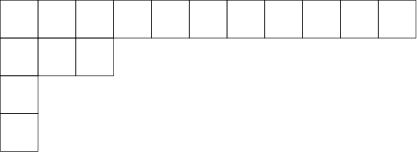


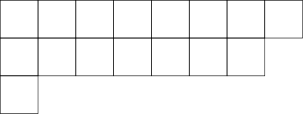


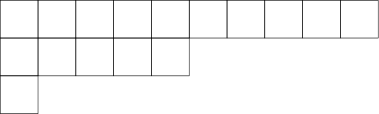


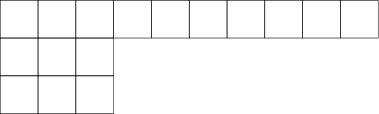


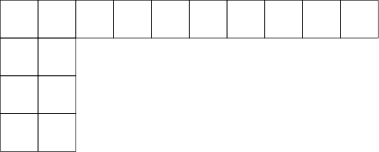


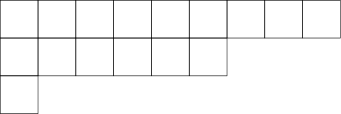


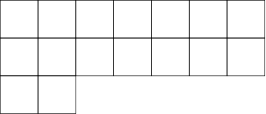


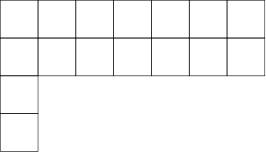


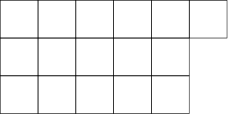


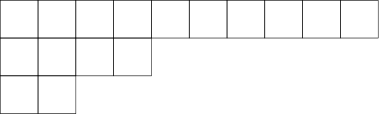


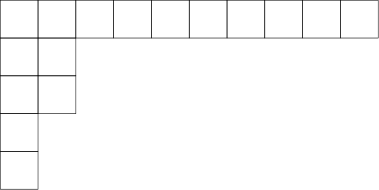


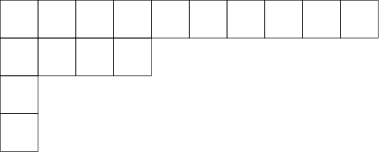


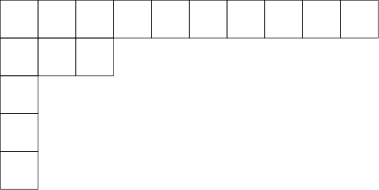


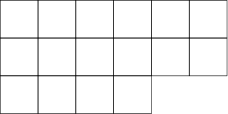


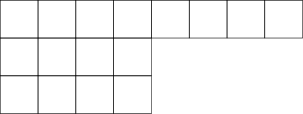


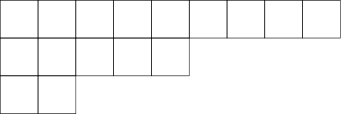


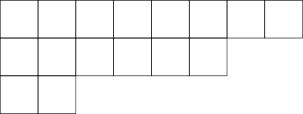


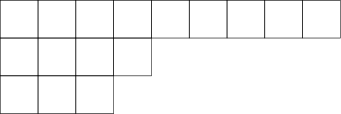


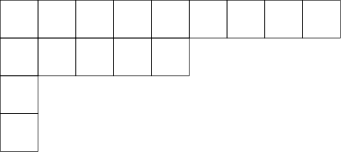


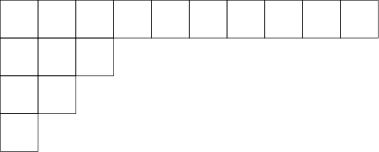


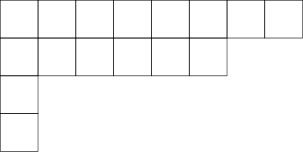


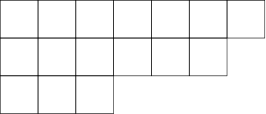


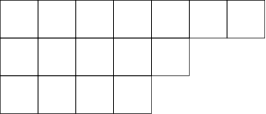


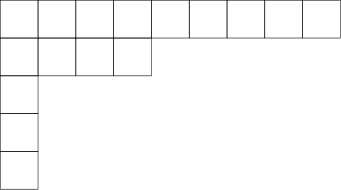


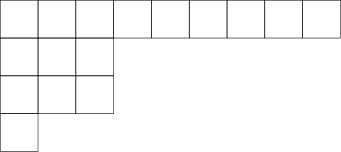


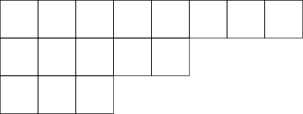


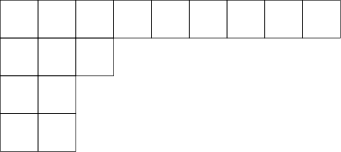


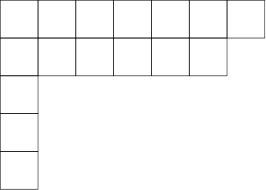


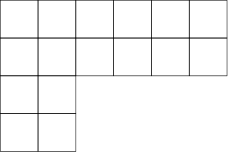


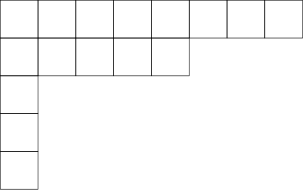


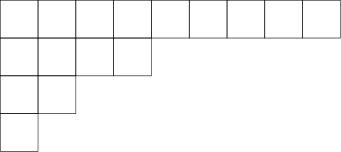


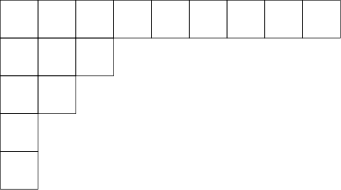


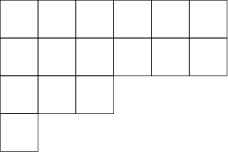


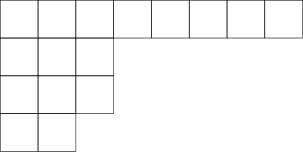


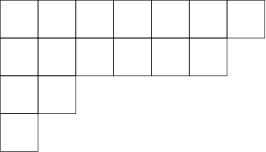


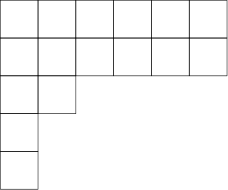


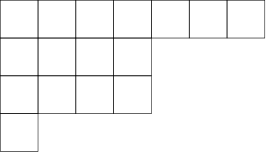


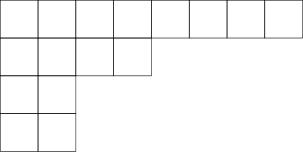


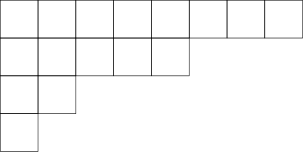


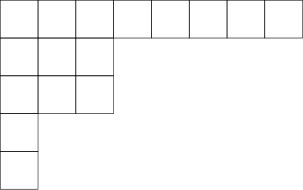


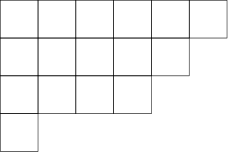


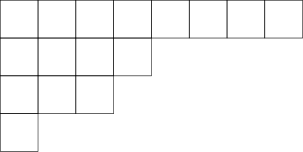


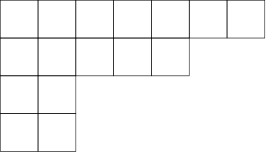


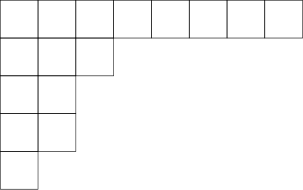


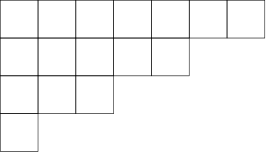


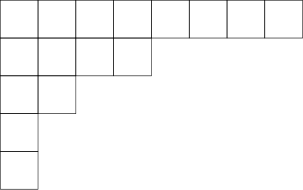


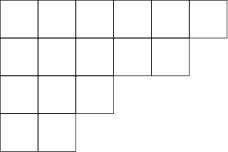


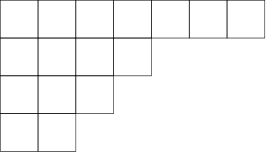


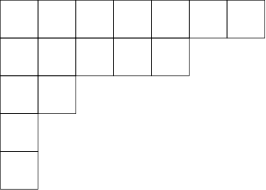


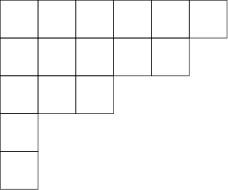


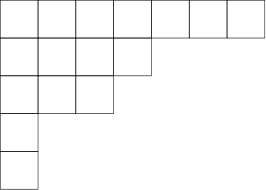


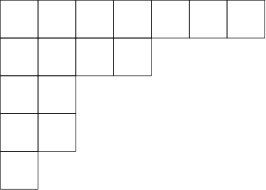

Tensor multiplicand 1:



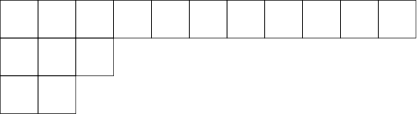

Tensor multiplicand 2:



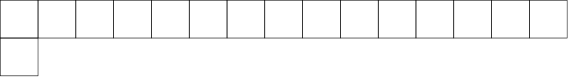

Tensor constituent(s):



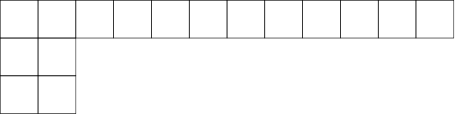


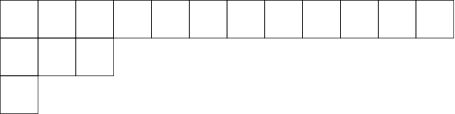


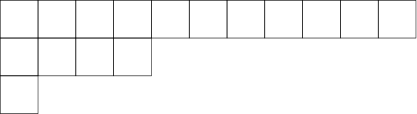


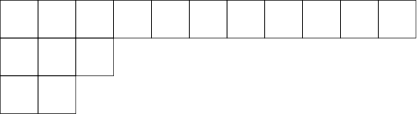


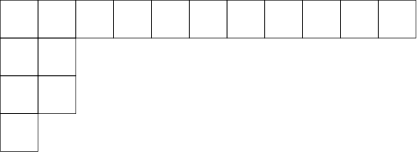


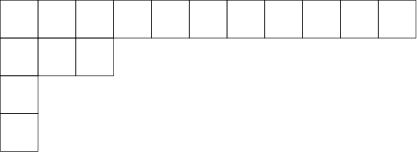


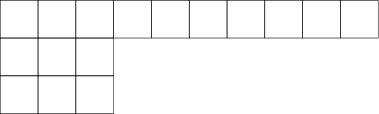


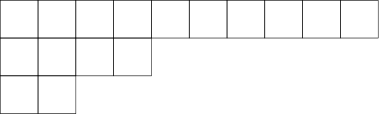


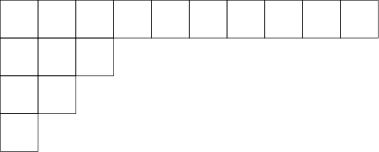

Tensor multiplicand 1:



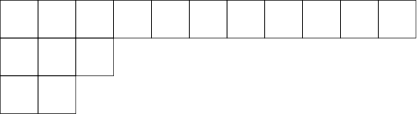

Tensor multiplicand 2:



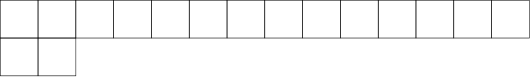

Tensor constituent(s):



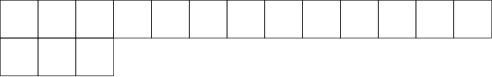


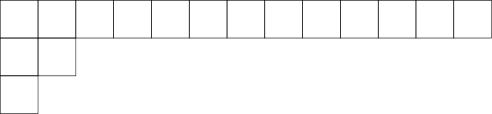


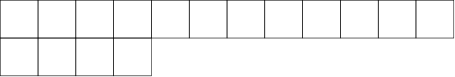


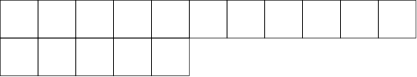


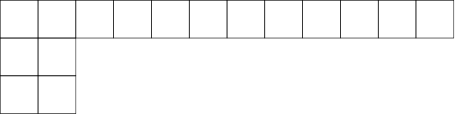


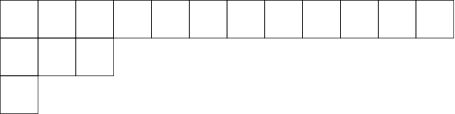


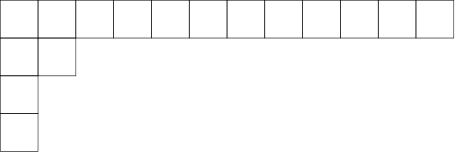


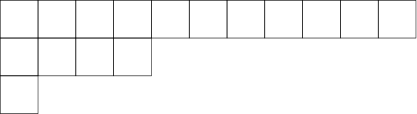


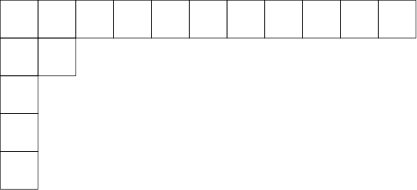


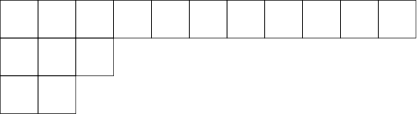


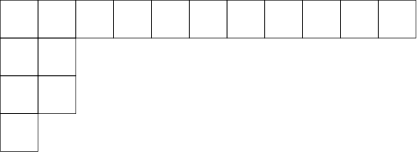


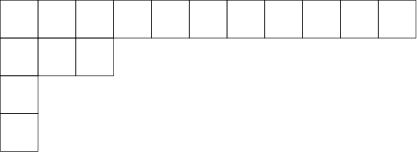


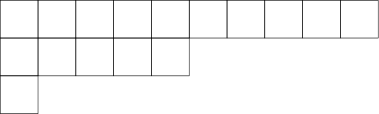


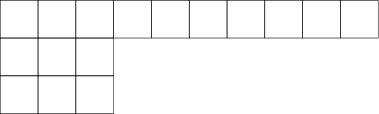


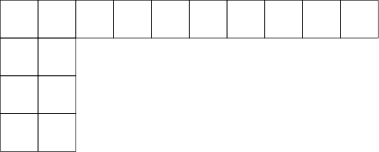


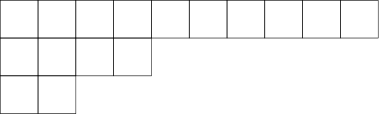


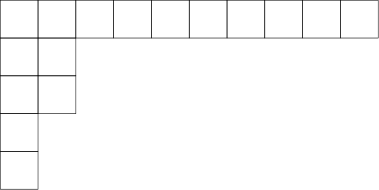


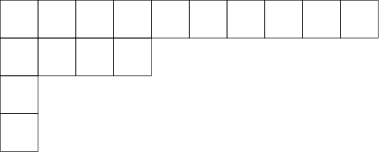


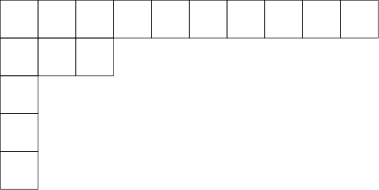


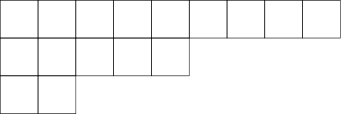


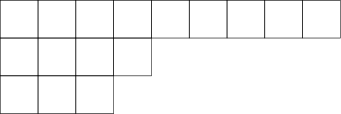


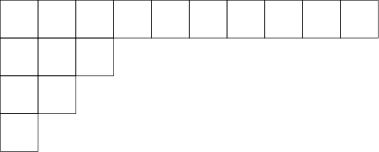


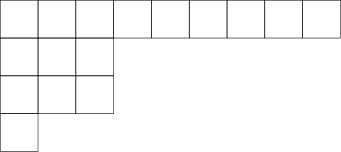


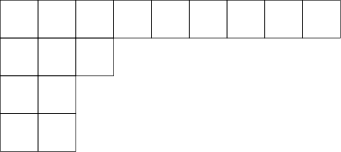


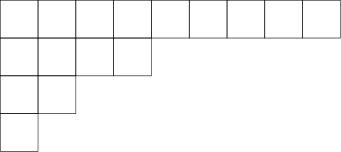

Tensor multiplicand 1:



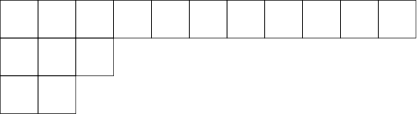

Tensor multiplicand 2:



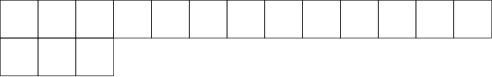

Tensor constituent(s):



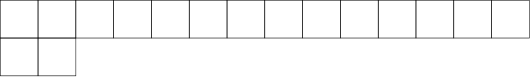


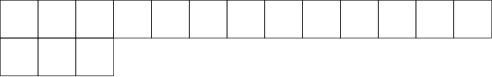


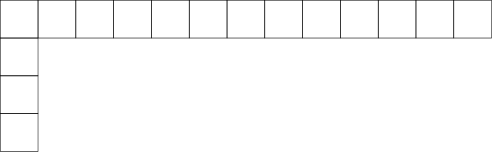


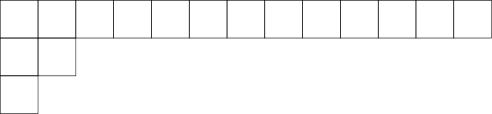


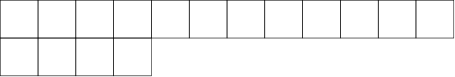


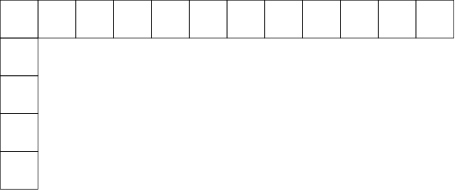


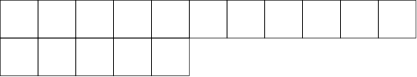


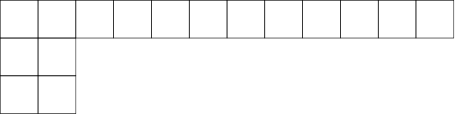


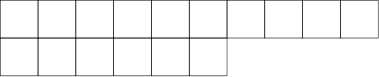


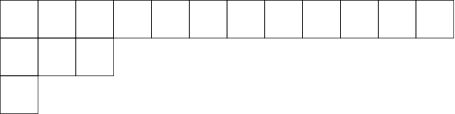


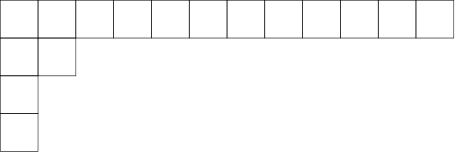


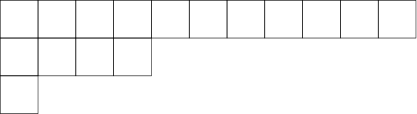


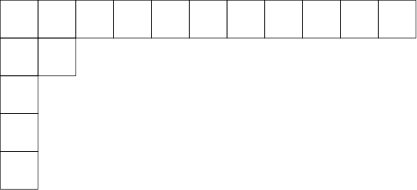


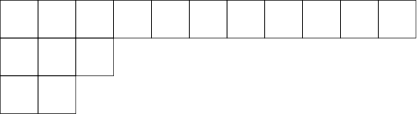


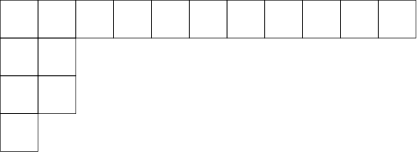


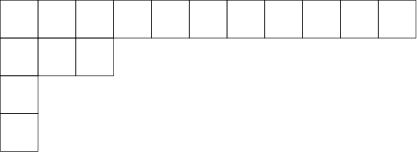


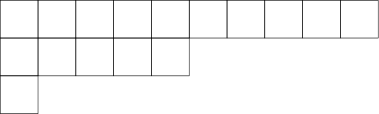


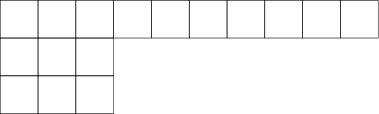


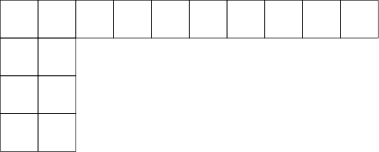


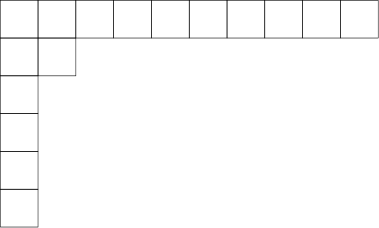


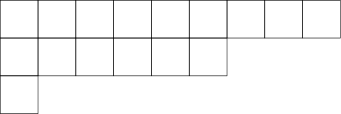


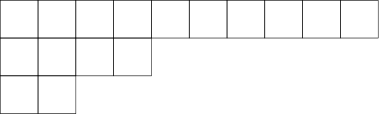


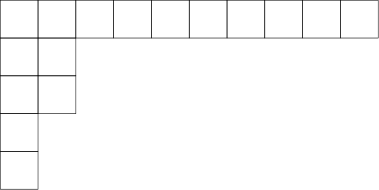


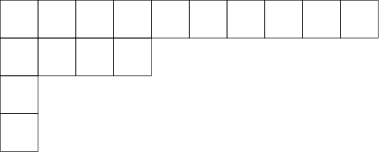


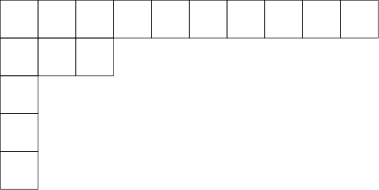


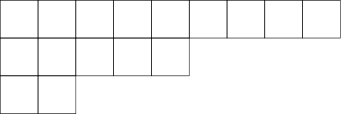


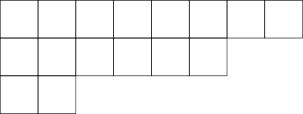


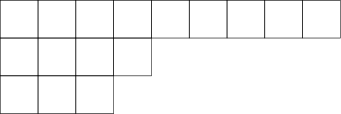


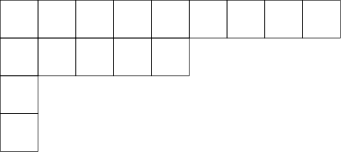


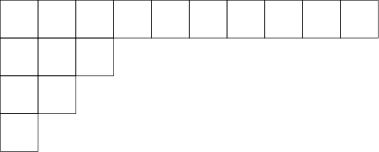


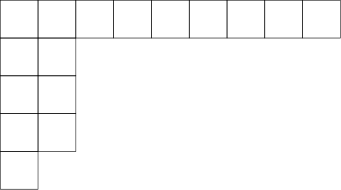


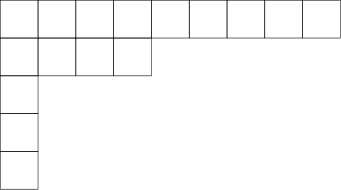


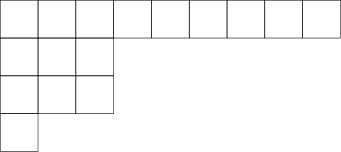


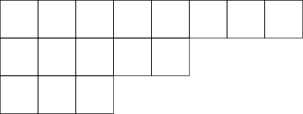


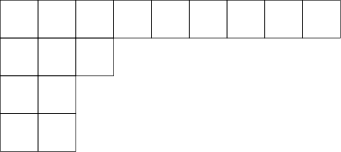


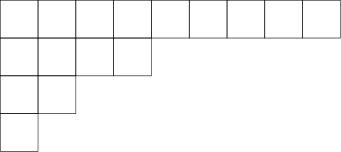


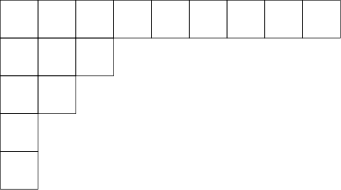


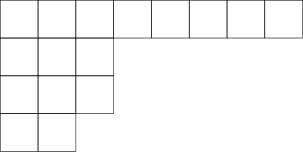


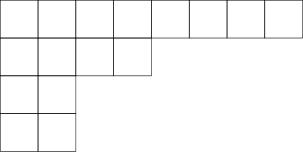


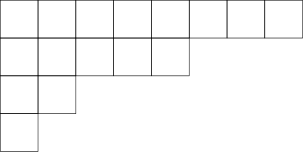


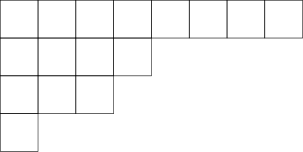

Tensor multiplicand 1:



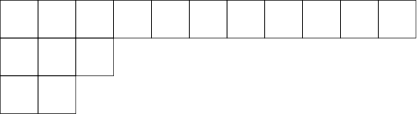

Tensor multiplicand 2:



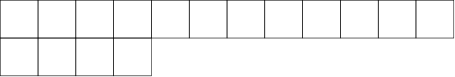

Tensor constituent(s):



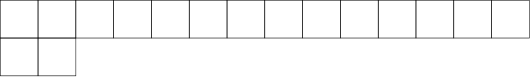


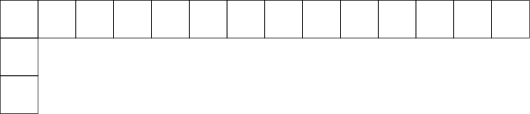


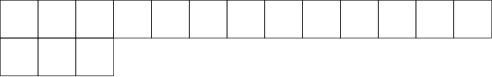


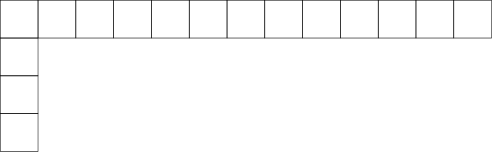


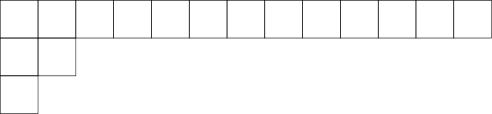


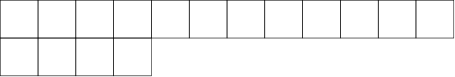


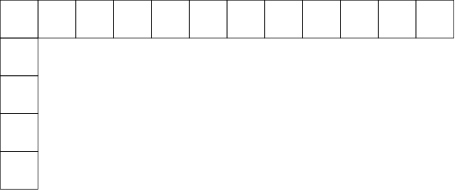


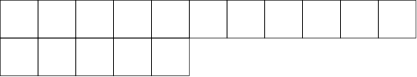


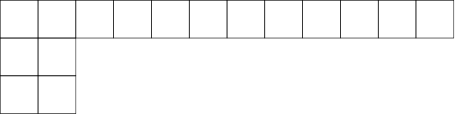


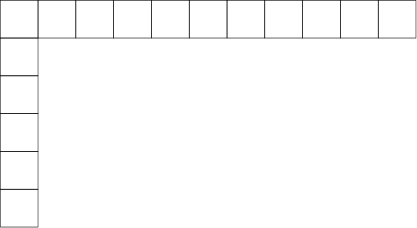


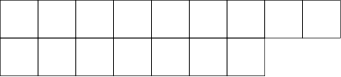


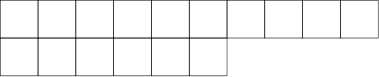


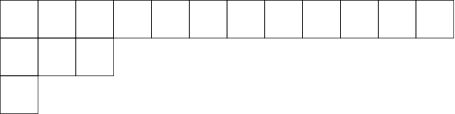


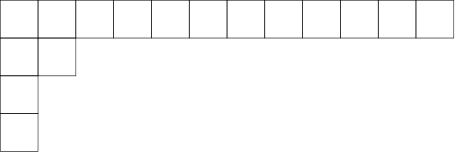


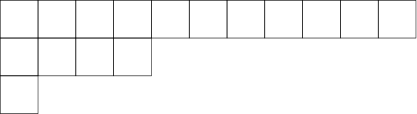


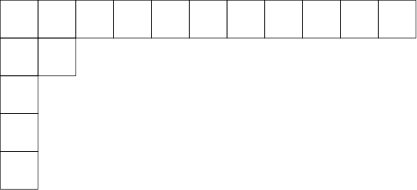


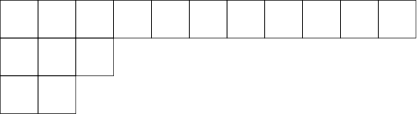


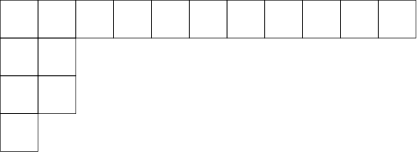


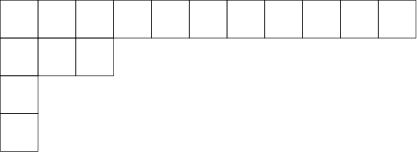


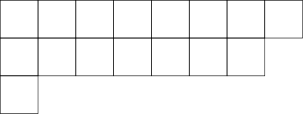


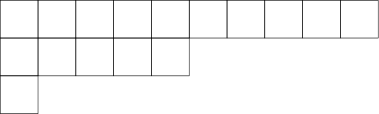


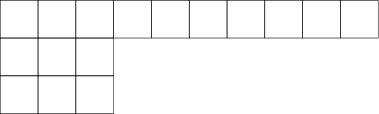


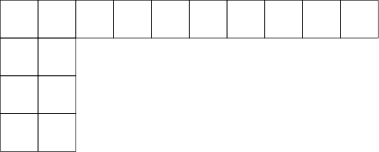


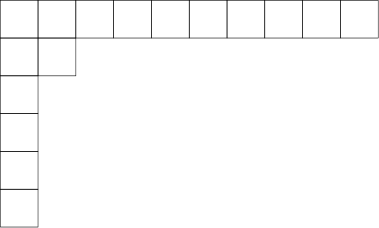


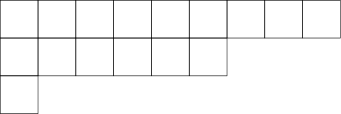


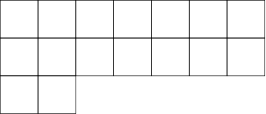


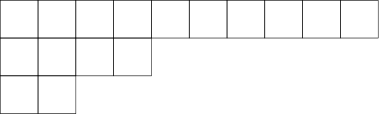


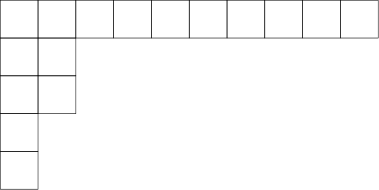


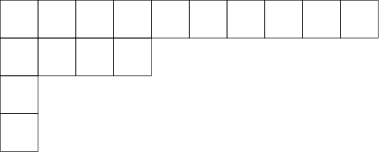


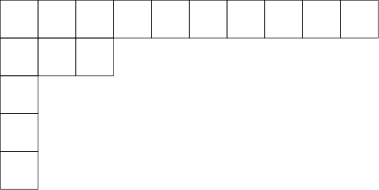


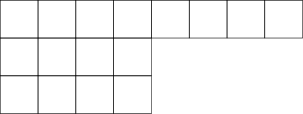


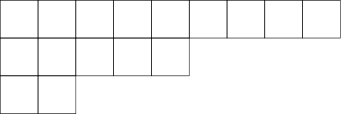


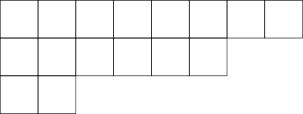


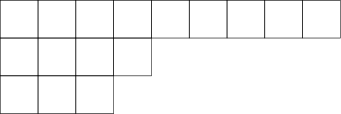


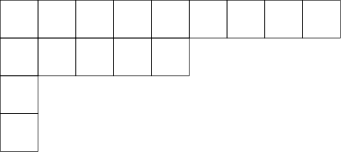


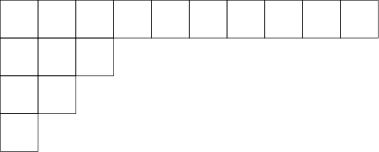


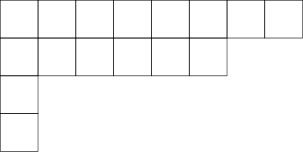


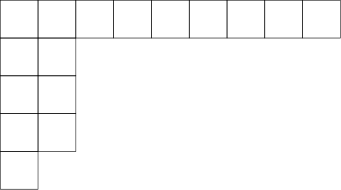


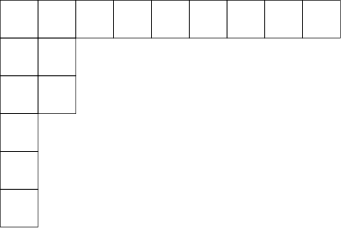


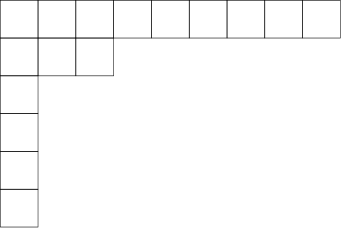


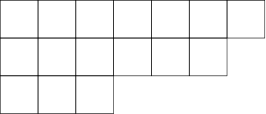


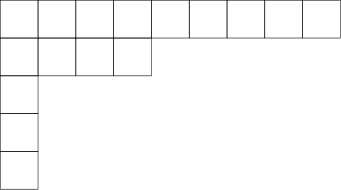


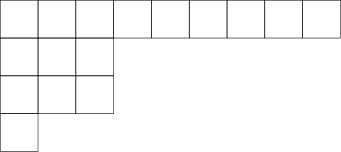


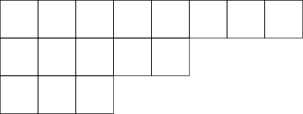


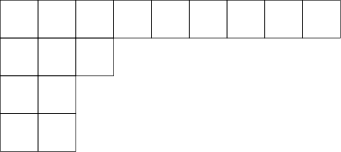


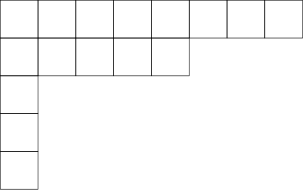


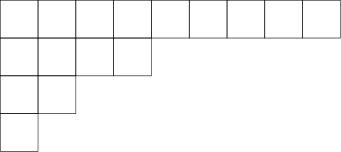


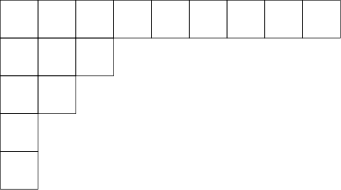


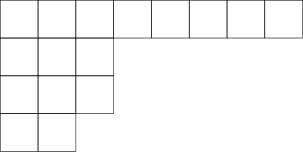


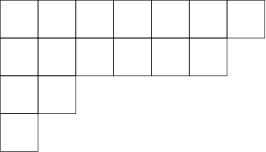


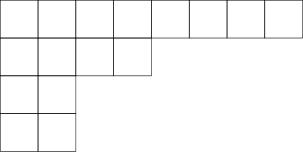


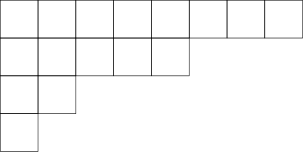


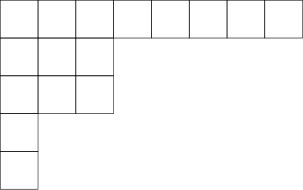


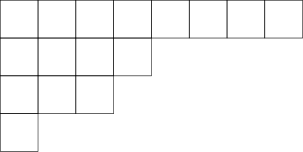


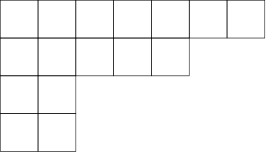


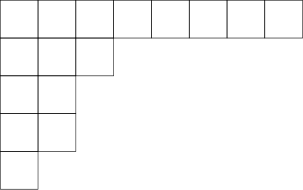


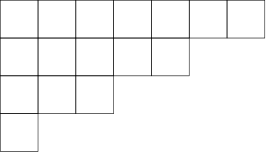


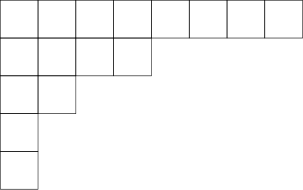


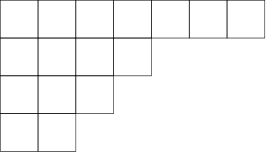

Tensor multiplicand 1:



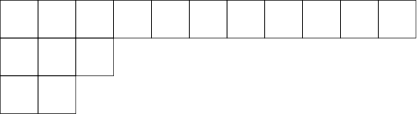

Tensor multiplicand 2:



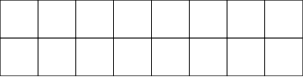

Tensor constituent(s):



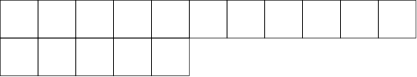


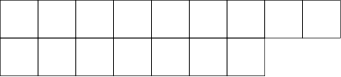


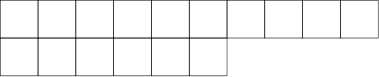


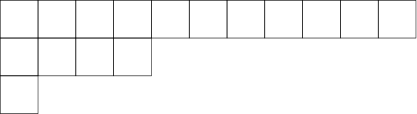


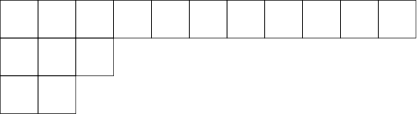


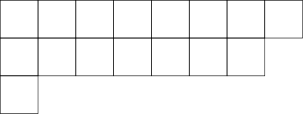


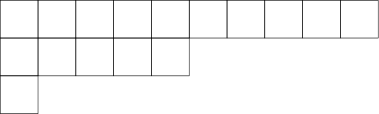


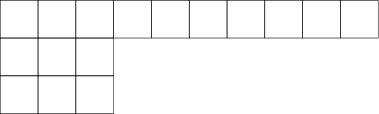


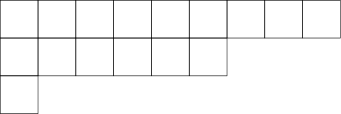


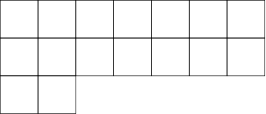


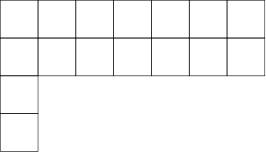


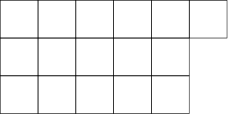


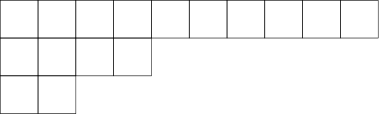


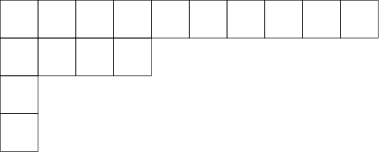


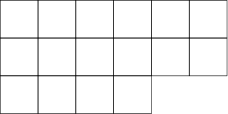


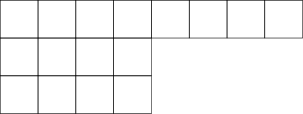


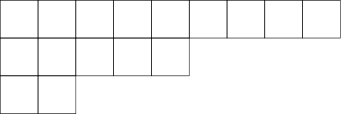


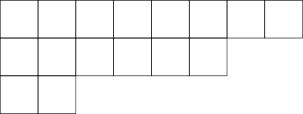


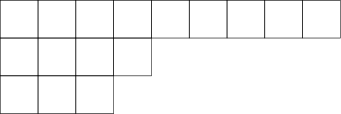


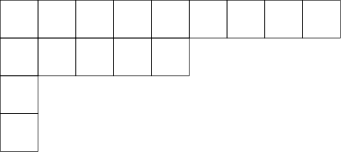


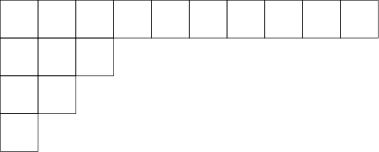


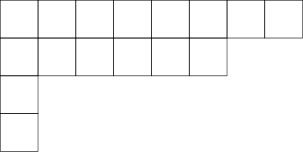


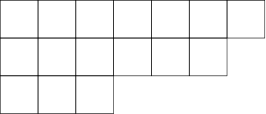


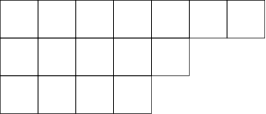


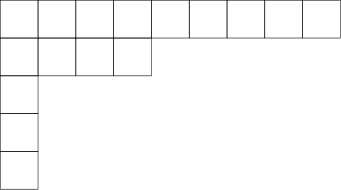


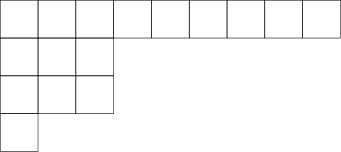


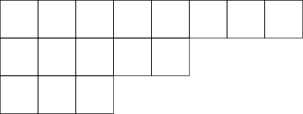


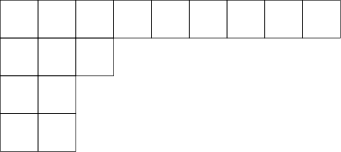


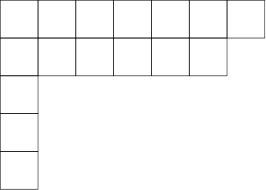


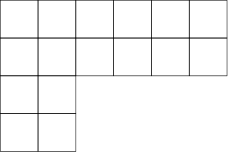


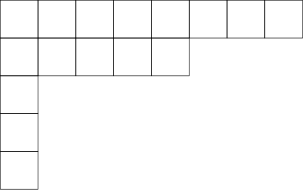


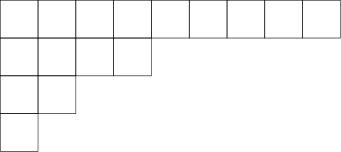


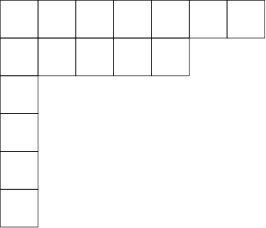


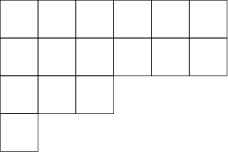


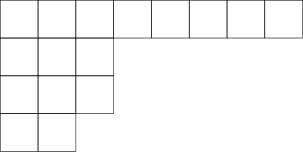


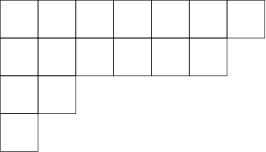


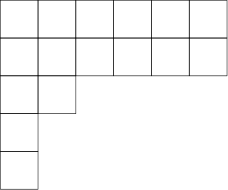


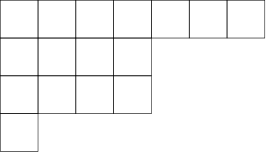


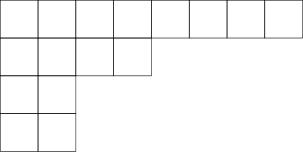


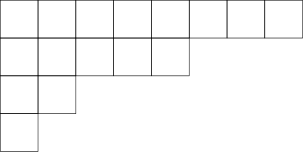


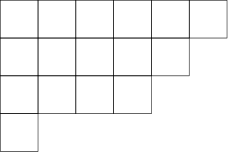


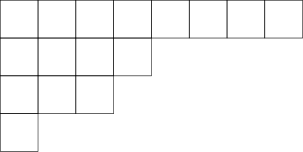


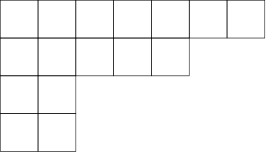


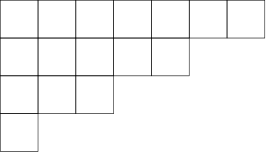


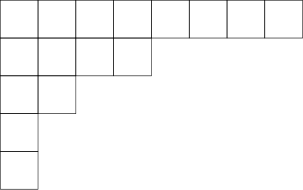


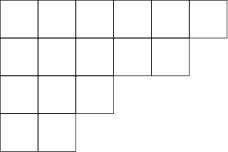


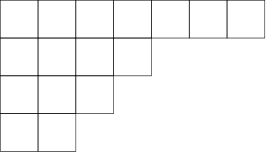


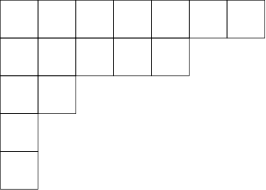


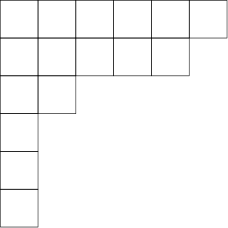


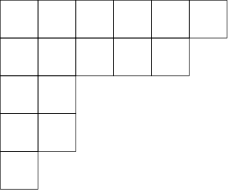


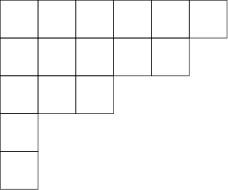


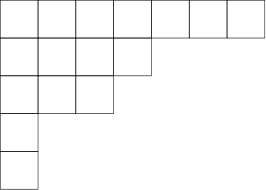


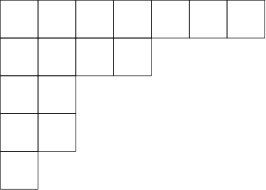

Tensor multiplicand 1:



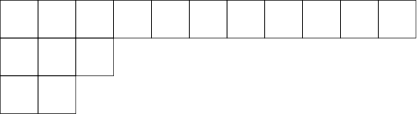

Tensor multiplicand 2:



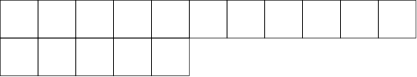

Tensor constituent(s):



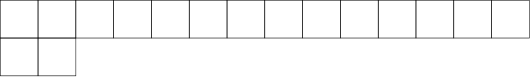


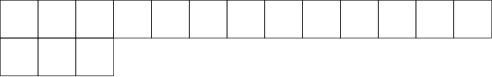


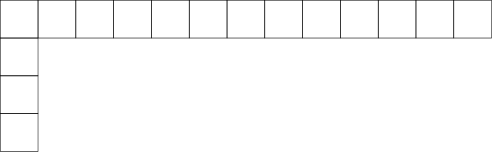


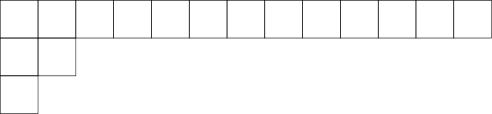


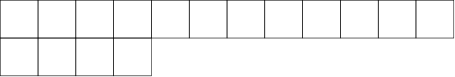


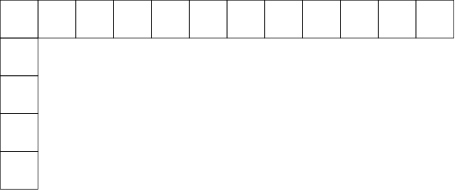


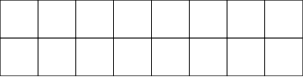


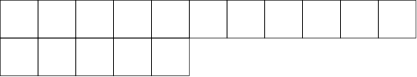


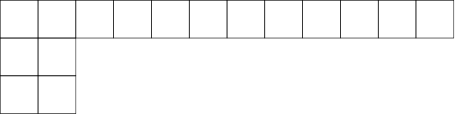


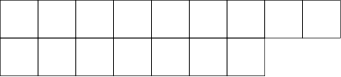


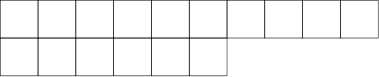


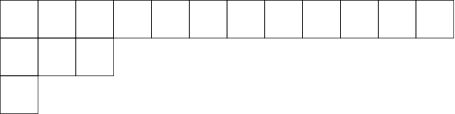


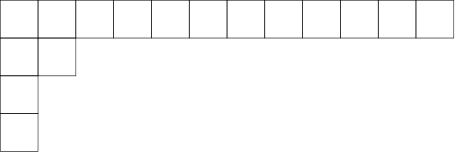


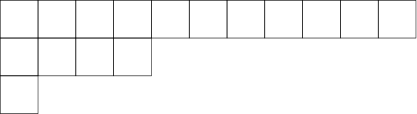


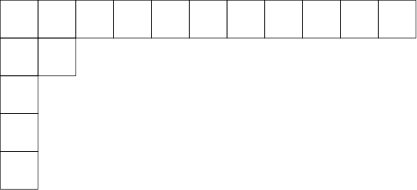


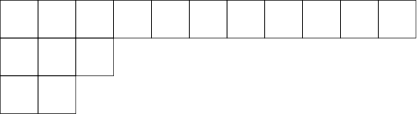


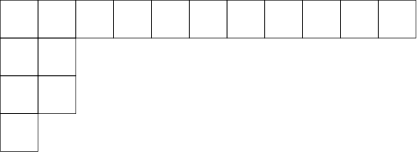


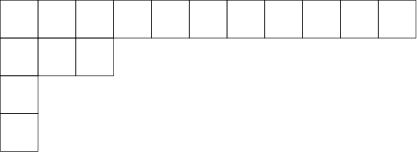


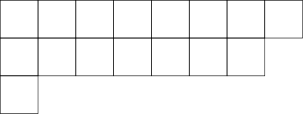


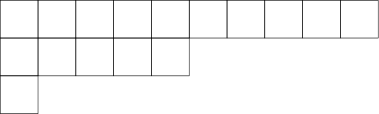


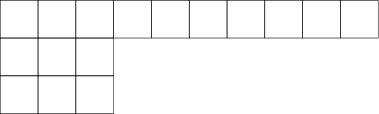


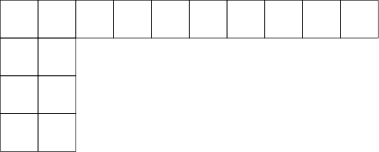


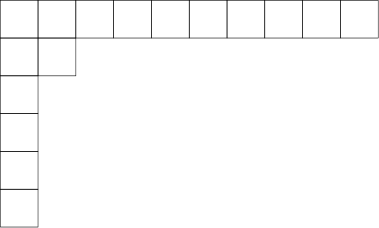


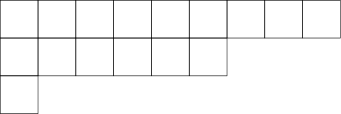


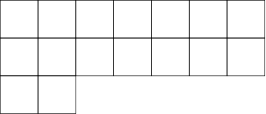


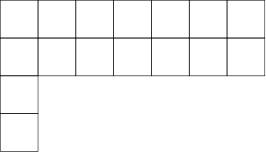


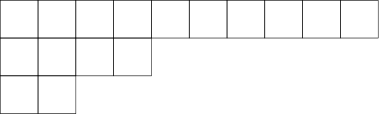


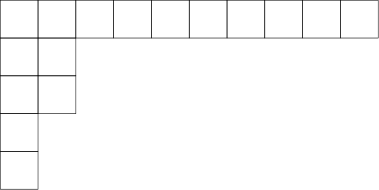


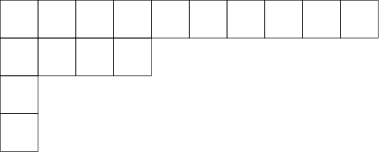


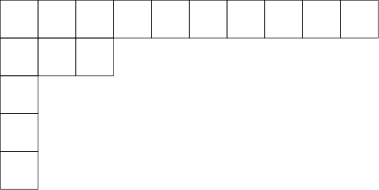


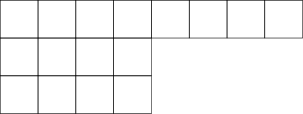


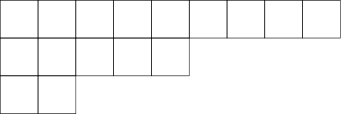


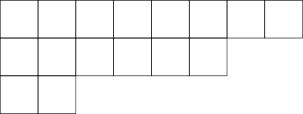


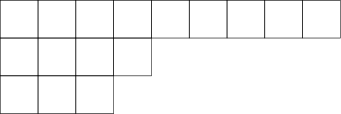


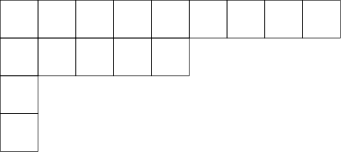


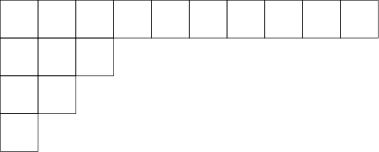


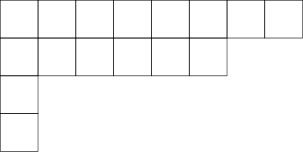


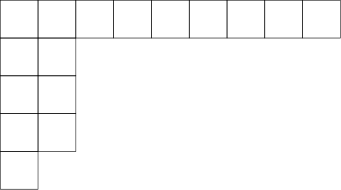


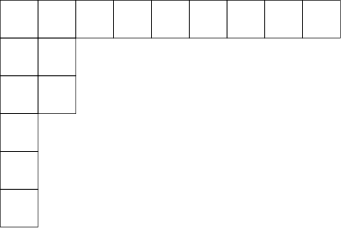


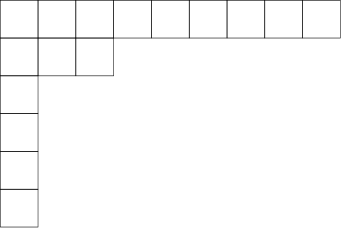


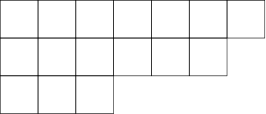


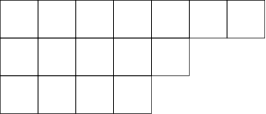


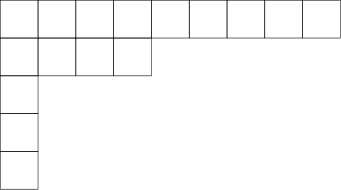


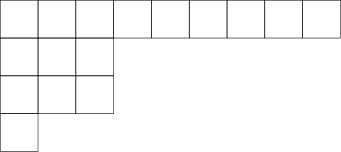


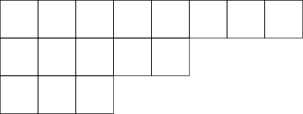


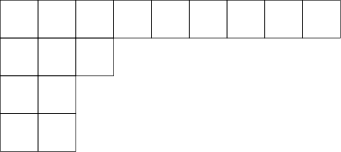


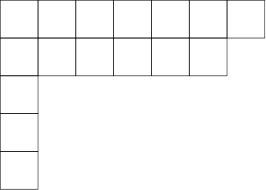


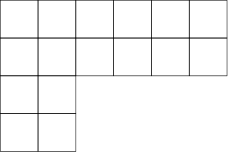


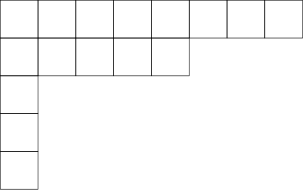


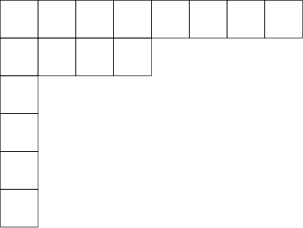


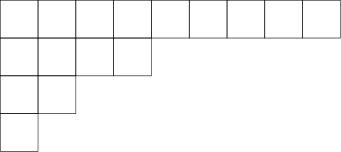


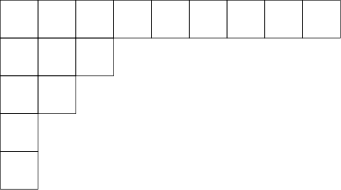


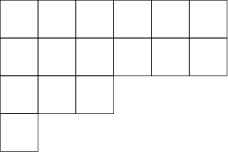


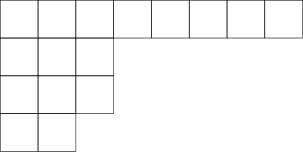


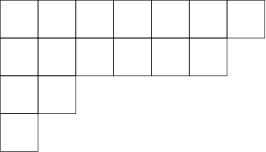


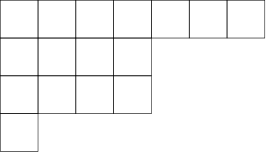


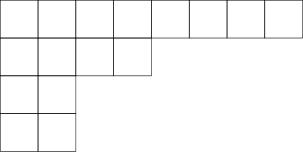


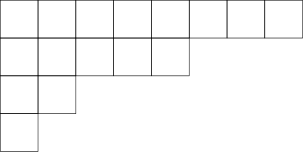


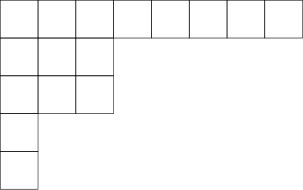


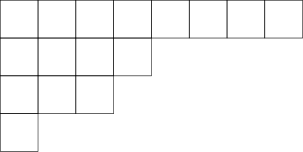


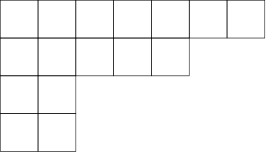


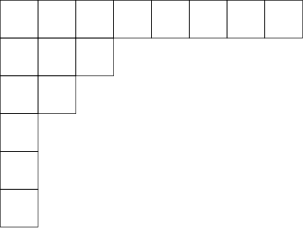


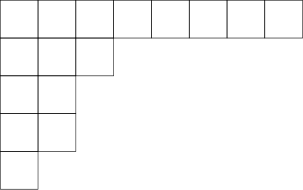


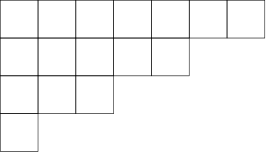


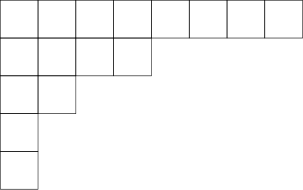


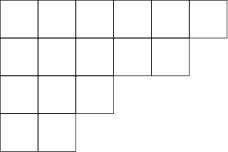


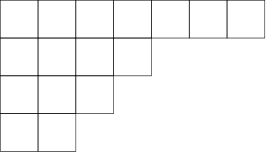


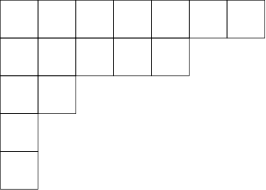


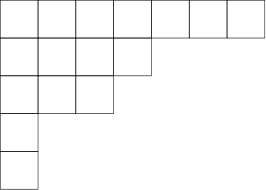


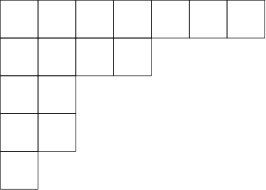

Tensor multiplicand 1:



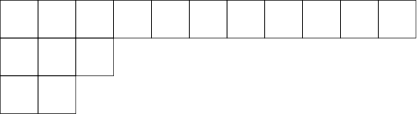

Tensor multiplicand 2:



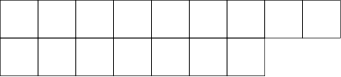

Tensor constituent(s):



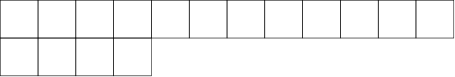


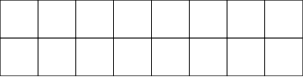


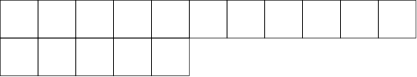


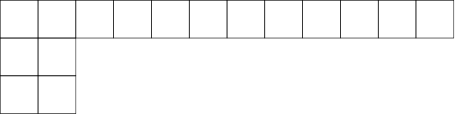


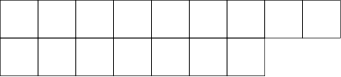


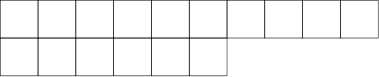


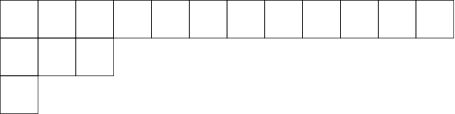


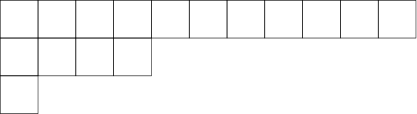


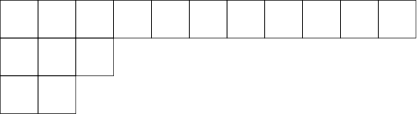


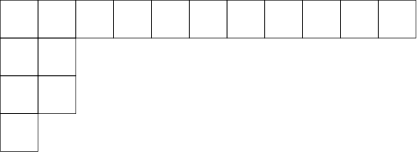


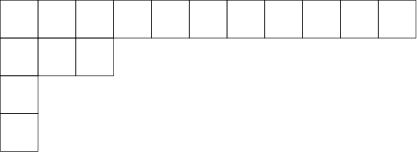


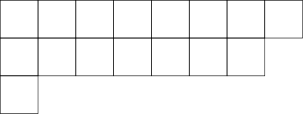


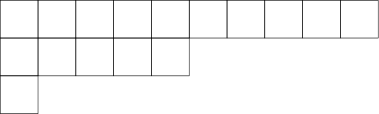


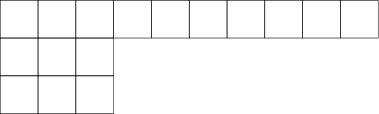


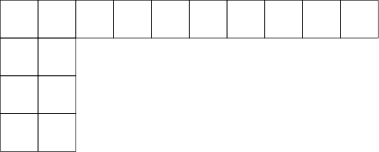


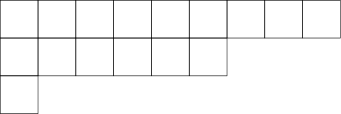


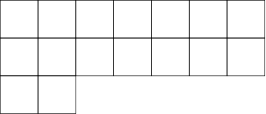


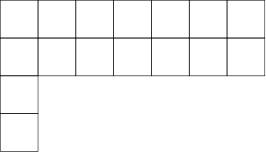


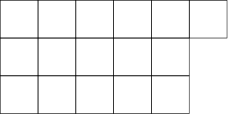


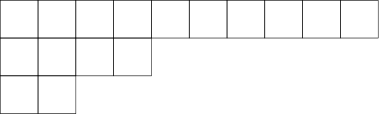


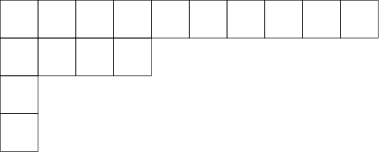


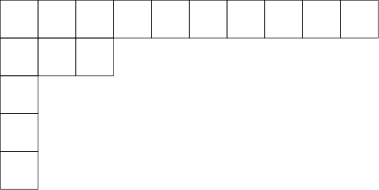


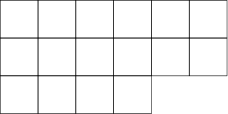


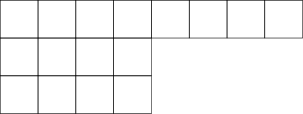


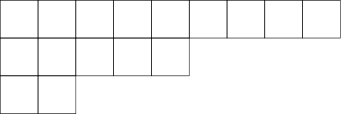


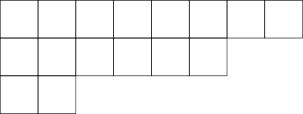


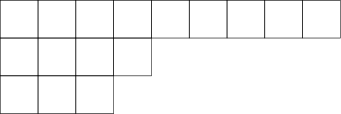


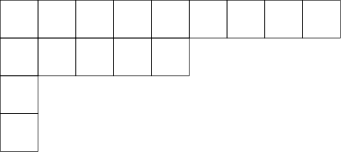


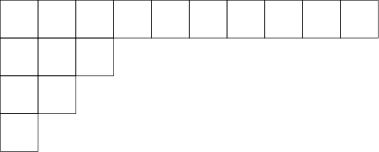


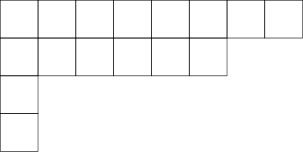


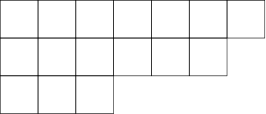


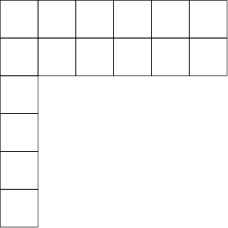


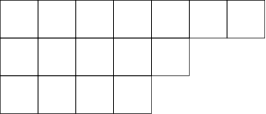


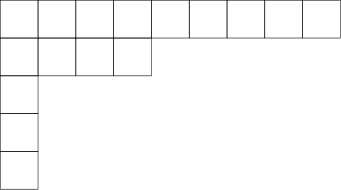


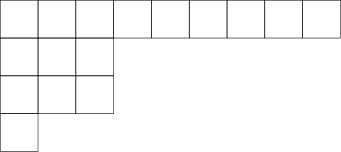


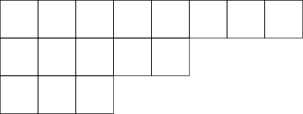


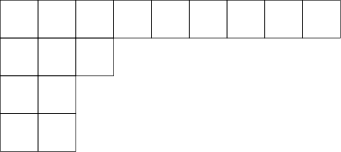


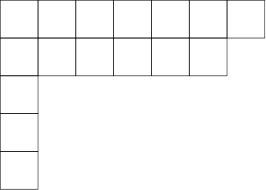


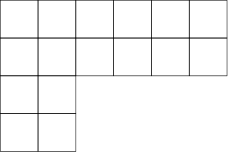


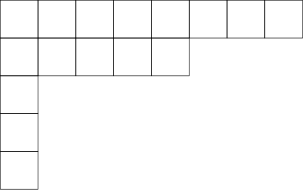


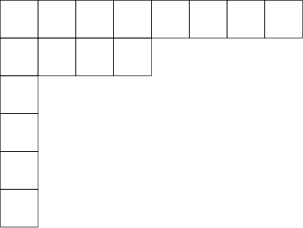


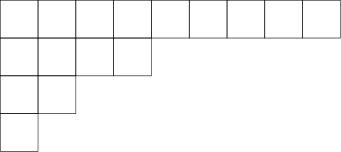


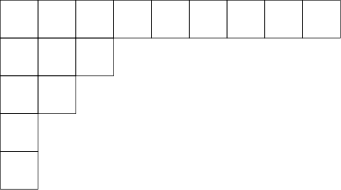


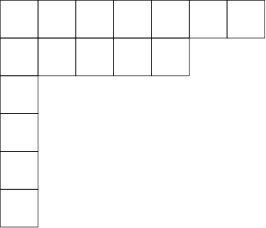


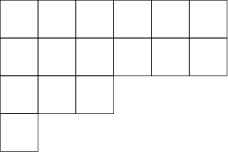


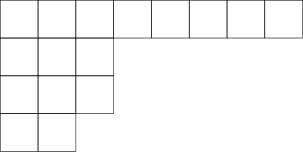


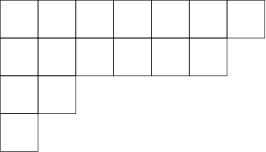


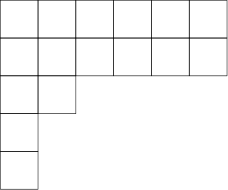


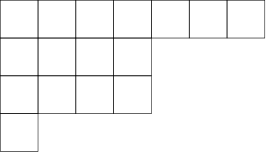


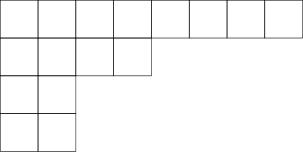


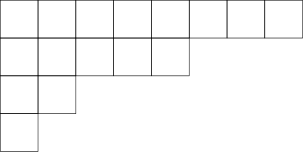


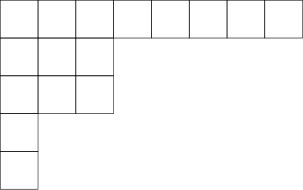


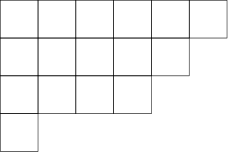


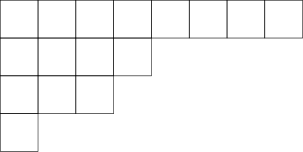


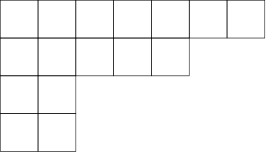


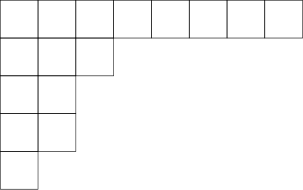


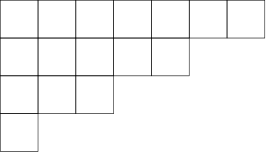


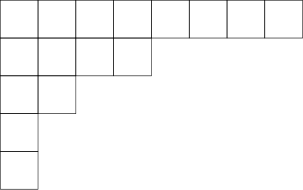


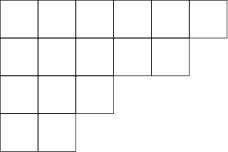


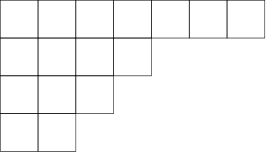


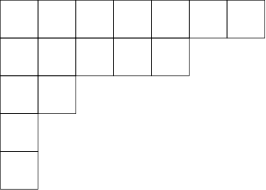


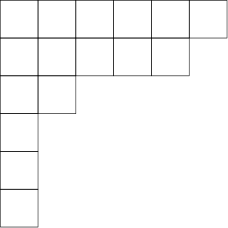


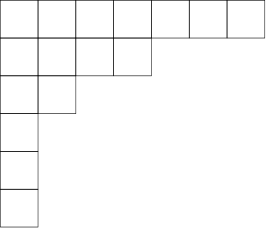


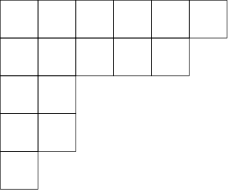


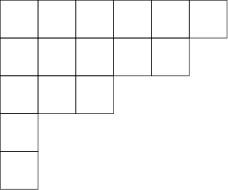


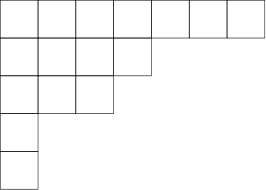


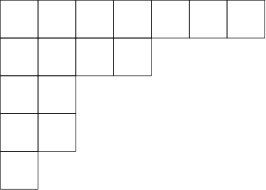

Tensor multiplicand 1:



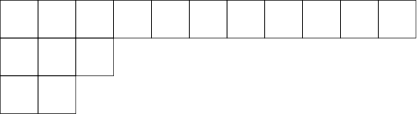

Tensor multiplicand 2:



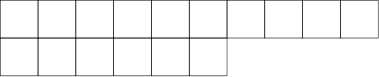

Tensor constituent(s):



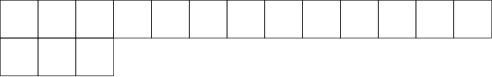


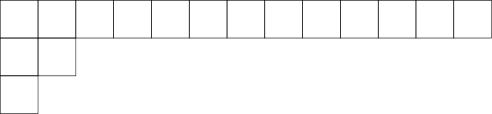


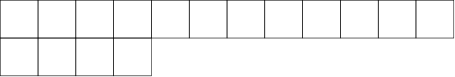


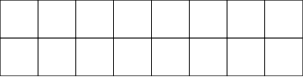


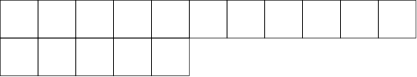


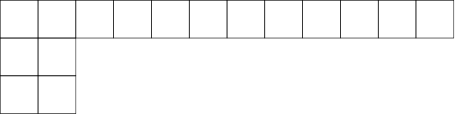


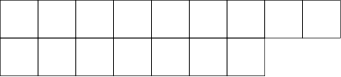


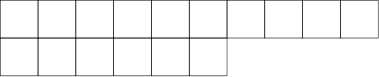


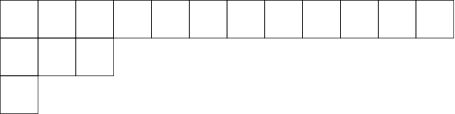


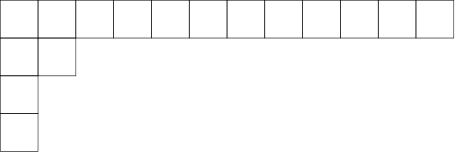


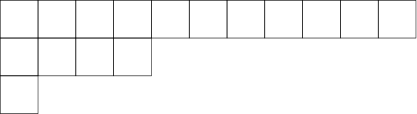


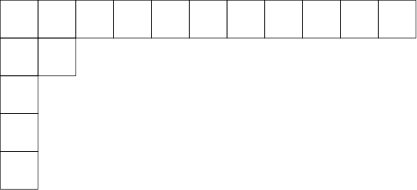


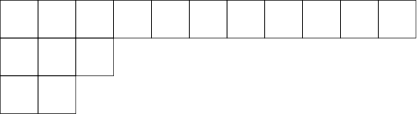

KeyboardInterrupt: 

In [71]:
render_tensor_decompositions_individual("SnSubsets16TensorPairs2.csv", "Tensor Pairs", 16, 3,4)